<a href="https://colab.research.google.com/github/karlmel/Artifical-Neural-Netwoks-Prediction-of-Energy-Use/blob/main/Prediction_Building_Energy_Using.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
df=pd.read_excel('TUM_BEBTR_YAPIMSISTMLI_deneme.xlsx', index_col='BINAKODU')
df

TOPLAM_INS  KOMPAKTLIK    EN_BOY  TABANALANI    bitisik  \
BINAKODU                                                                
343045506   57687.904002    0.298379  0.442802   1407.0200   0.000000   
296657430  397817.431795    0.139081  0.660311  33151.5000   0.000000   
280886102    2954.304900    0.445071  0.955662    422.0440   0.000000   
342225844    2128.086309    0.601486  0.433509    304.0120   0.000000   
106089816  326281.421231    0.166879  0.376302  40785.2000   0.000000   
...                  ...         ...       ...         ...        ...   
264458050     121.227430    1.676175  0.633741     30.3069   0.000000   
709440705     183.970895    1.393073  0.443870     45.9927   0.000000   
274999481     137.418286    1.810000  0.318194     34.3546   0.000000   
104516232      62.942227    1.341927  0.968044     62.9422   0.000000   
577214976     473.944521    0.926087  0.642112     94.7889  12.307298   

           Brlsk_Oran  BITISIKENR  ZEMINUSTUK  TUM_KAT  YAPI_SISTE  YIL  \
BINAKODU                                                                  
343045506           0     0.00000          40       41           4    3   
296657430           0     0.00000           4       12           4    4   
280886102           0     0.00000           6        7           4    4   
342225844           0     0.00000           4        7           4    3   
106089816           0     0.00000           3        8           4    3   
...               ...         ...         ...      ...         ...  ...   
264458050           0     0.00000           3        4           3    4   
709440705           0     0.00000           3        4           4    4   
274999481           0     0.00000           2        4           4    4   
104516232           0     0.00000           1        1           4    3   
577214976          31     0.30813           4        5           4    4   

            Enerji_Ala        ENERJI  
BINAKODU                              
343045506   664.981286  2.162213e+07  
296657430    82.141372  1.993036e+07  
280886102   343.906489  1.639040e+07  
342225844   108.465440  1.609417e+07  
106089816   110.780497  1.602601e+07  
...                ...           ...  
264458050   377.602530  6.927325e+03  
709440705   232.400847  6.910886e+03  
274999481   271.835833  5.651212e+03  
104516232  1853.081878  3.043667e+03  
577214976     0.676008  3.836347e+02  

[41001 rows x 13 columns]

In [3]:
#YAPI_SISTEM değişkenini dışarıda tutalım
df = df.drop(["Enerji_Ala","YIL", "YAPI_SISTE", "bitisik", "BITISIKENR", "ZEMINUSTUK", "TUM_KAT"], axis = 1).astype("float64")
df

TOPLAM_INS  KOMPAKTLIK    EN_BOY  TABANALANI  Brlsk_Oran  \
BINAKODU                                                                 
343045506   57687.904002    0.298379  0.442802   1407.0200         0.0   
296657430  397817.431795    0.139081  0.660311  33151.5000         0.0   
280886102    2954.304900    0.445071  0.955662    422.0440         0.0   
342225844    2128.086309    0.601486  0.433509    304.0120         0.0   
106089816  326281.421231    0.166879  0.376302  40785.2000         0.0   
...                  ...         ...       ...         ...         ...   
264458050     121.227430    1.676175  0.633741     30.3069         0.0   
709440705     183.970895    1.393073  0.443870     45.9927         0.0   
274999481     137.418286    1.810000  0.318194     34.3546         0.0   
104516232      62.942227    1.341927  0.968044     62.9422         0.0   
577214976     473.944521    0.926087  0.642112     94.7889        31.0   

                 ENERJI  
BINAKODU                 
343045506  2.162213e+07  
296657430  1.993036e+07  
280886102  1.639040e+07  
342225844  1.609417e+07  
106089816  1.602601e+07  
...                 ...  
264458050  6.927325e+03  
709440705  6.910886e+03  
274999481  5.651212e+03  
104516232  3.043667e+03  
577214976  3.836347e+02  

[41001 rows x 6 columns]

In [4]:
#outlierları hesaplamak için pyod import edilmeli
!pip install pyod

In [5]:
# Outlierları tespit edelim

from pyod.models.ecod import ECOD

clf = ECOD()
clf.fit(df)
outliers = clf.predict(df)

df["outliers"] = outliers

# Outliersız data
df_no_outliers = df[df["outliers"] == 0]
df_no_outliers = df_no_outliers.drop(["outliers"], axis = 1)

# Outlierlı data
df_with_outliers = df.copy()
df_with_outliers = df_with_outliers.drop(["outliers"], axis = 1)

print(df_no_outliers.shape)
print(df_with_outliers.shape)

(36901, 6)
(41001, 6)


In [6]:
df=df_no_outliers

In [7]:
# 'TOPLAM_INS' sütununu kullanarak verileri sırala (büyükten küçüğe)
df = df.sort_values(by='ENERJI', ascending=False)

# En büyük üç değeri seç
en_buyuk_uc = df.head(14)

# En büyük üç değeri içermeyen yeni bir DataFrame oluştur
df = df.drop(en_buyuk_uc.index)

In [8]:
X = df.drop('ENERJI',axis=1).values
y = df['ENERJI'].values

In [9]:
y=np.log(y)

In [10]:
# NumPy dizisini Pandas Series'e dönüştürme
y_series = pd.Series(y)

# y_series'in describe() fonksiyonunu kullanarak istatistiksel özetini alın
y_series.describe()

count    36887.000000
mean        11.601915
std          0.806000
min          8.994215
25%         11.025971
50%         11.591737
75%         12.198978
max         14.187930
dtype: float64

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=42)

In [12]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Veriyi standardize edelim
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
X_test

array([[-0.09434009, -0.72235919,  1.02476105,  0.07297676, -0.29499065],
       [-0.66632793,  0.7831336 , -0.58741796, -0.80316777, -0.29499065],
       [ 0.42410727, -0.68020023,  0.13534676,  0.3138594 , -0.29499065],
       ...,
       [-0.68021856,  0.56467472,  1.6730483 , -0.83351961, -0.29499065],
       [-0.69201924,  0.79898314,  1.24604297, -0.85931081, -0.29499065],
       [ 0.73586622, -1.18457382,  0.52899468,  1.58474261, -0.29499065]])

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(5,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=custom_optimizer, loss='mse')

In [15]:
from keras.utils import plot_model

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=600,  batch_size=128, callbacks=[early_stop])

Epoch 1/600
202/202 [==============================] - 2s 5ms/step - loss: 7.6917 - val_loss: 0.4387
Epoch 2/600
202/202 [==============================] - 1s 5ms/step - loss: 0.3091 - val_loss: 0.2262
Epoch 3/600
202/202 [==============================] - 2s 10ms/step - loss: 0.2143 - val_loss: 0.2241
Epoch 4/600
202/202 [==============================] - 2s 11ms/step - loss: 0.2092 - val_loss: 0.2028
Epoch 5/600
202/202 [==============================] - 2s 8ms/step - loss: 0.2022 - val_loss: 0.1959
Epoch 6/600
202/202 [==============================] - 1s 6ms/step - loss: 0.2033 - val_loss: 0.2257
Epoch 7/600
202/202 [==============================] - 2s 8ms/step - loss: 0.2011 - val_loss: 0.2009
Epoch 8/600
202/202 [==============================] - 2s 8ms/step - loss: 0.2026 - val_loss: 0.2158
Epoch 9/600
202/202 [==============================] - 1s 7ms/step - loss: 0.2016 - val_loss: 0.1976
Epoch 10/600
202/202 [==============================] - 1s 7ms/step - loss: 0.2024 - val_

In [17]:
predictions = model.predict(X_test)

346/346 [==============================] - 1s 2ms/step


In [18]:
import numpy as np
np.sqrt(mean_squared_error(y_test,predictions))

0.41111893836387825

In [19]:
mean_absolute_error(y_test,predictions)

0.3046813923896273

In [20]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
explained_variance_score(y_test,predictions)

0.7452858626632081

In [21]:
egitim_tahmin = model.predict(X_train)

807/807 [==============================] - 2s 2ms/step


In [22]:
egitim_tahmin.shape

(25820, 1)

In [23]:
np.sqrt(mean_squared_error(y_train,egitim_tahmin))

0.4034418910436004

In [24]:
mean_absolute_error(y_train,egitim_tahmin)

0.2980859504061461

In [25]:
explained_variance_score(y_train,egitim_tahmin)

0.7478566954191477

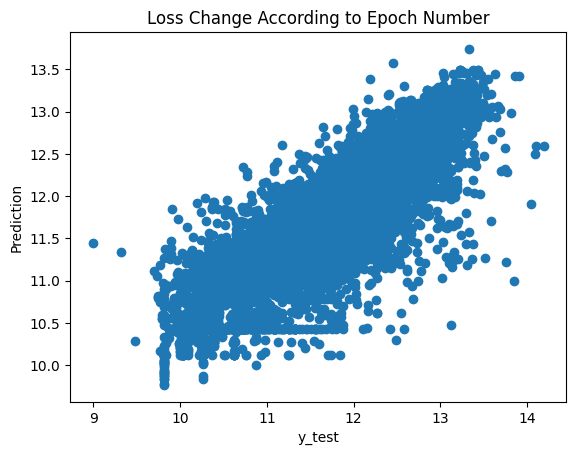

In [26]:
plt.scatter(y_test,predictions)
plt.xlabel('y_test')
plt.ylabel('Prediction')
plt.title('Loss Change According to Epoch Number')


# Grafiği PNG olarak kaydetme
plt.savefig('ANN_scatter.png', format='png')

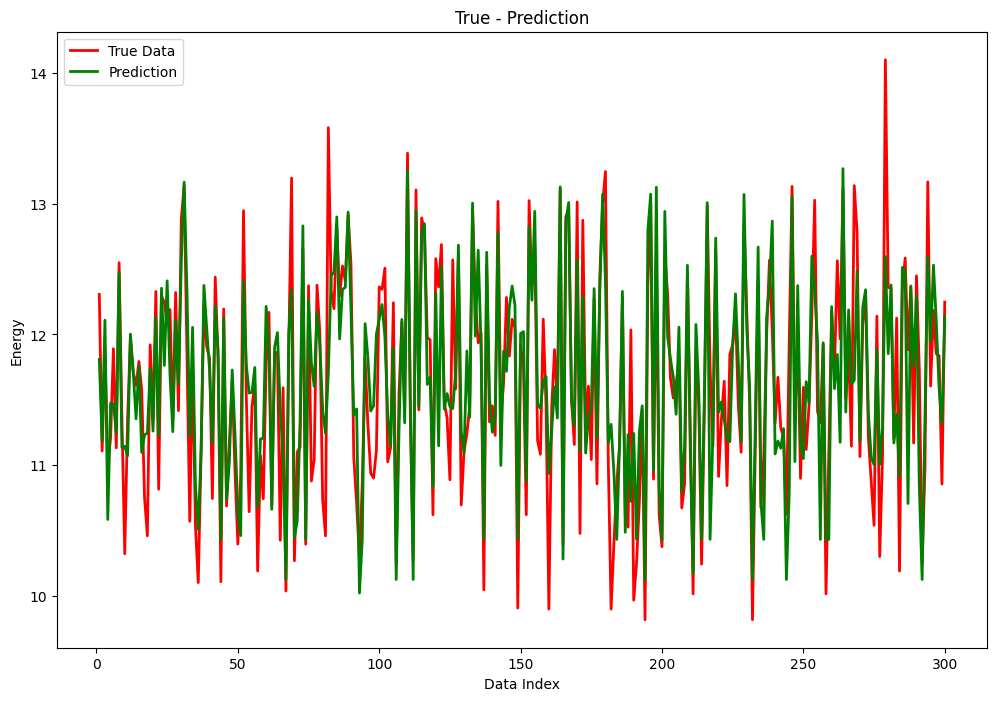

In [27]:
import matplotlib.pyplot as plt
# İlk 120 veriyi seç
indexler = range(1, 301)

# Gerçek Data -> Grand Truth
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(indexler, y_test[:300], label='True Data', color='red', linewidth=2)

# Tahmin -> Prediction
ax.plot(indexler, predictions [:300], label='Prediction', color='green', linewidth=2)

plt.savefig('True-Pred.png', format='png')

plt.title('True - Prediction')
plt.xlabel('Data Index')
plt.ylabel('Energy')
plt.legend(loc='upper left')
plt.show()

In [28]:
pip install shap==0.42.0

In [29]:
import shap
X_sub = shap.sample(X_train, 100)
explainer = shap.Explainer(model.predict, X_sub)
shap_values = explainer(X_test[:100])

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


19/19 [==============================] - 0s 4ms/step


Exact explainer:   4%|▍         | 4/100 [00:00<?, ?it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:   6%|▌         | 6/100 [00:12<01:07,  1.38it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:   7%|▋         | 7/100 [00:13<01:27,  1.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 8/100 [00:14<01:19,  1.16it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   9%|▉         | 9/100 [00:14<01:12,  1.26it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|█         | 10/100 [00:15<01:07,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  11%|█         | 11/100 [00:16<01:10,  1.26it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  12%|█▏        | 12/100 [00:17<01:16,  1.15it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  13%|█▎        | 13/100 [00:18<01:14,  1.16it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 14/100 [00:19<01:22,  1.04it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  15%|█▌        | 15/100 [00:20<01:21,  1.05it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  16%|█▌        | 16/100 [00:21<01:23,  1.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 17/100 [00:22<01:18,  1.05it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 18/100 [00:23<01:13,  1.12it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  19%|█▉        | 19/100 [00:24<01:12,  1.12it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 20/100 [00:24<01:10,  1.14it/s]

19/19 [==============================] - 0s 7ms/step


Exact explainer:  21%|██        | 21/100 [00:26<01:18,  1.00it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 22/100 [00:27<01:22,  1.06s/it]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  23%|██▎       | 23/100 [00:28<01:12,  1.06it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  24%|██▍       | 24/100 [00:29<01:22,  1.09s/it]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 25/100 [00:30<01:25,  1.13s/it]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  26%|██▌       | 26/100 [00:31<01:20,  1.09s/it]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 27/100 [00:32<01:14,  1.02s/it]

19/19 [==============================] - 0s 7ms/step


Exact explainer:  28%|██▊       | 28/100 [00:33<01:10,  1.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 29/100 [00:33<00:56,  1.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 30/100 [00:34<00:45,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 31/100 [00:34<00:39,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 32/100 [00:34<00:33,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 33/100 [00:35<00:29,  2.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 34/100 [00:35<00:27,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 35/100 [00:35<00:25,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 36/100 [00:36<00:23,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 37/100 [00:36<00:21,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 38/100 [00:36<00:20,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 39/100 [00:37<00:24,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 40/100 [00:37<00:26,  2.27it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 41/100 [00:38<00:29,  1.99it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 42/100 [00:39<00:32,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 43/100 [00:39<00:28,  2.03it/s]

19/19 [==============================] - 0s 1ms/step


Exact explainer:  44%|████▍     | 44/100 [00:39<00:24,  2.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 45/100 [00:40<00:21,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 46/100 [00:40<00:20,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 47/100 [00:41<00:22,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 48/100 [00:41<00:19,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 49/100 [00:41<00:18,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 50/100 [00:41<00:17,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 51/100 [00:42<00:16,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 52/100 [00:42<00:16,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 53/100 [00:42<00:16,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 54/100 [00:43<00:15,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 55/100 [00:43<00:15,  2.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 56/100 [00:43<00:14,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 57/100 [00:44<00:16,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 58/100 [00:44<00:15,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 59/100 [00:45<00:14,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 60/100 [00:45<00:14,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 61/100 [00:45<00:13,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 62/100 [00:46<00:13,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 63/100 [00:46<00:12,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 64/100 [00:46<00:12,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 65/100 [00:47<00:13,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 66/100 [00:47<00:12,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 67/100 [00:47<00:11,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 68/100 [00:48<00:11,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 69/100 [00:48<00:10,  2.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 70/100 [00:48<00:09,  3.10it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 71/100 [00:49<00:10,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 72/100 [00:49<00:11,  2.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 73/100 [00:50<00:13,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 74/100 [00:51<00:13,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 75/100 [00:51<00:12,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 76/100 [00:51<00:10,  2.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 77/100 [00:52<00:09,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 78/100 [00:52<00:08,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 79/100 [00:53<00:08,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 80/100 [00:53<00:07,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 81/100 [00:53<00:07,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 82/100 [00:53<00:06,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 83/100 [00:54<00:05,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 84/100 [00:54<00:05,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 85/100 [00:54<00:05,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 86/100 [00:55<00:04,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 87/100 [00:55<00:04,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 88/100 [00:55<00:03,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 89/100 [00:56<00:03,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 90/100 [00:56<00:03,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 91/100 [00:56<00:03,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 92/100 [00:57<00:02,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 93/100 [00:57<00:02,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 94/100 [00:57<00:02,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 95/100 [00:58<00:01,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 96/100 [00:58<00:01,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 97/100 [00:58<00:00,  3.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 98/100 [00:59<00:00,  3.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 99/100 [00:59<00:00,  3.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|██████████| 100/100 [00:59<00:00,  3.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 101it [01:00,  1.61it/s]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


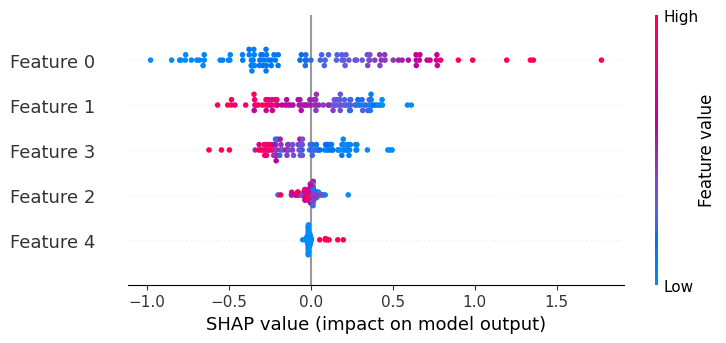

<Figure size 640x480 with 0 Axes>

In [30]:
shap.plots.beeswarm(shap_values)

plt.savefig('shap_values_beeswarm.png', format='png')

plt.show()

In [31]:
import shap
X_sub = shap.sample(X_train, 200)
explainer = shap.Explainer(model.predict, X_sub)
shap_values = explainer(X_test[:200])

19/19 [==============================] - 0s 3ms/step


Exact explainer:   8%|▊         | 17/200 [00:00<?, ?it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 19/200 [00:11<01:04,  2.83it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  10%|█         | 20/200 [00:12<01:44,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  10%|█         | 21/200 [00:13<02:00,  1.49it/s]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  11%|█         | 22/200 [00:14<02:47,  1.06it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  12%|█▏        | 23/200 [00:15<03:08,  1.06s/it]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 24/200 [00:16<02:51,  1.02it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  12%|█▎        | 25/200 [00:17<02:35,  1.12it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  13%|█▎        | 26/200 [00:18<02:42,  1.07it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▎        | 27/200 [00:19<02:31,  1.14it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 28/200 [00:19<02:19,  1.23it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 29/200 [00:20<02:12,  1.29it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  15%|█▌        | 30/200 [00:21<02:23,  1.19it/s]

19/19 [==============================] - 0s 7ms/step


Exact explainer:  16%|█▌        | 31/200 [00:22<02:47,  1.01it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 32/200 [00:24<03:04,  1.10s/it]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  16%|█▋        | 33/200 [00:24<02:45,  1.01it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 34/200 [00:25<02:47,  1.01s/it]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  18%|█▊        | 35/200 [00:27<03:01,  1.10s/it]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  18%|█▊        | 36/200 [00:28<03:19,  1.22s/it]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  18%|█▊        | 37/200 [00:29<03:10,  1.17s/it]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 38/200 [00:30<02:53,  1.07s/it]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  20%|█▉        | 39/200 [00:31<02:53,  1.08s/it]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  20%|██        | 40/200 [00:32<02:41,  1.01s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  20%|██        | 41/200 [00:33<02:50,  1.07s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  21%|██        | 42/200 [00:35<03:03,  1.16s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 43/200 [00:35<02:37,  1.01s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 44/200 [00:36<02:27,  1.06it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▎       | 45/200 [00:37<02:15,  1.14it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  23%|██▎       | 46/200 [00:37<01:59,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 47/200 [00:38<02:03,  1.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 48/200 [00:39<01:40,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 49/200 [00:39<01:24,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 50/200 [00:39<01:12,  2.06it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 51/200 [00:40<01:15,  1.98it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 52/200 [00:40<01:12,  2.04it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▋       | 53/200 [00:41<01:17,  1.90it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 54/200 [00:41<01:20,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 55/200 [00:42<01:19,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 56/200 [00:42<01:09,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 57/200 [00:43<01:11,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 58/200 [00:43<01:03,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 59/200 [00:43<00:56,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 60/200 [00:44<00:52,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 61/200 [00:44<00:50,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 62/200 [00:44<00:47,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 63/200 [00:45<00:47,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 64/200 [00:45<00:46,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▎      | 65/200 [00:46<00:53,  2.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 66/200 [00:46<00:49,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 67/200 [00:46<00:48,  2.74it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  34%|███▍      | 68/200 [00:47<01:05,  2.01it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 69/200 [00:48<01:12,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 70/200 [00:49<01:22,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▌      | 71/200 [00:49<01:25,  1.51it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  36%|███▌      | 72/200 [00:50<01:33,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▋      | 73/200 [00:51<01:31,  1.38it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  37%|███▋      | 74/200 [00:52<01:48,  1.16it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  38%|███▊      | 75/200 [00:54<02:12,  1.06s/it]

19/19 [==============================] - 0s 14ms/step


Exact explainer:  38%|███▊      | 76/200 [00:56<02:45,  1.34s/it]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  38%|███▊      | 77/200 [00:57<02:43,  1.33s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 78/200 [00:58<02:23,  1.18s/it]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  40%|███▉      | 79/200 [00:59<02:17,  1.13s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|████      | 80/200 [01:00<02:17,  1.14s/it]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  40%|████      | 81/200 [01:01<02:10,  1.10s/it]

19/19 [==============================] - 0s 13ms/step


Exact explainer:  41%|████      | 82/200 [01:03<02:37,  1.33s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 83/200 [01:04<02:30,  1.29s/it]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  42%|████▏     | 84/200 [01:05<02:20,  1.21s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▎     | 85/200 [01:06<01:59,  1.04s/it]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  43%|████▎     | 86/200 [01:07<02:08,  1.13s/it]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  44%|████▎     | 87/200 [01:08<02:13,  1.19s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 88/200 [01:09<02:11,  1.17s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 89/200 [01:10<01:56,  1.05s/it]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 90/200 [01:11<01:42,  1.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 91/200 [01:11<01:32,  1.18it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  46%|████▌     | 92/200 [01:12<01:30,  1.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▋     | 93/200 [01:13<01:33,  1.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 94/200 [01:14<01:15,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 95/200 [01:14<01:02,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 96/200 [01:14<00:54,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 97/200 [01:15<00:48,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 98/200 [01:15<00:44,  2.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 99/200 [01:15<00:40,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 100/200 [01:16<00:39,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 101/200 [01:16<00:42,  2.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 102/200 [01:16<00:38,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 103/200 [01:17<00:35,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 104/200 [01:17<00:33,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▎    | 105/200 [01:17<00:32,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 106/200 [01:18<00:32,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 107/200 [01:18<00:31,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 108/200 [01:18<00:31,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 109/200 [01:19<00:31,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 110/200 [01:19<00:31,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 111/200 [01:20<00:37,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 112/200 [01:20<00:40,  2.18it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▋    | 113/200 [01:21<00:51,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 114/200 [01:22<00:44,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▊    | 115/200 [01:22<00:39,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 116/200 [01:22<00:36,  2.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 117/200 [01:23<00:33,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 118/200 [01:23<00:30,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 119/200 [01:23<00:28,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 120/200 [01:24<00:31,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 121/200 [01:24<00:28,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 122/200 [01:24<00:27,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 123/200 [01:25<00:26,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 124/200 [01:25<00:25,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▎   | 125/200 [01:25<00:28,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 126/200 [01:26<00:27,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 127/200 [01:26<00:26,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 128/200 [01:26<00:26,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 129/200 [01:27<00:25,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 130/200 [01:27<00:24,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 131/200 [01:28<00:24,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 132/200 [01:28<00:23,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▋   | 133/200 [01:28<00:22,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 134/200 [01:29<00:21,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 135/200 [01:29<00:20,  3.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 136/200 [01:29<00:20,  3.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 137/200 [01:29<00:20,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 138/200 [01:30<00:20,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 139/200 [01:30<00:20,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 140/200 [01:31<00:20,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 141/200 [01:31<00:20,  2.92it/s]

19/19 [==============================] - 0s 7ms/step


Exact explainer:  71%|███████   | 142/200 [01:32<00:24,  2.32it/s]

19/19 [==============================] - 0s 7ms/step


Exact explainer:  72%|███████▏  | 143/200 [01:33<00:36,  1.57it/s]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  72%|███████▏  | 144/200 [01:34<00:54,  1.04it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▎  | 145/200 [01:35<00:50,  1.10it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  73%|███████▎  | 146/200 [01:36<00:50,  1.07it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  74%|███████▎  | 147/200 [01:37<00:46,  1.15it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  74%|███████▍  | 148/200 [01:38<00:50,  1.03it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  74%|███████▍  | 149/200 [01:39<00:47,  1.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 150/200 [01:40<00:41,  1.19it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 151/200 [01:40<00:36,  1.34it/s]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  76%|███████▌  | 152/200 [01:41<00:33,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▋  | 153/200 [01:41<00:32,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  77%|███████▋  | 154/200 [01:43<00:42,  1.08it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  78%|███████▊  | 155/200 [01:44<00:46,  1.03s/it]

19/19 [==============================] - 0s 13ms/step


Exact explainer:  78%|███████▊  | 156/200 [01:46<00:56,  1.29s/it]

19/19 [==============================] - 0s 7ms/step


Exact explainer:  78%|███████▊  | 157/200 [01:48<01:08,  1.59s/it]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  79%|███████▉  | 158/200 [01:50<01:04,  1.54s/it]

19/19 [==============================] - 0s 7ms/step


Exact explainer:  80%|███████▉  | 159/200 [01:51<01:01,  1.51s/it]

19/19 [==============================] - 0s 9ms/step


Exact explainer:  80%|████████  | 160/200 [01:53<01:00,  1.52s/it]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 161/200 [01:53<00:51,  1.31s/it]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  81%|████████  | 162/200 [01:55<00:51,  1.36s/it]

19/19 [==============================] - 0s 9ms/step


Exact explainer:  82%|████████▏ | 163/200 [01:56<00:52,  1.41s/it]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  82%|████████▏ | 164/200 [01:58<00:46,  1.30s/it]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  82%|████████▎ | 165/200 [01:59<00:48,  1.39s/it]

19/19 [==============================] - 0s 7ms/step


Exact explainer:  83%|████████▎ | 166/200 [02:01<00:51,  1.52s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▎ | 167/200 [02:02<00:47,  1.44s/it]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 168/200 [02:03<00:38,  1.21s/it]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 169/200 [02:04<00:33,  1.07s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 170/200 [02:04<00:28,  1.05it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 171/200 [02:05<00:24,  1.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 172/200 [02:05<00:20,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▋ | 173/200 [02:06<00:19,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 174/200 [02:07<00:18,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 175/200 [02:07<00:15,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 176/200 [02:08<00:15,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 177/200 [02:09<00:15,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 178/200 [02:09<00:15,  1.44it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  90%|████████▉ | 179/200 [02:10<00:15,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 180/200 [02:11<00:14,  1.39it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  90%|█████████ | 181/200 [02:12<00:13,  1.37it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  91%|█████████ | 182/200 [02:13<00:14,  1.22it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  92%|█████████▏| 183/200 [02:14<00:15,  1.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 184/200 [02:15<00:16,  1.05s/it]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▎| 185/200 [02:16<00:12,  1.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 186/200 [02:16<00:09,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 187/200 [02:16<00:07,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 188/200 [02:17<00:06,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 189/200 [02:17<00:04,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 190/200 [02:17<00:04,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 191/200 [02:18<00:03,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 192/200 [02:18<00:03,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 193/200 [02:18<00:02,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 194/200 [02:19<00:02,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 195/200 [02:19<00:02,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 196/200 [02:19<00:01,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 197/200 [02:20<00:01,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 198/200 [02:20<00:00,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 199/200 [02:20<00:00,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|██████████| 200/200 [02:21<00:00,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 201it [02:21,  1.30it/s]


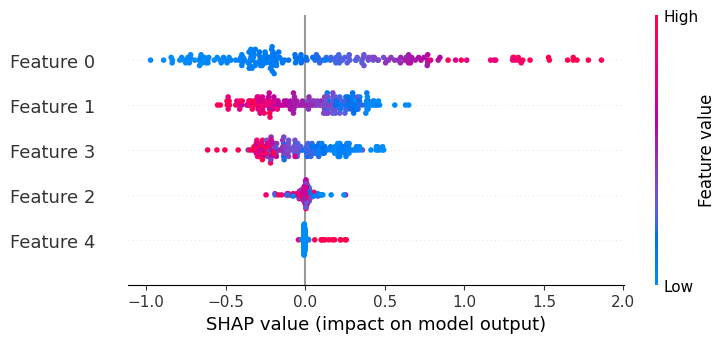

<Figure size 640x480 with 0 Axes>

In [32]:
# SHAP değerlerini görselleştirin
shap.plots.beeswarm(shap_values)

# Görseli kaydedin
plt.savefig('shap_values_beeswarm.png', format='png')

# Görseli gösterin (isteğe bağlı)
plt.show()

In [65]:
import shap
X_sub = shap.sample(X_train, 1000)
explainer = shap.Explainer(model.predict, X_sub)
shap_values = explainer(X_test[:1000])

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 27/1000 [00:00<?, ?it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 29/1000 [00:10<02:44,  5.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 30/1000 [00:10<03:53,  4.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 31/1000 [00:11<04:14,  3.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 32/1000 [00:11<04:34,  3.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 33/1000 [00:11<04:56,  3.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 34/1000 [00:12<05:08,  3.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 35/1000 [00:12<05:15,  3.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 36/1000 [00:12<05:18,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 37/1000 [00:13<05:27,  2.94it/s]

19/19 [==============================] - 0s 1ms/step


Exact explainer:   4%|▍         | 38/1000 [00:13<05:23,  2.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 39/1000 [00:13<05:16,  3.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 40/1000 [00:14<06:06,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 41/1000 [00:14<06:01,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 42/1000 [00:14<05:46,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 43/1000 [00:15<05:39,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 44/1000 [00:15<05:32,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 45/1000 [00:16<05:36,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 46/1000 [00:16<05:16,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 47/1000 [00:16<06:08,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 48/1000 [00:17<05:52,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 49/1000 [00:17<05:37,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 50/1000 [00:17<05:41,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 51/1000 [00:18<05:36,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 52/1000 [00:18<06:31,  2.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   5%|▌         | 53/1000 [00:19<09:40,  1.63it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:   5%|▌         | 54/1000 [00:20<10:05,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:   6%|▌         | 55/1000 [00:21<11:53,  1.32it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:   6%|▌         | 56/1000 [00:22<14:03,  1.12it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▌         | 57/1000 [00:24<17:47,  1.13s/it]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 58/1000 [00:25<15:13,  1.03it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▌         | 59/1000 [00:25<13:51,  1.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 60/1000 [00:26<12:50,  1.22it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▌         | 61/1000 [00:26<11:48,  1.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 62/1000 [00:27<10:46,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 63/1000 [00:27<08:57,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 64/1000 [00:28<07:57,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 65/1000 [00:28<07:18,  2.13it/s]

19/19 [==============================] - 0s 1ms/step


Exact explainer:   7%|▋         | 66/1000 [00:28<06:37,  2.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 67/1000 [00:29<06:04,  2.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   7%|▋         | 68/1000 [00:29<07:40,  2.03it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   7%|▋         | 69/1000 [00:30<08:12,  1.89it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   7%|▋         | 70/1000 [00:31<08:19,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 71/1000 [00:33<15:45,  1.02s/it]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 72/1000 [00:33<13:31,  1.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 73/1000 [00:34<10:58,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 74/1000 [00:34<10:02,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 75/1000 [00:34<08:36,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 76/1000 [00:35<07:37,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 77/1000 [00:35<06:54,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 78/1000 [00:35<06:19,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 79/1000 [00:36<06:11,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 80/1000 [00:36<05:46,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 81/1000 [00:37<05:39,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 82/1000 [00:37<05:24,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 83/1000 [00:37<05:50,  2.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   8%|▊         | 84/1000 [00:38<06:48,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 85/1000 [00:38<06:28,  2.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 86/1000 [00:39<06:59,  2.18it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   9%|▊         | 87/1000 [00:39<07:46,  1.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 88/1000 [00:40<07:59,  1.90it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 89/1000 [00:41<08:19,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 90/1000 [00:41<07:56,  1.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 91/1000 [00:42<08:41,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 92/1000 [00:42<07:51,  1.93it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 93/1000 [00:43<08:01,  1.88it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:   9%|▉         | 94/1000 [00:43<08:59,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  10%|▉         | 95/1000 [00:44<10:11,  1.48it/s]

19/19 [==============================] - 0s 7ms/step


Exact explainer:  10%|▉         | 96/1000 [00:46<13:16,  1.14it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 97/1000 [00:47<13:06,  1.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 98/1000 [00:47<11:47,  1.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 99/1000 [00:48<12:58,  1.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 100/1000 [00:48<10:35,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 101/1000 [00:49<09:16,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 102/1000 [00:49<07:52,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 103/1000 [00:49<06:48,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 104/1000 [00:50<06:11,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 105/1000 [00:50<05:44,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 106/1000 [00:50<05:37,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 107/1000 [00:51<05:22,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 108/1000 [00:51<05:14,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 109/1000 [00:51<04:58,  2.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 110/1000 [00:52<05:02,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 111/1000 [00:52<04:54,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 112/1000 [00:52<04:50,  3.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 113/1000 [00:53<05:17,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 114/1000 [00:53<05:16,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 115/1000 [00:54<05:13,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 116/1000 [00:54<05:04,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 117/1000 [00:54<05:00,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 118/1000 [00:55<04:50,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 119/1000 [00:55<04:53,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 120/1000 [00:55<05:04,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 121/1000 [00:56<05:02,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 122/1000 [00:56<05:03,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 123/1000 [00:56<04:51,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 124/1000 [00:57<05:42,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▎        | 125/1000 [00:57<06:34,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 126/1000 [00:58<07:07,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 127/1000 [00:58<07:32,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 128/1000 [00:59<07:38,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 129/1000 [00:59<06:42,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 130/1000 [01:00<06:12,  2.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 131/1000 [01:00<05:42,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 132/1000 [01:00<05:23,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 133/1000 [01:01<05:13,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 134/1000 [01:01<05:11,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 135/1000 [01:01<04:59,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 136/1000 [01:02<04:48,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 137/1000 [01:02<04:42,  3.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 138/1000 [01:02<04:42,  3.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 139/1000 [01:03<04:39,  3.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 140/1000 [01:03<04:39,  3.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 141/1000 [01:03<04:40,  3.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 142/1000 [01:04<04:37,  3.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 143/1000 [01:04<04:35,  3.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 144/1000 [01:04<04:42,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 145/1000 [01:05<04:40,  3.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 146/1000 [01:05<04:33,  3.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 147/1000 [01:05<04:31,  3.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 148/1000 [01:05<04:28,  3.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 149/1000 [01:06<04:28,  3.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 150/1000 [01:06<04:32,  3.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 151/1000 [01:06<04:36,  3.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 152/1000 [01:07<04:35,  3.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 153/1000 [01:07<05:23,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 154/1000 [01:08<05:02,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 155/1000 [01:08<04:58,  2.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 156/1000 [01:08<05:12,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 157/1000 [01:09<05:07,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 158/1000 [01:09<05:51,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 159/1000 [01:10<06:45,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 160/1000 [01:11<07:29,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 161/1000 [01:11<08:00,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 162/1000 [01:12<06:57,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 163/1000 [01:12<06:18,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 164/1000 [01:12<05:41,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 165/1000 [01:13<05:24,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 166/1000 [01:13<05:11,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 167/1000 [01:13<05:44,  2.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 168/1000 [01:14<05:29,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 169/1000 [01:14<05:09,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 170/1000 [01:14<05:01,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 171/1000 [01:15<04:52,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 172/1000 [01:15<04:44,  2.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 173/1000 [01:15<04:46,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 174/1000 [01:16<04:46,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 175/1000 [01:16<04:41,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 176/1000 [01:16<04:41,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 177/1000 [01:17<04:40,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 178/1000 [01:17<04:29,  3.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 179/1000 [01:17<04:27,  3.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 180/1000 [01:18<04:30,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 181/1000 [01:18<04:22,  3.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 182/1000 [01:18<04:23,  3.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 183/1000 [01:19<04:22,  3.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 184/1000 [01:19<04:18,  3.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 185/1000 [01:19<04:26,  3.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 186/1000 [01:20<04:36,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 187/1000 [01:20<04:38,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 188/1000 [01:20<04:36,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 189/1000 [01:21<04:37,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 190/1000 [01:21<04:39,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 191/1000 [01:22<05:25,  2.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 192/1000 [01:22<06:05,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 193/1000 [01:23<05:52,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 194/1000 [01:23<05:51,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 195/1000 [01:24<06:49,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 196/1000 [01:24<06:09,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 197/1000 [01:24<05:37,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 198/1000 [01:25<05:08,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 199/1000 [01:25<04:58,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 200/1000 [01:26<05:28,  2.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 201/1000 [01:26<05:11,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 202/1000 [01:26<04:57,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 203/1000 [01:27<04:47,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 204/1000 [01:27<04:43,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 205/1000 [01:27<04:41,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 206/1000 [01:28<04:35,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 207/1000 [01:28<04:25,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 208/1000 [01:28<04:24,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 209/1000 [01:29<04:24,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 210/1000 [01:29<04:20,  3.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 211/1000 [01:29<04:14,  3.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 212/1000 [01:29<04:13,  3.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 213/1000 [01:30<04:14,  3.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 214/1000 [01:30<04:17,  3.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 215/1000 [01:30<04:14,  3.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 216/1000 [01:31<04:12,  3.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 217/1000 [01:31<04:18,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 218/1000 [01:31<04:21,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 219/1000 [01:32<04:23,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 220/1000 [01:32<04:18,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 221/1000 [01:32<04:23,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 222/1000 [01:33<04:18,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 223/1000 [01:33<04:26,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 224/1000 [01:34<05:31,  2.34it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▎       | 225/1000 [01:34<06:27,  2.00it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  23%|██▎       | 226/1000 [01:35<06:58,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 227/1000 [01:36<07:14,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 228/1000 [01:36<07:46,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  23%|██▎       | 229/1000 [01:37<08:18,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 230/1000 [01:38<07:58,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 231/1000 [01:38<06:57,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 232/1000 [01:38<06:12,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 233/1000 [01:39<06:17,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 234/1000 [01:39<05:41,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 235/1000 [01:40<05:33,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 236/1000 [01:40<05:09,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 237/1000 [01:40<04:56,  2.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 238/1000 [01:41<04:43,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 239/1000 [01:41<04:33,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 240/1000 [01:41<04:31,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 241/1000 [01:42<04:28,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 242/1000 [01:42<04:39,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 243/1000 [01:42<04:37,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 244/1000 [01:43<04:26,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 245/1000 [01:43<04:20,  2.90it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 246/1000 [01:44<04:41,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 247/1000 [01:44<04:27,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 248/1000 [01:44<04:18,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 249/1000 [01:45<04:14,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 250/1000 [01:45<04:16,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 251/1000 [01:45<04:19,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 252/1000 [01:46<04:21,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 253/1000 [01:46<04:15,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 254/1000 [01:46<04:11,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 255/1000 [01:47<04:13,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 256/1000 [01:47<04:07,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 257/1000 [01:47<04:07,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 258/1000 [01:48<04:04,  3.03it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 259/1000 [01:48<04:29,  2.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 260/1000 [01:49<05:07,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 261/1000 [01:49<05:30,  2.24it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 262/1000 [01:50<06:15,  1.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▋       | 263/1000 [01:50<06:50,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 264/1000 [01:51<06:04,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 265/1000 [01:51<06:08,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 266/1000 [01:52<05:28,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 267/1000 [01:52<05:42,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 268/1000 [01:52<05:07,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 269/1000 [01:53<04:53,  2.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 270/1000 [01:53<04:38,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 271/1000 [01:53<04:21,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 272/1000 [01:54<04:15,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 273/1000 [01:54<04:54,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 274/1000 [01:55<04:36,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 275/1000 [01:55<04:29,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 276/1000 [01:55<04:19,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 277/1000 [01:56<04:30,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 278/1000 [01:56<04:19,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 279/1000 [01:56<04:19,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 280/1000 [01:57<04:12,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 281/1000 [01:57<04:06,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 282/1000 [01:58<04:38,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 283/1000 [01:58<05:09,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 284/1000 [01:58<04:52,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 285/1000 [01:59<04:38,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 286/1000 [01:59<04:22,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 287/1000 [01:59<04:15,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 288/1000 [02:00<04:05,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 289/1000 [02:00<04:02,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 290/1000 [02:00<03:59,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 291/1000 [02:01<05:03,  2.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 292/1000 [02:02<05:49,  2.02it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 293/1000 [02:02<06:00,  1.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 294/1000 [02:03<06:35,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 295/1000 [02:03<05:50,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 296/1000 [02:04<05:16,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 297/1000 [02:04<04:56,  2.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 298/1000 [02:04<04:41,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 299/1000 [02:05<04:31,  2.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 300/1000 [02:05<04:22,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 301/1000 [02:05<04:50,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 302/1000 [02:06<04:47,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 303/1000 [02:06<04:48,  2.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 304/1000 [02:07<04:49,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 305/1000 [02:07<04:32,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 306/1000 [02:07<04:23,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 307/1000 [02:08<04:14,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 308/1000 [02:08<04:06,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 309/1000 [02:08<04:06,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 310/1000 [02:09<04:11,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 311/1000 [02:09<04:08,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 312/1000 [02:10<04:06,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 313/1000 [02:10<03:59,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 314/1000 [02:10<03:57,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 315/1000 [02:11<03:57,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 316/1000 [02:11<03:53,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 317/1000 [02:11<03:45,  3.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 318/1000 [02:12<03:45,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 319/1000 [02:12<03:46,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 320/1000 [02:12<03:45,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 321/1000 [02:13<03:51,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 322/1000 [02:13<03:49,  2.95it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 323/1000 [02:13<04:41,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 324/1000 [02:14<05:09,  2.19it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▎      | 325/1000 [02:15<05:35,  2.01it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 326/1000 [02:15<05:55,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 327/1000 [02:16<05:58,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 328/1000 [02:16<05:14,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 329/1000 [02:16<04:43,  2.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 330/1000 [02:17<04:29,  2.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 331/1000 [02:17<04:16,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 332/1000 [02:17<04:04,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 333/1000 [02:18<04:04,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 334/1000 [02:18<03:52,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 335/1000 [02:19<04:09,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 336/1000 [02:19<03:58,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 337/1000 [02:19<03:51,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 338/1000 [02:20<04:02,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 339/1000 [02:20<04:08,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 340/1000 [02:20<03:53,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 341/1000 [02:21<03:52,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 342/1000 [02:21<04:20,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 343/1000 [02:21<04:04,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 344/1000 [02:22<03:58,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 345/1000 [02:22<03:53,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 346/1000 [02:22<03:51,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 347/1000 [02:23<03:47,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 348/1000 [02:23<03:45,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 349/1000 [02:24<03:48,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 350/1000 [02:24<03:45,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 351/1000 [02:24<03:45,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 352/1000 [02:25<03:39,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 353/1000 [02:25<03:38,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 354/1000 [02:25<03:33,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 355/1000 [02:25<03:28,  3.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 356/1000 [02:26<04:28,  2.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 357/1000 [02:27<05:02,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 358/1000 [02:27<05:00,  2.14it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 359/1000 [02:28<05:22,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 360/1000 [02:28<05:17,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 361/1000 [02:29<04:48,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 362/1000 [02:29<04:26,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 363/1000 [02:29<04:12,  2.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 364/1000 [02:30<04:03,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 365/1000 [02:30<03:54,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 366/1000 [02:30<03:42,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 367/1000 [02:31<03:39,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 368/1000 [02:31<03:36,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 369/1000 [02:31<03:33,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 370/1000 [02:32<03:30,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 371/1000 [02:32<03:31,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 372/1000 [02:32<03:35,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 373/1000 [02:33<03:33,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 374/1000 [02:33<04:04,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 375/1000 [02:35<07:23,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 376/1000 [02:35<06:12,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 377/1000 [02:35<05:18,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 378/1000 [02:36<04:44,  2.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 379/1000 [02:36<04:17,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 380/1000 [02:36<03:58,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 381/1000 [02:37<03:50,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 382/1000 [02:37<03:45,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 383/1000 [02:37<03:40,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 384/1000 [02:38<03:38,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 385/1000 [02:38<03:31,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 386/1000 [02:38<03:48,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 387/1000 [02:39<04:27,  2.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 388/1000 [02:39<04:43,  2.16it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 389/1000 [02:40<05:16,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 390/1000 [02:41<05:25,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 391/1000 [02:41<04:49,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 392/1000 [02:41<04:25,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 393/1000 [02:42<04:05,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 394/1000 [02:42<03:49,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 395/1000 [02:42<03:38,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 396/1000 [02:43<03:35,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 397/1000 [02:43<03:27,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 398/1000 [02:43<03:24,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 399/1000 [02:44<03:27,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 400/1000 [02:44<03:24,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 401/1000 [02:44<03:54,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 402/1000 [02:45<03:38,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 403/1000 [02:45<03:32,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 404/1000 [02:45<03:31,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 405/1000 [02:46<03:22,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 406/1000 [02:46<03:22,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 407/1000 [02:46<03:24,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 408/1000 [02:47<03:26,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 409/1000 [02:47<03:22,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 410/1000 [02:48<03:23,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 411/1000 [02:48<03:18,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 412/1000 [02:48<03:29,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████▏     | 413/1000 [02:49<03:27,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████▏     | 414/1000 [02:49<03:25,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 415/1000 [02:49<03:22,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 416/1000 [02:50<03:50,  2.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 417/1000 [02:50<03:38,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 418/1000 [02:50<03:31,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 419/1000 [02:51<03:35,  2.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 420/1000 [02:51<04:10,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 421/1000 [02:52<04:33,  2.12it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 422/1000 [02:52<04:40,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 423/1000 [02:53<04:59,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 424/1000 [02:54<05:02,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▎     | 425/1000 [02:54<04:24,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 426/1000 [02:54<04:02,  2.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 427/1000 [02:55<03:44,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 428/1000 [02:55<03:44,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 429/1000 [02:55<03:28,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 430/1000 [02:56<03:26,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 431/1000 [02:56<03:24,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 432/1000 [02:56<03:23,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 433/1000 [02:57<03:18,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 434/1000 [02:57<03:18,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 435/1000 [02:57<03:09,  2.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 436/1000 [02:58<03:10,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 437/1000 [02:58<03:13,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 438/1000 [02:58<03:06,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 439/1000 [02:59<03:09,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 440/1000 [02:59<03:08,  2.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 441/1000 [02:59<03:02,  3.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 442/1000 [03:00<03:06,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 443/1000 [03:00<03:07,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 444/1000 [03:00<03:03,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 445/1000 [03:01<03:04,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 446/1000 [03:01<03:07,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 447/1000 [03:01<03:02,  3.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 448/1000 [03:02<03:11,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 449/1000 [03:02<03:06,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 450/1000 [03:02<03:07,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 451/1000 [03:03<03:09,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 452/1000 [03:03<03:36,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 453/1000 [03:04<04:00,  2.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 454/1000 [03:04<04:27,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 455/1000 [03:05<04:12,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 456/1000 [03:05<04:22,  2.07it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 457/1000 [03:06<04:40,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 458/1000 [03:06<04:22,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 459/1000 [03:07<03:58,  2.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 460/1000 [03:07<03:35,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 461/1000 [03:07<03:24,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 462/1000 [03:08<03:14,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▋     | 463/1000 [03:08<03:05,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▋     | 464/1000 [03:08<03:03,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▋     | 465/1000 [03:09<03:02,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 466/1000 [03:09<03:00,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 467/1000 [03:09<03:00,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 468/1000 [03:10<02:55,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 469/1000 [03:10<02:58,  2.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 470/1000 [03:10<02:59,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 471/1000 [03:11<03:01,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 472/1000 [03:11<03:00,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 473/1000 [03:11<03:09,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 474/1000 [03:12<03:04,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 475/1000 [03:12<03:00,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 476/1000 [03:12<02:57,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 477/1000 [03:13<02:54,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 478/1000 [03:13<02:55,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 479/1000 [03:13<02:53,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 480/1000 [03:14<02:50,  3.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 481/1000 [03:14<03:16,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 482/1000 [03:14<03:08,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 483/1000 [03:15<03:03,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 484/1000 [03:15<03:03,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 485/1000 [03:15<02:57,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▊     | 486/1000 [03:16<02:52,  2.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▊     | 487/1000 [03:16<02:49,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 488/1000 [03:17<03:40,  2.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 489/1000 [03:17<04:13,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 490/1000 [03:18<04:08,  2.06it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 491/1000 [03:18<04:14,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 492/1000 [03:19<04:20,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 493/1000 [03:19<04:18,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 494/1000 [03:20<03:55,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 495/1000 [03:20<03:44,  2.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 496/1000 [03:21<03:38,  2.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 497/1000 [03:21<03:20,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 498/1000 [03:21<03:12,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 499/1000 [03:22<03:28,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 500/1000 [03:22<03:12,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 501/1000 [03:22<03:06,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 502/1000 [03:23<02:59,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 503/1000 [03:23<02:52,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 504/1000 [03:23<02:53,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 505/1000 [03:24<03:16,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 506/1000 [03:24<03:07,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 507/1000 [03:25<02:57,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 508/1000 [03:25<02:55,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 509/1000 [03:25<03:05,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 510/1000 [03:26<03:01,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 511/1000 [03:26<02:52,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 512/1000 [03:26<02:52,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████▏    | 513/1000 [03:27<02:51,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████▏    | 514/1000 [03:27<02:47,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 515/1000 [03:27<02:46,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 516/1000 [03:28<02:39,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 517/1000 [03:28<02:43,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 518/1000 [03:28<02:43,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 519/1000 [03:29<02:41,  2.98it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 520/1000 [03:29<03:03,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 521/1000 [03:30<03:29,  2.29it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 522/1000 [03:30<03:57,  2.01it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 523/1000 [03:31<04:00,  1.98it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  52%|█████▏    | 524/1000 [03:32<05:18,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▎    | 525/1000 [03:33<04:51,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 526/1000 [03:33<04:10,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 527/1000 [03:33<03:40,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 528/1000 [03:33<03:19,  2.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 529/1000 [03:34<03:08,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 530/1000 [03:34<02:59,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 531/1000 [03:35<02:52,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 532/1000 [03:35<02:49,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 533/1000 [03:35<02:45,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 534/1000 [03:36<02:39,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 535/1000 [03:36<02:39,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 536/1000 [03:36<02:40,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 537/1000 [03:37<02:40,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 538/1000 [03:37<02:38,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 539/1000 [03:37<02:37,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 540/1000 [03:38<02:34,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 541/1000 [03:38<02:35,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 542/1000 [03:38<02:33,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 543/1000 [03:39<02:34,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 544/1000 [03:39<02:33,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 545/1000 [03:39<02:33,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 546/1000 [03:40<02:30,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 547/1000 [03:40<02:54,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 548/1000 [03:40<02:46,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 549/1000 [03:41<02:43,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 550/1000 [03:41<02:42,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 551/1000 [03:41<02:39,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 552/1000 [03:42<03:05,  2.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 553/1000 [03:43<03:23,  2.20it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▌    | 554/1000 [03:43<03:21,  2.21it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 555/1000 [03:44<03:46,  1.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 556/1000 [03:44<03:55,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 557/1000 [03:45<03:29,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 558/1000 [03:45<03:34,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 559/1000 [03:46<03:37,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 560/1000 [03:46<03:17,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 561/1000 [03:46<03:01,  2.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 562/1000 [03:47<03:11,  2.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 563/1000 [03:47<02:53,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 564/1000 [03:47<02:58,  2.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 565/1000 [03:48<02:55,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 566/1000 [03:48<02:47,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 567/1000 [03:49<02:40,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 568/1000 [03:49<02:35,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 569/1000 [03:49<02:33,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 570/1000 [03:50<02:30,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 571/1000 [03:50<02:29,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 572/1000 [03:50<02:24,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 573/1000 [03:51<02:25,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 574/1000 [03:51<02:47,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▊    | 575/1000 [03:51<02:40,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 576/1000 [03:52<02:57,  2.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 577/1000 [03:52<02:46,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 578/1000 [03:53<02:41,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 579/1000 [03:53<02:37,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 580/1000 [03:53<02:28,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 581/1000 [03:54<02:49,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 582/1000 [03:54<02:42,  2.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 583/1000 [03:55<03:14,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 584/1000 [03:55<03:26,  2.02it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 585/1000 [03:56<03:34,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 586/1000 [03:57<03:43,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 587/1000 [03:57<03:49,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 588/1000 [03:57<03:20,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 589/1000 [03:58<03:03,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 590/1000 [03:58<02:50,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 591/1000 [03:59<02:40,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 592/1000 [03:59<02:34,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 593/1000 [03:59<02:31,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 594/1000 [04:00<02:45,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 595/1000 [04:00<02:57,  2.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 596/1000 [04:01<02:46,  2.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 597/1000 [04:01<02:40,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 598/1000 [04:01<02:32,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 599/1000 [04:02<02:27,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 600/1000 [04:02<02:24,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 601/1000 [04:02<02:24,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 602/1000 [04:03<02:20,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 603/1000 [04:03<02:19,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 604/1000 [04:03<02:19,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 605/1000 [04:04<02:15,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 606/1000 [04:04<02:33,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 607/1000 [04:05<02:26,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 608/1000 [04:05<02:41,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 609/1000 [04:05<02:32,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 610/1000 [04:06<02:28,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 611/1000 [04:06<02:25,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 612/1000 [04:06<02:23,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████▏   | 613/1000 [04:07<02:29,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████▏   | 614/1000 [04:07<02:39,  2.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 615/1000 [04:08<02:58,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 616/1000 [04:09<03:46,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 617/1000 [04:09<03:58,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 618/1000 [04:10<03:48,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 619/1000 [04:10<03:15,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 620/1000 [04:11<02:56,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 621/1000 [04:11<02:40,  2.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 622/1000 [04:11<02:32,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 623/1000 [04:12<02:22,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 624/1000 [04:12<02:17,  2.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▎   | 625/1000 [04:12<02:13,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 626/1000 [04:13<02:11,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 627/1000 [04:13<02:08,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 628/1000 [04:13<02:16,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 629/1000 [04:14<02:09,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 630/1000 [04:14<02:06,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 631/1000 [04:14<02:07,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 632/1000 [04:15<02:07,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 633/1000 [04:15<02:06,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 634/1000 [04:15<02:07,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 635/1000 [04:16<02:06,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 636/1000 [04:16<02:06,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 637/1000 [04:17<02:15,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 638/1000 [04:17<02:11,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 639/1000 [04:17<02:08,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 640/1000 [04:18<02:23,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 641/1000 [04:18<02:16,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 642/1000 [04:18<02:10,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 643/1000 [04:19<02:06,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 644/1000 [04:19<02:06,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 645/1000 [04:19<02:03,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 646/1000 [04:20<02:11,  2.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 647/1000 [04:20<02:20,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 648/1000 [04:21<02:38,  2.23it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 649/1000 [04:21<02:35,  2.25it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 650/1000 [04:22<02:48,  2.08it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 651/1000 [04:23<03:07,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 652/1000 [04:23<02:47,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 653/1000 [04:23<02:32,  2.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 654/1000 [04:24<02:19,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 655/1000 [04:24<02:14,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 656/1000 [04:24<02:27,  2.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 657/1000 [04:25<02:36,  2.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 658/1000 [04:25<02:24,  2.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 659/1000 [04:26<02:16,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 660/1000 [04:26<02:09,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 661/1000 [04:26<02:04,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 662/1000 [04:27<02:01,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▋   | 663/1000 [04:27<01:59,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▋   | 664/1000 [04:27<01:57,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▋   | 665/1000 [04:28<01:54,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 666/1000 [04:28<02:11,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 667/1000 [04:29<02:05,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 668/1000 [04:29<02:00,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 669/1000 [04:29<01:57,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 670/1000 [04:30<01:55,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 671/1000 [04:30<01:55,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 672/1000 [04:30<01:56,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 673/1000 [04:31<01:56,  2.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 674/1000 [04:31<02:03,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 675/1000 [04:31<02:00,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 676/1000 [04:32<02:08,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 677/1000 [04:32<02:04,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 678/1000 [04:33<02:03,  2.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 679/1000 [04:33<02:27,  2.18it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 680/1000 [04:34<02:36,  2.04it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 681/1000 [04:35<03:24,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 682/1000 [04:35<03:16,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 683/1000 [04:36<02:53,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 684/1000 [04:36<02:34,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 685/1000 [04:37<02:35,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▊   | 686/1000 [04:37<02:19,  2.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▊   | 687/1000 [04:37<02:16,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 688/1000 [04:38<02:06,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 689/1000 [04:38<02:15,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 690/1000 [04:39<02:06,  2.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 691/1000 [04:39<02:01,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 692/1000 [04:40<02:22,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 693/1000 [04:40<02:26,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 694/1000 [04:41<02:28,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 695/1000 [04:41<02:14,  2.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 696/1000 [04:41<02:06,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 697/1000 [04:42<02:13,  2.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 698/1000 [04:42<02:02,  2.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 699/1000 [04:42<01:56,  2.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 700/1000 [04:43<01:52,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 701/1000 [04:43<01:49,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 702/1000 [04:43<01:47,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 703/1000 [04:44<01:45,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 704/1000 [04:44<01:45,  2.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 705/1000 [04:45<01:52,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 706/1000 [04:45<01:49,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 707/1000 [04:45<01:47,  2.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 708/1000 [04:46<02:09,  2.25it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 709/1000 [04:46<02:16,  2.12it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 710/1000 [04:47<02:25,  2.00it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 711/1000 [04:48<02:30,  1.92it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 712/1000 [04:48<02:36,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 713/1000 [04:49<02:25,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 714/1000 [04:49<02:12,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 715/1000 [04:49<02:00,  2.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 716/1000 [04:50<01:52,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 717/1000 [04:50<01:48,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 718/1000 [04:50<01:45,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 719/1000 [04:51<01:43,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 720/1000 [04:51<01:42,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 721/1000 [04:51<01:41,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 722/1000 [04:52<01:37,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 723/1000 [04:52<01:39,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 724/1000 [04:53<01:50,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▎  | 725/1000 [04:53<01:46,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 726/1000 [04:53<01:40,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 727/1000 [04:54<01:44,  2.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 728/1000 [04:54<01:41,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 729/1000 [04:54<01:39,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 730/1000 [04:55<01:36,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 731/1000 [04:55<01:47,  2.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 732/1000 [04:56<01:45,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 733/1000 [04:56<01:42,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 734/1000 [04:56<01:40,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 735/1000 [04:57<01:37,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 736/1000 [04:57<01:35,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 737/1000 [04:58<01:54,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 738/1000 [04:58<01:48,  2.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 739/1000 [04:59<02:05,  2.09it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 740/1000 [04:59<02:12,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 741/1000 [05:00<02:07,  2.03it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 742/1000 [05:00<02:20,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 743/1000 [05:01<02:22,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 744/1000 [05:01<02:18,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 745/1000 [05:02<02:02,  2.08it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 746/1000 [05:02<01:53,  2.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 747/1000 [05:02<01:43,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 748/1000 [05:03<01:38,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 749/1000 [05:03<01:39,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 750/1000 [05:04<01:33,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 751/1000 [05:04<01:30,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 752/1000 [05:04<01:33,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 753/1000 [05:05<01:31,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 754/1000 [05:05<01:27,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 755/1000 [05:05<01:25,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 756/1000 [05:06<01:25,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 757/1000 [05:06<01:24,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 758/1000 [05:06<01:24,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 759/1000 [05:07<01:35,  2.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 760/1000 [05:07<01:32,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 761/1000 [05:08<01:29,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 762/1000 [05:08<01:26,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▋  | 763/1000 [05:08<01:25,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▋  | 764/1000 [05:09<01:25,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▋  | 765/1000 [05:09<01:22,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 766/1000 [05:09<01:21,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 767/1000 [05:10<01:29,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 768/1000 [05:10<01:24,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 769/1000 [05:10<01:23,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 770/1000 [05:11<01:21,  2.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 771/1000 [05:11<01:39,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 772/1000 [05:12<01:47,  2.12it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 773/1000 [05:12<01:47,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 774/1000 [05:13<02:00,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 775/1000 [05:14<02:01,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 776/1000 [05:14<01:58,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 777/1000 [05:15<01:44,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 778/1000 [05:15<01:35,  2.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 779/1000 [05:15<01:29,  2.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 780/1000 [05:16<01:35,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 781/1000 [05:16<01:28,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 782/1000 [05:16<01:24,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 783/1000 [05:17<01:21,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 784/1000 [05:17<01:26,  2.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 785/1000 [05:18<01:23,  2.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 786/1000 [05:18<01:19,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 787/1000 [05:18<01:17,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 788/1000 [05:19<01:16,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 789/1000 [05:19<01:16,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 790/1000 [05:19<01:14,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 791/1000 [05:20<01:13,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 792/1000 [05:20<01:12,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 793/1000 [05:20<01:18,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 794/1000 [05:21<01:15,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 795/1000 [05:21<01:15,  2.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 796/1000 [05:21<01:14,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 797/1000 [05:22<01:13,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 798/1000 [05:22<01:11,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 799/1000 [05:23<01:10,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 800/1000 [05:23<01:09,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 801/1000 [05:23<01:09,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 802/1000 [05:24<01:07,  2.92it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 803/1000 [05:24<01:20,  2.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 804/1000 [05:25<01:27,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 805/1000 [05:25<01:38,  1.98it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 806/1000 [05:26<01:38,  1.97it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 807/1000 [05:26<01:44,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 808/1000 [05:27<01:40,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 809/1000 [05:27<01:38,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 810/1000 [05:28<01:28,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 811/1000 [05:28<01:22,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 812/1000 [05:28<01:17,  2.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████▏ | 813/1000 [05:29<01:13,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████▏ | 814/1000 [05:29<01:12,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 815/1000 [05:30<01:18,  2.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 816/1000 [05:30<01:19,  2.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 817/1000 [05:31<01:24,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 818/1000 [05:31<01:27,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 819/1000 [05:32<01:19,  2.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 820/1000 [05:32<01:23,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 821/1000 [05:32<01:19,  2.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 822/1000 [05:33<01:14,  2.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 823/1000 [05:33<01:12,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 824/1000 [05:34<01:09,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▎ | 825/1000 [05:34<01:06,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 826/1000 [05:34<01:04,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 827/1000 [05:35<01:03,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 828/1000 [05:35<01:02,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 829/1000 [05:35<01:06,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 830/1000 [05:36<01:03,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 831/1000 [05:36<01:01,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 832/1000 [05:36<01:01,  2.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 833/1000 [05:37<01:31,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 834/1000 [05:38<01:23,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▎ | 835/1000 [05:38<01:22,  1.99it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 836/1000 [05:39<01:29,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▎ | 837/1000 [05:40<01:29,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 838/1000 [05:40<01:26,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 839/1000 [05:40<01:17,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 840/1000 [05:41<01:10,  2.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 841/1000 [05:41<01:13,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 842/1000 [05:42<01:07,  2.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 843/1000 [05:42<01:02,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 844/1000 [05:42<00:59,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 845/1000 [05:43<00:58,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 846/1000 [05:43<00:56,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 847/1000 [05:43<00:55,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 848/1000 [05:44<01:02,  2.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 849/1000 [05:44<00:58,  2.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 850/1000 [05:45<00:57,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 851/1000 [05:45<00:55,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 852/1000 [05:45<00:54,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 853/1000 [05:46<00:53,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 854/1000 [05:46<00:53,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 855/1000 [05:46<00:55,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 856/1000 [05:47<00:53,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 857/1000 [05:47<00:52,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 858/1000 [05:47<00:51,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 859/1000 [05:48<00:50,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 860/1000 [05:48<00:49,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 861/1000 [05:48<00:48,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 862/1000 [05:49<00:47,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▋ | 863/1000 [05:49<00:47,  2.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▋ | 864/1000 [05:50<00:55,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▋ | 865/1000 [05:50<01:02,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 866/1000 [05:51<01:04,  2.08it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 867/1000 [05:51<01:09,  1.92it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 868/1000 [05:52<01:14,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 869/1000 [05:52<01:04,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 870/1000 [05:53<01:05,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 871/1000 [05:53<00:59,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 872/1000 [05:54<00:54,  2.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 873/1000 [05:54<00:52,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 874/1000 [05:54<00:48,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 875/1000 [05:55<00:47,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 876/1000 [05:55<00:46,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 877/1000 [05:55<00:44,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 878/1000 [05:56<00:44,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 879/1000 [05:56<00:44,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 880/1000 [05:57<00:42,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 881/1000 [05:57<00:41,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 882/1000 [05:57<00:42,  2.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 883/1000 [05:58<00:44,  2.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 884/1000 [05:59<01:04,  1.81it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 885/1000 [05:59<01:00,  1.91it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▊ | 886/1000 [06:00<01:02,  1.82it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▊ | 887/1000 [06:00<01:07,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 888/1000 [06:01<01:03,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 889/1000 [06:01<01:01,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 890/1000 [06:02<00:54,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 891/1000 [06:02<00:48,  2.23it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 892/1000 [06:03<01:05,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 893/1000 [06:04<01:06,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 894/1000 [06:04<01:07,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 895/1000 [06:05<01:14,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 896/1000 [06:06<01:02,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 897/1000 [06:06<00:53,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 898/1000 [06:07<00:53,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 899/1000 [06:07<00:47,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 900/1000 [06:07<00:43,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 901/1000 [06:08<00:39,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 902/1000 [06:08<00:37,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 903/1000 [06:08<00:38,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 904/1000 [06:09<00:41,  2.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 905/1000 [06:09<00:38,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 906/1000 [06:10<00:38,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 907/1000 [06:10<00:36,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 908/1000 [06:10<00:34,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 909/1000 [06:11<00:37,  2.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 910/1000 [06:11<00:39,  2.27it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 911/1000 [06:12<00:38,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 912/1000 [06:12<00:35,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 913/1000 [06:13<00:38,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 914/1000 [06:13<00:37,  2.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 915/1000 [06:13<00:34,  2.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 916/1000 [06:14<00:33,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 917/1000 [06:14<00:31,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 918/1000 [06:14<00:30,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 919/1000 [06:15<00:29,  2.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 920/1000 [06:15<00:34,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 921/1000 [06:16<00:37,  2.09it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 922/1000 [06:16<00:38,  2.05it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 923/1000 [06:17<00:39,  1.97it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 924/1000 [06:18<00:40,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▎| 925/1000 [06:18<00:40,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 926/1000 [06:19<00:39,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 927/1000 [06:19<00:38,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 928/1000 [06:19<00:33,  2.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 929/1000 [06:20<00:31,  2.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 930/1000 [06:20<00:29,  2.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 931/1000 [06:21<00:28,  2.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 932/1000 [06:21<00:28,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 933/1000 [06:22<00:30,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 934/1000 [06:24<01:00,  1.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 935/1000 [06:24<00:52,  1.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 936/1000 [06:25<00:44,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 937/1000 [06:25<00:40,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 938/1000 [06:26<00:35,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 939/1000 [06:26<00:31,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 940/1000 [06:26<00:32,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 941/1000 [06:27<00:29,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 942/1000 [06:27<00:27,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 943/1000 [06:28<00:29,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 944/1000 [06:29<00:30,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 945/1000 [06:29<00:32,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 946/1000 [06:30<00:32,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▍| 947/1000 [06:30<00:32,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 948/1000 [06:31<00:31,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 949/1000 [06:32<00:29,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 950/1000 [06:32<00:28,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 951/1000 [06:33<00:27,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 952/1000 [06:33<00:26,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 953/1000 [06:34<00:24,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 954/1000 [06:34<00:24,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 955/1000 [06:35<00:24,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 956/1000 [06:35<00:22,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 957/1000 [06:36<00:21,  2.03it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 958/1000 [06:36<00:20,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 959/1000 [06:37<00:20,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 960/1000 [06:37<00:20,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 961/1000 [06:38<00:18,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 962/1000 [06:38<00:17,  2.21it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▋| 963/1000 [06:39<00:17,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 964/1000 [06:39<00:16,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 965/1000 [06:40<00:16,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 966/1000 [06:40<00:15,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 967/1000 [06:40<00:14,  2.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 968/1000 [06:41<00:14,  2.14it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 969/1000 [06:41<00:15,  1.97it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 970/1000 [06:42<00:16,  1.84it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 971/1000 [06:43<00:16,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 972/1000 [06:44<00:20,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 973/1000 [06:44<00:16,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 974/1000 [06:45<00:16,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 975/1000 [06:45<00:14,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 976/1000 [06:46<00:12,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 977/1000 [06:46<00:12,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 978/1000 [06:47<00:11,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 979/1000 [06:47<00:10,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 980/1000 [06:47<00:09,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 981/1000 [06:48<00:08,  2.22it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 982/1000 [06:48<00:08,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 983/1000 [06:49<00:07,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 984/1000 [06:49<00:06,  2.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 985/1000 [06:50<00:06,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 986/1000 [06:50<00:05,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 987/1000 [06:50<00:04,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 988/1000 [06:51<00:04,  2.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 989/1000 [06:51<00:04,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 990/1000 [06:51<00:03,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 991/1000 [06:52<00:03,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 992/1000 [06:52<00:03,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 993/1000 [06:52<00:02,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 994/1000 [06:53<00:02,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 995/1000 [06:53<00:01,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 996/1000 [06:54<00:01,  2.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 997/1000 [06:54<00:01,  2.29it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 998/1000 [06:55<00:00,  2.02it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 999/1000 [06:55<00:00,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|██████████| 1000/1000 [06:56<00:00,  1.79it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 1001it [06:57,  2.33it/s]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


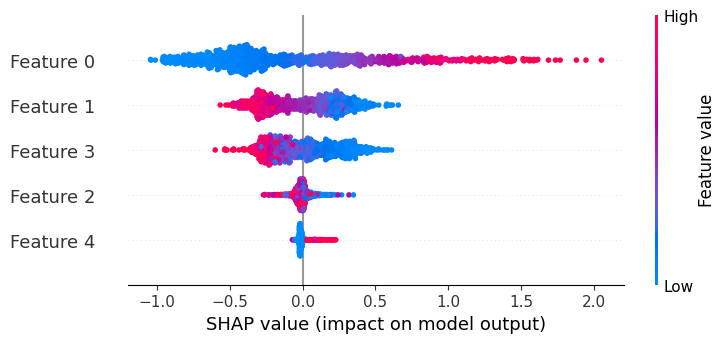

<Figure size 640x480 with 0 Axes>

In [66]:
# SHAP değerlerini görselleştirin
shap.plots.beeswarm(shap_values)

# Görseli kaydedin
plt.savefig('shap_values_beeswarm2.png', format='png')

# Görseli gösterin (isteğe bağlı)
plt.show()

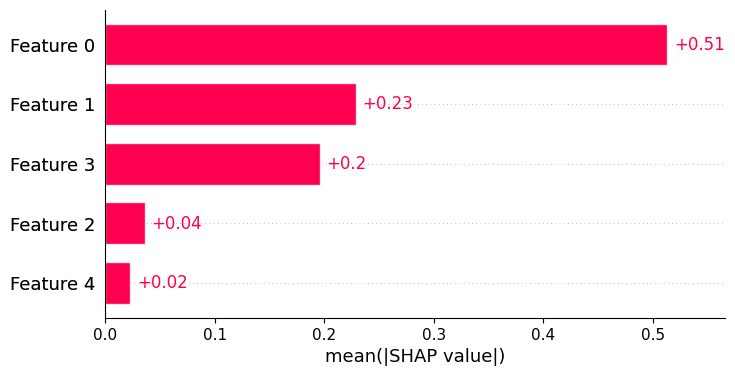

<Figure size 640x480 with 0 Axes>

In [67]:
shap.plots.bar(shap_values)
plt.savefig('bar2.png', format='png')

In [68]:
import shap
X_sub = shap.sample(X_train, len(X_train))
explainer = shap.Explainer(model.predict, X_sub)
shap_values = explainer(X_test)

19/19 [==============================] - 0s 3ms/step


Exact explainer:   0%|          | 27/11067 [00:00<?, ?it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 29/11067 [00:10<54:48,  3.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   0%|          | 30/11067 [00:11<1:22:22,  2.23it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   0%|          | 31/11067 [00:12<1:37:33,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 32/11067 [00:12<1:26:16,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 33/11067 [00:12<1:18:51,  2.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 34/11067 [00:13<1:10:59,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 35/11067 [00:13<1:07:49,  2.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   0%|          | 36/11067 [00:13<1:14:14,  2.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   0%|          | 37/11067 [00:14<1:24:59,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 38/11067 [00:15<1:35:28,  1.93it/s]

19/19 [==============================] - 0s 7ms/step


Exact explainer:   0%|          | 39/11067 [00:16<1:59:56,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:   0%|          | 40/11067 [00:17<2:21:30,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   0%|          | 41/11067 [00:18<2:40:46,  1.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 42/11067 [00:18<2:26:47,  1.25it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   0%|          | 43/11067 [00:19<2:17:42,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   0%|          | 44/11067 [00:20<2:14:20,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   0%|          | 45/11067 [00:20<2:04:56,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 46/11067 [00:21<2:05:46,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 47/11067 [00:22<2:18:06,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 48/11067 [00:22<2:07:29,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   0%|          | 49/11067 [00:23<2:04:51,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   0%|          | 50/11067 [00:24<2:06:15,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 51/11067 [00:24<1:49:49,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 52/11067 [00:24<1:34:07,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 53/11067 [00:25<1:24:48,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 54/11067 [00:25<1:15:19,  2.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   0%|          | 55/11067 [00:25<1:12:45,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 56/11067 [00:26<1:09:04,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 57/11067 [00:26<1:11:37,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 58/11067 [00:27<1:09:01,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 59/11067 [00:27<1:06:39,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 60/11067 [00:27<1:03:12,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 61/11067 [00:27<59:57,  3.06it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 62/11067 [00:28<59:02,  3.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 63/11067 [00:28<58:29,  3.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 64/11067 [00:28<58:27,  3.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 65/11067 [00:29<1:02:42,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 66/11067 [00:29<1:01:50,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 67/11067 [00:29<1:02:45,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 68/11067 [00:30<1:01:55,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 69/11067 [00:30<1:03:44,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 70/11067 [00:30<1:02:53,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 71/11067 [00:31<1:02:56,  2.91it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   1%|          | 72/11067 [00:32<1:20:52,  2.27it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   1%|          | 73/11067 [00:33<1:51:51,  1.64it/s]

19/19 [==============================] - 0s 7ms/step


Exact explainer:   1%|          | 74/11067 [00:35<3:13:36,  1.06s/it]

19/19 [==============================] - 0s 5ms/step


Exact explainer:   1%|          | 75/11067 [00:36<3:23:12,  1.11s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   1%|          | 76/11067 [00:37<3:09:45,  1.04s/it]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 77/11067 [00:38<3:13:38,  1.06s/it]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   1%|          | 78/11067 [00:38<2:51:28,  1.07it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   1%|          | 79/11067 [00:39<2:54:15,  1.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 80/11067 [00:40<2:30:40,  1.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 81/11067 [00:40<2:04:20,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 82/11067 [00:41<1:43:15,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 83/11067 [00:41<1:32:02,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 84/11067 [00:41<1:22:38,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 85/11067 [00:42<1:15:04,  2.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 86/11067 [00:42<1:11:09,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 87/11067 [00:42<1:08:37,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 88/11067 [00:43<1:08:05,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 89/11067 [00:43<1:06:15,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 90/11067 [00:44<1:13:49,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 91/11067 [00:44<1:10:04,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 92/11067 [00:44<1:08:09,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 93/11067 [00:45<1:06:06,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 94/11067 [00:45<1:04:43,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 95/11067 [00:45<1:02:56,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 96/11067 [00:46<1:03:05,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 97/11067 [00:46<1:03:19,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 98/11067 [00:46<1:01:52,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 99/11067 [00:47<1:01:26,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 100/11067 [00:47<1:00:23,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 101/11067 [00:47<1:03:32,  2.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   1%|          | 102/11067 [00:48<1:15:10,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 103/11067 [00:48<1:23:35,  2.19it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   1%|          | 104/11067 [00:49<1:22:45,  2.21it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   1%|          | 105/11067 [00:49<1:33:49,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 106/11067 [00:50<1:26:47,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 107/11067 [00:50<1:18:54,  2.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 108/11067 [00:51<1:14:33,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 109/11067 [00:51<1:09:52,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 110/11067 [00:51<1:07:24,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 111/11067 [00:52<1:07:02,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 112/11067 [00:52<1:05:18,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 113/11067 [00:52<1:13:40,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 114/11067 [00:53<1:08:22,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 115/11067 [00:53<1:05:19,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 116/11067 [00:53<1:04:30,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 117/11067 [00:54<1:02:50,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 118/11067 [00:54<1:01:41,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 119/11067 [00:54<1:02:14,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 120/11067 [00:55<1:12:52,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 121/11067 [00:55<1:10:04,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 122/11067 [00:56<1:07:10,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 123/11067 [00:56<1:06:27,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 124/11067 [00:56<1:03:41,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 125/11067 [00:57<1:13:32,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 126/11067 [00:57<1:08:54,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 127/11067 [00:57<1:06:20,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 128/11067 [00:58<1:03:26,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 129/11067 [00:58<1:02:25,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 130/11067 [00:58<1:00:36,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 131/11067 [00:59<1:01:55,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 132/11067 [00:59<1:00:49,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 133/11067 [00:59<1:01:59,  2.94it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   1%|          | 134/11067 [01:00<1:04:12,  2.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   1%|          | 135/11067 [01:00<1:15:57,  2.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   1%|          | 136/11067 [01:01<1:28:24,  2.06it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   1%|          | 137/11067 [01:02<1:37:36,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|          | 138/11067 [01:02<1:37:52,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 139/11067 [01:03<1:26:37,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 140/11067 [01:03<1:18:24,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 141/11067 [01:03<1:12:56,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 142/11067 [01:03<1:07:30,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 143/11067 [01:04<1:05:15,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 144/11067 [01:04<1:06:17,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 145/11067 [01:04<1:02:16,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 146/11067 [01:05<1:00:45,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 147/11067 [01:05<1:01:19,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 148/11067 [01:05<1:01:05,  2.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 149/11067 [01:06<1:01:38,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 150/11067 [01:06<1:02:09,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 151/11067 [01:06<1:00:59,  2.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 152/11067 [01:07<1:01:56,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 153/11067 [01:07<1:11:56,  2.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 154/11067 [01:08<1:08:51,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 155/11067 [01:08<1:05:49,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 156/11067 [01:08<1:04:30,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 157/11067 [01:09<1:04:20,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 158/11067 [01:09<1:03:07,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 159/11067 [01:09<1:06:43,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 160/11067 [01:10<1:05:49,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 161/11067 [01:10<1:04:13,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 162/11067 [01:10<1:02:55,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 163/11067 [01:11<1:00:16,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 164/11067 [01:11<59:11,  3.07it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 165/11067 [01:11<1:00:33,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   1%|▏         | 166/11067 [01:12<1:01:23,  2.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   2%|▏         | 167/11067 [01:12<1:13:32,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 168/11067 [01:13<1:15:22,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 169/11067 [01:13<1:22:52,  2.19it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   2%|▏         | 170/11067 [01:14<1:32:55,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 171/11067 [01:15<1:35:48,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 172/11067 [01:15<1:26:43,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 173/11067 [01:15<1:19:03,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 174/11067 [01:16<1:11:43,  2.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 175/11067 [01:16<1:08:57,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 176/11067 [01:16<1:07:13,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 177/11067 [01:17<1:04:34,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 178/11067 [01:17<1:01:33,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 179/11067 [01:17<1:02:00,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 180/11067 [01:18<1:00:02,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 181/11067 [01:18<59:44,  3.04it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 182/11067 [01:18<1:00:06,  3.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 183/11067 [01:19<1:00:11,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 184/11067 [01:19<59:03,  3.07it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 185/11067 [01:19<1:00:38,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 186/11067 [01:20<1:01:09,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 187/11067 [01:20<59:18,  3.06it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 188/11067 [01:20<59:01,  3.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 189/11067 [01:20<58:21,  3.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 190/11067 [01:21<1:00:25,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 191/11067 [01:21<59:20,  3.05it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 192/11067 [01:21<59:50,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 193/11067 [01:22<58:34,  3.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 194/11067 [01:22<59:36,  3.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 195/11067 [01:23<1:11:04,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 196/11067 [01:23<1:07:10,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 197/11067 [01:23<1:05:54,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 198/11067 [01:24<1:02:47,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 199/11067 [01:24<1:01:42,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 200/11067 [01:24<1:04:25,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 201/11067 [01:25<1:05:38,  2.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   2%|▏         | 202/11067 [01:25<1:13:41,  2.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   2%|▏         | 203/11067 [01:26<1:22:33,  2.19it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   2%|▏         | 204/11067 [01:26<1:29:47,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 205/11067 [01:27<1:35:22,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 206/11067 [01:27<1:25:51,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 207/11067 [01:28<1:19:06,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 208/11067 [01:28<1:13:11,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 209/11067 [01:28<1:10:16,  2.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 210/11067 [01:29<1:07:54,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 211/11067 [01:29<1:05:57,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 212/11067 [01:29<1:04:50,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 213/11067 [01:30<1:04:20,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 214/11067 [01:30<1:04:00,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 215/11067 [01:30<1:02:44,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 216/11067 [01:31<1:02:03,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 217/11067 [01:31<1:01:53,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 218/11067 [01:31<1:01:15,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 219/11067 [01:32<1:02:03,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 220/11067 [01:32<1:00:11,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 221/11067 [01:32<1:02:22,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 222/11067 [01:33<1:01:28,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 223/11067 [01:33<1:02:33,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 224/11067 [01:34<1:02:16,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 225/11067 [01:34<1:02:13,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 226/11067 [01:34<1:02:57,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 227/11067 [01:35<1:01:00,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 228/11067 [01:35<1:02:14,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 229/11067 [01:35<1:01:18,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 230/11067 [01:36<1:01:45,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 231/11067 [01:36<1:00:51,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 232/11067 [01:36<1:00:18,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 233/11067 [01:37<1:04:57,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 234/11067 [01:37<1:03:33,  2.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   2%|▏         | 235/11067 [01:38<1:17:48,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 236/11067 [01:38<1:17:40,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 237/11067 [01:39<1:30:13,  2.00it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   2%|▏         | 238/11067 [01:39<1:35:35,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 239/11067 [01:40<1:35:35,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 240/11067 [01:40<1:25:59,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 241/11067 [01:41<1:19:31,  2.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 242/11067 [01:41<1:18:17,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 243/11067 [01:41<1:13:21,  2.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 244/11067 [01:42<1:09:03,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 245/11067 [01:42<1:07:33,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 246/11067 [01:42<1:07:23,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 247/11067 [01:43<1:04:14,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 248/11067 [01:43<1:03:18,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 249/11067 [01:43<1:03:35,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 250/11067 [01:44<1:01:47,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 251/11067 [01:44<1:02:44,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 252/11067 [01:44<1:00:45,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 253/11067 [01:45<59:26,  3.03it/s]  

19/19 [==============================] - 0s 6ms/step


Exact explainer:   2%|▏         | 254/11067 [01:46<1:36:38,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 255/11067 [01:46<1:26:26,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 256/11067 [01:46<1:19:31,  2.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 257/11067 [01:47<1:13:12,  2.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 258/11067 [01:47<1:07:51,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 259/11067 [01:47<1:05:42,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 260/11067 [01:48<1:05:06,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 261/11067 [01:48<1:06:45,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 262/11067 [01:48<1:04:35,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 263/11067 [01:49<1:04:02,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 264/11067 [01:49<1:03:12,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 265/11067 [01:49<1:02:42,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 266/11067 [01:50<1:07:00,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 267/11067 [01:50<1:17:13,  2.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 268/11067 [01:51<1:24:04,  2.14it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   2%|▏         | 269/11067 [01:52<1:33:28,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 270/11067 [01:52<1:35:27,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 271/11067 [01:53<1:33:12,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 272/11067 [01:53<1:23:08,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 273/11067 [01:53<1:25:23,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 274/11067 [01:54<1:18:23,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 275/11067 [01:54<1:13:51,  2.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   2%|▏         | 276/11067 [01:55<1:10:18,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 277/11067 [01:55<1:10:03,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 278/11067 [01:55<1:07:02,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 279/11067 [01:56<1:06:21,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 280/11067 [01:56<1:04:59,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 281/11067 [01:56<1:01:45,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 282/11067 [01:57<1:09:27,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 283/11067 [01:57<1:16:06,  2.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 284/11067 [01:58<1:12:39,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 285/11067 [01:58<1:09:38,  2.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 286/11067 [01:58<1:07:41,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 287/11067 [01:59<1:05:33,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 288/11067 [01:59<1:03:15,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 289/11067 [01:59<1:01:32,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 290/11067 [02:00<1:00:31,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 291/11067 [02:00<58:53,  3.05it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 292/11067 [02:00<1:08:21,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 293/11067 [02:01<1:06:37,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 294/11067 [02:01<1:05:43,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 295/11067 [02:01<1:04:34,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 296/11067 [02:02<1:03:45,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 297/11067 [02:02<1:07:13,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 298/11067 [02:03<1:12:49,  2.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 299/11067 [02:03<1:13:56,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 300/11067 [02:04<1:13:53,  2.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   3%|▎         | 301/11067 [02:04<1:21:04,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 302/11067 [02:05<1:42:24,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 303/11067 [02:05<1:36:15,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 304/11067 [02:06<1:30:34,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 305/11067 [02:06<1:22:19,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 306/11067 [02:07<1:15:54,  2.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 307/11067 [02:07<1:13:20,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 308/11067 [02:07<1:08:47,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 309/11067 [02:08<1:07:01,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 310/11067 [02:08<1:14:16,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 311/11067 [02:08<1:10:59,  2.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 312/11067 [02:09<1:06:22,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 313/11067 [02:09<1:03:20,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 314/11067 [02:09<1:02:12,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 315/11067 [02:10<1:01:02,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 316/11067 [02:10<1:00:01,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 317/11067 [02:10<1:01:20,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 318/11067 [02:11<1:00:39,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 319/11067 [02:11<1:00:28,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 320/11067 [02:11<58:58,  3.04it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 321/11067 [02:12<58:34,  3.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 322/11067 [02:12<59:08,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 323/11067 [02:12<59:05,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 324/11067 [02:13<58:05,  3.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 325/11067 [02:13<58:45,  3.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 326/11067 [02:13<58:20,  3.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 327/11067 [02:14<57:44,  3.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 328/11067 [02:14<57:45,  3.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 329/11067 [02:14<56:56,  3.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 330/11067 [02:15<57:47,  3.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 331/11067 [02:15<1:04:37,  2.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   3%|▎         | 332/11067 [02:16<1:18:17,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 333/11067 [02:16<1:29:32,  2.00it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   3%|▎         | 334/11067 [02:17<1:34:13,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 335/11067 [02:18<1:52:00,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 336/11067 [02:18<1:35:24,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 337/11067 [02:18<1:26:18,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 338/11067 [02:19<1:27:47,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 339/11067 [02:19<1:28:22,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 340/11067 [02:20<1:19:59,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 341/11067 [02:20<1:12:54,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 342/11067 [02:21<1:18:35,  2.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 343/11067 [02:21<1:11:57,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 344/11067 [02:21<1:09:28,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 345/11067 [02:22<1:05:30,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 346/11067 [02:22<1:04:16,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 347/11067 [02:22<1:03:59,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 348/11067 [02:23<1:02:46,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 349/11067 [02:23<1:03:00,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 350/11067 [02:23<1:03:55,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 351/11067 [02:24<1:03:07,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 352/11067 [02:24<1:00:49,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 353/11067 [02:24<1:00:21,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 354/11067 [02:25<59:56,  2.98it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 355/11067 [02:25<58:14,  3.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 356/11067 [02:25<59:14,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 357/11067 [02:26<58:47,  3.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 358/11067 [02:26<58:34,  3.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 359/11067 [02:26<57:59,  3.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 360/11067 [02:27<57:48,  3.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 361/11067 [02:27<58:22,  3.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 362/11067 [02:27<59:16,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 363/11067 [02:28<1:09:34,  2.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   3%|▎         | 364/11067 [02:28<1:14:31,  2.39it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:   3%|▎         | 365/11067 [02:29<1:28:06,  2.02it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   3%|▎         | 366/11067 [02:30<1:38:18,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 367/11067 [02:30<1:37:28,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 368/11067 [02:31<1:27:48,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 369/11067 [02:31<1:19:51,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 370/11067 [02:31<1:13:38,  2.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 371/11067 [02:32<1:10:41,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 372/11067 [02:32<1:07:06,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 373/11067 [02:32<1:05:19,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 374/11067 [02:33<1:07:34,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 375/11067 [02:33<1:08:07,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 376/11067 [02:33<1:05:33,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 377/11067 [02:34<1:03:21,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 378/11067 [02:34<1:01:39,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 379/11067 [02:34<59:53,  2.97it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 380/11067 [02:35<59:30,  2.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 381/11067 [02:35<59:21,  3.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 382/11067 [02:35<1:00:54,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 383/11067 [02:36<1:01:11,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 384/11067 [02:36<1:00:57,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 385/11067 [02:36<1:00:41,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 386/11067 [02:37<1:01:36,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   3%|▎         | 387/11067 [02:37<1:02:21,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 388/11067 [02:37<1:00:51,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 389/11067 [02:38<1:01:00,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 390/11067 [02:38<1:02:06,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 391/11067 [02:39<1:02:29,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 392/11067 [02:39<1:03:36,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 393/11067 [02:39<1:12:31,  2.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   4%|▎         | 394/11067 [02:40<1:10:34,  2.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   4%|▎         | 395/11067 [02:40<1:14:28,  2.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   4%|▎         | 396/11067 [02:41<1:27:51,  2.02it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   4%|▎         | 397/11067 [02:42<1:36:10,  1.85it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   4%|▎         | 398/11067 [02:42<1:37:50,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 399/11067 [02:43<1:33:52,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 400/11067 [02:43<1:27:30,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 401/11067 [02:44<1:28:18,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 402/11067 [02:44<1:20:39,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 403/11067 [02:44<1:15:17,  2.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 404/11067 [02:45<1:09:45,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 405/11067 [02:45<1:06:50,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 406/11067 [02:45<1:05:04,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 407/11067 [02:46<1:03:01,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 408/11067 [02:46<1:01:46,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 409/11067 [02:46<1:00:43,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 410/11067 [02:47<59:41,  2.98it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 411/11067 [02:47<1:01:30,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 412/11067 [02:47<1:10:52,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 413/11067 [02:48<1:07:47,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 414/11067 [02:48<1:09:11,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▎         | 415/11067 [02:49<1:07:15,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 416/11067 [02:49<1:05:29,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 417/11067 [02:49<1:05:39,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 418/11067 [02:50<1:04:17,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 419/11067 [02:50<1:03:18,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 420/11067 [02:50<1:01:43,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 421/11067 [02:51<1:01:19,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 422/11067 [02:51<1:02:02,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 423/11067 [02:51<1:01:38,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 424/11067 [02:52<1:00:27,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 425/11067 [02:52<59:39,  2.97it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 426/11067 [02:52<1:00:27,  2.93it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   4%|▍         | 427/11067 [02:53<1:07:27,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 428/11067 [02:53<1:19:22,  2.23it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   4%|▍         | 429/11067 [02:54<1:30:17,  1.96it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   4%|▍         | 430/11067 [02:55<1:41:10,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   4%|▍         | 431/11067 [02:55<1:44:44,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   4%|▍         | 432/11067 [02:56<1:50:26,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   4%|▍         | 433/11067 [02:57<1:40:41,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   4%|▍         | 434/11067 [02:57<1:40:38,  1.76it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:   4%|▍         | 435/11067 [02:58<1:40:23,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 436/11067 [02:58<1:28:21,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 437/11067 [02:58<1:20:08,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 438/11067 [02:59<1:15:08,  2.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 439/11067 [02:59<1:11:15,  2.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 440/11067 [02:59<1:08:40,  2.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 441/11067 [03:00<1:05:49,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 442/11067 [03:00<1:04:42,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 443/11067 [03:00<1:03:11,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 444/11067 [03:01<1:02:45,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 445/11067 [03:01<1:03:03,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 446/11067 [03:02<1:01:50,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 447/11067 [03:02<1:01:17,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 448/11067 [03:02<1:10:08,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 449/11067 [03:03<1:05:34,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 450/11067 [03:03<1:03:33,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 451/11067 [03:03<1:01:35,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 452/11067 [03:04<59:59,  2.95it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 453/11067 [03:04<1:00:26,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 454/11067 [03:04<1:04:07,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 455/11067 [03:05<1:02:46,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 456/11067 [03:05<1:01:05,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 457/11067 [03:05<1:01:23,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 458/11067 [03:06<1:00:44,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 459/11067 [03:06<1:11:35,  2.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   4%|▍         | 460/11067 [03:07<1:13:42,  2.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   4%|▍         | 461/11067 [03:07<1:15:45,  2.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   4%|▍         | 462/11067 [03:08<1:21:07,  2.18it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   4%|▍         | 463/11067 [03:08<1:26:05,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 464/11067 [03:09<1:29:12,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 465/11067 [03:09<1:21:03,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 466/11067 [03:10<1:13:47,  2.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 467/11067 [03:10<1:10:02,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 468/11067 [03:10<1:08:00,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 469/11067 [03:11<1:04:53,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 470/11067 [03:11<1:02:21,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 471/11067 [03:11<1:02:01,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 472/11067 [03:12<1:01:09,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 473/11067 [03:12<1:04:39,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 474/11067 [03:12<1:04:11,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 475/11067 [03:13<1:02:18,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 476/11067 [03:13<1:02:20,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 477/11067 [03:13<1:02:30,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 478/11067 [03:14<1:01:31,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 479/11067 [03:14<1:11:17,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 480/11067 [03:15<1:07:22,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 481/11067 [03:15<1:09:28,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 482/11067 [03:15<1:06:16,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 483/11067 [03:16<1:03:36,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 484/11067 [03:16<1:03:09,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 485/11067 [03:16<1:03:03,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 486/11067 [03:17<1:01:27,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 487/11067 [03:17<59:44,  2.95it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 488/11067 [03:17<1:01:06,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 489/11067 [03:18<58:58,  2.99it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 490/11067 [03:18<59:54,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 491/11067 [03:18<1:00:59,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 492/11067 [03:19<1:00:21,  2.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 493/11067 [03:20<1:28:33,  1.99it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   4%|▍         | 494/11067 [03:20<1:36:00,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 495/11067 [03:21<1:54:55,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 496/11067 [03:21<1:37:21,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 497/11067 [03:22<1:26:14,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   4%|▍         | 498/11067 [03:22<1:19:04,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 499/11067 [03:23<1:22:29,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 500/11067 [03:23<1:16:08,  2.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 501/11067 [03:23<1:11:07,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 502/11067 [03:24<1:07:27,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 503/11067 [03:24<1:06:13,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 504/11067 [03:24<1:05:08,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 505/11067 [03:25<1:04:23,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 506/11067 [03:25<1:04:08,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 507/11067 [03:26<1:11:37,  2.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 508/11067 [03:26<1:08:56,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 509/11067 [03:26<1:15:46,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 510/11067 [03:27<1:09:57,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 511/11067 [03:27<1:06:44,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 512/11067 [03:28<1:05:12,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 513/11067 [03:28<1:03:45,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 514/11067 [03:28<1:02:06,  2.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 515/11067 [03:29<1:01:16,  2.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 516/11067 [03:29<1:00:24,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 517/11067 [03:29<59:10,  2.97it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 518/11067 [03:30<59:12,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 519/11067 [03:30<59:36,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 520/11067 [03:30<59:40,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 521/11067 [03:31<59:50,  2.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 522/11067 [03:31<59:33,  2.95it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   5%|▍         | 523/11067 [03:31<1:02:16,  2.82it/s]

19/19 [==============================] - 0s 12ms/step


Exact explainer:   5%|▍         | 524/11067 [03:33<2:28:18,  1.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 525/11067 [03:35<3:07:44,  1.07s/it]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 526/11067 [03:35<2:30:32,  1.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 527/11067 [03:36<2:04:10,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   5%|▍         | 528/11067 [03:36<1:45:53,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 529/11067 [03:36<1:37:46,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 530/11067 [03:37<1:27:57,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 531/11067 [03:37<1:21:04,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 532/11067 [03:38<1:24:09,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 533/11067 [03:38<1:16:52,  2.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 534/11067 [03:39<1:21:43,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 535/11067 [03:39<1:23:16,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 536/11067 [03:39<1:18:27,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 537/11067 [03:40<1:13:52,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 538/11067 [03:40<1:08:49,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 539/11067 [03:40<1:06:56,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 540/11067 [03:41<1:04:11,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 541/11067 [03:41<1:01:27,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 542/11067 [03:41<1:01:43,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 543/11067 [03:42<1:00:16,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 544/11067 [03:42<1:00:29,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 545/11067 [03:42<59:58,  2.92it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 546/11067 [03:43<59:14,  2.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 547/11067 [03:43<1:08:18,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 548/11067 [03:44<1:05:25,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 549/11067 [03:44<1:02:10,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 550/11067 [03:44<1:00:58,  2.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   5%|▍         | 551/11067 [03:45<1:07:32,  2.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   5%|▍         | 552/11067 [03:45<1:12:59,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▍         | 553/11067 [03:46<1:13:33,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 554/11067 [03:46<1:21:47,  2.14it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   5%|▌         | 555/11067 [03:47<1:27:33,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 556/11067 [03:47<1:30:05,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 557/11067 [03:48<1:21:27,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 558/11067 [03:48<1:18:38,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 559/11067 [03:49<1:18:07,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 560/11067 [03:49<1:12:52,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 561/11067 [03:49<1:08:28,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 562/11067 [03:50<1:05:34,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 563/11067 [03:50<1:02:28,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 564/11067 [03:50<1:10:35,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 565/11067 [03:51<1:12:48,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 566/11067 [03:51<1:07:58,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 567/11067 [03:51<1:04:38,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 568/11067 [03:52<1:03:40,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 569/11067 [03:52<1:03:13,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 570/11067 [03:53<1:06:36,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 571/11067 [03:53<1:03:32,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 572/11067 [03:53<1:02:55,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 573/11067 [03:54<1:03:14,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 574/11067 [03:54<1:09:57,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 575/11067 [03:54<1:05:08,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 576/11067 [03:55<1:03:25,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 577/11067 [03:55<1:00:15,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 578/11067 [03:55<59:52,  2.92it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 579/11067 [03:56<1:00:28,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 580/11067 [03:56<1:00:08,  2.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 581/11067 [03:57<1:03:39,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 582/11067 [03:57<1:02:29,  2.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   5%|▌         | 583/11067 [03:57<1:01:23,  2.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   5%|▌         | 584/11067 [03:58<1:17:47,  2.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 585/11067 [03:58<1:23:50,  2.08it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   5%|▌         | 586/11067 [03:59<1:30:02,  1.94it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   5%|▌         | 587/11067 [04:00<1:37:55,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 588/11067 [04:00<1:26:20,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 589/11067 [04:00<1:17:44,  2.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 590/11067 [04:01<1:12:46,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 591/11067 [04:01<1:08:40,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 592/11067 [04:01<1:05:39,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 593/11067 [04:02<1:04:15,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 594/11067 [04:02<1:12:29,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 595/11067 [04:03<1:13:17,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 596/11067 [04:03<1:09:23,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 597/11067 [04:03<1:07:17,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 598/11067 [04:04<1:04:41,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 599/11067 [04:04<1:03:58,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 600/11067 [04:04<1:02:29,  2.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 601/11067 [04:05<1:02:09,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 602/11067 [04:05<1:01:17,  2.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 603/11067 [04:05<1:00:35,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 604/11067 [04:06<1:00:02,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 605/11067 [04:06<1:00:11,  2.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 606/11067 [04:07<1:01:18,  2.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 607/11067 [04:07<1:00:34,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   5%|▌         | 608/11067 [04:07<1:04:18,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 609/11067 [04:08<1:01:42,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 610/11067 [04:08<1:00:27,  2.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 611/11067 [04:08<1:00:58,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 612/11067 [04:09<59:51,  2.91it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 613/11067 [04:09<1:02:40,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 614/11067 [04:09<1:01:50,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 615/11067 [04:10<1:00:55,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 616/11067 [04:10<1:13:45,  2.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▌         | 617/11067 [04:11<1:42:42,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▌         | 618/11067 [04:12<1:36:05,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▌         | 619/11067 [04:12<1:35:08,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 620/11067 [04:13<1:28:39,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 621/11067 [04:13<1:19:45,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 622/11067 [04:14<1:22:12,  2.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 623/11067 [04:14<1:15:09,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 624/11067 [04:14<1:20:03,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 625/11067 [04:15<1:15:29,  2.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 626/11067 [04:15<1:12:09,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 627/11067 [04:16<1:10:16,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 628/11067 [04:16<1:06:55,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 629/11067 [04:16<1:05:28,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 630/11067 [04:17<1:05:45,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 631/11067 [04:17<1:04:22,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 632/11067 [04:17<1:02:39,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 633/11067 [04:18<1:02:29,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 634/11067 [04:18<1:02:36,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 635/11067 [04:18<1:00:14,  2.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 636/11067 [04:19<1:00:44,  2.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 637/11067 [04:19<1:03:54,  2.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▌         | 638/11067 [04:19<1:02:59,  2.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 639/11067 [04:20<1:01:34,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 640/11067 [04:20<59:06,  2.94it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 641/11067 [04:20<58:49,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 642/11067 [04:21<58:18,  2.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 643/11067 [04:21<59:16,  2.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 644/11067 [04:21<58:50,  2.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 645/11067 [04:22<57:43,  3.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 646/11067 [04:22<58:25,  2.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 647/11067 [04:22<57:13,  3.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 648/11067 [04:23<1:04:06,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 649/11067 [04:24<1:50:07,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▌         | 650/11067 [04:25<1:54:04,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 651/11067 [04:25<1:50:12,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 652/11067 [04:26<1:45:05,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 653/11067 [04:26<1:34:19,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 654/11067 [04:27<1:25:54,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 655/11067 [04:27<1:19:33,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 656/11067 [04:28<1:18:02,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 657/11067 [04:28<1:23:29,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 658/11067 [04:28<1:17:54,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 659/11067 [04:29<1:14:39,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 660/11067 [04:29<1:11:20,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 661/11067 [04:30<1:08:41,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 662/11067 [04:30<1:07:00,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 663/11067 [04:30<1:04:31,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 664/11067 [04:31<1:03:45,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 665/11067 [04:31<1:04:51,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 666/11067 [04:31<1:04:04,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 667/11067 [04:32<1:04:26,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 668/11067 [04:32<1:05:21,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 669/11067 [04:33<1:06:06,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 670/11067 [04:33<1:06:30,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 671/11067 [04:33<1:05:45,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 672/11067 [04:34<1:09:49,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 673/11067 [04:34<1:17:55,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 674/11067 [04:35<1:14:08,  2.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 675/11067 [04:35<1:24:18,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 676/11067 [04:36<1:30:07,  1.92it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▌         | 677/11067 [04:37<1:38:44,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 678/11067 [04:37<1:40:54,  1.72it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:   6%|▌         | 679/11067 [04:38<1:41:41,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 680/11067 [04:38<1:42:08,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 681/11067 [04:39<1:35:01,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 682/11067 [04:39<1:24:44,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 683/11067 [04:40<1:19:54,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 684/11067 [04:40<1:14:40,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 685/11067 [04:40<1:16:21,  2.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 686/11067 [04:41<1:11:27,  2.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 687/11067 [04:41<1:17:29,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 688/11067 [04:42<1:13:33,  2.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 689/11067 [04:42<1:14:33,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 690/11067 [04:42<1:11:40,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 691/11067 [04:43<1:08:33,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 692/11067 [04:43<1:13:15,  2.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 693/11067 [04:44<1:18:07,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 694/11067 [04:44<1:22:18,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 695/11067 [04:45<1:15:17,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 696/11067 [04:45<1:12:47,  2.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 697/11067 [04:45<1:10:48,  2.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 698/11067 [04:46<1:07:45,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 699/11067 [04:46<1:05:39,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 700/11067 [04:47<1:04:19,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 701/11067 [04:47<1:05:01,  2.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▋         | 702/11067 [04:47<1:05:45,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 703/11067 [04:48<1:04:32,  2.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▋         | 704/11067 [04:48<1:07:35,  2.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   6%|▋         | 705/11067 [04:49<1:21:48,  2.11it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▋         | 706/11067 [04:49<1:28:47,  1.94it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▋         | 707/11067 [04:50<1:37:15,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▋         | 708/11067 [04:51<1:43:36,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 709/11067 [04:51<1:29:55,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 710/11067 [04:51<1:21:39,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 711/11067 [04:52<1:18:03,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 712/11067 [04:52<1:14:04,  2.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 713/11067 [04:53<1:19:18,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 714/11067 [04:53<1:12:38,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 715/11067 [04:53<1:09:46,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 716/11067 [04:54<1:09:38,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 717/11067 [04:54<1:08:37,  2.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   6%|▋         | 718/11067 [04:55<1:10:52,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   6%|▋         | 719/11067 [04:55<1:06:35,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 720/11067 [04:55<1:06:07,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 721/11067 [04:56<1:04:44,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 722/11067 [04:56<1:07:16,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 723/11067 [04:57<1:05:44,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 724/11067 [04:57<1:06:07,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 725/11067 [04:57<1:05:33,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 726/11067 [04:58<1:04:41,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 727/11067 [04:58<1:12:13,  2.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 728/11067 [04:59<1:09:21,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 729/11067 [04:59<1:16:15,  2.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 730/11067 [04:59<1:11:33,  2.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   7%|▋         | 731/11067 [05:00<1:12:31,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 732/11067 [05:00<1:09:12,  2.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 733/11067 [05:01<1:06:03,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 734/11067 [05:01<1:15:51,  2.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 735/11067 [05:02<1:23:55,  2.05it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   7%|▋         | 736/11067 [05:02<1:32:12,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 737/11067 [05:03<1:51:36,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 738/11067 [05:04<1:35:19,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 739/11067 [05:04<1:25:50,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 740/11067 [05:04<1:18:39,  2.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 741/11067 [05:05<1:12:39,  2.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 742/11067 [05:05<1:09:03,  2.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 743/11067 [05:05<1:07:01,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 744/11067 [05:06<1:07:02,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 745/11067 [05:06<1:13:24,  2.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 746/11067 [05:07<1:08:12,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 747/11067 [05:07<1:05:55,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 748/11067 [05:07<1:04:40,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 749/11067 [05:08<1:03:23,  2.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   7%|▋         | 750/11067 [05:08<1:02:31,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 751/11067 [05:08<1:01:59,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 752/11067 [05:09<1:02:02,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 753/11067 [05:09<1:02:40,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 754/11067 [05:10<1:02:43,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 755/11067 [05:10<1:01:08,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 756/11067 [05:10<1:01:45,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 757/11067 [05:11<1:00:59,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 758/11067 [05:11<1:01:02,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 759/11067 [05:11<1:08:23,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 760/11067 [05:12<1:06:20,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 761/11067 [05:12<1:04:08,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 762/11067 [05:12<1:03:44,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 763/11067 [05:13<1:01:17,  2.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 764/11067 [05:13<1:01:02,  2.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   7%|▋         | 765/11067 [05:14<1:12:22,  2.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   7%|▋         | 766/11067 [05:14<1:18:31,  2.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 767/11067 [05:15<1:23:31,  2.06it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   7%|▋         | 768/11067 [05:16<1:33:07,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   7%|▋         | 769/11067 [05:16<1:33:59,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 770/11067 [05:16<1:25:47,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 771/11067 [05:17<1:17:34,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 772/11067 [05:17<1:13:04,  2.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 773/11067 [05:18<1:09:45,  2.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 774/11067 [05:18<1:07:08,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 775/11067 [05:18<1:04:09,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 776/11067 [05:19<1:11:14,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 777/11067 [05:19<1:09:10,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 778/11067 [05:19<1:06:47,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 779/11067 [05:20<1:03:58,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 780/11067 [05:20<1:02:19,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 781/11067 [05:20<1:02:20,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 782/11067 [05:21<1:00:54,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 783/11067 [05:21<1:00:49,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 784/11067 [05:22<1:09:39,  2.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 785/11067 [05:22<1:07:20,  2.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 786/11067 [05:23<1:14:57,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 787/11067 [05:23<1:19:21,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 788/11067 [05:23<1:13:32,  2.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 789/11067 [05:24<1:09:49,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 790/11067 [05:24<1:08:10,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 791/11067 [05:25<1:05:07,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 792/11067 [05:25<1:03:04,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 793/11067 [05:25<1:05:00,  2.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   7%|▋         | 794/11067 [05:26<1:08:15,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 795/11067 [05:26<1:06:48,  2.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   7%|▋         | 796/11067 [05:27<1:14:43,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 797/11067 [05:27<1:22:31,  2.07it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   7%|▋         | 798/11067 [05:28<1:32:22,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   7%|▋         | 799/11067 [05:29<1:36:14,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   7%|▋         | 800/11067 [05:29<1:41:06,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 801/11067 [05:30<1:27:56,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 802/11067 [05:30<1:20:23,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 803/11067 [05:30<1:13:16,  2.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 804/11067 [05:31<1:08:31,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 805/11067 [05:31<1:06:44,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 806/11067 [05:31<1:05:25,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 807/11067 [05:32<1:02:44,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 808/11067 [05:32<1:10:12,  2.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 809/11067 [05:32<1:07:08,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 810/11067 [05:33<1:05:20,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 811/11067 [05:33<1:04:37,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 812/11067 [05:34<1:03:11,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 813/11067 [05:34<1:02:38,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 814/11067 [05:34<1:02:43,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 815/11067 [05:35<1:02:12,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 816/11067 [05:35<1:07:05,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 817/11067 [05:35<1:05:17,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 818/11067 [05:36<1:03:51,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 819/11067 [05:36<1:02:47,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 820/11067 [05:37<1:06:41,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 821/11067 [05:37<1:04:42,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 822/11067 [05:37<1:03:10,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 823/11067 [05:38<1:01:40,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 824/11067 [05:38<1:00:42,  2.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 825/11067 [05:38<59:56,  2.85it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 826/11067 [05:39<59:54,  2.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   7%|▋         | 827/11067 [05:39<1:04:00,  2.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   7%|▋         | 828/11067 [05:40<1:16:06,  2.24it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   7%|▋         | 829/11067 [05:41<1:42:58,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   7%|▋         | 830/11067 [05:41<1:35:24,  1.79it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   8%|▊         | 831/11067 [05:42<1:37:00,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 832/11067 [05:42<1:26:06,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 833/11067 [05:43<1:27:02,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 834/11067 [05:43<1:17:07,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 835/11067 [05:43<1:10:48,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 836/11067 [05:44<1:06:57,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 837/11067 [05:44<1:05:58,  2.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 838/11067 [05:44<1:03:28,  2.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 839/11067 [05:45<1:06:53,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 840/11067 [05:45<1:04:05,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 841/11067 [05:45<1:02:20,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 842/11067 [05:46<1:02:22,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 843/11067 [05:46<1:02:26,  2.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 844/11067 [05:47<1:02:56,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 845/11067 [05:47<1:10:28,  2.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 846/11067 [05:47<1:08:01,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 847/11067 [05:48<1:04:56,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 848/11067 [05:48<1:02:54,  2.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 849/11067 [05:48<1:01:50,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 850/11067 [05:49<1:02:08,  2.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 851/11067 [05:49<1:02:06,  2.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   8%|▊         | 852/11067 [05:50<1:05:59,  2.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 853/11067 [05:50<1:04:12,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 854/11067 [05:50<1:01:59,  2.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 855/11067 [05:51<1:01:29,  2.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 856/11067 [05:51<1:00:26,  2.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 857/11067 [05:51<59:44,  2.85it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 858/11067 [05:52<59:06,  2.88it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   8%|▊         | 859/11067 [05:52<1:12:19,  2.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   8%|▊         | 860/11067 [05:53<1:19:34,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 861/11067 [05:53<1:19:11,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 862/11067 [05:54<1:25:06,  2.00it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:   8%|▊         | 863/11067 [05:55<1:31:50,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 864/11067 [05:55<1:32:05,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 865/11067 [05:56<1:31:24,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 866/11067 [05:56<1:30:09,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 867/11067 [05:57<1:21:23,  2.09it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   8%|▊         | 868/11067 [05:57<1:18:17,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 869/11067 [05:57<1:12:18,  2.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 870/11067 [05:58<1:14:20,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 871/11067 [05:58<1:10:24,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 872/11067 [05:58<1:07:18,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 873/11067 [05:59<1:05:08,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 874/11067 [05:59<1:12:23,  2.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 875/11067 [06:00<1:07:46,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 876/11067 [06:00<1:13:49,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 877/11067 [06:01<1:09:24,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 878/11067 [06:01<1:06:10,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 879/11067 [06:01<1:05:18,  2.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 880/11067 [06:02<1:02:25,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 881/11067 [06:02<59:59,  2.83it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 882/11067 [06:02<1:08:38,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 883/11067 [06:03<1:06:06,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 884/11067 [06:03<1:13:06,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 885/11067 [06:04<1:07:43,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 886/11067 [06:04<1:05:02,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 887/11067 [06:04<1:12:02,  2.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   8%|▊         | 888/11067 [06:05<1:13:37,  2.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   8%|▊         | 889/11067 [06:05<1:17:44,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 890/11067 [06:06<1:17:14,  2.20it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   8%|▊         | 891/11067 [06:06<1:20:13,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 892/11067 [06:07<1:42:22,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 893/11067 [06:08<1:39:25,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 894/11067 [06:08<1:27:22,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 895/11067 [06:09<1:22:39,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 896/11067 [06:09<1:14:17,  2.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 897/11067 [06:09<1:11:51,  2.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 898/11067 [06:10<1:13:31,  2.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 899/11067 [06:10<1:09:06,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 900/11067 [06:11<1:14:22,  2.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 901/11067 [06:11<1:08:46,  2.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 902/11067 [06:11<1:10:08,  2.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 903/11067 [06:12<1:15:35,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 904/11067 [06:12<1:10:34,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 905/11067 [06:13<1:07:13,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 906/11067 [06:13<1:04:44,  2.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 907/11067 [06:13<1:03:13,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 908/11067 [06:14<1:02:46,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 909/11067 [06:14<1:07:24,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 910/11067 [06:15<1:10:45,  2.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 911/11067 [06:15<1:16:11,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 912/11067 [06:16<1:12:22,  2.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 913/11067 [06:16<1:16:40,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 914/11067 [06:16<1:11:47,  2.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 915/11067 [06:17<1:08:14,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 916/11067 [06:17<1:13:40,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 917/11067 [06:18<1:08:38,  2.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   8%|▊         | 918/11067 [06:18<1:14:26,  2.27it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   8%|▊         | 919/11067 [06:19<1:18:40,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 920/11067 [06:19<1:24:32,  2.00it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   8%|▊         | 921/11067 [06:20<1:33:43,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   8%|▊         | 922/11067 [06:21<1:35:45,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 923/11067 [06:21<1:33:23,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 924/11067 [06:21<1:22:53,  2.04it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   8%|▊         | 925/11067 [06:22<1:15:33,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 926/11067 [06:22<1:11:09,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 927/11067 [06:22<1:07:53,  2.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 928/11067 [06:23<1:06:20,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 929/11067 [06:23<1:04:00,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 930/11067 [06:24<1:02:58,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 931/11067 [06:24<1:00:41,  2.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 932/11067 [06:24<59:40,  2.83it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 933/11067 [06:25<1:07:47,  2.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 934/11067 [06:25<1:05:54,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 935/11067 [06:26<1:13:18,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 936/11067 [06:26<1:10:10,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 937/11067 [06:27<1:15:30,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 938/11067 [06:27<1:15:03,  2.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 939/11067 [06:27<1:10:50,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 940/11067 [06:28<1:07:32,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 941/11067 [06:28<1:05:26,  2.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 942/11067 [06:28<1:04:14,  2.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 943/11067 [06:29<1:01:58,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 944/11067 [06:29<1:10:46,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 945/11067 [06:30<1:07:56,  2.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▊         | 946/11067 [06:30<1:09:47,  2.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 947/11067 [06:30<1:06:57,  2.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 948/11067 [06:31<1:15:11,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 949/11067 [06:32<1:23:00,  2.03it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▊         | 950/11067 [06:32<1:31:51,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▊         | 951/11067 [06:33<1:38:09,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 952/11067 [06:33<1:36:05,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 953/11067 [06:34<1:24:34,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 954/11067 [06:34<1:17:55,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 955/11067 [06:35<1:11:45,  2.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 956/11067 [06:35<1:08:14,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 957/11067 [06:35<1:05:48,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 958/11067 [06:36<1:04:28,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 959/11067 [06:36<1:02:48,  2.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▊         | 960/11067 [06:36<1:01:59,  2.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 961/11067 [06:37<1:02:16,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 962/11067 [06:37<1:10:02,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 963/11067 [06:38<1:16:33,  2.20it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   9%|▊         | 964/11067 [06:38<1:24:29,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 965/11067 [06:39<1:19:00,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 966/11067 [06:39<1:22:15,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▊         | 967/11067 [06:40<1:18:52,  2.13it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▊         | 968/11067 [06:40<1:22:53,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 969/11067 [06:41<1:24:21,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 970/11067 [06:41<1:17:59,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 971/11067 [06:42<1:19:10,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 972/11067 [06:42<1:21:30,  2.06it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 973/11067 [06:43<1:25:04,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 974/11067 [06:43<1:26:07,  1.95it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   9%|▉         | 975/11067 [06:44<1:32:57,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 976/11067 [06:44<1:30:26,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 977/11067 [06:45<1:32:35,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 978/11067 [06:46<1:53:51,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 979/11067 [06:47<1:48:26,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 980/11067 [06:47<1:33:42,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 981/11067 [06:47<1:21:52,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 982/11067 [06:48<1:15:38,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 983/11067 [06:48<1:18:34,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 984/11067 [06:49<1:21:26,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 985/11067 [06:49<1:25:42,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 986/11067 [06:50<1:21:15,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 987/11067 [06:50<1:23:55,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 988/11067 [06:50<1:16:25,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 989/11067 [06:51<1:11:01,  2.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 990/11067 [06:51<1:15:40,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 991/11067 [06:52<1:10:30,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 992/11067 [06:52<1:07:16,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 993/11067 [06:52<1:04:54,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 994/11067 [06:53<1:03:06,  2.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 995/11067 [06:53<1:10:10,  2.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 996/11067 [06:54<1:07:29,  2.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 997/11067 [06:54<1:05:46,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 998/11067 [06:54<1:04:24,  2.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 999/11067 [06:55<1:05:44,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1000/11067 [06:55<1:13:15,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1001/11067 [06:56<1:17:42,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1002/11067 [06:56<1:12:34,  2.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1003/11067 [06:57<1:19:07,  2.12it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 1004/11067 [06:57<1:22:07,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1005/11067 [06:58<1:24:58,  1.97it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 1006/11067 [06:58<1:29:25,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 1007/11067 [06:59<1:29:49,  1.87it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   9%|▉         | 1008/11067 [07:00<1:36:27,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1009/11067 [07:00<1:34:08,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1010/11067 [07:01<1:25:52,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1011/11067 [07:01<1:24:11,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1012/11067 [07:02<1:26:05,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1013/11067 [07:02<1:18:57,  2.12it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 1014/11067 [07:02<1:18:13,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1015/11067 [07:03<1:12:50,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1016/11067 [07:03<1:08:17,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1017/11067 [07:04<1:13:15,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1018/11067 [07:04<1:08:54,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1019/11067 [07:04<1:11:25,  2.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1020/11067 [07:05<1:07:58,  2.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1021/11067 [07:05<1:04:41,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1022/11067 [07:05<1:03:20,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1023/11067 [07:06<1:10:39,  2.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 1024/11067 [07:06<1:12:14,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1025/11067 [07:07<1:16:54,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1026/11067 [07:08<1:20:37,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1027/11067 [07:08<1:13:54,  2.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1028/11067 [07:08<1:10:01,  2.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1029/11067 [07:09<1:06:52,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1030/11067 [07:09<1:04:38,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1031/11067 [07:09<1:03:01,  2.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 1032/11067 [07:10<1:16:05,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1033/11067 [07:11<1:28:46,  1.88it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   9%|▉         | 1034/11067 [07:11<1:30:47,  1.84it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:   9%|▉         | 1035/11067 [07:12<1:38:12,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 1036/11067 [07:13<1:45:02,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   9%|▉         | 1037/11067 [07:13<1:52:34,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   9%|▉         | 1038/11067 [07:14<1:53:32,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1039/11067 [07:15<1:49:00,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 1040/11067 [07:15<1:55:17,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1041/11067 [07:16<1:38:41,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1042/11067 [07:16<1:35:23,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1043/11067 [07:17<1:30:27,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1044/11067 [07:17<1:21:54,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1045/11067 [07:18<1:22:03,  2.04it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:   9%|▉         | 1046/11067 [07:18<1:20:10,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1047/11067 [07:19<1:23:30,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1048/11067 [07:19<1:24:52,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1049/11067 [07:20<1:25:12,  1.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:   9%|▉         | 1050/11067 [07:20<1:21:52,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:   9%|▉         | 1051/11067 [07:21<1:23:53,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1052/11067 [07:21<1:21:26,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1053/11067 [07:22<1:27:22,  1.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 1054/11067 [07:22<1:19:23,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1055/11067 [07:23<1:22:17,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1056/11067 [07:23<1:21:43,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1057/11067 [07:24<1:17:18,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1058/11067 [07:24<1:13:16,  2.28it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  10%|▉         | 1059/11067 [07:25<1:23:30,  2.00it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  10%|▉         | 1060/11067 [07:26<1:45:43,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  10%|▉         | 1061/11067 [07:26<1:46:47,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 1062/11067 [07:27<1:44:49,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1063/11067 [07:27<1:41:10,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1064/11067 [07:28<1:29:35,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1065/11067 [07:28<1:21:21,  2.05it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 1066/11067 [07:28<1:14:45,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1067/11067 [07:29<1:18:17,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1068/11067 [07:29<1:18:50,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1069/11067 [07:30<1:15:09,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1070/11067 [07:30<1:19:39,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1071/11067 [07:31<1:14:43,  2.23it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 1072/11067 [07:31<1:22:54,  2.01it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 1073/11067 [07:32<1:20:41,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1074/11067 [07:32<1:14:54,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1075/11067 [07:33<1:18:39,  2.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1076/11067 [07:33<1:20:47,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1077/11067 [07:34<1:18:05,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1078/11067 [07:34<1:19:32,  2.09it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 1079/11067 [07:35<1:18:20,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1080/11067 [07:35<1:20:11,  2.08it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 1081/11067 [07:36<1:26:49,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1082/11067 [07:36<1:26:45,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1083/11067 [07:37<1:18:46,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1084/11067 [07:37<1:14:03,  2.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1085/11067 [07:38<1:20:28,  2.07it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 1086/11067 [07:38<1:22:04,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1087/11067 [07:39<1:18:53,  2.11it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 1088/11067 [07:39<1:24:38,  1.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 1089/11067 [07:40<1:30:57,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1090/11067 [07:40<1:30:11,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 1091/11067 [07:41<1:26:09,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1092/11067 [07:41<1:18:28,  2.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1093/11067 [07:42<1:25:16,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1094/11067 [07:42<1:18:27,  2.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1095/11067 [07:42<1:12:44,  2.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1096/11067 [07:43<1:13:52,  2.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1097/11067 [07:44<1:22:23,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1098/11067 [07:44<1:24:13,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1099/11067 [07:44<1:16:42,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1100/11067 [07:45<1:10:49,  2.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1101/11067 [07:45<1:07:07,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1102/11067 [07:46<1:12:10,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1103/11067 [07:46<1:17:25,  2.14it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 1104/11067 [07:47<1:24:43,  1.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|▉         | 1105/11067 [07:47<1:23:14,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|▉         | 1106/11067 [07:48<1:24:21,  1.97it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|█         | 1107/11067 [07:48<1:17:45,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1108/11067 [07:49<1:20:14,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1109/11067 [07:49<1:13:29,  2.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1110/11067 [07:49<1:10:22,  2.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1111/11067 [07:50<1:06:19,  2.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1112/11067 [07:50<1:04:02,  2.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1113/11067 [07:51<1:08:15,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1114/11067 [07:51<1:16:27,  2.17it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  10%|█         | 1115/11067 [07:52<1:17:51,  2.13it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  10%|█         | 1116/11067 [07:52<1:26:51,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1117/11067 [07:53<1:31:33,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1118/11067 [07:53<1:32:23,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1119/11067 [07:54<1:24:09,  1.97it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|█         | 1120/11067 [07:54<1:25:31,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1121/11067 [07:55<1:26:15,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1122/11067 [07:55<1:17:52,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1123/11067 [07:56<1:20:41,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1124/11067 [07:56<1:22:05,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1125/11067 [07:57<1:23:47,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1126/11067 [07:57<1:24:18,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1127/11067 [07:58<1:25:13,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1128/11067 [07:58<1:17:43,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1129/11067 [07:59<1:20:24,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1130/11067 [07:59<1:22:23,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1131/11067 [08:00<1:23:33,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1132/11067 [08:00<1:23:55,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1133/11067 [08:01<1:15:54,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1134/11067 [08:01<1:10:36,  2.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1135/11067 [08:01<1:06:54,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1136/11067 [08:02<1:04:34,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1137/11067 [08:02<1:02:38,  2.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1138/11067 [08:02<1:01:16,  2.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1139/11067 [08:03<1:07:58,  2.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|█         | 1140/11067 [08:03<1:14:27,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1141/11067 [08:04<1:15:51,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1142/11067 [08:05<1:22:25,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1143/11067 [08:05<1:21:08,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1144/11067 [08:06<1:24:27,  1.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|█         | 1145/11067 [08:06<1:29:15,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1146/11067 [08:07<1:29:56,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1147/11067 [08:07<1:28:37,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1148/11067 [08:08<1:27:18,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1149/11067 [08:08<1:20:16,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1150/11067 [08:09<1:14:13,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1151/11067 [08:09<1:15:08,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1152/11067 [08:09<1:09:52,  2.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1153/11067 [08:10<1:05:43,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1154/11067 [08:10<1:04:43,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1155/11067 [08:11<1:16:01,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1156/11067 [08:11<1:19:22,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1157/11067 [08:12<1:20:22,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1158/11067 [08:12<1:26:05,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1159/11067 [08:13<1:23:13,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1160/11067 [08:13<1:16:33,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 1161/11067 [08:14<1:22:53,  1.99it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  10%|█         | 1162/11067 [08:14<1:18:44,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1163/11067 [08:15<1:12:44,  2.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1164/11067 [08:15<1:09:09,  2.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1165/11067 [08:15<1:14:06,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1166/11067 [08:16<1:08:39,  2.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1167/11067 [08:16<1:17:34,  2.13it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  11%|█         | 1168/11067 [08:17<1:19:44,  2.07it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  11%|█         | 1169/11067 [08:18<1:28:25,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  11%|█         | 1170/11067 [08:18<1:32:16,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1171/11067 [08:19<1:32:17,  1.79it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  11%|█         | 1172/11067 [08:19<1:36:17,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1173/11067 [08:20<1:35:08,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1174/11067 [08:20<1:32:40,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1175/11067 [08:21<1:22:00,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1176/11067 [08:21<1:22:57,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1177/11067 [08:22<1:16:23,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1178/11067 [08:22<1:18:59,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1179/11067 [08:23<1:16:55,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1180/11067 [08:23<1:23:14,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1181/11067 [08:24<1:23:26,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1182/11067 [08:24<1:16:20,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1183/11067 [08:24<1:10:30,  2.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1184/11067 [08:25<1:07:39,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1185/11067 [08:25<1:04:13,  2.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1186/11067 [08:25<1:01:24,  2.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1187/11067 [08:26<1:09:18,  2.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1188/11067 [08:26<1:06:29,  2.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1189/11067 [08:27<1:11:45,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1190/11067 [08:27<1:15:34,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1191/11067 [08:28<1:18:20,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1192/11067 [08:28<1:11:42,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1193/11067 [08:29<1:15:16,  2.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1194/11067 [08:29<1:22:27,  2.00it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  11%|█         | 1195/11067 [08:30<1:19:10,  2.08it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  11%|█         | 1196/11067 [08:30<1:24:59,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1197/11067 [08:31<1:20:56,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1198/11067 [08:31<1:28:34,  1.86it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  11%|█         | 1199/11067 [08:32<1:32:59,  1.77it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  11%|█         | 1200/11067 [08:33<1:38:50,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1201/11067 [08:33<1:31:03,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1202/11067 [08:34<1:29:11,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1203/11067 [08:34<1:20:25,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1204/11067 [08:34<1:14:06,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1205/11067 [08:35<1:09:54,  2.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  11%|█         | 1206/11067 [08:35<1:07:44,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1207/11067 [08:36<1:04:31,  2.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1208/11067 [08:36<1:01:53,  2.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1209/11067 [08:36<1:01:30,  2.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1210/11067 [08:37<1:08:40,  2.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1211/11067 [08:37<1:06:30,  2.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1212/11067 [08:38<1:07:43,  2.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1213/11067 [08:38<1:08:39,  2.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1214/11067 [08:39<1:13:35,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1215/11067 [08:39<1:17:56,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1216/11067 [08:40<1:23:47,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1217/11067 [08:40<1:15:14,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1218/11067 [08:40<1:15:20,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1219/11067 [08:41<1:15:31,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1220/11067 [08:41<1:18:15,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1221/11067 [08:42<1:20:00,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1222/11067 [08:42<1:14:33,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1223/11067 [08:43<1:13:40,  2.23it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  11%|█         | 1224/11067 [08:43<1:15:32,  2.17it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  11%|█         | 1225/11067 [08:44<1:21:07,  2.02it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  11%|█         | 1226/11067 [08:44<1:27:52,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  11%|█         | 1227/11067 [08:45<1:30:58,  1.80it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  11%|█         | 1228/11067 [08:46<1:38:05,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1229/11067 [08:46<1:35:36,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1230/11067 [08:47<1:33:00,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1231/11067 [08:47<1:34:52,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1232/11067 [08:48<1:24:49,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1233/11067 [08:48<1:18:53,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1234/11067 [08:49<1:20:58,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1235/11067 [08:49<1:22:18,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1236/11067 [08:50<1:16:45,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1237/11067 [08:50<1:24:04,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1238/11067 [08:51<1:24:09,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1239/11067 [08:51<1:16:48,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1240/11067 [08:52<1:11:06,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1241/11067 [08:52<1:19:43,  2.05it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  11%|█         | 1242/11067 [08:53<1:26:15,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1243/11067 [08:53<1:25:39,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1244/11067 [08:54<1:20:41,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█         | 1245/11067 [08:54<1:13:47,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1246/11067 [08:54<1:10:50,  2.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1247/11067 [08:55<1:15:22,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1248/11067 [08:55<1:15:49,  2.16it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  11%|█▏        | 1249/11067 [08:56<1:23:03,  1.97it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  11%|█▏        | 1250/11067 [08:57<1:27:58,  1.86it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  11%|█▏        | 1251/11067 [08:57<1:26:17,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1252/11067 [08:58<1:28:08,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  11%|█▏        | 1253/11067 [08:58<1:33:54,  1.74it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  11%|█▏        | 1254/11067 [08:59<1:38:09,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1255/11067 [09:00<1:36:12,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  11%|█▏        | 1256/11067 [09:00<1:32:50,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1257/11067 [09:00<1:22:21,  1.99it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  11%|█▏        | 1258/11067 [09:01<1:27:14,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1259/11067 [09:02<1:26:32,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1260/11067 [09:02<1:26:29,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1261/11067 [09:02<1:19:07,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1262/11067 [09:03<1:20:45,  2.02it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  11%|█▏        | 1263/11067 [09:04<1:22:46,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1264/11067 [09:04<1:15:42,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1265/11067 [09:04<1:18:57,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1266/11067 [09:05<1:13:39,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1267/11067 [09:05<1:16:27,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1268/11067 [09:06<1:19:01,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1269/11067 [09:06<1:13:41,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1270/11067 [09:07<1:15:58,  2.15it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  11%|█▏        | 1271/11067 [09:07<1:23:30,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  11%|█▏        | 1272/11067 [09:08<1:29:16,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1273/11067 [09:09<1:34:17,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1274/11067 [09:09<1:32:15,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1275/11067 [09:10<1:36:23,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1276/11067 [09:10<1:36:08,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1277/11067 [09:11<1:34:34,  1.73it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  12%|█▏        | 1278/11067 [09:12<1:36:36,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  12%|█▏        | 1279/11067 [09:12<1:39:50,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1280/11067 [09:13<1:31:33,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1281/11067 [09:13<1:27:30,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1282/11067 [09:14<1:24:42,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1283/11067 [09:14<1:21:51,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1284/11067 [09:14<1:16:21,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1285/11067 [09:15<1:18:44,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1286/11067 [09:16<1:21:21,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1287/11067 [09:16<1:23:10,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1288/11067 [09:16<1:16:40,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1289/11067 [09:17<1:11:12,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1290/11067 [09:17<1:08:00,  2.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1291/11067 [09:18<1:13:34,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1292/11067 [09:18<1:11:08,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1293/11067 [09:19<1:14:11,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1294/11067 [09:20<1:38:40,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1295/11067 [09:20<1:34:33,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1296/11067 [09:21<1:32:50,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1297/11067 [09:21<1:34:44,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1298/11067 [09:22<1:25:58,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1299/11067 [09:22<1:29:46,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1300/11067 [09:23<1:30:24,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1301/11067 [09:23<1:35:10,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1302/11067 [09:24<1:33:56,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1303/11067 [09:25<1:30:26,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1304/11067 [09:25<1:36:18,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1305/11067 [09:26<1:33:41,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1306/11067 [09:26<1:31:08,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1307/11067 [09:27<1:21:57,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1308/11067 [09:27<1:23:05,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1309/11067 [09:28<1:24:13,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1310/11067 [09:28<1:18:26,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1311/11067 [09:28<1:11:41,  2.27it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1312/11067 [09:29<1:16:54,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1313/11067 [09:30<1:23:34,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1314/11067 [09:30<1:23:36,  1.94it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1315/11067 [09:31<1:44:14,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1316/11067 [09:31<1:31:20,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1317/11067 [09:32<1:23:14,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1318/11067 [09:32<1:21:56,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1319/11067 [09:33<1:18:45,  2.06it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1320/11067 [09:33<1:24:12,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1321/11067 [09:34<1:16:18,  2.13it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1322/11067 [09:34<1:15:50,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1323/11067 [09:35<1:11:45,  2.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1324/11067 [09:35<1:15:35,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1325/11067 [09:35<1:12:55,  2.23it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1326/11067 [09:36<1:17:16,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1327/11067 [09:37<1:22:33,  1.97it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1328/11067 [09:37<1:30:16,  1.80it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  12%|█▏        | 1329/11067 [09:38<1:34:50,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  12%|█▏        | 1330/11067 [09:39<1:39:10,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1331/11067 [09:39<1:35:44,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1332/11067 [09:40<1:32:14,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1333/11067 [09:40<1:22:00,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1334/11067 [09:40<1:20:16,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1335/11067 [09:41<1:21:18,  1.99it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1336/11067 [09:42<1:27:02,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1337/11067 [09:42<1:26:37,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1338/11067 [09:43<1:26:22,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1339/11067 [09:43<1:18:28,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1340/11067 [09:44<1:24:36,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1341/11067 [09:44<1:25:11,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1342/11067 [09:45<1:25:26,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1343/11067 [09:45<1:25:44,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1344/11067 [09:46<1:20:05,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1345/11067 [09:46<1:21:47,  1.98it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1346/11067 [09:47<1:23:56,  1.93it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1347/11067 [09:47<1:17:32,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1348/11067 [09:48<1:19:22,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1349/11067 [09:48<1:13:10,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1350/11067 [09:48<1:09:07,  2.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1351/11067 [09:49<1:17:04,  2.10it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1352/11067 [09:49<1:19:48,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1353/11067 [09:50<1:18:54,  2.05it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1354/11067 [09:50<1:20:52,  2.00it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1355/11067 [09:51<1:29:26,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1356/11067 [09:52<1:34:25,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1357/11067 [09:52<1:33:41,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1358/11067 [09:53<1:24:29,  1.92it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1359/11067 [09:53<1:22:56,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1360/11067 [09:54<1:15:51,  2.13it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1361/11067 [09:54<1:18:30,  2.06it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1362/11067 [09:55<1:17:40,  2.08it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1363/11067 [09:55<1:12:44,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1364/11067 [09:56<1:16:40,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1365/11067 [09:56<1:10:18,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1366/11067 [09:56<1:13:08,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1367/11067 [09:57<1:09:02,  2.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1368/11067 [09:57<1:12:41,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1369/11067 [09:58<1:15:55,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1370/11067 [09:58<1:18:28,  2.06it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1371/11067 [09:59<1:12:57,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1372/11067 [09:59<1:16:22,  2.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1373/11067 [10:00<1:18:41,  2.05it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1374/11067 [10:00<1:14:28,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1375/11067 [10:01<1:16:55,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1376/11067 [10:01<1:10:12,  2.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1377/11067 [10:01<1:14:17,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  12%|█▏        | 1378/11067 [10:02<1:10:06,  2.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1379/11067 [10:02<1:16:04,  2.12it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  12%|█▏        | 1380/11067 [10:03<1:25:22,  1.89it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  12%|█▏        | 1381/11067 [10:04<1:32:34,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  12%|█▏        | 1382/11067 [10:04<1:32:24,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  12%|█▏        | 1383/11067 [10:05<1:38:59,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1384/11067 [10:06<1:34:04,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1385/11067 [10:06<1:24:25,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1386/11067 [10:06<1:21:25,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1387/11067 [10:07<1:14:36,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1388/11067 [10:07<1:13:32,  2.19it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1389/11067 [10:08<1:20:16,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1390/11067 [10:08<1:18:03,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1391/11067 [10:09<1:23:28,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1392/11067 [10:09<1:16:01,  2.12it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1393/11067 [10:10<1:55:33,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1394/11067 [10:11<1:47:31,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1395/11067 [10:12<1:41:43,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1396/11067 [10:12<1:41:17,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1397/11067 [10:13<1:37:48,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1398/11067 [10:13<1:28:01,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1399/11067 [10:14<1:20:10,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1400/11067 [10:14<1:23:15,  1.94it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1401/11067 [10:15<1:25:28,  1.88it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  13%|█▎        | 1402/11067 [10:15<1:30:31,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  13%|█▎        | 1403/11067 [10:16<1:34:22,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1404/11067 [10:17<1:38:54,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1405/11067 [10:17<1:34:19,  1.71it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  13%|█▎        | 1406/11067 [10:18<1:39:49,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1407/11067 [10:18<1:35:01,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1408/11067 [10:19<1:28:57,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1409/11067 [10:19<1:28:44,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1410/11067 [10:20<1:20:18,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1411/11067 [10:20<1:22:28,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1412/11067 [10:21<1:16:06,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1413/11067 [10:21<1:20:43,  1.99it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1414/11067 [10:22<1:27:07,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1415/11067 [10:23<1:31:33,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1416/11067 [10:23<1:35:22,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1417/11067 [10:24<1:27:05,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1418/11067 [10:24<1:25:21,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1419/11067 [10:24<1:18:15,  2.05it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1420/11067 [10:25<1:13:55,  2.17it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1421/11067 [10:25<1:21:28,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1422/11067 [10:26<1:16:55,  2.09it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1423/11067 [10:26<1:20:07,  2.01it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1424/11067 [10:27<1:27:25,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1425/11067 [10:28<1:32:47,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1426/11067 [10:28<1:23:24,  1.93it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  13%|█▎        | 1427/11067 [10:29<1:27:53,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1428/11067 [10:29<1:32:32,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1429/11067 [10:30<1:53:09,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  13%|█▎        | 1430/11067 [10:31<1:51:15,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1431/11067 [10:32<2:03:18,  1.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1432/11067 [10:33<1:53:32,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1433/11067 [10:33<1:45:54,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1434/11067 [10:34<1:40:12,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1435/11067 [10:34<1:29:48,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1436/11067 [10:35<1:35:31,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1437/11067 [10:35<1:33:59,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1438/11067 [10:36<1:31:40,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1439/11067 [10:36<1:34:25,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1440/11067 [10:37<1:36:55,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1441/11067 [10:38<1:27:53,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1442/11067 [10:38<1:29:59,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1443/11067 [10:39<1:23:23,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1444/11067 [10:39<1:20:58,  1.98it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1445/11067 [10:40<1:22:27,  1.94it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  13%|█▎        | 1446/11067 [10:40<1:28:39,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1447/11067 [10:41<1:33:12,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1448/11067 [10:41<1:23:06,  1.93it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1449/11067 [10:42<1:30:59,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1450/11067 [10:42<1:30:39,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1451/11067 [10:43<1:29:14,  1.80it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  13%|█▎        | 1452/11067 [10:44<1:32:45,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1453/11067 [10:44<1:31:19,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  13%|█▎        | 1454/11067 [10:45<1:33:47,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1455/11067 [10:46<1:41:06,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1456/11067 [10:46<1:32:57,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1457/11067 [10:47<1:34:42,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1458/11067 [10:47<1:31:47,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1459/11067 [10:48<1:30:34,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1460/11067 [10:48<1:25:29,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1461/11067 [10:49<1:25:53,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1462/11067 [10:49<1:25:47,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1463/11067 [10:50<1:26:40,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1464/11067 [10:50<1:28:25,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1465/11067 [10:51<1:31:28,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1466/11067 [10:51<1:26:39,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1467/11067 [10:52<1:19:32,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1468/11067 [10:52<1:15:42,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1469/11067 [10:53<1:23:43,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1470/11067 [10:54<1:28:05,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1471/11067 [10:54<1:26:53,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1472/11067 [10:55<1:26:29,  1.85it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  13%|█▎        | 1473/11067 [10:55<1:30:51,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1474/11067 [10:56<1:33:43,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1475/11067 [10:56<1:34:58,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1476/11067 [10:57<1:39:51,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1477/11067 [10:58<1:35:01,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1478/11067 [10:59<1:49:54,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1479/11067 [10:59<1:43:10,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1480/11067 [11:00<1:37:37,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1481/11067 [11:00<1:27:07,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1482/11067 [11:01<1:27:09,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1483/11067 [11:01<1:25:16,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1484/11067 [11:02<1:25:36,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1485/11067 [11:02<1:18:21,  2.04it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  13%|█▎        | 1486/11067 [11:03<1:24:09,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1487/11067 [11:03<1:17:23,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1488/11067 [11:04<1:23:55,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1489/11067 [11:04<1:23:45,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1490/11067 [11:05<1:16:48,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1491/11067 [11:05<1:12:26,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1492/11067 [11:05<1:17:01,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1493/11067 [11:06<1:18:41,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 1494/11067 [11:06<1:12:16,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1495/11067 [11:07<1:11:59,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1496/11067 [11:07<1:14:51,  2.13it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▎        | 1497/11067 [11:08<1:10:04,  2.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1498/11067 [11:08<1:09:00,  2.31it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▎        | 1499/11067 [11:09<1:11:15,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1500/11067 [11:09<1:13:10,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1501/11067 [11:10<1:39:18,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  14%|█▎        | 1502/11067 [11:11<1:40:14,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▎        | 1503/11067 [11:11<1:42:49,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▎        | 1504/11067 [11:12<1:29:06,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1505/11067 [11:12<1:27:31,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1506/11067 [11:13<1:31:08,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1507/11067 [11:13<1:22:57,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1508/11067 [11:14<1:17:19,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1509/11067 [11:14<1:12:24,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1510/11067 [11:15<1:15:41,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1511/11067 [11:15<1:12:23,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1512/11067 [11:16<1:16:05,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1513/11067 [11:16<1:21:58,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1514/11067 [11:17<1:22:26,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1515/11067 [11:17<1:16:42,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1516/11067 [11:17<1:11:55,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1517/11067 [11:18<1:15:50,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1518/11067 [11:19<1:18:23,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1519/11067 [11:19<1:12:33,  2.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1520/11067 [11:19<1:17:17,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▎        | 1521/11067 [11:20<1:19:23,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1522/11067 [11:20<1:14:23,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1523/11067 [11:21<1:14:43,  2.13it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1524/11067 [11:21<1:21:28,  1.95it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1525/11067 [11:22<1:22:03,  1.94it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1526/11067 [11:23<1:25:34,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1527/11067 [11:23<1:28:48,  1.79it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1528/11067 [11:24<1:33:46,  1.70it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1529/11067 [11:25<1:40:23,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1530/11067 [11:25<1:40:31,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1531/11067 [11:26<1:36:36,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1532/11067 [11:26<1:26:32,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1533/11067 [11:27<1:26:06,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1534/11067 [11:27<1:19:07,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1535/11067 [11:27<1:12:45,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1536/11067 [11:28<1:13:51,  2.15it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  14%|█▍        | 1537/11067 [11:29<1:21:09,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1538/11067 [11:29<1:25:27,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1539/11067 [11:30<1:30:10,  1.76it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1540/11067 [11:30<1:36:15,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1541/11067 [11:31<1:39:26,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1542/11067 [11:32<1:38:54,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1543/11067 [11:32<1:34:13,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1544/11067 [11:33<1:29:11,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1545/11067 [11:33<1:26:50,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1546/11067 [11:34<1:18:35,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1547/11067 [11:34<1:20:23,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1548/11067 [11:35<1:14:15,  2.14it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1549/11067 [11:35<1:24:27,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1550/11067 [11:36<1:28:52,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1551/11067 [11:37<1:33:49,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1552/11067 [11:37<1:38:52,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1553/11067 [11:38<1:48:35,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1554/11067 [11:39<1:40:41,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1555/11067 [11:39<1:33:09,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1556/11067 [11:40<1:27:53,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1557/11067 [11:40<1:23:11,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1558/11067 [11:41<1:21:47,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1559/11067 [11:41<1:22:12,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1560/11067 [11:42<1:22:59,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1561/11067 [11:42<1:26:43,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1562/11067 [11:43<1:30:19,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1563/11067 [11:43<1:27:53,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1564/11067 [11:44<1:26:39,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1565/11067 [11:44<1:19:45,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1566/11067 [11:45<1:20:29,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1567/11067 [11:45<1:21:47,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1568/11067 [11:46<1:22:14,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1569/11067 [11:46<1:14:36,  2.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1570/11067 [11:47<1:10:34,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1571/11067 [11:47<1:06:43,  2.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1572/11067 [11:48<1:15:41,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1573/11067 [11:48<1:10:28,  2.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1574/11067 [11:48<1:14:37,  2.12it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1575/11067 [11:49<1:24:20,  1.88it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1576/11067 [11:50<1:24:40,  1.87it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1577/11067 [11:50<1:28:00,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1578/11067 [11:51<1:32:26,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1579/11067 [11:52<1:34:15,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1580/11067 [11:52<1:28:10,  1.79it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  14%|█▍        | 1581/11067 [11:53<1:32:36,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1582/11067 [11:54<2:03:34,  1.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1583/11067 [11:55<2:16:38,  1.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1584/11067 [11:55<2:00:38,  1.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1585/11067 [11:56<1:50:06,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1586/11067 [11:57<1:42:06,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1587/11067 [11:57<1:40:15,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1588/11067 [11:58<1:39:19,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1589/11067 [11:58<1:32:28,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1590/11067 [11:59<1:32:49,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1591/11067 [11:59<1:34:27,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1592/11067 [12:00<1:31:02,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1593/11067 [12:00<1:21:56,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1594/11067 [12:01<1:14:58,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1595/11067 [12:01<1:19:03,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1596/11067 [12:02<1:12:48,  2.17it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1597/11067 [12:02<1:21:33,  1.94it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  14%|█▍        | 1598/11067 [12:03<1:31:32,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1599/11067 [12:04<1:36:59,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1600/11067 [12:04<1:35:34,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  14%|█▍        | 1601/11067 [12:05<1:38:48,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1602/11067 [12:06<1:34:15,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1603/11067 [12:06<1:29:52,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 1604/11067 [12:07<1:29:02,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▍        | 1605/11067 [12:07<1:26:52,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1606/11067 [12:08<1:30:19,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1607/11067 [12:08<1:20:47,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1608/11067 [12:09<1:15:36,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1609/11067 [12:09<1:17:35,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1610/11067 [12:10<1:19:18,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1611/11067 [12:10<1:13:05,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1612/11067 [12:10<1:15:41,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1613/11067 [12:11<1:17:56,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1614/11067 [12:12<1:20:53,  1.95it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▍        | 1615/11067 [12:12<1:22:17,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1616/11067 [12:13<1:22:50,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1617/11067 [12:13<1:22:30,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1618/11067 [12:14<1:16:21,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1619/11067 [12:14<1:18:03,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1620/11067 [12:15<1:19:13,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1621/11067 [12:15<1:12:33,  2.17it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  15%|█▍        | 1622/11067 [12:16<1:18:39,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1623/11067 [12:16<1:22:25,  1.91it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  15%|█▍        | 1624/11067 [12:17<1:41:35,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▍        | 1625/11067 [12:18<1:42:49,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1626/11067 [12:18<1:33:53,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1627/11067 [12:19<1:31:01,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1628/11067 [12:19<1:28:30,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1629/11067 [12:20<1:26:19,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1630/11067 [12:20<1:16:44,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1631/11067 [12:21<1:18:13,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1632/11067 [12:21<1:13:28,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1633/11067 [12:22<1:20:09,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1634/11067 [12:22<1:21:38,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1635/11067 [12:23<1:14:26,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1636/11067 [12:23<1:17:31,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1637/11067 [12:24<1:22:50,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1638/11067 [12:24<1:23:19,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1639/11067 [12:25<1:15:51,  2.07it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▍        | 1640/11067 [12:25<1:18:04,  2.01it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▍        | 1641/11067 [12:26<1:19:43,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1642/11067 [12:26<1:24:17,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▍        | 1643/11067 [12:27<1:27:12,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1644/11067 [12:27<1:25:44,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▍        | 1645/11067 [12:28<1:28:47,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1646/11067 [12:29<1:25:29,  1.84it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  15%|█▍        | 1647/11067 [12:29<1:32:46,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  15%|█▍        | 1648/11067 [12:30<1:36:08,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▍        | 1649/11067 [12:31<1:39:05,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  15%|█▍        | 1650/11067 [12:31<1:39:38,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1651/11067 [12:32<1:35:19,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1652/11067 [12:32<1:31:58,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▍        | 1653/11067 [12:33<1:29:06,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1654/11067 [12:33<1:26:42,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1655/11067 [12:34<1:25:55,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▍        | 1656/11067 [12:34<1:25:10,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1657/11067 [12:35<1:24:50,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1658/11067 [12:36<1:39:17,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▍        | 1659/11067 [12:36<1:38:41,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▍        | 1660/11067 [12:37<1:33:36,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1661/11067 [12:37<1:30:27,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1662/11067 [12:38<1:27:50,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1663/11067 [12:38<1:26:27,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1664/11067 [12:39<1:26:00,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▌        | 1665/11067 [12:40<1:25:08,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1666/11067 [12:40<1:24:41,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1667/11067 [12:41<1:24:10,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1668/11067 [12:41<1:23:34,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1669/11067 [12:42<1:22:13,  1.90it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  15%|█▌        | 1670/11067 [12:42<1:28:47,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▌        | 1671/11067 [12:43<1:30:07,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  15%|█▌        | 1672/11067 [12:44<1:34:28,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  15%|█▌        | 1673/11067 [12:44<1:38:38,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1674/11067 [12:45<1:36:54,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▌        | 1675/11067 [12:45<1:33:13,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1676/11067 [12:46<1:23:23,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1677/11067 [12:46<1:26:44,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1678/11067 [12:47<1:24:53,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1679/11067 [12:47<1:24:23,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1680/11067 [12:48<1:17:01,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1681/11067 [12:48<1:11:44,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1682/11067 [12:49<1:14:05,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1683/11067 [12:49<1:17:58,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1684/11067 [12:50<1:10:57,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1685/11067 [12:50<1:07:48,  2.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1686/11067 [12:50<1:04:33,  2.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▌        | 1687/11067 [12:51<1:08:33,  2.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1688/11067 [12:51<1:06:41,  2.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1689/11067 [12:52<1:03:35,  2.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1690/11067 [12:52<1:02:18,  2.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1691/11067 [12:52<1:00:48,  2.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1692/11067 [12:53<1:11:11,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1693/11067 [12:53<1:13:02,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1694/11067 [12:54<1:07:56,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1695/11067 [12:54<1:12:47,  2.15it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▌        | 1696/11067 [12:55<1:12:28,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1697/11067 [12:55<1:19:08,  1.97it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▌        | 1698/11067 [12:56<1:27:00,  1.79it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  15%|█▌        | 1699/11067 [12:57<1:31:31,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  15%|█▌        | 1700/11067 [12:57<1:33:52,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▌        | 1701/11067 [12:58<1:33:05,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▌        | 1702/11067 [12:59<1:30:15,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1703/11067 [12:59<1:20:44,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1704/11067 [12:59<1:21:32,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1705/11067 [13:00<1:14:11,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1706/11067 [13:00<1:09:36,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1707/11067 [13:01<1:13:37,  2.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1708/11067 [13:01<1:15:54,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1709/11067 [13:02<1:19:05,  1.97it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  15%|█▌        | 1710/11067 [13:02<1:24:25,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1711/11067 [13:03<1:24:10,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1712/11067 [13:03<1:23:51,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1713/11067 [13:04<1:23:04,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1714/11067 [13:04<1:19:53,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  15%|█▌        | 1715/11067 [13:05<1:14:48,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1716/11067 [13:05<1:16:31,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1717/11067 [13:06<1:18:32,  1.98it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1718/11067 [13:07<1:24:08,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1719/11067 [13:07<1:20:09,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1720/11067 [13:08<1:22:55,  1.88it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  16%|█▌        | 1721/11067 [13:08<1:28:34,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1722/11067 [13:09<1:30:11,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1723/11067 [13:09<1:26:24,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1724/11067 [13:10<1:26:43,  1.80it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  16%|█▌        | 1725/11067 [13:11<1:48:15,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1726/11067 [13:12<1:43:51,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1727/11067 [13:12<1:37:00,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1728/11067 [13:13<1:32:43,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1729/11067 [13:13<1:29:49,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1730/11067 [13:14<1:26:06,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1731/11067 [13:14<1:25:19,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1732/11067 [13:15<1:21:46,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1733/11067 [13:15<1:21:35,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1734/11067 [13:16<1:22:06,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1735/11067 [13:16<1:21:25,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1736/11067 [13:17<1:21:15,  1.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1737/11067 [13:17<1:15:44,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1738/11067 [13:18<1:17:39,  2.00it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1739/11067 [13:18<1:16:13,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1740/11067 [13:19<1:17:47,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1741/11067 [13:19<1:20:07,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1742/11067 [13:20<1:20:31,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1743/11067 [13:20<1:18:48,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1744/11067 [13:21<1:20:43,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1745/11067 [13:21<1:21:40,  1.90it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  16%|█▌        | 1746/11067 [13:22<1:27:21,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1747/11067 [13:23<1:29:42,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  16%|█▌        | 1748/11067 [13:23<1:32:15,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1749/11067 [13:24<1:32:31,  1.68it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  16%|█▌        | 1750/11067 [13:24<1:35:58,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1751/11067 [13:25<1:37:10,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1752/11067 [13:26<1:33:05,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1753/11067 [13:26<1:30:30,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1754/11067 [13:27<1:21:26,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1755/11067 [13:27<1:14:25,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1756/11067 [13:27<1:08:19,  2.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1757/11067 [13:28<1:05:49,  2.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1758/11067 [13:28<1:10:49,  2.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1759/11067 [13:29<1:13:57,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1760/11067 [13:29<1:09:51,  2.22it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  16%|█▌        | 1761/11067 [13:30<1:08:55,  2.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1762/11067 [13:30<1:06:49,  2.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1763/11067 [13:30<1:08:42,  2.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1764/11067 [13:31<1:12:43,  2.13it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1765/11067 [13:32<1:19:16,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1766/11067 [13:32<1:19:54,  1.94it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1767/11067 [13:33<1:24:31,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1768/11067 [13:33<1:22:55,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1769/11067 [13:34<1:22:24,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1770/11067 [13:34<1:21:43,  1.90it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1771/11067 [13:35<1:21:59,  1.89it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1772/11067 [13:36<1:39:10,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1773/11067 [13:36<1:36:03,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  16%|█▌        | 1774/11067 [13:37<1:38:23,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  16%|█▌        | 1775/11067 [13:38<1:37:46,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1776/11067 [13:38<1:39:52,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1777/11067 [13:39<1:34:40,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1778/11067 [13:39<1:30:57,  1.70it/s]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  16%|█▌        | 1779/11067 [13:40<1:55:14,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1780/11067 [13:41<1:50:45,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▌        | 1781/11067 [13:42<1:44:15,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1782/11067 [13:42<1:36:21,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1783/11067 [13:43<1:25:22,  1.81it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  16%|█▌        | 1784/11067 [13:43<1:27:59,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1785/11067 [13:44<1:25:33,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1786/11067 [13:44<1:24:49,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1787/11067 [13:45<1:23:38,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1788/11067 [13:45<1:22:53,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1789/11067 [13:46<1:25:55,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1790/11067 [13:46<1:24:02,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1791/11067 [13:47<1:24:07,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1792/11067 [13:47<1:23:26,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1793/11067 [13:48<1:22:30,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1794/11067 [13:49<1:27:22,  1.77it/s]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  16%|█▌        | 1795/11067 [13:50<2:21:08,  1.09it/s]

19/19 [==============================] - 0s 14ms/step


Exact explainer:  16%|█▌        | 1796/11067 [13:51<2:32:40,  1.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1797/11067 [13:52<2:24:01,  1.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▌        | 1798/11067 [13:53<2:04:52,  1.24it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▋        | 1799/11067 [13:53<1:52:50,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▋        | 1800/11067 [13:54<1:44:12,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1801/11067 [13:54<1:37:13,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1802/11067 [13:55<1:29:26,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▋        | 1803/11067 [13:55<1:25:05,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1804/11067 [13:56<1:16:52,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1805/11067 [13:56<1:11:50,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1806/11067 [13:56<1:06:55,  2.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1807/11067 [13:57<1:10:37,  2.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1808/11067 [13:57<1:13:28,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1809/11067 [13:58<1:15:00,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1810/11067 [13:59<1:17:21,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1811/11067 [13:59<1:12:25,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1812/11067 [13:59<1:15:26,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1813/11067 [14:00<1:16:16,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1814/11067 [14:00<1:17:33,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1815/11067 [14:01<1:10:56,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1816/11067 [14:01<1:06:21,  2.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1817/11067 [14:02<1:04:05,  2.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1818/11067 [14:02<1:24:51,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1819/11067 [14:03<1:23:52,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  16%|█▋        | 1820/11067 [14:04<1:29:22,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  16%|█▋        | 1821/11067 [14:04<1:28:59,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  16%|█▋        | 1822/11067 [14:05<1:32:05,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1823/11067 [14:06<1:33:23,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1824/11067 [14:06<1:23:47,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1825/11067 [14:06<1:23:39,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  16%|█▋        | 1826/11067 [14:07<1:14:48,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1827/11067 [14:07<1:20:00,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1828/11067 [14:08<1:19:51,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1829/11067 [14:08<1:20:36,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1830/11067 [14:09<1:20:52,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1831/11067 [14:09<1:20:35,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1832/11067 [14:10<1:20:30,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1833/11067 [14:11<1:20:50,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1834/11067 [14:11<1:20:35,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1835/11067 [14:12<1:20:44,  1.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1836/11067 [14:12<1:20:58,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1837/11067 [14:13<1:21:15,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1838/11067 [14:13<1:20:58,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1839/11067 [14:14<1:20:36,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1840/11067 [14:14<1:20:27,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1841/11067 [14:15<1:20:35,  1.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1842/11067 [14:15<1:25:45,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1843/11067 [14:16<1:23:15,  1.85it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  17%|█▋        | 1844/11067 [14:16<1:22:39,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1845/11067 [14:17<1:29:09,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  17%|█▋        | 1846/11067 [14:18<1:30:52,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1847/11067 [14:18<1:34:05,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1848/11067 [14:19<1:29:56,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1849/11067 [14:19<1:26:56,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1850/11067 [14:20<1:18:40,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1851/11067 [14:20<1:11:20,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1852/11067 [14:21<1:06:54,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1853/11067 [14:21<1:10:38,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1854/11067 [14:22<1:13:21,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1855/11067 [14:22<1:14:51,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1856/11067 [14:23<1:17:03,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1857/11067 [14:23<1:19:31,  1.93it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1858/11067 [14:24<1:20:10,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1859/11067 [14:24<1:14:25,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1860/11067 [14:25<1:15:41,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1861/11067 [14:25<1:10:00,  2.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1862/11067 [14:25<1:06:26,  2.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1863/11067 [14:26<1:03:48,  2.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1864/11067 [14:26<1:09:48,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1865/11067 [14:27<1:12:47,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1866/11067 [14:27<1:19:05,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1867/11067 [14:28<1:19:05,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1868/11067 [14:28<1:13:21,  2.09it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  17%|█▋        | 1869/11067 [14:29<1:34:49,  1.62it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  17%|█▋        | 1870/11067 [14:30<1:35:37,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  17%|█▋        | 1871/11067 [14:31<1:37:48,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1872/11067 [14:31<1:39:29,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1873/11067 [14:32<1:35:14,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1874/11067 [14:32<1:24:08,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1875/11067 [14:33<1:23:22,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1876/11067 [14:33<1:26:14,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1877/11067 [14:34<1:24:55,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1878/11067 [14:34<1:23:42,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1879/11067 [14:35<1:26:52,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1880/11067 [14:36<1:29:03,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1881/11067 [14:36<1:26:35,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1882/11067 [14:37<1:28:34,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1883/11067 [14:37<1:25:43,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1884/11067 [14:38<1:27:46,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1885/11067 [14:38<1:26:22,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1886/11067 [14:39<1:24:38,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1887/11067 [14:40<1:26:54,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1888/11067 [14:40<1:24:23,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1889/11067 [14:40<1:16:00,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1890/11067 [14:41<1:17:10,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1891/11067 [14:41<1:13:51,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1892/11067 [14:42<1:11:41,  2.13it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  17%|█▋        | 1893/11067 [14:42<1:18:51,  1.94it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  17%|█▋        | 1894/11067 [14:43<1:24:05,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1895/11067 [14:44<1:24:42,  1.80it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  17%|█▋        | 1896/11067 [14:44<1:30:19,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  17%|█▋        | 1897/11067 [14:45<1:33:43,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1898/11067 [14:46<1:30:14,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1899/11067 [14:46<1:27:53,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1900/11067 [14:46<1:19:09,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1901/11067 [14:47<1:19:23,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1902/11067 [14:47<1:19:30,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1903/11067 [14:48<1:12:56,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1904/11067 [14:48<1:12:40,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1905/11067 [14:49<1:07:27,  2.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1906/11067 [14:49<1:11:15,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1907/11067 [14:50<1:10:23,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1908/11067 [14:50<1:11:09,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1909/11067 [14:51<1:13:35,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1910/11067 [14:51<1:12:09,  2.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1911/11067 [14:51<1:06:41,  2.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1912/11067 [14:52<1:10:35,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1913/11067 [14:53<1:14:03,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1914/11067 [14:53<1:08:04,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1915/11067 [14:53<1:05:07,  2.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1916/11067 [14:54<1:09:15,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1917/11067 [14:54<1:13:49,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1918/11067 [14:55<1:16:11,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1919/11067 [14:55<1:19:16,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1920/11067 [14:56<1:25:57,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1921/11067 [14:57<1:27:24,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1922/11067 [14:57<1:30:33,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1923/11067 [14:58<1:31:05,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1924/11067 [14:59<1:31:24,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1925/11067 [14:59<1:29:07,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1926/11067 [15:00<1:21:54,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1927/11067 [15:00<1:18:07,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1928/11067 [15:01<1:18:31,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1929/11067 [15:01<1:12:26,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1930/11067 [15:01<1:15:09,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1931/11067 [15:02<1:17:47,  1.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  17%|█▋        | 1932/11067 [15:03<1:18:39,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1933/11067 [15:03<1:11:38,  2.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1934/11067 [15:03<1:07:15,  2.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1935/11067 [15:04<1:04:23,  2.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  17%|█▋        | 1936/11067 [15:04<1:02:07,  2.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1937/11067 [15:05<1:07:41,  2.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1938/11067 [15:05<1:04:52,  2.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1939/11067 [15:05<1:08:40,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1940/11067 [15:06<1:09:41,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1941/11067 [15:06<1:13:03,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1942/11067 [15:07<1:15:06,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1943/11067 [15:07<1:16:18,  1.99it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 1944/11067 [15:08<1:13:57,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1945/11067 [15:08<1:16:01,  2.00it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  18%|█▊        | 1946/11067 [15:09<1:21:23,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 1947/11067 [15:10<1:21:17,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1948/11067 [15:10<1:22:05,  1.85it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  18%|█▊        | 1949/11067 [15:11<1:26:48,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1950/11067 [15:11<1:29:07,  1.70it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  18%|█▊        | 1951/11067 [15:12<1:32:44,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 1952/11067 [15:13<1:30:01,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1953/11067 [15:13<1:26:43,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1954/11067 [15:14<1:24:25,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1955/11067 [15:14<1:23:09,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 1956/11067 [15:15<1:22:35,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1957/11067 [15:15<1:25:16,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1958/11067 [15:16<1:27:09,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1959/11067 [15:16<1:24:27,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1960/11067 [15:17<1:15:57,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1961/11067 [15:17<1:11:25,  2.12it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 1962/11067 [15:18<1:06:58,  2.27it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 1963/11067 [15:18<1:13:53,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1964/11067 [15:19<1:15:06,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1965/11067 [15:19<1:10:18,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1966/11067 [15:20<1:14:03,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1967/11067 [15:20<1:09:40,  2.18it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1968/11067 [15:21<1:12:22,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1969/11067 [15:21<1:07:59,  2.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1970/11067 [15:21<1:11:08,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1971/11067 [15:22<1:13:36,  2.06it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 1972/11067 [15:23<1:20:00,  1.89it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  18%|█▊        | 1973/11067 [15:23<1:25:25,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 1974/11067 [15:24<1:29:18,  1.70it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  18%|█▊        | 1975/11067 [15:25<1:30:55,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  18%|█▊        | 1976/11067 [15:25<1:34:13,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1977/11067 [15:26<1:31:36,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1978/11067 [15:26<1:28:28,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1979/11067 [15:27<1:25:18,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1980/11067 [15:27<1:26:56,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 1981/11067 [15:28<1:21:45,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 1982/11067 [15:28<1:13:55,  2.05it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  18%|█▊        | 1983/11067 [15:29<1:12:59,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1984/11067 [15:29<1:13:20,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1985/11067 [15:30<1:15:24,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1986/11067 [15:30<1:11:07,  2.13it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 1987/11067 [15:31<1:10:38,  2.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1988/11067 [15:31<1:14:18,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1989/11067 [15:32<1:08:55,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1990/11067 [15:32<1:11:46,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1991/11067 [15:32<1:07:10,  2.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1992/11067 [15:33<1:05:51,  2.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1993/11067 [15:33<1:10:12,  2.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1994/11067 [15:34<1:12:35,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1995/11067 [15:34<1:14:48,  2.02it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 1996/11067 [15:35<1:16:19,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1997/11067 [15:35<1:12:02,  2.10it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  18%|█▊        | 1998/11067 [15:36<1:14:52,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 1999/11067 [15:37<1:20:16,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2000/11067 [15:37<1:22:35,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2001/11067 [15:38<1:26:45,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2002/11067 [15:38<1:33:51,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  18%|█▊        | 2003/11067 [15:39<1:37:15,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2004/11067 [15:40<1:31:45,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  18%|█▊        | 2005/11067 [15:40<1:25:05,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2006/11067 [15:41<1:17:32,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2007/11067 [15:41<1:10:49,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2008/11067 [15:41<1:12:41,  2.08it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2009/11067 [15:42<1:11:06,  2.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2010/11067 [15:42<1:07:22,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2011/11067 [15:43<1:14:27,  2.03it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2012/11067 [15:43<1:18:49,  1.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2013/11067 [15:44<1:24:03,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2014/11067 [15:45<1:22:00,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2015/11067 [15:45<1:27:11,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  18%|█▊        | 2016/11067 [15:46<1:32:12,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2017/11067 [15:47<1:34:27,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2018/11067 [15:47<1:30:27,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2019/11067 [15:48<1:21:35,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2020/11067 [15:48<1:19:16,  1.90it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2021/11067 [15:49<1:20:24,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2022/11067 [15:49<1:14:38,  2.02it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2023/11067 [15:50<1:19:48,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2024/11067 [15:50<1:22:17,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2025/11067 [15:51<1:28:39,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2026/11067 [15:52<1:32:45,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  18%|█▊        | 2027/11067 [15:52<1:33:50,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2028/11067 [15:53<1:32:38,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2029/11067 [15:53<1:28:26,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2030/11067 [15:54<1:26:37,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2031/11067 [15:54<1:24:12,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2032/11067 [15:55<1:19:57,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2033/11067 [15:55<1:13:16,  2.06it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2034/11067 [15:56<1:18:56,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2035/11067 [15:56<1:18:27,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2036/11067 [15:57<1:18:43,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2037/11067 [15:57<1:12:20,  2.08it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2038/11067 [15:58<1:14:07,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2039/11067 [15:58<1:17:17,  1.95it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  18%|█▊        | 2040/11067 [15:59<1:19:30,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2041/11067 [15:59<1:19:35,  1.89it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  18%|█▊        | 2042/11067 [16:00<1:23:02,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2043/11067 [16:01<1:21:43,  1.84it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  18%|█▊        | 2044/11067 [16:01<1:18:44,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2045/11067 [16:01<1:12:02,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2046/11067 [16:02<1:07:00,  2.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  18%|█▊        | 2047/11067 [16:02<1:10:36,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2048/11067 [16:03<1:19:00,  1.90it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  19%|█▊        | 2049/11067 [16:04<1:24:59,  1.77it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  19%|█▊        | 2050/11067 [16:04<1:27:30,  1.72it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  19%|█▊        | 2051/11067 [16:05<1:30:44,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2052/11067 [16:06<1:41:58,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2053/11067 [16:06<1:35:19,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2054/11067 [16:07<1:30:27,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2055/11067 [16:07<1:27:09,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2056/11067 [16:08<1:16:51,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2057/11067 [16:08<1:10:48,  2.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2058/11067 [16:08<1:07:37,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2059/11067 [16:09<1:04:37,  2.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▊        | 2060/11067 [16:09<1:12:36,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2061/11067 [16:10<1:07:31,  2.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2062/11067 [16:10<1:11:43,  2.09it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▊        | 2063/11067 [16:11<1:13:39,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2064/11067 [16:11<1:08:34,  2.19it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  19%|█▊        | 2065/11067 [16:12<1:19:03,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2066/11067 [16:13<1:22:39,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▊        | 2067/11067 [16:13<1:25:20,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2068/11067 [16:14<1:23:53,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2069/11067 [16:14<1:22:03,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2070/11067 [16:15<1:24:14,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2071/11067 [16:15<1:15:37,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2072/11067 [16:16<1:21:43,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▊        | 2073/11067 [16:16<1:24:10,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  19%|█▊        | 2074/11067 [16:17<1:28:34,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  19%|█▊        | 2075/11067 [16:18<1:30:18,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  19%|█▉        | 2076/11067 [16:18<1:30:58,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2077/11067 [16:19<1:31:40,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2078/11067 [16:19<1:25:46,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2079/11067 [16:20<1:23:16,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2080/11067 [16:20<1:21:45,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2081/11067 [16:21<1:25:05,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2082/11067 [16:21<1:16:13,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2083/11067 [16:22<1:16:49,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2084/11067 [16:23<1:17:12,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2085/11067 [16:23<1:21:12,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2086/11067 [16:24<1:21:00,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2087/11067 [16:24<1:17:13,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2088/11067 [16:25<1:17:43,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2089/11067 [16:25<1:18:23,  1.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2090/11067 [16:26<1:18:54,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2091/11067 [16:26<1:19:16,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2092/11067 [16:27<1:19:35,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2093/11067 [16:27<1:13:01,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2094/11067 [16:28<1:14:23,  2.01it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2095/11067 [16:28<1:13:41,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2096/11067 [16:29<1:15:21,  1.98it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2097/11067 [16:29<1:21:59,  1.82it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  19%|█▉        | 2098/11067 [16:30<1:25:09,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2099/11067 [16:31<1:26:33,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  19%|█▉        | 2100/11067 [16:31<1:30:46,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2101/11067 [16:32<1:33:18,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2102/11067 [16:32<1:30:35,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2103/11067 [16:33<1:26:12,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2104/11067 [16:33<1:18:51,  1.89it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2105/11067 [16:34<1:15:47,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2106/11067 [16:34<1:16:51,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2107/11067 [16:35<1:16:31,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2108/11067 [16:35<1:17:12,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2109/11067 [16:36<1:17:50,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2110/11067 [16:37<1:17:59,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2111/11067 [16:37<1:18:30,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2112/11067 [16:38<1:18:20,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2113/11067 [16:38<1:12:25,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2114/11067 [16:38<1:15:08,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2115/11067 [16:39<1:19:39,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2116/11067 [16:40<1:19:12,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2117/11067 [16:40<1:22:15,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2118/11067 [16:41<1:21:02,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2119/11067 [16:41<1:15:06,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2120/11067 [16:42<1:19:35,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2121/11067 [16:42<1:12:30,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2122/11067 [16:43<1:16:55,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2123/11067 [16:43<1:19:48,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2124/11067 [16:44<1:23:29,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2125/11067 [16:44<1:23:19,  1.79it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  19%|█▉        | 2126/11067 [16:45<1:29:31,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2127/11067 [16:46<1:35:56,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2128/11067 [16:46<1:29:47,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2129/11067 [16:47<1:26:03,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2130/11067 [16:48<1:27:31,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2131/11067 [16:48<1:27:33,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2132/11067 [16:49<1:24:44,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2133/11067 [16:49<1:23:13,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2134/11067 [16:50<1:21:31,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2135/11067 [16:50<1:21:07,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2136/11067 [16:51<1:12:58,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2137/11067 [16:52<1:55:22,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2138/11067 [16:53<1:45:23,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2139/11067 [16:53<1:36:15,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2140/11067 [16:54<1:31:23,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2141/11067 [16:54<1:33:25,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2142/11067 [16:55<1:28:57,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2143/11067 [16:55<1:27:46,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2144/11067 [16:56<1:30:23,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2145/11067 [16:57<1:29:28,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  19%|█▉        | 2146/11067 [16:57<1:33:18,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  19%|█▉        | 2147/11067 [16:58<1:33:19,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  19%|█▉        | 2148/11067 [16:59<1:37:16,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2149/11067 [16:59<1:40:03,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2150/11067 [17:00<1:36:14,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2151/11067 [17:01<1:31:29,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2152/11067 [17:01<1:28:58,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2153/11067 [17:02<1:27:55,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2154/11067 [17:02<1:26:03,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2155/11067 [17:03<1:19:17,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2156/11067 [17:03<1:20:37,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  19%|█▉        | 2157/11067 [17:04<1:21:06,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  19%|█▉        | 2158/11067 [17:04<1:25:48,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2159/11067 [17:05<1:24:20,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2160/11067 [17:06<1:24:16,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|█▉        | 2161/11067 [17:06<1:27:35,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2162/11067 [17:07<1:30:23,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2163/11067 [17:07<1:31:07,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2164/11067 [17:08<1:23:13,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2165/11067 [17:09<1:26:47,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2166/11067 [17:09<1:25:53,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2167/11067 [17:10<1:29:57,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2168/11067 [17:10<1:26:22,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  20%|█▉        | 2169/11067 [17:11<1:30:24,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  20%|█▉        | 2170/11067 [17:12<1:35:03,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  20%|█▉        | 2171/11067 [17:13<1:51:45,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2172/11067 [17:13<1:43:13,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|█▉        | 2173/11067 [17:14<1:37:05,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2174/11067 [17:14<1:26:21,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2175/11067 [17:15<1:22:51,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2176/11067 [17:15<1:24:08,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2177/11067 [17:16<1:23:41,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2178/11067 [17:16<1:22:59,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2179/11067 [17:17<1:22:39,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2180/11067 [17:17<1:17:13,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2181/11067 [17:18<1:19:38,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|█▉        | 2182/11067 [17:19<1:23:50,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|█▉        | 2183/11067 [17:19<1:22:13,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|█▉        | 2184/11067 [17:20<1:19:14,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2185/11067 [17:20<1:20:57,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|█▉        | 2186/11067 [17:21<1:21:25,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2187/11067 [17:21<1:21:47,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2188/11067 [17:22<1:21:31,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2189/11067 [17:22<1:20:41,  1.83it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  20%|█▉        | 2190/11067 [17:23<1:25:40,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2191/11067 [17:24<1:26:08,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2192/11067 [17:24<1:30:38,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  20%|█▉        | 2193/11067 [17:25<1:34:17,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|█▉        | 2194/11067 [17:26<1:36:58,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|█▉        | 2195/11067 [17:26<1:37:41,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2196/11067 [17:27<1:32:04,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2197/11067 [17:27<1:28:20,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|█▉        | 2198/11067 [17:28<1:25:40,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2199/11067 [17:29<1:28:51,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|█▉        | 2200/11067 [17:29<1:30:26,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2201/11067 [17:30<1:27:41,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2202/11067 [17:30<1:19:03,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2203/11067 [17:31<1:19:41,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2204/11067 [17:31<1:23:41,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2205/11067 [17:32<1:22:17,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2206/11067 [17:33<1:24:56,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2207/11067 [17:33<1:23:00,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2208/11067 [17:34<1:22:10,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2209/11067 [17:34<1:21:55,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2210/11067 [17:35<1:14:09,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2211/11067 [17:35<1:09:26,  2.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2212/11067 [17:36<1:12:10,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|█▉        | 2213/11067 [17:36<1:15:52,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2214/11067 [17:37<1:19:55,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2215/11067 [17:37<1:24:54,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2216/11067 [17:38<1:24:05,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2217/11067 [17:39<1:26:43,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2218/11067 [17:40<1:46:59,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2219/11067 [17:40<1:42:21,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2220/11067 [17:41<1:30:11,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2221/11067 [17:41<1:26:50,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2222/11067 [17:42<1:19:40,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2223/11067 [17:42<1:20:08,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2224/11067 [17:43<1:23:19,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2225/11067 [17:43<1:21:50,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2226/11067 [17:44<1:21:10,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2227/11067 [17:44<1:21:51,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2228/11067 [17:45<1:21:11,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2229/11067 [17:45<1:18:56,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2230/11067 [17:46<1:18:46,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2231/11067 [17:46<1:14:42,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2232/11067 [17:47<1:15:59,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2233/11067 [17:48<1:17:10,  1.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2234/11067 [17:48<1:21:01,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2235/11067 [17:49<1:24:17,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2236/11067 [17:49<1:26:33,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2237/11067 [17:50<1:25:52,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2238/11067 [17:51<1:27:12,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  20%|██        | 2239/11067 [17:51<1:29:14,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2240/11067 [17:52<1:35:27,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2241/11067 [17:53<1:39:34,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2242/11067 [17:53<1:39:48,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2243/11067 [17:54<1:37:35,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2244/11067 [17:55<1:32:00,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2245/11067 [17:55<1:22:19,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2246/11067 [17:56<1:25:22,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2247/11067 [17:56<1:26:50,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2248/11067 [17:57<1:27:44,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2249/11067 [17:57<1:25:03,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2250/11067 [17:58<1:23:38,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2251/11067 [17:58<1:22:26,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2252/11067 [17:59<1:21:48,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2253/11067 [18:00<1:21:20,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2254/11067 [18:00<1:24:08,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2255/11067 [18:01<1:23:04,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2256/11067 [18:01<1:21:45,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2257/11067 [18:02<1:25:00,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2258/11067 [18:02<1:26:21,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2259/11067 [18:03<1:30:08,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2260/11067 [18:04<1:30:07,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2261/11067 [18:04<1:31:08,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 2262/11067 [18:05<1:46:55,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  20%|██        | 2263/11067 [18:06<1:44:32,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2264/11067 [18:07<1:39:00,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2265/11067 [18:07<1:32:34,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2266/11067 [18:08<1:28:02,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2267/11067 [18:08<1:25:04,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  20%|██        | 2268/11067 [18:09<1:16:40,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2269/11067 [18:09<1:15:22,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2270/11067 [18:10<1:16:17,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2271/11067 [18:10<1:17:11,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2272/11067 [18:11<1:11:41,  2.04it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2273/11067 [18:11<1:15:24,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2274/11067 [18:12<1:16:15,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2275/11067 [18:12<1:10:03,  2.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2276/11067 [18:12<1:06:27,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2277/11067 [18:13<1:06:21,  2.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2278/11067 [18:13<1:09:09,  2.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2279/11067 [18:14<1:15:55,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2280/11067 [18:15<1:16:38,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2281/11067 [18:15<1:17:04,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2282/11067 [18:16<1:12:52,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2283/11067 [18:16<1:14:45,  1.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2284/11067 [18:17<1:17:06,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2285/11067 [18:17<1:20:12,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2286/11067 [18:18<1:21:01,  1.81it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  21%|██        | 2287/11067 [18:18<1:23:49,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2288/11067 [18:19<1:22:48,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2289/11067 [18:20<1:29:09,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2290/11067 [18:20<1:25:23,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2291/11067 [18:21<1:22:50,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2292/11067 [18:21<1:24:43,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2293/11067 [18:22<1:22:45,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2294/11067 [18:22<1:21:10,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2295/11067 [18:23<1:20:15,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2296/11067 [18:24<1:20:12,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2297/11067 [18:24<1:23:12,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2298/11067 [18:25<1:21:41,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2299/11067 [18:25<1:18:31,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2300/11067 [18:26<1:17:57,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2301/11067 [18:26<1:22:27,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2302/11067 [18:27<1:22:03,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2303/11067 [18:27<1:20:40,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2304/11067 [18:28<1:19:37,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2305/11067 [18:28<1:13:43,  1.98it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  21%|██        | 2306/11067 [18:29<1:19:32,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2307/11067 [18:30<1:22:24,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2308/11067 [18:30<1:14:45,  1.95it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2309/11067 [18:31<1:22:46,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2310/11067 [18:31<1:27:53,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2311/11067 [18:32<1:27:37,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2312/11067 [18:33<1:32:19,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  21%|██        | 2313/11067 [18:33<1:32:27,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2314/11067 [18:34<1:28:58,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2315/11067 [18:34<1:26:03,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2316/11067 [18:35<1:23:28,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2317/11067 [18:35<1:21:35,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2318/11067 [18:36<1:20:29,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2319/11067 [18:37<1:22:51,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2320/11067 [18:37<1:21:35,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2321/11067 [18:38<1:20:56,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2322/11067 [18:38<1:18:24,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2323/11067 [18:39<1:18:07,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2324/11067 [18:39<1:18:34,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2325/11067 [18:40<1:19:58,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2326/11067 [18:40<1:20:19,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2327/11067 [18:41<1:19:30,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2328/11067 [18:42<1:22:50,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2329/11067 [18:42<1:20:44,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2330/11067 [18:43<1:20:14,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2331/11067 [18:43<1:19:26,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2332/11067 [18:44<1:18:51,  1.85it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  21%|██        | 2333/11067 [18:44<1:22:37,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2334/11067 [18:45<1:22:53,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2335/11067 [18:45<1:22:57,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2336/11067 [18:46<1:26:10,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  21%|██        | 2337/11067 [18:47<1:30:12,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2338/11067 [18:47<1:32:09,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2339/11067 [18:48<1:31:33,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2340/11067 [18:49<1:27:01,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2341/11067 [18:49<1:27:39,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2342/11067 [18:50<1:23:57,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2343/11067 [18:50<1:23:00,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2344/11067 [18:51<1:24:17,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2345/11067 [18:51<1:22:12,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2346/11067 [18:52<1:20:56,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2347/11067 [18:52<1:15:17,  1.93it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  21%|██        | 2348/11067 [18:53<1:19:26,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2349/11067 [18:53<1:18:39,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██        | 2350/11067 [18:54<1:18:21,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██        | 2351/11067 [18:55<1:18:07,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██▏       | 2352/11067 [18:55<1:22:13,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2353/11067 [18:56<1:24:11,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2354/11067 [18:56<1:17:24,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2355/11067 [18:57<1:17:19,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██▏       | 2356/11067 [18:57<1:17:35,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██▏       | 2357/11067 [18:58<1:22:11,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██▏       | 2358/11067 [18:59<1:24:23,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2359/11067 [18:59<1:37:57,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██▏       | 2360/11067 [19:00<1:37:30,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2361/11067 [19:01<1:50:17,  1.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██▏       | 2362/11067 [19:02<1:36:15,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██▏       | 2363/11067 [19:02<1:33:58,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██▏       | 2364/11067 [19:03<1:26:53,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2365/11067 [19:03<1:27:17,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2366/11067 [19:04<1:25:13,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2367/11067 [19:04<1:16:24,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2368/11067 [19:05<1:16:30,  1.90it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██▏       | 2369/11067 [19:05<1:20:28,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██▏       | 2370/11067 [19:06<1:23:35,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██▏       | 2371/11067 [19:07<1:39:38,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  21%|██▏       | 2372/11067 [19:08<1:37:15,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2373/11067 [19:08<1:31:49,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2374/11067 [19:09<1:31:23,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2375/11067 [19:09<1:31:21,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2376/11067 [19:10<1:26:49,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  21%|██▏       | 2377/11067 [19:10<1:22:05,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  21%|██▏       | 2378/11067 [19:11<1:20:22,  1.80it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  21%|██▏       | 2379/11067 [19:12<1:26:10,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2380/11067 [19:12<1:26:33,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2381/11067 [19:13<1:26:36,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 2382/11067 [19:13<1:29:14,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 2383/11067 [19:14<1:31:49,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2384/11067 [19:15<1:30:59,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2385/11067 [19:15<1:22:32,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2386/11067 [19:16<1:24:26,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2387/11067 [19:16<1:15:38,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2388/11067 [19:17<1:15:57,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2389/11067 [19:17<1:16:32,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2390/11067 [19:18<1:20:13,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2391/11067 [19:18<1:19:33,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2392/11067 [19:19<1:18:15,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2393/11067 [19:19<1:18:41,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2394/11067 [19:20<1:17:12,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2395/11067 [19:20<1:16:57,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2396/11067 [19:21<1:20:53,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2397/11067 [19:22<1:19:44,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2398/11067 [19:22<1:19:40,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2399/11067 [19:23<1:19:18,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2400/11067 [19:23<1:23:23,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2401/11067 [19:24<1:15:50,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2402/11067 [19:24<1:16:15,  1.89it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 2403/11067 [19:25<1:21:54,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2404/11067 [19:26<1:38:03,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2405/11067 [19:26<1:34:08,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2406/11067 [19:27<1:28:52,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2407/11067 [19:28<1:42:31,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2408/11067 [19:29<1:36:19,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2409/11067 [19:29<1:30:45,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2410/11067 [19:30<1:26:26,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2411/11067 [19:31<1:40:56,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2412/11067 [19:31<1:33:34,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2413/11067 [19:32<1:29:07,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2414/11067 [19:32<1:29:08,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2415/11067 [19:33<1:25:12,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2416/11067 [19:33<1:22:17,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2417/11067 [19:34<1:24:35,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2418/11067 [19:35<1:25:30,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2419/11067 [19:35<1:23:11,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2420/11067 [19:36<1:21:44,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2421/11067 [19:36<1:15:31,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2422/11067 [19:37<1:30:20,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2423/11067 [19:38<1:43:53,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2424/11067 [19:38<1:39:14,  1.45it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  22%|██▏       | 2425/11067 [19:39<1:39:01,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2426/11067 [19:40<1:35:20,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2427/11067 [19:40<1:34:39,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2428/11067 [19:41<1:32:17,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2429/11067 [19:42<1:28:42,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 2430/11067 [19:42<1:34:14,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2431/11067 [19:43<1:29:34,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2432/11067 [19:43<1:26:32,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2433/11067 [19:44<1:23:29,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2434/11067 [19:44<1:17:19,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2435/11067 [19:45<1:16:51,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2436/11067 [19:45<1:12:36,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2437/11067 [19:46<1:14:27,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2438/11067 [19:46<1:15:10,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2439/11067 [19:47<1:09:58,  2.06it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2440/11067 [19:47<1:11:06,  2.02it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2441/11067 [19:48<1:12:35,  1.98it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 2442/11067 [19:48<1:18:57,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2443/11067 [19:49<1:21:57,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2444/11067 [19:50<1:20:24,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2445/11067 [19:50<1:20:04,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2446/11067 [19:51<1:13:33,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2447/11067 [19:51<1:17:52,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2448/11067 [19:52<1:21:27,  1.76it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 2449/11067 [19:52<1:23:34,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 2450/11067 [19:53<1:43:22,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2451/11067 [19:54<1:37:33,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 2452/11067 [19:55<1:35:11,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2453/11067 [19:55<1:37:20,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2454/11067 [19:56<1:36:10,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2455/11067 [19:57<1:27:51,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2456/11067 [19:57<1:29:19,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  22%|██▏       | 2457/11067 [19:58<1:31:13,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2458/11067 [19:58<1:30:57,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2459/11067 [19:59<1:30:19,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2460/11067 [20:00<1:31:20,  1.57it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  22%|██▏       | 2461/11067 [20:00<1:34:17,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2462/11067 [20:01<1:33:24,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2463/11067 [20:02<1:28:57,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2464/11067 [20:02<1:28:24,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2465/11067 [20:03<1:23:54,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2466/11067 [20:03<1:21:33,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2467/11067 [20:04<1:20:02,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2468/11067 [20:04<1:22:56,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2469/11067 [20:05<1:24:21,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2470/11067 [20:06<1:22:14,  1.74it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  22%|██▏       | 2471/11067 [20:06<1:23:55,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2472/11067 [20:07<1:24:13,  1.70it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 2473/11067 [20:07<1:22:45,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2474/11067 [20:08<1:17:28,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2475/11067 [20:09<1:24:27,  1.70it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 2476/11067 [20:09<1:29:20,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2477/11067 [20:10<1:30:54,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  22%|██▏       | 2478/11067 [20:10<1:27:49,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2479/11067 [20:11<1:18:58,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2480/11067 [20:11<1:18:03,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2481/11067 [20:12<1:17:57,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2482/11067 [20:13<1:19:00,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2483/11067 [20:13<1:21:36,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2484/11067 [20:14<1:17:33,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2485/11067 [20:14<1:20:13,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2486/11067 [20:15<1:18:37,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2487/11067 [20:15<1:17:48,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  22%|██▏       | 2488/11067 [20:16<1:17:28,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2489/11067 [20:16<1:20:02,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 2490/11067 [20:17<1:21:54,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2491/11067 [20:18<1:23:42,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2492/11067 [20:18<1:25:11,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2493/11067 [20:19<1:26:19,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2494/11067 [20:19<1:23:00,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2495/11067 [20:20<1:25:57,  1.66it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  23%|██▎       | 2496/11067 [20:21<1:28:44,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2497/11067 [20:21<1:29:37,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2498/11067 [20:22<1:29:02,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  23%|██▎       | 2499/11067 [20:23<1:28:35,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  23%|██▎       | 2500/11067 [20:23<1:39:33,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  23%|██▎       | 2501/11067 [20:24<1:38:42,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2502/11067 [20:25<1:32:04,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2503/11067 [20:25<1:30:37,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2504/11067 [20:26<1:25:55,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2505/11067 [20:26<1:23:34,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2506/11067 [20:27<1:19:19,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2507/11067 [20:27<1:13:15,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2508/11067 [20:28<1:14:00,  1.93it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2509/11067 [20:28<1:18:21,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2510/11067 [20:29<1:17:06,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2511/11067 [20:29<1:16:50,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2512/11067 [20:30<1:16:25,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2513/11067 [20:31<1:17:26,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2514/11067 [20:31<1:14:33,  1.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2515/11067 [20:32<1:19:39,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2516/11067 [20:32<1:17:35,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2517/11067 [20:33<1:17:27,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2518/11067 [20:33<1:17:34,  1.84it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  23%|██▎       | 2519/11067 [20:34<1:20:39,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2520/11067 [20:34<1:19:29,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2521/11067 [20:35<1:24:40,  1.68it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  23%|██▎       | 2522/11067 [20:36<1:32:07,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  23%|██▎       | 2523/11067 [20:37<1:32:07,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2524/11067 [20:37<1:32:06,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2525/11067 [20:38<1:27:13,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2526/11067 [20:38<1:19:00,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2527/11067 [20:39<1:18:34,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2528/11067 [20:39<1:21:29,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2529/11067 [20:40<1:19:58,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2530/11067 [20:40<1:18:48,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2531/11067 [20:41<1:21:02,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2532/11067 [20:41<1:19:01,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2533/11067 [20:42<1:18:28,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2534/11067 [20:43<1:21:23,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2535/11067 [20:43<1:23:04,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  23%|██▎       | 2536/11067 [20:44<1:23:48,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2537/11067 [20:44<1:21:09,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2538/11067 [20:45<1:19:38,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2539/11067 [20:46<1:22:19,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2540/11067 [20:46<1:15:07,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2541/11067 [20:46<1:15:27,  1.88it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  23%|██▎       | 2542/11067 [20:47<1:31:54,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  23%|██▎       | 2543/11067 [20:48<1:34:17,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2544/11067 [20:49<1:33:21,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2545/11067 [20:49<1:34:10,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2546/11067 [20:50<1:48:40,  1.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2547/11067 [20:51<1:43:11,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2548/11067 [20:52<1:38:57,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2549/11067 [20:52<1:31:51,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2550/11067 [20:53<1:26:50,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2551/11067 [20:53<1:17:22,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2552/11067 [20:54<1:12:21,  1.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2553/11067 [20:54<1:13:25,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2554/11067 [20:55<1:08:40,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2555/11067 [20:55<1:04:24,  2.20it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2556/11067 [20:55<1:08:39,  2.07it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2557/11067 [20:56<1:10:44,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2558/11067 [20:57<1:15:42,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2559/11067 [20:57<1:18:41,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2560/11067 [20:58<1:12:54,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2561/11067 [20:58<1:14:19,  1.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2562/11067 [20:59<1:14:48,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2563/11067 [20:59<1:18:22,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2564/11067 [21:00<1:11:06,  1.99it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2565/11067 [21:00<1:07:10,  2.11it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2566/11067 [21:01<1:09:00,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2567/11067 [21:01<1:18:16,  1.81it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  23%|██▎       | 2568/11067 [21:02<1:36:57,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2569/11067 [21:03<1:35:13,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2570/11067 [21:04<1:35:14,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2571/11067 [21:04<1:33:14,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2572/11067 [21:05<1:27:05,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2573/11067 [21:05<1:26:45,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2574/11067 [21:06<1:26:10,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2575/11067 [21:07<1:23:10,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2576/11067 [21:07<1:23:47,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2577/11067 [21:08<1:20:59,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2578/11067 [21:08<1:14:23,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2579/11067 [21:09<1:18:12,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2580/11067 [21:09<1:17:00,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2581/11067 [21:10<1:16:35,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2582/11067 [21:10<1:19:58,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2583/11067 [21:11<1:18:05,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2584/11067 [21:11<1:17:48,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2585/11067 [21:12<1:17:01,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2586/11067 [21:13<1:20:33,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2587/11067 [21:13<1:12:57,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2588/11067 [21:14<1:13:42,  1.92it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2589/11067 [21:14<1:18:59,  1.79it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  23%|██▎       | 2590/11067 [21:15<1:23:36,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2591/11067 [21:16<1:37:03,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2592/11067 [21:16<1:27:01,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2593/11067 [21:17<1:30:02,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2594/11067 [21:18<1:29:47,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2595/11067 [21:18<1:25:15,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2596/11067 [21:19<1:22:43,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  23%|██▎       | 2597/11067 [21:19<1:19:54,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2598/11067 [21:20<1:18:12,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2599/11067 [21:20<1:17:55,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 2600/11067 [21:21<1:17:14,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2601/11067 [21:21<1:11:08,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2602/11067 [21:22<1:12:14,  1.95it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▎       | 2603/11067 [21:22<1:17:46,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2604/11067 [21:23<1:16:45,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2605/11067 [21:23<1:10:53,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2606/11067 [21:24<1:12:04,  1.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▎       | 2607/11067 [21:24<1:12:52,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2608/11067 [21:25<1:13:36,  1.92it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▎       | 2609/11067 [21:25<1:14:11,  1.90it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▎       | 2610/11067 [21:26<1:14:26,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2611/11067 [21:26<1:14:45,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2612/11067 [21:27<1:14:59,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▎       | 2613/11067 [21:28<1:18:15,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▎       | 2614/11067 [21:28<1:17:10,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2615/11067 [21:29<1:22:28,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▎       | 2616/11067 [21:29<1:23:31,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2617/11067 [21:30<1:19:19,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▎       | 2618/11067 [21:31<1:23:55,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  24%|██▎       | 2619/11067 [21:31<1:23:48,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2620/11067 [21:32<1:23:42,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▎       | 2621/11067 [21:32<1:24:41,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2622/11067 [21:33<1:22:30,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2623/11067 [21:33<1:20:08,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2624/11067 [21:34<1:18:30,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2625/11067 [21:34<1:12:53,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2626/11067 [21:35<1:13:17,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2627/11067 [21:35<1:14:24,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▎       | 2628/11067 [21:36<1:14:36,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2629/11067 [21:37<1:14:25,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2630/11067 [21:37<1:09:03,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2631/11067 [21:37<1:11:00,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2632/11067 [21:38<1:12:57,  1.93it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2633/11067 [21:39<1:16:42,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2634/11067 [21:39<1:16:01,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2635/11067 [21:40<1:15:57,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2636/11067 [21:40<1:15:11,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2637/11067 [21:41<1:15:50,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2638/11067 [21:41<1:09:52,  2.01it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2639/11067 [21:42<1:15:52,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2640/11067 [21:43<1:34:14,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  24%|██▍       | 2641/11067 [21:43<1:35:03,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  24%|██▍       | 2642/11067 [21:44<1:31:45,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  24%|██▍       | 2643/11067 [21:45<1:28:35,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  24%|██▍       | 2644/11067 [21:45<1:30:12,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2645/11067 [21:46<1:26:45,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2646/11067 [21:46<1:23:29,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2647/11067 [21:47<1:19:27,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2648/11067 [21:48<1:21:34,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2649/11067 [21:48<1:18:49,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2650/11067 [21:49<1:21:50,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2651/11067 [21:49<1:23:12,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2652/11067 [21:50<1:20:43,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2653/11067 [21:50<1:18:59,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2654/11067 [21:51<1:17:14,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2655/11067 [21:51<1:16:52,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2656/11067 [21:52<1:15:55,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2657/11067 [21:52<1:15:15,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2658/11067 [21:53<1:14:39,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2659/11067 [21:54<1:14:47,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2660/11067 [21:54<1:14:43,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2661/11067 [21:55<1:18:05,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2662/11067 [21:55<1:14:59,  1.87it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  24%|██▍       | 2663/11067 [21:56<1:14:53,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2664/11067 [21:56<1:18:38,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2665/11067 [21:57<1:24:10,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2666/11067 [21:58<1:18:38,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2667/11067 [21:58<1:25:00,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  24%|██▍       | 2668/11067 [21:59<1:28:18,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  24%|██▍       | 2669/11067 [22:00<1:31:25,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2670/11067 [22:00<1:29:21,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2671/11067 [22:01<1:24:22,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2672/11067 [22:01<1:15:41,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2673/11067 [22:02<1:15:56,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2674/11067 [22:02<1:18:53,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2675/11067 [22:03<1:17:17,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2676/11067 [22:03<1:16:49,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2677/11067 [22:04<1:15:58,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2678/11067 [22:04<1:12:57,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2679/11067 [22:05<1:13:04,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2680/11067 [22:05<1:14:15,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2681/11067 [22:06<1:13:42,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2682/11067 [22:06<1:14:04,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2683/11067 [22:07<1:14:31,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2684/11067 [22:08<1:17:30,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2685/11067 [22:08<1:16:40,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2686/11067 [22:09<1:15:34,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2687/11067 [22:09<1:10:02,  1.99it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2688/11067 [22:10<1:15:04,  1.86it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  24%|██▍       | 2689/11067 [22:10<1:21:37,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  24%|██▍       | 2690/11067 [22:11<1:25:37,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2691/11067 [22:12<1:26:02,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2692/11067 [22:12<1:28:51,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2693/11067 [22:13<1:44:50,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2694/11067 [22:14<1:38:48,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2695/11067 [22:15<1:30:52,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2696/11067 [22:15<1:29:52,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2697/11067 [22:16<1:28:17,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2698/11067 [22:16<1:17:27,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2699/11067 [22:17<1:15:57,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2700/11067 [22:17<1:15:57,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2701/11067 [22:18<1:15:35,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2702/11067 [22:18<1:15:09,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2703/11067 [22:19<1:15:13,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2704/11067 [22:19<1:18:21,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2705/11067 [22:20<1:17:29,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2706/11067 [22:20<1:13:38,  1.89it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2707/11067 [22:21<1:30:52,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2708/11067 [22:22<1:25:43,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  24%|██▍       | 2709/11067 [22:23<1:24:32,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 2710/11067 [22:23<1:16:52,  1.81it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  24%|██▍       | 2711/11067 [22:24<1:20:30,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2712/11067 [22:24<1:22:43,  1.68it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  25%|██▍       | 2713/11067 [22:25<1:27:48,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▍       | 2714/11067 [22:26<1:28:53,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▍       | 2715/11067 [22:26<1:31:55,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▍       | 2716/11067 [22:27<1:28:55,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2717/11067 [22:28<1:32:38,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2718/11067 [22:28<1:27:02,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2719/11067 [22:29<1:22:07,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2720/11067 [22:29<1:23:11,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2721/11067 [22:30<1:20:47,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▍       | 2722/11067 [22:30<1:21:57,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2723/11067 [22:31<1:19:02,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2724/11067 [22:31<1:18:52,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2725/11067 [22:32<1:18:10,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2726/11067 [22:33<1:17:14,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2727/11067 [22:33<1:17:18,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2728/11067 [22:34<1:16:03,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2729/11067 [22:34<1:11:24,  1.95it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2730/11067 [22:35<1:10:55,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2731/11067 [22:35<1:09:55,  1.99it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2732/11067 [22:36<1:14:35,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2733/11067 [22:36<1:13:47,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2734/11067 [22:37<1:15:24,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2735/11067 [22:37<1:10:42,  1.96it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2736/11067 [22:38<1:10:56,  1.96it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  25%|██▍       | 2737/11067 [22:38<1:18:05,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2738/11067 [22:39<1:22:23,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▍       | 2739/11067 [22:40<1:24:59,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▍       | 2740/11067 [22:40<1:27:36,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2741/11067 [22:41<1:32:41,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2742/11067 [22:42<1:46:31,  1.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2743/11067 [22:43<1:36:38,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2744/11067 [22:43<1:33:15,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2745/11067 [22:44<1:27:23,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2746/11067 [22:44<1:23:37,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2747/11067 [22:45<1:20:52,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2748/11067 [22:46<1:22:50,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2749/11067 [22:46<1:15:36,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2750/11067 [22:47<1:18:25,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2751/11067 [22:47<1:20:30,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2752/11067 [22:48<1:18:18,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2753/11067 [22:48<1:17:49,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2754/11067 [22:49<1:20:04,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2755/11067 [22:50<1:21:07,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2756/11067 [22:50<1:21:37,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2757/11067 [22:51<1:19:25,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2758/11067 [22:51<1:15:47,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▍       | 2759/11067 [22:52<1:12:49,  1.90it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▍       | 2760/11067 [22:52<1:15:31,  1.83it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▍       | 2761/11067 [22:53<1:25:49,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  25%|██▍       | 2762/11067 [22:54<1:27:33,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  25%|██▍       | 2763/11067 [22:54<1:30:29,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▍       | 2764/11067 [22:55<1:34:39,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2765/11067 [22:56<1:29:34,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▍       | 2766/11067 [22:56<1:25:23,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2767/11067 [22:57<1:17:26,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2768/11067 [22:57<1:19:50,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2769/11067 [22:58<1:17:19,  1.79it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▌       | 2770/11067 [22:58<1:20:03,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2771/11067 [22:59<1:19:27,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2772/11067 [23:00<1:21:53,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2773/11067 [23:00<1:19:44,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2774/11067 [23:01<1:21:12,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2775/11067 [23:01<1:21:35,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2776/11067 [23:02<1:22:49,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2777/11067 [23:03<1:22:55,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2778/11067 [23:03<1:19:20,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2779/11067 [23:04<1:12:58,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2780/11067 [23:04<1:13:14,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2781/11067 [23:05<1:13:41,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2782/11067 [23:05<1:08:08,  2.03it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2783/11067 [23:06<1:13:21,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2784/11067 [23:06<1:16:55,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2785/11067 [23:07<1:32:20,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2786/11067 [23:08<1:32:57,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▌       | 2787/11067 [23:09<1:33:43,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▌       | 2788/11067 [23:09<1:36:43,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2789/11067 [23:10<1:32:39,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2790/11067 [23:11<1:40:28,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2791/11067 [23:11<1:30:20,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2792/11067 [23:12<1:29:01,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2793/11067 [23:12<1:27:39,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2794/11067 [23:13<1:23:43,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2795/11067 [23:14<1:23:52,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2796/11067 [23:14<1:20:48,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2797/11067 [23:15<1:19:11,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2798/11067 [23:15<1:17:35,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2799/11067 [23:16<1:19:44,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2800/11067 [23:16<1:17:28,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2801/11067 [23:17<1:11:22,  1.93it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2802/11067 [23:17<1:15:10,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2803/11067 [23:18<1:17:21,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2804/11067 [23:19<1:19:24,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2805/11067 [23:19<1:16:57,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2806/11067 [23:20<1:14:09,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2807/11067 [23:20<1:13:28,  1.87it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  25%|██▌       | 2808/11067 [23:21<1:18:36,  1.75it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  25%|██▌       | 2809/11067 [23:21<1:19:32,  1.73it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  25%|██▌       | 2810/11067 [23:22<1:19:08,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▌       | 2811/11067 [23:23<1:22:27,  1.67it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  25%|██▌       | 2812/11067 [23:23<1:24:32,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2813/11067 [23:24<1:24:02,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2814/11067 [23:24<1:21:50,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2815/11067 [23:25<1:19:24,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2816/11067 [23:26<1:17:46,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2817/11067 [23:26<1:16:01,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2818/11067 [23:27<1:15:17,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2819/11067 [23:27<1:14:34,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2820/11067 [23:28<1:14:17,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  25%|██▌       | 2821/11067 [23:28<1:13:46,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  25%|██▌       | 2822/11067 [23:29<1:07:59,  2.02it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2823/11067 [23:29<1:10:37,  1.95it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2824/11067 [23:30<1:15:21,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2825/11067 [23:30<1:18:03,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2826/11067 [23:31<1:19:26,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2827/11067 [23:32<1:20:48,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2828/11067 [23:32<1:21:35,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2829/11067 [23:33<1:21:59,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2830/11067 [23:33<1:14:03,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2831/11067 [23:34<1:13:32,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2832/11067 [23:35<1:31:54,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2833/11067 [23:35<1:28:08,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▌       | 2834/11067 [23:36<1:22:07,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2835/11067 [23:36<1:22:20,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▌       | 2836/11067 [23:37<1:25:41,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2837/11067 [23:38<1:30:18,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2838/11067 [23:38<1:25:27,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2839/11067 [23:39<1:21:01,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2840/11067 [23:39<1:21:43,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2841/11067 [23:40<1:18:55,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2842/11067 [23:41<1:17:02,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2843/11067 [23:41<1:18:58,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2844/11067 [23:42<1:20:14,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2845/11067 [23:42<1:17:22,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2846/11067 [23:43<1:12:06,  1.90it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2847/11067 [23:43<1:15:50,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2848/11067 [23:44<1:17:54,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2849/11067 [23:44<1:11:09,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2850/11067 [23:45<1:06:41,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2851/11067 [23:45<1:03:13,  2.17it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2852/11067 [23:46<1:06:24,  2.06it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2853/11067 [23:46<1:12:00,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2854/11067 [23:47<1:07:14,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2855/11067 [23:47<1:12:30,  1.89it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2856/11067 [23:48<1:19:07,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2857/11067 [23:49<1:15:54,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2858/11067 [23:49<1:16:05,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2859/11067 [23:50<1:18:19,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▌       | 2860/11067 [23:50<1:20:17,  1.70it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▌       | 2861/11067 [23:51<1:21:32,  1.68it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  26%|██▌       | 2862/11067 [23:52<1:27:49,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2863/11067 [23:52<1:23:43,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2864/11067 [23:53<1:21:26,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2865/11067 [23:53<1:22:10,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▌       | 2866/11067 [23:54<1:22:14,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2867/11067 [23:55<1:19:28,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2868/11067 [23:55<1:11:45,  1.90it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2869/11067 [23:56<1:15:49,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2870/11067 [23:56<1:17:45,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2871/11067 [23:57<1:15:36,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2872/11067 [23:57<1:09:57,  1.95it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2873/11067 [23:58<1:10:17,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2874/11067 [23:59<1:41:37,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2875/11067 [23:59<1:34:42,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2876/11067 [24:00<1:24:15,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2877/11067 [24:00<1:21:44,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2878/11067 [24:01<1:15:20,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2879/11067 [24:02<1:19:06,  1.73it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  26%|██▌       | 2880/11067 [24:02<1:22:13,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2881/11067 [24:03<1:23:48,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▌       | 2882/11067 [24:04<1:27:36,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  26%|██▌       | 2883/11067 [24:04<1:29:15,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▌       | 2884/11067 [24:05<1:38:36,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▌       | 2885/11067 [24:06<1:35:34,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2886/11067 [24:06<1:32:15,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2887/11067 [24:07<1:27:30,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2888/11067 [24:08<1:24:07,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2889/11067 [24:08<1:35:41,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▌       | 2890/11067 [24:09<1:34:41,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2891/11067 [24:10<1:35:59,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▌       | 2892/11067 [24:10<1:34:40,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▌       | 2893/11067 [24:11<1:34:24,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2894/11067 [24:12<1:35:55,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  26%|██▌       | 2895/11067 [24:13<1:54:23,  1.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2896/11067 [24:13<1:37:32,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2897/11067 [24:14<1:31:26,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2898/11067 [24:15<1:30:23,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2899/11067 [24:15<1:26:34,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2900/11067 [24:16<1:24:11,  1.62it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  26%|██▌       | 2901/11067 [24:16<1:23:20,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 2902/11067 [24:17<1:29:13,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2903/11067 [24:18<1:31:31,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▌       | 2904/11067 [24:19<1:35:02,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▌       | 2905/11067 [24:19<1:36:42,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2906/11067 [24:20<1:29:48,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2907/11067 [24:21<1:25:29,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2908/11067 [24:21<1:23:38,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2909/11067 [24:22<1:21:32,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▋       | 2910/11067 [24:22<1:23:47,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2911/11067 [24:23<1:21:13,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2912/11067 [24:23<1:20:47,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2913/11067 [24:24<1:15:04,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2914/11067 [24:25<1:18:42,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2915/11067 [24:25<1:14:03,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2916/11067 [24:26<1:14:45,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2917/11067 [24:26<1:13:07,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2918/11067 [24:27<1:17:17,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2919/11067 [24:27<1:16:31,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2920/11067 [24:28<1:18:19,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2921/11067 [24:28<1:17:11,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▋       | 2922/11067 [24:29<1:18:41,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2923/11067 [24:30<1:18:38,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▋       | 2924/11067 [24:30<1:22:42,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▋       | 2925/11067 [24:31<1:27:53,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2926/11067 [24:32<1:25:29,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▋       | 2927/11067 [24:32<1:31:05,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  26%|██▋       | 2928/11067 [24:33<1:33:46,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2929/11067 [24:34<1:31:07,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2930/11067 [24:34<1:27:15,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2931/11067 [24:35<1:23:37,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▋       | 2932/11067 [24:35<1:21:50,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2933/11067 [24:36<1:20:09,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2934/11067 [24:36<1:13:23,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2935/11067 [24:37<1:13:37,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2936/11067 [24:38<1:14:35,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2937/11067 [24:38<1:16:00,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2938/11067 [24:39<1:19:06,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 2939/11067 [24:39<1:21:05,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2940/11067 [24:40<1:19:16,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2941/11067 [24:41<1:22:04,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2942/11067 [24:41<1:15:17,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2943/11067 [24:42<1:15:35,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2944/11067 [24:42<1:11:08,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2945/11067 [24:43<1:11:42,  1.89it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 2946/11067 [24:43<1:09:15,  1.95it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 2947/11067 [24:44<1:13:55,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 2948/11067 [24:44<1:18:11,  1.73it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  27%|██▋       | 2949/11067 [24:45<1:20:42,  1.68it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  27%|██▋       | 2950/11067 [24:46<1:28:14,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 2951/11067 [24:47<1:44:35,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2952/11067 [24:47<1:37:49,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2953/11067 [24:48<1:25:32,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2954/11067 [24:48<1:22:18,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2955/11067 [24:49<1:20:21,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2956/11067 [24:49<1:14:37,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2957/11067 [24:50<1:18:00,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2958/11067 [24:51<1:29:22,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 2959/11067 [24:52<1:28:05,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 2960/11067 [24:52<1:24:23,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2961/11067 [24:53<1:17:07,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2962/11067 [24:53<1:16:01,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2963/11067 [24:54<1:15:08,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2964/11067 [24:54<1:14:26,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2965/11067 [24:55<1:14:49,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2966/11067 [24:55<1:14:43,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2967/11067 [24:56<1:17:30,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 2968/11067 [24:57<1:19:06,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2969/11067 [24:57<1:20:53,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 2970/11067 [24:58<1:20:30,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 2971/11067 [24:58<1:22:59,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2972/11067 [24:59<1:23:59,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 2973/11067 [25:00<1:23:37,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 2974/11067 [25:00<1:28:11,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 2975/11067 [25:01<1:29:06,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2976/11067 [25:02<1:26:58,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2977/11067 [25:02<1:22:32,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 2978/11067 [25:03<1:18:44,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2979/11067 [25:03<1:17:23,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2980/11067 [25:04<1:10:56,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2981/11067 [25:04<1:09:56,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2982/11067 [25:05<1:10:14,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2983/11067 [25:05<1:11:37,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2984/11067 [25:06<1:12:00,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2985/11067 [25:06<1:12:33,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2986/11067 [25:07<1:12:44,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2987/11067 [25:08<1:16:01,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2988/11067 [25:08<1:15:36,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2989/11067 [25:09<1:10:49,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2990/11067 [25:09<1:11:20,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2991/11067 [25:10<1:11:56,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 2992/11067 [25:10<1:15:38,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2993/11067 [25:11<1:15:07,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2994/11067 [25:11<1:15:10,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 2995/11067 [25:12<1:16:22,  1.76it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  27%|██▋       | 2996/11067 [25:13<1:17:17,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 2997/11067 [25:13<1:22:37,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 2998/11067 [25:14<1:25:46,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 2999/11067 [25:15<1:28:03,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  27%|██▋       | 3000/11067 [25:15<1:28:55,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3001/11067 [25:16<1:30:58,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 3002/11067 [25:17<1:30:16,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3003/11067 [25:17<1:25:18,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3004/11067 [25:18<1:21:36,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3005/11067 [25:18<1:19:00,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3006/11067 [25:19<1:12:18,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3007/11067 [25:19<1:16:25,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3008/11067 [25:20<1:18:19,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3009/11067 [25:21<1:19:40,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3010/11067 [25:21<1:17:44,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3011/11067 [25:22<1:14:42,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3012/11067 [25:22<1:14:40,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3013/11067 [25:23<1:14:48,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3014/11067 [25:23<1:14:26,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3015/11067 [25:24<1:14:27,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3016/11067 [25:24<1:13:51,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3017/11067 [25:25<1:17:33,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3018/11067 [25:26<1:16:44,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 3019/11067 [25:26<1:15:50,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3020/11067 [25:27<1:20:50,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 3021/11067 [25:28<1:25:55,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3022/11067 [25:28<1:27:55,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 3023/11067 [25:29<1:29:07,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  27%|██▋       | 3024/11067 [25:30<1:32:18,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3025/11067 [25:30<1:32:17,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3026/11067 [25:31<1:21:25,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3027/11067 [25:31<1:14:54,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3028/11067 [25:32<1:14:15,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3029/11067 [25:32<1:13:49,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3030/11067 [25:33<1:13:38,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3031/11067 [25:33<1:14:11,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3032/11067 [25:34<1:16:50,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3033/11067 [25:35<1:18:22,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3034/11067 [25:35<1:19:11,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3035/11067 [25:36<1:20:20,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3036/11067 [25:36<1:17:26,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3037/11067 [25:37<1:15:42,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3038/11067 [25:38<1:18:16,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  27%|██▋       | 3039/11067 [25:38<1:19:45,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3040/11067 [25:39<1:18:11,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3041/11067 [25:39<1:16:27,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 3042/11067 [25:40<1:10:06,  1.91it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 3043/11067 [25:40<1:15:43,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3044/11067 [25:41<1:17:57,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  28%|██▊       | 3045/11067 [25:42<1:18:00,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  28%|██▊       | 3046/11067 [25:43<1:32:51,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  28%|██▊       | 3047/11067 [25:43<1:31:34,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3048/11067 [25:44<1:30:50,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3049/11067 [25:44<1:26:07,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3050/11067 [25:45<1:22:30,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3051/11067 [25:46<1:19:59,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3052/11067 [25:46<1:20:54,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3053/11067 [25:47<1:17:47,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3054/11067 [25:47<1:20:57,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3055/11067 [25:48<1:21:45,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3056/11067 [25:49<1:18:45,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3057/11067 [25:49<1:16:40,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3058/11067 [25:50<1:18:11,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3059/11067 [25:50<1:16:58,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3060/11067 [25:51<1:10:27,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3061/11067 [25:51<1:11:05,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3062/11067 [25:52<1:12:12,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3063/11067 [25:52<1:13:27,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3064/11067 [25:53<1:16:37,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3065/11067 [25:54<1:16:13,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3066/11067 [25:54<1:14:20,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3067/11067 [25:55<1:16:17,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  28%|██▊       | 3068/11067 [25:55<1:23:41,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  28%|██▊       | 3069/11067 [25:56<1:39:06,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3070/11067 [25:57<1:35:31,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3071/11067 [25:58<1:29:41,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3072/11067 [25:58<1:25:10,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  28%|██▊       | 3073/11067 [25:59<1:23:23,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3074/11067 [25:59<1:20:27,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3075/11067 [26:00<1:18:09,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3076/11067 [26:01<1:19:54,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3077/11067 [26:01<1:20:52,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3078/11067 [26:02<1:18:05,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3079/11067 [26:02<1:16:30,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3080/11067 [26:03<1:17:04,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3081/11067 [26:03<1:15:23,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3082/11067 [26:04<1:15:03,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3083/11067 [26:05<1:14:07,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3084/11067 [26:05<1:16:46,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3085/11067 [26:06<1:18:39,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3086/11067 [26:06<1:16:26,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3087/11067 [26:07<1:15:56,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3088/11067 [26:07<1:14:41,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  28%|██▊       | 3089/11067 [26:08<1:17:44,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3090/11067 [26:09<1:20:41,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3091/11067 [26:09<1:21:03,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3092/11067 [26:10<1:23:27,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3093/11067 [26:11<1:24:50,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  28%|██▊       | 3094/11067 [26:11<1:25:16,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3095/11067 [26:12<1:20:45,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3096/11067 [26:12<1:18:46,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3097/11067 [26:13<1:16:17,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3098/11067 [26:13<1:15:00,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3099/11067 [26:14<1:13:45,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3100/11067 [26:15<1:13:35,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3101/11067 [26:15<1:16:48,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3102/11067 [26:16<1:18:10,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3103/11067 [26:16<1:16:12,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3104/11067 [26:17<1:18:01,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3105/11067 [26:18<1:18:03,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3106/11067 [26:18<1:11:12,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3107/11067 [26:18<1:11:23,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3108/11067 [26:19<1:06:44,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3109/11067 [26:19<1:07:55,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3110/11067 [26:20<1:13:02,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3111/11067 [26:21<1:11:40,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3112/11067 [26:21<1:14:47,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3113/11067 [26:22<1:15:28,  1.76it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  28%|██▊       | 3114/11067 [26:22<1:19:51,  1.66it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  28%|██▊       | 3115/11067 [26:23<1:35:31,  1.39it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  28%|██▊       | 3116/11067 [26:24<1:35:17,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  28%|██▊       | 3117/11067 [26:25<1:34:33,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3118/11067 [26:26<1:33:52,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3119/11067 [26:26<1:28:40,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3120/11067 [26:27<1:23:40,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3121/11067 [26:27<1:22:54,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3122/11067 [26:28<1:19:04,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3123/11067 [26:28<1:12:54,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3124/11067 [26:29<1:13:01,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3125/11067 [26:29<1:13:30,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3126/11067 [26:30<1:12:51,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3127/11067 [26:30<1:12:45,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3128/11067 [26:31<1:08:11,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3129/11067 [26:31<1:09:28,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3130/11067 [26:32<1:10:21,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3131/11067 [26:33<1:14:06,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3132/11067 [26:33<1:15:48,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3133/11067 [26:34<1:14:17,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3134/11067 [26:34<1:09:39,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3135/11067 [26:35<1:13:49,  1.79it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  28%|██▊       | 3136/11067 [26:35<1:16:25,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3137/11067 [26:36<1:21:29,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3138/11067 [26:37<1:26:23,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3139/11067 [26:37<1:22:27,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  28%|██▊       | 3140/11067 [26:38<1:24:28,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  28%|██▊       | 3141/11067 [26:39<1:24:15,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3142/11067 [26:40<1:27:05,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3143/11067 [26:40<1:19:32,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3144/11067 [26:41<1:18:41,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3145/11067 [26:41<1:12:11,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3146/11067 [26:42<1:14:57,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3147/11067 [26:42<1:08:34,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3148/11067 [26:42<1:06:03,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3149/11067 [26:43<1:02:25,  2.11it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3150/11067 [26:43<1:05:25,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3151/11067 [26:44<1:06:48,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3152/11067 [26:45<1:08:37,  1.92it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  28%|██▊       | 3153/11067 [26:45<1:12:32,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 3154/11067 [26:46<1:07:10,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3155/11067 [26:46<1:06:21,  1.99it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▊       | 3156/11067 [26:47<1:10:43,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3157/11067 [26:47<1:13:44,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▊       | 3158/11067 [26:48<1:12:51,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3159/11067 [26:48<1:12:20,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3160/11067 [26:49<1:14:43,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3161/11067 [26:49<1:13:06,  1.80it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▊       | 3162/11067 [26:50<1:18:42,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▊       | 3163/11067 [26:51<1:21:58,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3164/11067 [26:51<1:20:21,  1.64it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  29%|██▊       | 3165/11067 [26:52<1:24:20,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▊       | 3166/11067 [26:53<1:26:59,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▊       | 3167/11067 [26:53<1:24:26,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3168/11067 [26:54<1:25:22,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3169/11067 [26:55<1:15:33,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3170/11067 [26:55<1:14:11,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3171/11067 [26:56<1:13:26,  1.79it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▊       | 3172/11067 [26:56<1:15:46,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▊       | 3173/11067 [26:57<1:16:59,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3174/11067 [26:57<1:10:02,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3175/11067 [26:58<1:11:02,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3176/11067 [26:58<1:07:33,  1.95it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▊       | 3177/11067 [26:59<1:09:47,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3178/11067 [26:59<1:10:56,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3179/11067 [27:00<1:09:20,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3180/11067 [27:00<1:09:50,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▊       | 3181/11067 [27:01<1:10:07,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3182/11067 [27:01<1:09:59,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3183/11067 [27:02<1:10:01,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3184/11067 [27:03<1:10:13,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3185/11067 [27:03<1:10:56,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3186/11067 [27:04<1:11:17,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 3187/11067 [27:04<1:17:57,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▉       | 3188/11067 [27:05<1:19:53,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▉       | 3189/11067 [27:06<1:21:11,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 3190/11067 [27:06<1:20:20,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▉       | 3191/11067 [27:07<1:23:38,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▉       | 3192/11067 [27:08<1:23:38,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3193/11067 [27:08<1:22:27,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3194/11067 [27:09<1:19:19,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3195/11067 [27:09<1:16:55,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3196/11067 [27:10<1:18:17,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3197/11067 [27:10<1:15:19,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3198/11067 [27:11<1:14:30,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3199/11067 [27:12<1:14:04,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3200/11067 [27:12<1:16:45,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3201/11067 [27:13<1:17:21,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3202/11067 [27:13<1:14:20,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3203/11067 [27:14<1:12:51,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3204/11067 [27:14<1:11:53,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3205/11067 [27:15<1:14:23,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3206/11067 [27:15<1:07:54,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3207/11067 [27:16<1:11:32,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3208/11067 [27:16<1:05:57,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3209/11067 [27:17<1:10:42,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3210/11067 [27:18<1:10:16,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3211/11067 [27:18<1:09:06,  1.89it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▉       | 3212/11067 [27:19<1:12:34,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3213/11067 [27:19<1:14:17,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3214/11067 [27:20<1:10:47,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3215/11067 [27:20<1:13:21,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 3216/11067 [27:21<1:18:23,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3217/11067 [27:22<1:21:32,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 3218/11067 [27:22<1:23:22,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 3219/11067 [27:23<1:22:22,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 3220/11067 [27:24<1:19:44,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 3221/11067 [27:24<1:20:03,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3222/11067 [27:25<1:12:29,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3223/11067 [27:25<1:14:51,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3224/11067 [27:26<1:12:56,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3225/11067 [27:26<1:15:50,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3226/11067 [27:27<1:13:26,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3227/11067 [27:27<1:12:16,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3228/11067 [27:28<1:11:06,  1.84it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▉       | 3229/11067 [27:28<1:07:45,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3230/11067 [27:29<1:08:28,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3231/11067 [27:29<1:08:55,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3232/11067 [27:30<1:09:39,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3233/11067 [27:31<1:09:29,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3234/11067 [27:31<1:04:23,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3235/11067 [27:31<1:05:49,  1.98it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  29%|██▉       | 3236/11067 [27:32<1:11:50,  1.82it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▉       | 3237/11067 [27:33<1:18:12,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▉       | 3238/11067 [27:34<1:23:57,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 3239/11067 [27:34<1:23:46,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▉       | 3240/11067 [27:35<1:25:12,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3241/11067 [27:36<1:27:34,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3242/11067 [27:36<1:22:42,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3243/11067 [27:37<1:19:21,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3244/11067 [27:37<1:16:27,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3245/11067 [27:38<1:14:25,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 3246/11067 [27:38<1:16:45,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3247/11067 [27:39<1:09:57,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3248/11067 [27:39<1:12:51,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3249/11067 [27:40<1:11:27,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3250/11067 [27:41<1:11:11,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3251/11067 [27:41<1:10:57,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3252/11067 [27:42<1:13:46,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3253/11067 [27:42<1:12:04,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3254/11067 [27:43<1:11:24,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3255/11067 [27:43<1:11:06,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3256/11067 [27:44<1:10:47,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3257/11067 [27:44<1:11:27,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3258/11067 [27:45<1:10:47,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 3259/11067 [27:46<1:15:00,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3260/11067 [27:46<1:16:36,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3261/11067 [27:47<1:16:47,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  29%|██▉       | 3262/11067 [27:47<1:18:37,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  29%|██▉       | 3263/11067 [27:48<1:21:40,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  29%|██▉       | 3264/11067 [27:49<1:24:47,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3265/11067 [27:49<1:24:52,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3266/11067 [27:50<1:20:38,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3267/11067 [27:51<1:17:26,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3268/11067 [27:51<1:09:37,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3269/11067 [27:51<1:05:28,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3270/11067 [27:52<1:06:15,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3271/11067 [27:52<1:06:57,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3272/11067 [27:53<1:07:29,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3273/11067 [27:54<1:09:38,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3274/11067 [27:54<1:04:40,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3275/11067 [27:54<1:06:03,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3276/11067 [27:55<1:02:08,  2.09it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|██▉       | 3277/11067 [27:55<1:00:11,  2.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3278/11067 [27:56<1:03:39,  2.04it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3279/11067 [27:56<1:05:50,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3280/11067 [27:57<1:07:40,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3281/11067 [27:57<1:07:50,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3282/11067 [27:58<1:09:04,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|██▉       | 3283/11067 [27:59<1:08:12,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3284/11067 [27:59<1:11:58,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|██▉       | 3285/11067 [28:00<1:11:40,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3286/11067 [28:00<1:12:24,  1.79it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|██▉       | 3287/11067 [28:01<1:13:14,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|██▉       | 3288/11067 [28:01<1:14:29,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|██▉       | 3289/11067 [28:02<1:18:30,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3290/11067 [28:03<1:16:31,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|██▉       | 3291/11067 [28:03<1:17:32,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|██▉       | 3292/11067 [28:04<1:21:00,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|██▉       | 3293/11067 [28:05<1:17:57,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|██▉       | 3294/11067 [28:05<1:14:12,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|██▉       | 3295/11067 [28:06<1:16:01,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3296/11067 [28:06<1:13:36,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3297/11067 [28:07<1:12:30,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|██▉       | 3298/11067 [28:07<1:12:06,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3299/11067 [28:08<1:07:43,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3300/11067 [28:08<1:11:23,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3301/11067 [28:09<1:13:46,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3302/11067 [28:09<1:12:02,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3303/11067 [28:10<1:11:22,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3304/11067 [28:11<1:11:34,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|██▉       | 3305/11067 [28:11<1:14:11,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3306/11067 [28:12<1:16:01,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3307/11067 [28:12<1:13:34,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3308/11067 [28:13<1:11:58,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3309/11067 [28:13<1:11:18,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3310/11067 [28:14<1:16:53,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3311/11067 [28:15<1:17:00,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3312/11067 [28:15<1:17:19,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|██▉       | 3313/11067 [28:16<1:20:25,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  30%|██▉       | 3314/11067 [28:17<1:23:11,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  30%|██▉       | 3315/11067 [28:17<1:25:43,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3316/11067 [28:18<1:23:18,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|██▉       | 3317/11067 [28:19<1:22:42,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|██▉       | 3318/11067 [28:19<1:21:45,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  30%|██▉       | 3319/11067 [28:20<1:25:52,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|██▉       | 3320/11067 [28:21<1:36:35,  1.34it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|███       | 3321/11067 [28:22<1:46:24,  1.21it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|███       | 3322/11067 [28:23<1:41:47,  1.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3323/11067 [28:23<1:32:14,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|███       | 3324/11067 [28:24<1:29:07,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3325/11067 [28:24<1:25:57,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3326/11067 [28:25<1:20:53,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|███       | 3327/11067 [28:26<1:20:25,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3328/11067 [28:26<1:16:16,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3329/11067 [28:27<1:14:20,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3330/11067 [28:27<1:13:10,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|███       | 3331/11067 [28:28<1:14:56,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|███       | 3332/11067 [28:28<1:14:58,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3333/11067 [28:29<1:15:10,  1.71it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  30%|███       | 3334/11067 [28:30<1:18:49,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|███       | 3335/11067 [28:31<1:32:36,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|███       | 3336/11067 [28:32<1:44:06,  1.24it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|███       | 3337/11067 [28:32<1:39:06,  1.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3338/11067 [28:33<1:31:23,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3339/11067 [28:34<1:28:22,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3340/11067 [28:34<1:22:25,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3341/11067 [28:35<1:18:31,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3342/11067 [28:35<1:11:24,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3343/11067 [28:36<1:14:22,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3344/11067 [28:36<1:15:36,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3345/11067 [28:37<1:10:31,  1.82it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|███       | 3346/11067 [28:37<1:13:26,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3347/11067 [28:38<1:13:39,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|███       | 3348/11067 [28:39<1:15:49,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|███       | 3349/11067 [28:39<1:16:30,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3350/11067 [28:40<1:12:11,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3351/11067 [28:40<1:06:50,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3352/11067 [28:41<1:04:31,  1.99it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3353/11067 [28:41<1:02:42,  2.05it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3354/11067 [28:42<1:05:14,  1.97it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|███       | 3355/11067 [28:42<1:06:11,  1.94it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  30%|███       | 3356/11067 [28:43<1:11:44,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|███       | 3357/11067 [28:43<1:16:02,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|███       | 3358/11067 [28:44<1:20:11,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|███       | 3359/11067 [28:45<1:21:02,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  30%|███       | 3360/11067 [28:45<1:25:07,  1.51it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  30%|███       | 3361/11067 [28:46<1:26:14,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|███       | 3362/11067 [28:47<1:26:44,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3363/11067 [28:47<1:24:14,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3364/11067 [28:48<1:22:27,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|███       | 3365/11067 [28:49<1:21:07,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3366/11067 [28:49<1:16:37,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|███       | 3367/11067 [28:50<1:18:11,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3368/11067 [28:50<1:14:49,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3369/11067 [28:51<1:13:00,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3370/11067 [28:51<1:15:00,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3371/11067 [28:52<1:12:47,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3372/11067 [28:52<1:07:20,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 3373/11067 [28:53<1:05:05,  1.97it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|███       | 3374/11067 [28:53<1:06:56,  1.92it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  30%|███       | 3375/11067 [28:54<1:11:04,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3376/11067 [28:55<1:11:21,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3377/11067 [28:55<1:10:43,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3378/11067 [28:56<1:10:24,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3379/11067 [28:56<1:05:13,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3380/11067 [28:57<1:11:12,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3381/11067 [28:57<1:14:42,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3382/11067 [28:58<1:18:21,  1.63it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  31%|███       | 3383/11067 [28:59<1:22:27,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  31%|███       | 3384/11067 [29:00<1:27:20,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  31%|███       | 3385/11067 [29:01<1:35:13,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3386/11067 [29:01<1:28:27,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3387/11067 [29:02<1:21:06,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3388/11067 [29:02<1:20:41,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3389/11067 [29:03<1:16:29,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3390/11067 [29:03<1:13:55,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3391/11067 [29:04<1:12:22,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3392/11067 [29:04<1:14:33,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3393/11067 [29:05<1:11:56,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3394/11067 [29:06<1:13:40,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3395/11067 [29:06<1:15:11,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3396/11067 [29:07<1:08:32,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3397/11067 [29:07<1:11:31,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3398/11067 [29:08<1:13:09,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3399/11067 [29:08<1:08:31,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3400/11067 [29:09<1:11:21,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3401/11067 [29:09<1:13:45,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3402/11067 [29:10<1:12:30,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3403/11067 [29:11<1:10:52,  1.80it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  31%|███       | 3404/11067 [29:12<1:26:16,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  31%|███       | 3405/11067 [29:12<1:26:40,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  31%|███       | 3406/11067 [29:13<1:25:12,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  31%|███       | 3407/11067 [29:13<1:23:47,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3408/11067 [29:14<1:22:21,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3409/11067 [29:15<1:24:29,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3410/11067 [29:15<1:15:44,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3411/11067 [29:16<1:14:32,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3412/11067 [29:16<1:16:38,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3413/11067 [29:17<1:18:11,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3414/11067 [29:18<1:15:13,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3415/11067 [29:18<1:13:10,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3416/11067 [29:19<1:07:35,  1.89it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3417/11067 [29:19<1:08:17,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3418/11067 [29:20<1:09:08,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3419/11067 [29:20<1:04:18,  1.98it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3420/11067 [29:21<1:08:21,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3421/11067 [29:21<1:10:46,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3422/11067 [29:22<1:08:32,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3423/11067 [29:22<1:08:27,  1.86it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  31%|███       | 3424/11067 [29:23<1:11:58,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3425/11067 [29:23<1:10:43,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3426/11067 [29:24<1:10:26,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3427/11067 [29:25<1:09:47,  1.82it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  31%|███       | 3428/11067 [29:25<1:15:43,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3429/11067 [29:26<1:13:49,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3430/11067 [29:27<1:17:58,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3431/11067 [29:27<1:20:24,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  31%|███       | 3432/11067 [29:28<1:17:15,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  31%|███       | 3433/11067 [29:28<1:20:31,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3434/11067 [29:29<1:24:44,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3435/11067 [29:30<1:24:38,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3436/11067 [29:31<1:24:56,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3437/11067 [29:31<1:20:44,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3438/11067 [29:32<1:20:51,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3439/11067 [29:32<1:16:38,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3440/11067 [29:33<1:13:24,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3441/11067 [29:33<1:12:01,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3442/11067 [29:34<1:10:32,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3443/11067 [29:34<1:09:29,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3444/11067 [29:35<1:12:17,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3445/11067 [29:35<1:09:29,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3446/11067 [29:36<1:05:31,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3447/11067 [29:36<1:02:55,  2.02it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3448/11067 [29:37<1:07:26,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3449/11067 [29:38<1:10:15,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3450/11067 [29:38<1:12:29,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3451/11067 [29:39<1:11:27,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  31%|███       | 3452/11067 [29:39<1:15:41,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3453/11067 [29:40<1:29:25,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3454/11067 [29:41<1:29:32,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███       | 3455/11067 [29:42<1:28:16,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  31%|███       | 3456/11067 [29:42<1:28:56,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3457/11067 [29:43<1:28:24,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███       | 3458/11067 [29:44<1:25:36,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3459/11067 [29:45<1:31:57,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3460/11067 [29:45<1:25:08,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3461/11067 [29:46<1:20:13,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███▏      | 3462/11067 [29:46<1:19:36,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3463/11067 [29:47<1:16:34,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3464/11067 [29:47<1:09:37,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3465/11067 [29:48<1:09:07,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███▏      | 3466/11067 [29:48<1:09:16,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3467/11067 [29:49<1:08:08,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3468/11067 [29:49<1:07:57,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3469/11067 [29:50<1:04:43,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3470/11067 [29:50<1:05:19,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3471/11067 [29:51<1:05:44,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3472/11067 [29:52<1:09:15,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███▏      | 3473/11067 [29:52<1:11:59,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███▏      | 3474/11067 [29:53<1:10:07,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3475/11067 [29:53<1:13:43,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3476/11067 [29:54<1:15:06,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3477/11067 [29:55<1:17:32,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3478/11067 [29:55<1:18:10,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3479/11067 [29:56<1:18:31,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  31%|███▏      | 3480/11067 [29:57<1:20:57,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  31%|███▏      | 3481/11067 [29:57<1:20:27,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3482/11067 [29:58<1:12:26,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  31%|███▏      | 3483/11067 [29:58<1:12:28,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███▏      | 3484/11067 [29:59<1:13:56,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███▏      | 3485/11067 [29:59<1:11:32,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  31%|███▏      | 3486/11067 [30:00<1:12:58,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3487/11067 [30:01<1:14:40,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3488/11067 [30:01<1:08:20,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3489/11067 [30:02<1:08:14,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3490/11067 [30:02<1:08:01,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3491/11067 [30:03<1:08:05,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3492/11067 [30:03<1:08:08,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3493/11067 [30:04<1:07:19,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3494/11067 [30:04<1:10:32,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3495/11067 [30:05<1:08:50,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3496/11067 [30:05<1:08:26,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3497/11067 [30:06<1:11:45,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3498/11067 [30:06<1:10:12,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3499/11067 [30:07<1:12:31,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3500/11067 [30:08<1:15:41,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  32%|███▏      | 3501/11067 [30:08<1:17:50,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3502/11067 [30:09<1:20:05,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  32%|███▏      | 3503/11067 [30:10<1:21:53,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  32%|███▏      | 3504/11067 [30:10<1:21:54,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  32%|███▏      | 3505/11067 [30:11<1:22:44,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3506/11067 [30:12<1:27:04,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3507/11067 [30:12<1:22:08,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3508/11067 [30:13<1:22:17,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3509/11067 [30:14<1:20:19,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3510/11067 [30:14<1:16:33,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3511/11067 [30:15<1:13:43,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3512/11067 [30:15<1:15:17,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3513/11067 [30:16<1:11:40,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3514/11067 [30:16<1:12:52,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3515/11067 [30:17<1:10:35,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3516/11067 [30:18<1:10:02,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3517/11067 [30:18<1:12:12,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3518/11067 [30:19<1:10:05,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3519/11067 [30:19<1:04:49,  1.94it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3520/11067 [30:20<1:11:01,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3521/11067 [30:20<1:09:40,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3522/11067 [30:21<1:08:38,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3523/11067 [30:21<1:08:03,  1.85it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  32%|███▏      | 3524/11067 [30:22<1:11:04,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3525/11067 [30:23<1:15:51,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3526/11067 [30:23<1:12:27,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3527/11067 [30:24<1:16:39,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  32%|███▏      | 3528/11067 [30:25<1:18:01,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  32%|███▏      | 3529/11067 [30:25<1:22:53,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3530/11067 [30:26<1:20:36,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3531/11067 [30:27<1:20:38,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3532/11067 [30:27<1:20:28,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3533/11067 [30:28<1:16:22,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3534/11067 [30:28<1:14:10,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3535/11067 [30:29<1:13:09,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3536/11067 [30:29<1:11:11,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3537/11067 [30:30<1:10:03,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3538/11067 [30:30<1:09:59,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3539/11067 [30:31<1:04:59,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3540/11067 [30:31<1:05:30,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3541/11067 [30:32<1:06:13,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3542/11067 [30:32<1:06:38,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3543/11067 [30:33<1:07:07,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3544/11067 [30:34<1:10:03,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3545/11067 [30:34<1:08:16,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3546/11067 [30:35<1:07:21,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3547/11067 [30:35<1:10:24,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3548/11067 [30:36<1:08:36,  1.83it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  32%|███▏      | 3549/11067 [30:37<1:14:57,  1.67it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  32%|███▏      | 3550/11067 [30:37<1:19:35,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  32%|███▏      | 3551/11067 [30:38<1:21:26,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  32%|███▏      | 3552/11067 [30:39<1:25:03,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  32%|███▏      | 3553/11067 [30:39<1:26:45,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3554/11067 [30:40<1:23:49,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3555/11067 [30:40<1:17:26,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3556/11067 [30:41<1:15:50,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3557/11067 [30:42<1:15:22,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3558/11067 [30:42<1:09:20,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3559/11067 [30:43<1:11:27,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3560/11067 [30:43<1:08:13,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3561/11067 [30:44<1:08:01,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3562/11067 [30:44<1:08:26,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3563/11067 [30:45<1:12:17,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3564/11067 [30:46<1:13:18,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3565/11067 [30:46<1:11:26,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  32%|███▏      | 3566/11067 [30:47<1:09:42,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3567/11067 [30:47<1:08:51,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3568/11067 [30:48<1:08:18,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3569/11067 [30:48<1:08:01,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3570/11067 [30:49<1:02:57,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3571/11067 [30:49<1:02:30,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3572/11067 [30:50<59:22,  2.10it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3573/11067 [30:50<1:02:45,  1.99it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  32%|███▏      | 3574/11067 [30:51<1:07:36,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3575/11067 [30:51<1:10:27,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3576/11067 [30:52<1:14:10,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3577/11067 [30:53<1:12:31,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  32%|███▏      | 3578/11067 [30:53<1:14:58,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  32%|███▏      | 3579/11067 [30:54<1:17:39,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  32%|███▏      | 3580/11067 [30:55<1:18:54,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3581/11067 [30:55<1:20:05,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3582/11067 [30:56<1:16:25,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3583/11067 [30:56<1:09:48,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3584/11067 [30:57<1:08:41,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3585/11067 [30:57<1:04:43,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3586/11067 [30:58<1:05:09,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3587/11067 [30:58<1:04:15,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3588/11067 [30:59<1:03:15,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3589/11067 [30:59<1:04:16,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3590/11067 [31:00<1:05:05,  1.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3591/11067 [31:00<1:04:21,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3592/11067 [31:01<1:04:35,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3593/11067 [31:01<1:08:23,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3594/11067 [31:02<1:08:00,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  32%|███▏      | 3595/11067 [31:03<1:10:43,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 3596/11067 [31:03<1:08:58,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3597/11067 [31:04<1:08:06,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3598/11067 [31:04<1:07:50,  1.83it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  33%|███▎      | 3599/11067 [31:05<1:10:44,  1.76it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  33%|███▎      | 3600/11067 [31:05<1:10:01,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  33%|███▎      | 3601/11067 [31:06<1:13:54,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3602/11067 [31:07<1:20:46,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3603/11067 [31:07<1:20:08,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  33%|███▎      | 3604/11067 [31:08<1:26:28,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3605/11067 [31:09<1:21:55,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3606/11067 [31:09<1:18:16,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3607/11067 [31:10<1:18:28,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3608/11067 [31:11<1:17:45,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3609/11067 [31:11<1:16:56,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3610/11067 [31:12<1:13:22,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3611/11067 [31:12<1:11:02,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3612/11067 [31:13<1:09:03,  1.80it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  33%|███▎      | 3613/11067 [31:13<1:12:23,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3614/11067 [31:14<1:13:20,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3615/11067 [31:15<1:10:59,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3616/11067 [31:15<1:12:43,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3617/11067 [31:16<1:10:20,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3618/11067 [31:16<1:12:27,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3619/11067 [31:17<1:10:32,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3620/11067 [31:17<1:12:21,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3621/11067 [31:18<1:09:45,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3622/11067 [31:19<1:11:56,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3623/11067 [31:20<1:48:22,  1.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3624/11067 [31:21<1:41:02,  1.23it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  33%|███▎      | 3625/11067 [31:22<1:38:04,  1.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3626/11067 [31:22<1:32:39,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3627/11067 [31:23<1:30:12,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3628/11067 [31:23<1:23:50,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3629/11067 [31:24<1:15:17,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3630/11067 [31:25<1:17:22,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3631/11067 [31:25<1:14:02,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3632/11067 [31:26<1:27:59,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3633/11067 [31:27<1:25:04,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3634/11067 [31:27<1:19:57,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3635/11067 [31:28<1:17:27,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3636/11067 [31:28<1:10:28,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3637/11067 [31:29<1:09:59,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3638/11067 [31:29<1:10:30,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3639/11067 [31:30<1:10:48,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3640/11067 [31:31<1:10:42,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3641/11067 [31:31<1:10:45,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3642/11067 [31:32<1:11:20,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  33%|███▎      | 3643/11067 [31:32<1:16:10,  1.62it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  33%|███▎      | 3644/11067 [31:33<1:21:58,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  33%|███▎      | 3645/11067 [31:34<1:27:42,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3646/11067 [31:35<1:25:39,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3647/11067 [31:35<1:27:54,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3648/11067 [31:36<1:31:35,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3649/11067 [31:37<1:29:33,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3650/11067 [31:38<1:26:00,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3651/11067 [31:38<1:20:37,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3652/11067 [31:39<1:21:38,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3653/11067 [31:39<1:17:15,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3654/11067 [31:40<1:15:39,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3655/11067 [31:40<1:10:21,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3656/11067 [31:41<1:09:39,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3657/11067 [31:42<1:13:22,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3658/11067 [31:42<1:11:55,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3659/11067 [31:43<1:10:41,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3660/11067 [31:43<1:10:22,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3661/11067 [31:44<1:09:21,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3662/11067 [31:44<1:12:52,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3663/11067 [31:45<1:11:20,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3664/11067 [31:46<1:11:58,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3665/11067 [31:46<1:07:32,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3666/11067 [31:47<1:12:20,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3667/11067 [31:48<1:21:30,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3668/11067 [31:48<1:21:28,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  33%|███▎      | 3669/11067 [31:49<1:24:11,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  33%|███▎      | 3670/11067 [31:50<1:24:11,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3671/11067 [31:51<1:34:59,  1.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3672/11067 [31:51<1:28:41,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3673/11067 [31:52<1:22:26,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3674/11067 [31:52<1:18:16,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3675/11067 [31:53<1:18:41,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3676/11067 [31:53<1:11:29,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3677/11067 [31:54<1:10:49,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3678/11067 [31:54<1:05:47,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3679/11067 [31:55<1:05:39,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3680/11067 [31:56<1:09:11,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3681/11067 [31:56<1:12:21,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3682/11067 [31:57<1:06:45,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3683/11067 [31:57<1:07:08,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3684/11067 [31:58<1:10:37,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3685/11067 [31:58<1:10:45,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3686/11067 [31:59<1:13:18,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3687/11067 [32:00<1:08:57,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  33%|███▎      | 3688/11067 [32:00<1:12:46,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3689/11067 [32:01<1:16:48,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3690/11067 [32:02<1:21:59,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3691/11067 [32:02<1:25:06,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3692/11067 [32:03<1:25:55,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  33%|███▎      | 3693/11067 [32:04<1:23:04,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  33%|███▎      | 3694/11067 [32:04<1:22:15,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3695/11067 [32:05<1:22:52,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3696/11067 [32:06<1:18:43,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3697/11067 [32:07<1:28:11,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3698/11067 [32:07<1:23:21,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3699/11067 [32:08<1:19:07,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3700/11067 [32:08<1:19:10,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3701/11067 [32:09<1:15:35,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3702/11067 [32:10<1:13:38,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3703/11067 [32:10<1:15:55,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3704/11067 [32:11<1:14:26,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3705/11067 [32:11<1:16:15,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  33%|███▎      | 3706/11067 [32:12<1:14:22,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  33%|███▎      | 3707/11067 [32:13<1:15:38,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 3708/11067 [32:13<1:12:43,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▎      | 3709/11067 [32:14<1:08:42,  1.78it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  34%|███▎      | 3710/11067 [32:14<1:12:53,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▎      | 3711/11067 [32:15<1:18:02,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 3712/11067 [32:16<1:17:15,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▎      | 3713/11067 [32:16<1:18:33,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▎      | 3714/11067 [32:17<1:23:01,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 3715/11067 [32:18<1:23:20,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▎      | 3716/11067 [32:18<1:18:53,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▎      | 3717/11067 [32:19<1:12:20,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 3718/11067 [32:19<1:13:26,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 3719/11067 [32:20<1:23:51,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 3720/11067 [32:21<1:18:55,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 3721/11067 [32:21<1:15:25,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 3722/11067 [32:22<1:12:39,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▎      | 3723/11067 [32:22<1:09:53,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▎      | 3724/11067 [32:23<1:12:42,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 3725/11067 [32:24<1:11:19,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▎      | 3726/11067 [32:24<1:09:39,  1.76it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▎      | 3727/11067 [32:25<1:13:44,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 3728/11067 [32:26<1:14:17,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▎      | 3729/11067 [32:26<1:20:48,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▎      | 3730/11067 [32:27<1:22:20,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▎      | 3731/11067 [32:28<1:23:03,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▎      | 3732/11067 [32:28<1:26:00,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▎      | 3733/11067 [32:29<1:26:54,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▎      | 3734/11067 [32:30<1:26:53,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▎      | 3735/11067 [32:31<1:26:12,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3736/11067 [32:31<1:27:18,  1.40it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  34%|███▍      | 3737/11067 [32:32<1:24:09,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3738/11067 [32:33<1:24:10,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3739/11067 [32:33<1:20:52,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3740/11067 [32:34<1:15:38,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▍      | 3741/11067 [32:34<1:13:23,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▍      | 3742/11067 [32:35<1:16:11,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3743/11067 [32:36<1:13:11,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3744/11067 [32:36<1:10:50,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3745/11067 [32:37<1:09:22,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3746/11067 [32:37<1:10:00,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3747/11067 [32:38<1:09:18,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3748/11067 [32:38<1:12:37,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3749/11067 [32:39<1:10:50,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3750/11067 [32:40<1:12:23,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3751/11067 [32:40<1:13:53,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3752/11067 [32:41<1:10:47,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3753/11067 [32:41<1:09:10,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3754/11067 [32:42<1:04:47,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3755/11067 [32:42<1:07:51,  1.80it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▍      | 3756/11067 [32:43<1:25:07,  1.43it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  34%|███▍      | 3757/11067 [32:44<1:26:00,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▍      | 3758/11067 [32:45<1:24:17,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▍      | 3759/11067 [32:46<1:38:16,  1.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3760/11067 [32:47<1:34:10,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3761/11067 [32:47<1:24:55,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3762/11067 [32:48<1:22:01,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3763/11067 [32:48<1:12:41,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3764/11067 [32:49<1:09:23,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3765/11067 [32:49<1:08:49,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3766/11067 [32:50<1:07:55,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3767/11067 [32:50<1:07:26,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3768/11067 [32:51<1:03:17,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3769/11067 [32:51<1:07:02,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3770/11067 [32:52<1:05:55,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3771/11067 [32:52<1:05:56,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3772/11067 [32:53<1:05:57,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3773/11067 [32:53<1:07:19,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3774/11067 [32:54<1:07:14,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3775/11067 [32:54<1:02:57,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3776/11067 [32:55<1:04:03,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3777/11067 [32:56<1:05:13,  1.86it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▍      | 3778/11067 [32:56<1:08:35,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3779/11067 [32:57<1:15:00,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3780/11067 [32:58<1:16:46,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3781/11067 [32:58<1:15:34,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▍      | 3782/11067 [32:59<1:19:25,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▍      | 3783/11067 [33:00<1:21:20,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▍      | 3784/11067 [33:00<1:22:55,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3785/11067 [33:01<1:17:57,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3786/11067 [33:02<1:30:31,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3787/11067 [33:02<1:23:45,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3788/11067 [33:03<1:18:01,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3789/11067 [33:03<1:10:27,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3790/11067 [33:04<1:09:03,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3791/11067 [33:04<1:07:55,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3792/11067 [33:05<1:10:03,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3793/11067 [33:06<1:06:19,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3794/11067 [33:06<1:02:27,  1.94it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3795/11067 [33:07<1:06:35,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3796/11067 [33:07<1:05:55,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3797/11067 [33:08<1:05:37,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3798/11067 [33:08<1:09:02,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3799/11067 [33:09<1:10:54,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3800/11067 [33:10<1:09:07,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3801/11067 [33:10<1:07:57,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3802/11067 [33:11<1:07:59,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3803/11067 [33:11<1:11:11,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3804/11067 [33:12<1:11:53,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3805/11067 [33:12<1:11:07,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3806/11067 [33:13<1:08:26,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3807/11067 [33:14<1:12:26,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3808/11067 [33:14<1:20:26,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3809/11067 [33:15<1:16:45,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3810/11067 [33:16<1:17:28,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3811/11067 [33:16<1:11:36,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3812/11067 [33:17<1:11:54,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3813/11067 [33:17<1:11:20,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3814/11067 [33:18<1:10:47,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3815/11067 [33:18<1:09:54,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▍      | 3816/11067 [33:19<1:09:50,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 3817/11067 [33:20<1:09:43,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  34%|███▍      | 3818/11067 [33:20<1:11:52,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3819/11067 [33:21<1:06:43,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3820/11067 [33:21<1:06:35,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3821/11067 [33:22<1:05:10,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3822/11067 [33:22<1:05:46,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3823/11067 [33:23<1:05:20,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3824/11067 [33:23<1:05:51,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3825/11067 [33:24<1:05:18,  1.85it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  35%|███▍      | 3826/11067 [33:25<1:08:47,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3827/11067 [33:25<1:11:46,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3828/11067 [33:26<1:13:53,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  35%|███▍      | 3829/11067 [33:27<1:15:23,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  35%|███▍      | 3830/11067 [33:27<1:16:07,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3831/11067 [33:28<1:16:44,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  35%|███▍      | 3832/11067 [33:28<1:16:14,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3833/11067 [33:29<1:21:09,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3834/11067 [33:30<1:17:30,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3835/11067 [33:30<1:15:42,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3836/11067 [33:31<1:14:23,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3837/11067 [33:32<1:15:52,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3838/11067 [33:32<1:13:44,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3839/11067 [33:33<1:11:03,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3840/11067 [33:33<1:09:18,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3841/11067 [33:34<1:08:01,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3842/11067 [33:34<1:07:26,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3843/11067 [33:35<1:06:36,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3844/11067 [33:35<1:06:19,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3845/11067 [33:36<1:06:47,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3846/11067 [33:37<1:06:15,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3847/11067 [33:37<1:06:07,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3848/11067 [33:38<1:08:54,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3849/11067 [33:38<1:08:44,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3850/11067 [33:39<1:23:38,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3851/11067 [33:40<1:25:13,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  35%|███▍      | 3852/11067 [33:41<1:27:40,  1.37it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  35%|███▍      | 3853/11067 [33:42<1:27:26,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3854/11067 [33:42<1:24:40,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3855/11067 [33:43<1:17:21,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3856/11067 [33:43<1:15:58,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3857/11067 [33:44<1:14:02,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3858/11067 [33:44<1:12:46,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3859/11067 [33:45<1:12:16,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3860/11067 [33:46<1:10:42,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3861/11067 [33:46<1:08:45,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3862/11067 [33:47<1:04:48,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3863/11067 [33:47<1:04:36,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3864/11067 [33:48<1:07:15,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3865/11067 [33:48<1:06:16,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3866/11067 [33:49<1:06:32,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▍      | 3867/11067 [33:49<1:06:46,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3868/11067 [33:50<1:04:48,  1.85it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  35%|███▍      | 3869/11067 [33:50<1:06:07,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3870/11067 [33:51<1:05:10,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3871/11067 [33:51<1:01:04,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3872/11067 [33:52<58:22,  2.05it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 3873/11067 [33:52<1:02:21,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3874/11067 [33:53<1:02:15,  1.93it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  35%|███▌      | 3875/11067 [33:54<1:08:33,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  35%|███▌      | 3876/11067 [33:54<1:12:57,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 3877/11067 [33:55<1:16:38,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 3878/11067 [33:56<1:22:25,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 3879/11067 [33:57<1:20:18,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 3880/11067 [33:57<1:13:25,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3881/11067 [33:58<1:15:09,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 3882/11067 [33:58<1:16:40,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 3883/11067 [33:59<1:16:01,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3884/11067 [34:00<1:12:30,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3885/11067 [34:00<1:13:44,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3886/11067 [34:01<1:11:06,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3887/11067 [34:01<1:08:55,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3888/11067 [34:02<1:07:28,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3889/11067 [34:02<1:06:18,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 3890/11067 [34:03<1:10:22,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3891/11067 [34:04<1:08:59,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3892/11067 [34:04<1:07:32,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 3893/11067 [34:05<1:10:05,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3894/11067 [34:05<1:03:58,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3895/11067 [34:06<1:07:09,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  35%|███▌      | 3896/11067 [34:06<1:08:57,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  35%|███▌      | 3897/11067 [34:07<1:09:08,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3898/11067 [34:07<1:07:25,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 3899/11067 [34:08<1:11:45,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 3900/11067 [34:09<1:14:05,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 3901/11067 [34:09<1:13:08,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  35%|███▌      | 3902/11067 [34:10<1:27:37,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3903/11067 [34:11<1:37:05,  1.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3904/11067 [34:12<1:28:16,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3905/11067 [34:12<1:17:58,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3906/11067 [34:13<1:14:38,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3907/11067 [34:13<1:07:55,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3908/11067 [34:14<1:07:11,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3909/11067 [34:15<1:06:19,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3910/11067 [34:15<1:06:49,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3911/11067 [34:16<1:05:49,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3912/11067 [34:16<1:06:01,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3913/11067 [34:17<1:05:12,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3914/11067 [34:17<1:05:26,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3915/11067 [34:18<1:00:44,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3916/11067 [34:18<1:01:37,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3917/11067 [34:19<1:02:21,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3918/11067 [34:19<1:04:57,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3919/11067 [34:20<1:04:44,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3920/11067 [34:21<1:08:16,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 3921/11067 [34:21<1:11:15,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3922/11067 [34:22<1:12:21,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  35%|███▌      | 3923/11067 [34:22<1:14:00,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  35%|███▌      | 3924/11067 [34:23<1:14:30,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  35%|███▌      | 3925/11067 [34:24<1:15:10,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  35%|███▌      | 3926/11067 [34:24<1:17:19,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  35%|███▌      | 3927/11067 [34:25<1:17:15,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 3928/11067 [34:26<1:15:26,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3929/11067 [34:26<1:13:21,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3930/11067 [34:27<1:10:09,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3931/11067 [34:27<1:12:31,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3932/11067 [34:28<1:09:55,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3933/11067 [34:29<1:09:07,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3934/11067 [34:29<1:10:29,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3935/11067 [34:30<1:11:50,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3936/11067 [34:30<1:11:48,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3937/11067 [34:31<1:10:12,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3938/11067 [34:31<1:05:17,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3939/11067 [34:32<1:09:21,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3940/11067 [34:33<1:07:35,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3941/11067 [34:33<1:02:49,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3942/11067 [34:34<1:00:32,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3943/11067 [34:34<1:04:50,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3944/11067 [34:35<1:04:48,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3945/11067 [34:35<1:08:44,  1.73it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  36%|███▌      | 3946/11067 [34:36<1:14:17,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3947/11067 [34:37<1:17:23,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3948/11067 [34:37<1:16:54,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3949/11067 [34:38<1:16:17,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3950/11067 [34:39<1:27:02,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3951/11067 [34:40<1:22:17,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3952/11067 [34:40<1:18:00,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3953/11067 [34:41<1:13:39,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3954/11067 [34:41<1:10:36,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3955/11067 [34:42<1:08:34,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3956/11067 [34:42<1:07:14,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3957/11067 [34:43<1:06:08,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3958/11067 [34:43<1:05:33,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3959/11067 [34:44<1:04:57,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3960/11067 [34:44<1:04:20,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3961/11067 [34:45<1:05:16,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3962/11067 [34:46<1:08:37,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3963/11067 [34:46<1:07:16,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3964/11067 [34:47<1:06:10,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3965/11067 [34:47<1:07:20,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3966/11067 [34:48<1:05:50,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3967/11067 [34:48<1:04:59,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3968/11067 [34:49<1:07:17,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3969/11067 [34:50<1:10:52,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▌      | 3970/11067 [34:50<1:11:48,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3971/11067 [34:51<1:09:48,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▌      | 3972/11067 [34:52<1:13:23,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  36%|███▌      | 3973/11067 [34:52<1:15:00,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3974/11067 [34:53<1:18:04,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3975/11067 [34:54<1:14:22,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3976/11067 [34:54<1:11:23,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3977/11067 [34:55<1:13:04,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3978/11067 [34:55<1:14:20,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3979/11067 [34:56<1:11:30,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3980/11067 [34:56<1:08:54,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3981/11067 [34:57<1:18:46,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3982/11067 [34:58<1:14:57,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3983/11067 [34:59<1:14:17,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3984/11067 [34:59<1:14:32,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3985/11067 [35:00<1:11:04,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3986/11067 [35:00<1:12:04,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3987/11067 [35:01<1:11:51,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3988/11067 [35:01<1:09:06,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3989/11067 [35:02<1:10:51,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3990/11067 [35:03<1:08:20,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3991/11067 [35:03<1:10:08,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3992/11067 [35:04<1:11:39,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▌      | 3993/11067 [35:05<1:14:04,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▌      | 3994/11067 [35:05<1:18:23,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▌      | 3995/11067 [35:06<1:17:10,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▌      | 3996/11067 [35:07<1:18:38,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  36%|███▌      | 3997/11067 [35:07<1:18:00,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 3998/11067 [35:08<1:15:46,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 3999/11067 [35:08<1:13:46,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 4000/11067 [35:09<1:14:41,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 4001/11067 [35:10<1:12:31,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 4002/11067 [35:10<1:11:02,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 4003/11067 [35:11<1:09:41,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 4004/11067 [35:11<1:07:34,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 4005/11067 [35:12<1:06:22,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 4006/11067 [35:12<1:05:30,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 4007/11067 [35:13<1:08:31,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 4008/11067 [35:14<1:10:12,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▌      | 4009/11067 [35:14<1:09:22,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 4010/11067 [35:15<1:07:46,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 4011/11067 [35:15<1:06:58,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▋      | 4012/11067 [35:16<1:06:35,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4013/11067 [35:16<1:05:46,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4014/11067 [35:17<1:05:32,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4015/11067 [35:18<1:05:54,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▋      | 4016/11067 [35:18<1:09:23,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▋      | 4017/11067 [35:19<1:25:31,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▋      | 4018/11067 [35:20<1:26:44,  1.35it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▋      | 4019/11067 [35:21<1:24:17,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▋      | 4020/11067 [35:21<1:21:17,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▋      | 4021/11067 [35:22<1:21:08,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4022/11067 [35:23<1:19:26,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4023/11067 [35:23<1:18:43,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4024/11067 [35:24<1:13:59,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4025/11067 [35:24<1:10:38,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4026/11067 [35:25<1:08:59,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▋      | 4027/11067 [35:26<1:10:40,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4028/11067 [35:26<1:08:18,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4029/11067 [35:27<1:07:26,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4030/11067 [35:27<1:06:47,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4031/11067 [35:28<1:06:28,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▋      | 4032/11067 [35:28<1:04:51,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▋      | 4033/11067 [35:29<1:03:10,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4034/11067 [35:29<1:03:38,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4035/11067 [35:30<1:03:34,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▋      | 4036/11067 [35:31<1:09:58,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▋      | 4037/11067 [35:31<1:07:06,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4038/11067 [35:32<1:04:54,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▋      | 4039/11067 [35:32<1:04:03,  1.83it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4040/11067 [35:33<1:11:10,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4041/11067 [35:34<1:13:23,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4042/11067 [35:34<1:16:07,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4043/11067 [35:35<1:20:46,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4044/11067 [35:36<1:20:14,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4045/11067 [35:37<1:21:10,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4046/11067 [35:37<1:28:41,  1.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4047/11067 [35:38<1:26:02,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4048/11067 [35:39<1:19:10,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4049/11067 [35:39<1:11:16,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4050/11067 [35:40<1:05:18,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4051/11067 [35:40<1:00:01,  1.95it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4052/11067 [35:41<1:00:55,  1.92it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4053/11067 [35:41<1:04:43,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4054/11067 [35:42<1:00:14,  1.94it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4055/11067 [35:42<1:01:19,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4056/11067 [35:43<1:04:30,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4057/11067 [35:43<1:03:59,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4058/11067 [35:44<1:03:34,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4059/11067 [35:44<1:02:48,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4060/11067 [35:45<1:02:42,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4061/11067 [35:45<1:03:15,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4062/11067 [35:46<1:06:23,  1.76it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4063/11067 [35:47<1:08:17,  1.71it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  37%|███▋      | 4064/11067 [35:47<1:08:05,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4065/11067 [35:48<1:09:43,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4066/11067 [35:49<1:11:30,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4067/11067 [35:49<1:15:33,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4068/11067 [35:50<1:18:12,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4069/11067 [35:51<1:20:43,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4070/11067 [35:51<1:16:43,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4071/11067 [35:52<1:14:11,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4072/11067 [35:53<1:25:59,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4073/11067 [35:53<1:21:01,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4074/11067 [35:54<1:15:15,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4075/11067 [35:55<1:11:43,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4076/11067 [35:55<1:11:37,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4077/11067 [35:56<1:09:40,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4078/11067 [35:56<1:11:18,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4079/11067 [35:57<1:11:02,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4080/11067 [35:57<1:08:40,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4081/11067 [35:58<1:07:24,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4082/11067 [35:59<1:06:27,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4083/11067 [35:59<1:05:38,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4084/11067 [36:00<1:08:56,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4085/11067 [36:00<1:09:25,  1.68it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  37%|███▋      | 4086/11067 [36:01<1:12:03,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  37%|███▋      | 4087/11067 [36:02<1:13:49,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4088/11067 [36:02<1:09:43,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4089/11067 [36:03<1:12:38,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4090/11067 [36:04<1:14:41,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4091/11067 [36:04<1:20:29,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4092/11067 [36:05<1:16:34,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4093/11067 [36:06<1:11:35,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4094/11067 [36:06<1:08:32,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4095/11067 [36:07<1:10:47,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4096/11067 [36:07<1:05:40,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4097/11067 [36:08<1:05:21,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4098/11067 [36:08<1:04:09,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4099/11067 [36:09<1:05:00,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4100/11067 [36:09<1:03:58,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4101/11067 [36:10<1:04:01,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4102/11067 [36:11<1:05:11,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4103/11067 [36:11<1:08:01,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4104/11067 [36:12<1:05:08,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4105/11067 [36:12<1:08:57,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4106/11067 [36:13<1:06:20,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4107/11067 [36:13<1:04:58,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4108/11067 [36:14<1:06:51,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4109/11067 [36:15<1:06:13,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4110/11067 [36:15<1:11:29,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4111/11067 [36:16<1:11:17,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4112/11067 [36:17<1:15:04,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4113/11067 [36:17<1:14:02,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4114/11067 [36:18<1:12:08,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4115/11067 [36:19<1:18:21,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4116/11067 [36:19<1:14:41,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4117/11067 [36:20<1:09:54,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4118/11067 [36:20<1:09:16,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4119/11067 [36:21<1:04:35,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4120/11067 [36:21<1:07:43,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4121/11067 [36:22<1:09:35,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4122/11067 [36:23<1:12:19,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4123/11067 [36:23<1:09:26,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4124/11067 [36:24<1:09:57,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4125/11067 [36:24<1:07:12,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4126/11067 [36:25<1:05:29,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4127/11067 [36:26<1:07:01,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4128/11067 [36:26<1:06:30,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4129/11067 [36:27<1:05:08,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4130/11067 [36:28<1:15:27,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  37%|███▋      | 4131/11067 [36:28<1:10:55,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4132/11067 [36:29<1:12:33,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4133/11067 [36:29<1:15:47,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4134/11067 [36:30<1:13:37,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4135/11067 [36:31<1:14:46,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4136/11067 [36:31<1:13:51,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4137/11067 [36:32<1:14:39,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4138/11067 [36:33<1:16:51,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  37%|███▋      | 4139/11067 [36:33<1:16:37,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4140/11067 [36:34<1:19:10,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4141/11067 [36:35<1:16:57,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4142/11067 [36:35<1:17:41,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4143/11067 [36:36<1:17:39,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4144/11067 [36:37<1:13:12,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4145/11067 [36:37<1:14:51,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4146/11067 [36:38<1:12:17,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4147/11067 [36:38<1:11:07,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4148/11067 [36:39<1:12:45,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 4149/11067 [36:40<1:10:32,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  37%|███▋      | 4150/11067 [36:40<1:06:41,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4151/11067 [36:41<1:06:03,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4152/11067 [36:41<1:08:49,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4153/11067 [36:42<1:03:08,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4154/11067 [36:42<59:40,  1.93it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4155/11067 [36:43<58:43,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4156/11067 [36:43<1:01:29,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4157/11067 [36:44<1:02:38,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4158/11067 [36:44<1:03:04,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4159/11067 [36:45<1:03:25,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4160/11067 [36:46<1:08:16,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4161/11067 [36:46<1:12:01,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4162/11067 [36:47<1:12:02,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4163/11067 [36:48<1:16:04,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4164/11067 [36:48<1:16:03,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4165/11067 [36:49<1:17:11,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4166/11067 [36:50<1:13:13,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4167/11067 [36:50<1:11:24,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4168/11067 [36:51<1:07:51,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4169/11067 [36:51<1:07:23,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4170/11067 [36:52<1:06:00,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4171/11067 [36:53<1:05:55,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4172/11067 [36:53<1:05:43,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4173/11067 [36:54<1:05:14,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4174/11067 [36:54<1:05:13,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4175/11067 [36:55<1:04:32,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4176/11067 [36:55<1:03:43,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4177/11067 [36:56<1:05:45,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4178/11067 [36:56<1:04:35,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4179/11067 [36:57<1:05:58,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4180/11067 [36:58<1:04:49,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4181/11067 [36:58<1:03:48,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4182/11067 [36:59<1:02:02,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4183/11067 [36:59<1:05:34,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4184/11067 [37:00<1:19:36,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4185/11067 [37:01<1:19:36,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4186/11067 [37:02<1:15:02,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4187/11067 [37:02<1:17:15,  1.48it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  38%|███▊      | 4188/11067 [37:03<1:18:17,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4189/11067 [37:04<1:17:23,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4190/11067 [37:04<1:16:08,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4191/11067 [37:05<1:07:50,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4192/11067 [37:05<1:06:36,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4193/11067 [37:06<1:00:44,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4194/11067 [37:06<56:58,  2.01it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4195/11067 [37:07<1:02:05,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4196/11067 [37:07<1:02:39,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4197/11067 [37:08<1:02:58,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4198/11067 [37:08<1:02:36,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4199/11067 [37:09<1:04:39,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4200/11067 [37:10<1:04:13,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4201/11067 [37:10<1:02:54,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4202/11067 [37:11<1:02:41,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4203/11067 [37:11<1:06:09,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4204/11067 [37:12<1:03:25,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4205/11067 [37:12<1:02:24,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4206/11067 [37:13<1:04:45,  1.77it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4207/11067 [37:13<1:06:46,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4208/11067 [37:14<1:11:11,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4209/11067 [37:15<1:09:43,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4210/11067 [37:15<1:10:21,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4211/11067 [37:16<1:09:45,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4212/11067 [37:17<1:07:56,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4213/11067 [37:17<1:12:17,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4214/11067 [37:18<1:10:24,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4215/11067 [37:18<1:08:55,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4216/11067 [37:19<1:07:40,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4217/11067 [37:20<1:10:00,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4218/11067 [37:20<1:12:18,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4219/11067 [37:21<1:08:28,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4220/11067 [37:21<1:06:26,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4221/11067 [37:22<1:04:28,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4222/11067 [37:23<1:06:49,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4223/11067 [37:23<1:04:42,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4224/11067 [37:24<1:06:44,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4225/11067 [37:24<1:07:28,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4226/11067 [37:25<1:06:37,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4227/11067 [37:25<1:05:00,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4228/11067 [37:26<1:03:50,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4229/11067 [37:27<1:03:23,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4230/11067 [37:27<1:05:30,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4231/11067 [37:28<1:08:53,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4232/11067 [37:28<1:06:52,  1.70it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4233/11067 [37:29<1:06:29,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4234/11067 [37:30<1:06:27,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4235/11067 [37:30<1:12:17,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4236/11067 [37:31<1:12:42,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4237/11067 [37:32<1:11:58,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4238/11067 [37:32<1:12:48,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4239/11067 [37:33<1:13:19,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4240/11067 [37:33<1:13:32,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4241/11067 [37:34<1:10:49,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4242/11067 [37:35<1:11:56,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4243/11067 [37:35<1:12:15,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4244/11067 [37:36<1:09:46,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4245/11067 [37:37<1:10:17,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4246/11067 [37:37<1:18:18,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4247/11067 [37:38<1:13:01,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4248/11067 [37:38<1:05:24,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4249/11067 [37:39<1:04:23,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4250/11067 [37:40<1:06:31,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4251/11067 [37:40<1:07:25,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4252/11067 [37:41<1:04:55,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4253/11067 [37:41<1:04:15,  1.77it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4254/11067 [37:42<1:07:14,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4255/11067 [37:43<1:11:43,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  38%|███▊      | 4256/11067 [37:43<1:11:07,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4257/11067 [37:44<1:13:57,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4258/11067 [37:45<1:13:08,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 4259/11067 [37:45<1:14:50,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  38%|███▊      | 4260/11067 [37:46<1:12:46,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4261/11067 [37:46<1:12:56,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▊      | 4262/11067 [37:47<1:13:07,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4263/11067 [37:48<1:09:45,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4264/11067 [37:48<1:10:02,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4265/11067 [37:49<1:06:52,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▊      | 4266/11067 [37:49<1:08:26,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4267/11067 [37:50<1:05:40,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4268/11067 [37:51<1:03:50,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4269/11067 [37:51<1:03:19,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4270/11067 [37:52<1:05:16,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4271/11067 [37:52<1:03:46,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4272/11067 [37:53<1:02:33,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4273/11067 [37:53<1:02:18,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4274/11067 [37:54<1:04:51,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4275/11067 [37:54<1:02:45,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4276/11067 [37:55<1:02:08,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4277/11067 [37:56<1:01:56,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▊      | 4278/11067 [37:56<1:06:29,  1.70it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  39%|███▊      | 4279/11067 [37:57<1:10:07,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  39%|███▊      | 4280/11067 [37:58<1:14:46,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▊      | 4281/11067 [37:58<1:16:26,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▊      | 4282/11067 [37:59<1:17:44,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▊      | 4283/11067 [38:00<1:18:11,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▊      | 4284/11067 [38:01<1:19:54,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4285/11067 [38:01<1:15:29,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4286/11067 [38:02<1:11:58,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▊      | 4287/11067 [38:02<1:12:26,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▊      | 4288/11067 [38:03<1:09:12,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4289/11067 [38:03<1:08:29,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4290/11067 [38:04<1:02:45,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4291/11067 [38:04<1:02:37,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4292/11067 [38:05<1:05:25,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4293/11067 [38:06<1:07:11,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 4294/11067 [38:06<1:04:44,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4295/11067 [38:07<1:03:27,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4296/11067 [38:07<1:05:32,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4297/11067 [38:08<1:00:42,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4298/11067 [38:08<1:00:47,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4299/11067 [38:09<1:00:32,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4300/11067 [38:09<1:00:32,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4301/11067 [38:10<58:07,  1.94it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4302/11067 [38:11<1:01:24,  1.84it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 4303/11067 [38:11<1:06:49,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4304/11067 [38:12<1:07:42,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4305/11067 [38:13<1:11:23,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 4306/11067 [38:13<1:13:16,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  39%|███▉      | 4307/11067 [38:14<1:14:56,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 4308/11067 [38:15<1:17:03,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4309/11067 [38:15<1:16:24,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4310/11067 [38:16<1:15:06,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4311/11067 [38:17<1:12:27,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4312/11067 [38:17<1:10:53,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4313/11067 [38:18<1:07:55,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4314/11067 [38:18<1:06:16,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4315/11067 [38:19<1:04:20,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4316/11067 [38:19<59:51,  1.88it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4317/11067 [38:20<55:25,  2.03it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4318/11067 [38:20<53:27,  2.10it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4319/11067 [38:21<56:14,  2.00it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4320/11067 [38:21<1:01:38,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4321/11067 [38:22<1:03:40,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4322/11067 [38:23<1:06:01,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4323/11067 [38:23<1:07:07,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4324/11067 [38:24<1:07:30,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4325/11067 [38:24<1:04:58,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4326/11067 [38:25<1:07:28,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4327/11067 [38:26<1:08:46,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 4328/11067 [38:26<1:13:16,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 4329/11067 [38:27<1:12:30,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 4330/11067 [38:28<1:14:28,  1.51it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  39%|███▉      | 4331/11067 [38:28<1:15:31,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4332/11067 [38:29<1:14:20,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4333/11067 [38:30<1:11:32,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4334/11067 [38:30<1:11:48,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4335/11067 [38:31<1:23:25,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4336/11067 [38:32<1:17:19,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4337/11067 [38:32<1:15:21,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4338/11067 [38:33<1:11:09,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4339/11067 [38:33<1:08:01,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4340/11067 [38:34<1:06:19,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4341/11067 [38:35<1:07:24,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4342/11067 [38:35<1:06:36,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4343/11067 [38:36<1:18:08,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4344/11067 [38:37<1:15:43,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4345/11067 [38:37<1:13:30,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4346/11067 [38:38<1:09:18,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4347/11067 [38:39<1:09:26,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4348/11067 [38:39<1:10:23,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 4349/11067 [38:40<1:14:28,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 4350/11067 [38:41<1:13:19,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 4351/11067 [38:41<1:16:51,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  39%|███▉      | 4352/11067 [38:42<1:16:51,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 4353/11067 [38:43<1:13:38,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4354/11067 [38:43<1:11:56,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4355/11067 [38:44<1:12:16,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4356/11067 [38:44<1:05:56,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4357/11067 [38:45<1:05:00,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4358/11067 [38:46<1:07:19,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 4359/11067 [38:46<1:07:35,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4360/11067 [38:47<1:02:47,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 4361/11067 [38:47<1:06:10,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4362/11067 [38:48<1:07:38,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4363/11067 [38:48<1:05:16,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4364/11067 [38:49<1:05:52,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4365/11067 [38:50<1:03:45,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4366/11067 [38:50<1:02:30,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4367/11067 [38:51<1:01:34,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4368/11067 [38:52<1:26:49,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 4369/11067 [38:53<1:22:57,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4370/11067 [38:53<1:19:53,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  39%|███▉      | 4371/11067 [38:54<1:15:30,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4372/11067 [38:55<1:20:39,  1.38it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  40%|███▉      | 4373/11067 [38:55<1:14:35,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|███▉      | 4374/11067 [38:56<1:13:38,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4375/11067 [38:57<1:14:40,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|███▉      | 4376/11067 [38:57<1:17:38,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4377/11067 [38:58<1:14:13,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4378/11067 [38:59<1:11:57,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4379/11067 [38:59<1:13:14,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4380/11067 [39:00<1:26:01,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4381/11067 [39:01<1:22:48,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4382/11067 [39:01<1:16:43,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4383/11067 [39:02<1:12:25,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4384/11067 [39:03<1:12:59,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4385/11067 [39:03<1:09:29,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4386/11067 [39:04<1:07:01,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4387/11067 [39:04<1:05:45,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4388/11067 [39:05<1:02:01,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4389/11067 [39:05<1:02:25,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4390/11067 [39:06<1:01:35,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4391/11067 [39:07<1:01:55,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4392/11067 [39:07<58:47,  1.89it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4393/11067 [39:08<1:00:58,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4394/11067 [39:08<1:02:59,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4395/11067 [39:09<1:04:49,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|███▉      | 4396/11067 [39:10<1:08:47,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4397/11067 [39:10<1:08:56,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4398/11067 [39:11<1:08:40,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4399/11067 [39:11<1:12:17,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4400/11067 [39:12<1:15:04,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4401/11067 [39:13<1:16:21,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4402/11067 [39:14<1:23:47,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4403/11067 [39:14<1:17:25,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4404/11067 [39:15<1:10:59,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4405/11067 [39:15<1:08:23,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4406/11067 [39:16<1:03:50,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4407/11067 [39:17<1:06:22,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4408/11067 [39:17<1:05:05,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4409/11067 [39:18<1:03:13,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4410/11067 [39:18<1:04:47,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4411/11067 [39:19<1:04:30,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4412/11067 [39:19<1:05:09,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4413/11067 [39:20<1:18:23,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4414/11067 [39:21<1:11:49,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4415/11067 [39:22<1:10:01,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4416/11067 [39:22<1:05:13,  1.70it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|███▉      | 4417/11067 [39:23<1:10:52,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|███▉      | 4418/11067 [39:24<1:12:42,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|███▉      | 4419/11067 [39:24<1:13:51,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4420/11067 [39:25<1:15:08,  1.47it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  40%|███▉      | 4421/11067 [39:26<1:15:28,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|███▉      | 4422/11067 [39:26<1:14:06,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4423/11067 [39:27<1:13:45,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4424/11067 [39:28<1:12:50,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4425/11067 [39:28<1:09:30,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 4426/11067 [39:29<1:11:23,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|████      | 4427/11067 [39:29<1:11:09,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4428/11067 [39:30<1:09:42,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4429/11067 [39:31<1:12:24,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4430/11067 [39:31<1:10:51,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4431/11067 [39:32<1:12:01,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4432/11067 [39:33<1:12:03,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4433/11067 [39:33<1:12:13,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4434/11067 [39:34<1:10:07,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4435/11067 [39:34<1:08:12,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4436/11067 [39:35<1:11:55,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4437/11067 [39:36<1:09:55,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4438/11067 [39:36<1:07:50,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4439/11067 [39:37<1:09:13,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|████      | 4440/11067 [39:38<1:16:03,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4441/11067 [39:38<1:14:11,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4442/11067 [39:39<1:12:48,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|████      | 4443/11067 [39:40<1:15:50,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|████      | 4444/11067 [39:41<1:16:19,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4445/11067 [39:41<1:15:23,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4446/11067 [39:42<1:12:43,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4447/11067 [39:42<1:11:13,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4448/11067 [39:43<1:09:12,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4449/11067 [39:44<1:04:55,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4450/11067 [39:44<1:05:31,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4451/11067 [39:45<1:05:31,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4452/11067 [39:45<1:08:31,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4453/11067 [39:46<1:07:03,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4454/11067 [39:47<1:05:33,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4455/11067 [39:47<1:05:19,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4456/11067 [39:48<1:01:21,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4457/11067 [39:48<1:02:18,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4458/11067 [39:49<1:04:36,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4459/11067 [39:49<1:06:35,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4460/11067 [39:50<1:08:58,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4461/11067 [39:51<1:09:09,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|████      | 4462/11067 [39:51<1:07:21,  1.63it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  40%|████      | 4463/11067 [39:52<1:11:05,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|████      | 4464/11067 [39:53<1:12:41,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4465/11067 [39:54<1:15:31,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|████      | 4466/11067 [39:54<1:16:09,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  40%|████      | 4467/11067 [39:55<1:18:03,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4468/11067 [39:56<1:28:40,  1.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4469/11067 [39:57<1:22:31,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4470/11067 [39:57<1:20:06,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4471/11067 [39:58<1:14:56,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4472/11067 [39:59<1:16:25,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4473/11067 [39:59<1:12:41,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4474/11067 [40:00<1:11:55,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 4475/11067 [40:00<1:08:15,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4476/11067 [40:01<1:04:40,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4477/11067 [40:02<1:07:13,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4478/11067 [40:02<1:02:28,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4479/11067 [40:03<1:02:00,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4480/11067 [40:03<1:02:19,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4481/11067 [40:04<1:03:03,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  40%|████      | 4482/11067 [40:04<1:05:09,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4483/11067 [40:05<1:03:56,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4484/11067 [40:06<1:03:06,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4485/11067 [40:06<1:04:50,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4486/11067 [40:07<1:09:46,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4487/11067 [40:08<1:09:54,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4488/11067 [40:08<1:12:22,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  41%|████      | 4489/11067 [40:09<1:14:00,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4490/11067 [40:10<1:16:42,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4491/11067 [40:10<1:17:56,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4492/11067 [40:11<1:12:47,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4493/11067 [40:12<1:10:15,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4494/11067 [40:12<1:09:55,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4495/11067 [40:13<1:18:18,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4496/11067 [40:14<1:13:34,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4497/11067 [40:14<1:10:20,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4498/11067 [40:15<1:07:14,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4499/11067 [40:16<1:15:39,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4500/11067 [40:16<1:11:31,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4501/11067 [40:17<1:08:42,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4502/11067 [40:18<1:10:55,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4503/11067 [40:18<1:09:55,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4504/11067 [40:19<1:07:44,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4505/11067 [40:19<1:05:38,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4506/11067 [40:20<1:06:25,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4507/11067 [40:21<1:07:52,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4508/11067 [40:21<1:10:52,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4509/11067 [40:22<1:06:27,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4510/11067 [40:22<1:09:18,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4511/11067 [40:23<1:08:25,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4512/11067 [40:24<1:08:56,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4513/11067 [40:24<1:11:21,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4514/11067 [40:25<1:05:35,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4515/11067 [40:25<1:01:51,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4516/11067 [40:26<1:05:02,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4517/11067 [40:27<1:08:23,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4518/11067 [40:27<1:07:15,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4519/11067 [40:28<1:03:00,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4520/11067 [40:29<1:07:33,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4521/11067 [40:29<1:10:28,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4522/11067 [40:30<1:12:32,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4523/11067 [40:31<1:09:45,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  41%|████      | 4524/11067 [40:31<1:10:28,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4525/11067 [40:32<1:23:11,  1.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4526/11067 [40:33<1:19:05,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4527/11067 [40:33<1:11:19,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4528/11067 [40:34<1:10:00,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4529/11067 [40:35<1:12:13,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4530/11067 [40:35<1:12:07,  1.51it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  41%|████      | 4531/11067 [40:36<1:14:28,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4532/11067 [40:37<1:13:27,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4533/11067 [40:37<1:11:03,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4534/11067 [40:38<1:25:31,  1.27it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4535/11067 [40:39<1:21:48,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4536/11067 [40:40<1:29:56,  1.21it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4537/11067 [40:41<1:23:44,  1.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4538/11067 [40:41<1:16:07,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4539/11067 [40:42<1:08:49,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4540/11067 [40:42<1:09:26,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4541/11067 [40:43<1:11:28,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4542/11067 [40:44<1:05:27,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4543/11067 [40:44<1:04:31,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4544/11067 [40:45<1:06:43,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4545/11067 [40:45<1:06:52,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4546/11067 [40:46<1:06:22,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4547/11067 [40:47<1:06:38,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4548/11067 [40:47<1:05:34,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4549/11067 [40:48<1:07:11,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4550/11067 [40:48<1:06:05,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4551/11067 [40:49<1:09:20,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4552/11067 [40:50<1:07:09,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4553/11067 [40:51<1:13:55,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4554/11067 [40:51<1:15:13,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4555/11067 [40:52<1:17:13,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4556/11067 [40:53<1:19:27,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4557/11067 [40:54<1:18:26,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4558/11067 [40:54<1:11:05,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4559/11067 [40:55<1:12:31,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4560/11067 [40:55<1:12:31,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4561/11067 [40:56<1:10:44,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4562/11067 [40:57<1:12:27,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 4563/11067 [40:57<1:13:00,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████      | 4564/11067 [40:58<1:12:38,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████      | 4565/11067 [40:59<1:10:16,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████▏     | 4566/11067 [40:59<1:12:04,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████▏     | 4567/11067 [41:00<1:07:51,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████▏     | 4568/11067 [41:01<1:07:49,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████▏     | 4569/11067 [41:01<1:08:52,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████▏     | 4570/11067 [41:02<1:07:02,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  41%|████▏     | 4571/11067 [41:02<1:04:48,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████▏     | 4572/11067 [41:03<1:09:52,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████▏     | 4573/11067 [41:04<1:13:00,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████▏     | 4574/11067 [41:05<1:16:05,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████▏     | 4575/11067 [41:05<1:17:40,  1.39it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  41%|████▏     | 4576/11067 [41:06<1:22:01,  1.32it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  41%|████▏     | 4577/11067 [41:07<1:21:54,  1.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████▏     | 4578/11067 [41:08<1:20:18,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████▏     | 4579/11067 [41:08<1:15:16,  1.44it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  41%|████▏     | 4580/11067 [41:09<1:11:35,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████▏     | 4581/11067 [41:09<1:12:03,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████▏     | 4582/11067 [41:10<1:10:06,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████▏     | 4583/11067 [41:11<1:07:47,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████▏     | 4584/11067 [41:11<1:04:21,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████▏     | 4585/11067 [41:12<1:04:26,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  41%|████▏     | 4586/11067 [41:12<1:03:03,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████▏     | 4587/11067 [41:13<1:07:01,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████▏     | 4588/11067 [41:14<1:11:10,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  41%|████▏     | 4589/11067 [41:15<1:25:19,  1.27it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  41%|████▏     | 4590/11067 [41:16<1:37:24,  1.11it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  41%|████▏     | 4591/11067 [41:17<1:47:28,  1.00it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  41%|████▏     | 4592/11067 [41:19<1:54:47,  1.06s/it]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  42%|████▏     | 4593/11067 [41:19<1:41:25,  1.06it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  42%|████▏     | 4594/11067 [41:20<1:34:38,  1.14it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4595/11067 [41:21<1:28:20,  1.22it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4596/11067 [41:21<1:26:15,  1.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4597/11067 [41:22<1:23:31,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4598/11067 [41:23<1:16:26,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4599/11067 [41:23<1:14:43,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4600/11067 [41:24<1:14:53,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4601/11067 [41:25<1:14:38,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4602/11067 [41:25<1:15:25,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4603/11067 [41:26<1:10:38,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4604/11067 [41:27<1:08:54,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4605/11067 [41:27<1:07:53,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4606/11067 [41:28<1:08:27,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4607/11067 [41:28<1:07:52,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4608/11067 [41:29<1:09:18,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4609/11067 [41:30<1:08:19,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4610/11067 [41:30<1:09:28,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4611/11067 [41:31<1:11:18,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4612/11067 [41:32<1:11:07,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4613/11067 [41:33<1:22:48,  1.30it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4614/11067 [41:34<1:23:04,  1.29it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4615/11067 [41:34<1:21:03,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4616/11067 [41:35<1:20:58,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4617/11067 [41:36<1:17:59,  1.38it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  42%|████▏     | 4618/11067 [41:36<1:17:54,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4619/11067 [41:37<1:16:41,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4620/11067 [41:38<1:16:10,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4621/11067 [41:38<1:12:50,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4622/11067 [41:39<1:11:12,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4623/11067 [41:40<1:09:43,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4624/11067 [41:40<1:11:33,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4625/11067 [41:41<1:10:52,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4626/11067 [41:42<1:11:13,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4627/11067 [41:42<1:09:37,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4628/11067 [41:43<1:08:35,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4629/11067 [41:44<1:09:43,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4630/11067 [41:44<1:09:33,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4631/11067 [41:45<1:10:49,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4632/11067 [41:45<1:08:44,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4633/11067 [41:46<1:09:59,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4634/11067 [41:47<1:12:53,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4635/11067 [41:48<1:14:35,  1.44it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  42%|████▏     | 4636/11067 [41:48<1:17:59,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4637/11067 [41:49<1:18:19,  1.37it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  42%|████▏     | 4638/11067 [41:50<1:18:23,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4639/11067 [41:51<1:21:08,  1.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4640/11067 [41:51<1:18:40,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4641/11067 [41:52<1:12:10,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4642/11067 [41:52<1:08:13,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4643/11067 [41:53<1:19:19,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4644/11067 [41:54<1:18:06,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4645/11067 [41:55<1:15:52,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4646/11067 [41:55<1:14:49,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4647/11067 [41:56<1:14:11,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4648/11067 [41:57<1:13:46,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4649/11067 [41:57<1:10:34,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4650/11067 [41:58<1:07:44,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4651/11067 [41:59<1:09:06,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4652/11067 [41:59<1:10:18,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4653/11067 [42:00<1:08:47,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4654/11067 [42:01<1:05:40,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4655/11067 [42:01<1:05:25,  1.63it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  42%|████▏     | 4656/11067 [42:02<1:09:04,  1.55it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  42%|████▏     | 4657/11067 [42:03<1:10:47,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4658/11067 [42:03<1:12:59,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  42%|████▏     | 4659/11067 [42:04<1:24:19,  1.27it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  42%|████▏     | 4660/11067 [42:05<1:23:03,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4661/11067 [42:06<1:17:52,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4662/11067 [42:06<1:16:17,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4663/11067 [42:07<1:14:29,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4664/11067 [42:08<1:14:00,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4665/11067 [42:08<1:08:49,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4666/11067 [42:09<1:09:38,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4667/11067 [42:10<1:10:58,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4668/11067 [42:10<1:06:52,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4669/11067 [42:11<1:01:26,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4670/11067 [42:11<1:01:20,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4671/11067 [42:12<1:00:05,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4672/11067 [42:12<1:02:19,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4673/11067 [42:13<58:13,  1.83it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4674/11067 [42:14<1:10:51,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4675/11067 [42:14<1:09:55,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4676/11067 [42:15<1:08:53,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  42%|████▏     | 4677/11067 [42:16<1:20:13,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4678/11067 [42:17<1:18:26,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4679/11067 [42:17<1:18:11,  1.36it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  42%|████▏     | 4680/11067 [42:18<1:17:11,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4681/11067 [42:19<1:16:31,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4682/11067 [42:20<1:16:29,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4683/11067 [42:20<1:09:00,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4684/11067 [42:21<1:06:43,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4685/11067 [42:21<1:04:09,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4686/11067 [42:22<1:02:50,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4687/11067 [42:23<1:13:35,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4688/11067 [42:23<1:09:51,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4689/11067 [42:24<1:09:22,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4690/11067 [42:24<1:06:39,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4691/11067 [42:25<1:00:47,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4692/11067 [42:26<1:05:09,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4693/11067 [42:26<1:03:19,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4694/11067 [42:27<1:01:58,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4695/11067 [42:27<58:44,  1.81it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4696/11067 [42:28<55:38,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4697/11067 [42:28<56:54,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 4698/11067 [42:29<59:35,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4699/11067 [42:29<59:16,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4700/11067 [42:30<1:04:44,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  42%|████▏     | 4701/11067 [42:31<1:05:30,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4702/11067 [42:31<1:03:28,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  42%|████▏     | 4703/11067 [42:32<1:06:21,  1.60it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  43%|████▎     | 4704/11067 [42:33<1:09:57,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  43%|████▎     | 4705/11067 [42:33<1:12:37,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4706/11067 [42:34<1:22:17,  1.29it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4707/11067 [42:35<1:18:00,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4708/11067 [42:36<1:15:41,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4709/11067 [42:36<1:07:36,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4710/11067 [42:37<1:08:14,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4711/11067 [42:38<1:08:22,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4712/11067 [42:38<1:08:04,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4713/11067 [42:39<1:02:19,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4714/11067 [42:39<1:03:52,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4715/11067 [42:40<1:02:32,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4716/11067 [42:40<1:04:25,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4717/11067 [42:41<1:04:51,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4718/11067 [42:42<1:05:05,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4719/11067 [42:42<1:02:25,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4720/11067 [42:43<1:03:15,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4721/11067 [42:43<1:01:45,  1.71it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  43%|████▎     | 4722/11067 [42:44<1:10:22,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4723/11067 [42:45<1:12:39,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4724/11067 [42:46<1:07:48,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4725/11067 [42:46<1:10:47,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4726/11067 [42:47<1:11:42,  1.47it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  43%|████▎     | 4727/11067 [42:48<1:11:08,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4728/11067 [42:48<1:09:01,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4729/11067 [42:49<1:09:17,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4730/11067 [42:50<1:09:27,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4731/11067 [42:50<1:07:42,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4732/11067 [42:51<1:06:36,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4733/11067 [42:51<1:07:18,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4734/11067 [42:52<1:05:39,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4735/11067 [42:53<1:07:06,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4736/11067 [42:53<1:01:56,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4737/11067 [42:54<1:01:54,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4738/11067 [42:54<1:01:26,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4739/11067 [42:55<58:59,  1.79it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4740/11067 [42:55<55:32,  1.90it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4741/11067 [42:56<1:00:23,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4742/11067 [42:57<1:03:29,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4743/11067 [42:57<1:05:43,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4744/11067 [42:58<1:06:54,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4745/11067 [42:59<1:10:31,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4746/11067 [42:59<1:12:12,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4747/11067 [43:00<1:12:33,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4748/11067 [43:01<1:23:18,  1.26it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4749/11067 [43:02<1:19:40,  1.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4750/11067 [43:02<1:14:24,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4751/11067 [43:03<1:10:28,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4752/11067 [43:04<1:07:46,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4753/11067 [43:04<1:08:14,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4754/11067 [43:05<1:08:50,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4755/11067 [43:06<1:07:13,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4756/11067 [43:06<1:07:54,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4757/11067 [43:07<1:05:37,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4758/11067 [43:07<1:03:47,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4759/11067 [43:08<1:05:32,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4760/11067 [43:09<1:02:48,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4761/11067 [43:09<1:01:40,  1.70it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4762/11067 [43:10<1:04:07,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4763/11067 [43:10<1:03:26,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4764/11067 [43:11<1:05:22,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4765/11067 [43:12<1:02:17,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4766/11067 [43:12<1:03:27,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4767/11067 [43:13<1:04:48,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4768/11067 [43:14<1:17:20,  1.36it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  43%|████▎     | 4769/11067 [43:15<1:16:01,  1.38it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  43%|████▎     | 4770/11067 [43:15<1:14:34,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4771/11067 [43:16<1:15:42,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4772/11067 [43:17<1:16:02,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4773/11067 [43:17<1:14:38,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4774/11067 [43:18<1:10:33,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4775/11067 [43:19<1:09:56,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4776/11067 [43:19<1:10:19,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4777/11067 [43:20<1:07:17,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4778/11067 [43:20<1:04:18,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4779/11067 [43:21<57:52,  1.81it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4780/11067 [43:21<58:28,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4781/11067 [43:22<58:08,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4782/11067 [43:23<58:34,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4783/11067 [43:23<58:22,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4784/11067 [43:24<58:01,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4785/11067 [43:24<1:00:27,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4786/11067 [43:25<56:21,  1.86it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4787/11067 [43:25<59:22,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4788/11067 [43:26<1:01:24,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4789/11067 [43:27<1:04:08,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4790/11067 [43:27<1:06:13,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  43%|████▎     | 4791/11067 [43:28<1:08:57,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4792/11067 [43:29<1:08:01,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  43%|████▎     | 4793/11067 [43:29<1:07:27,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4794/11067 [43:30<1:07:50,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4795/11067 [43:31<1:10:49,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4796/11067 [43:31<1:07:57,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4797/11067 [43:32<1:04:19,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4798/11067 [43:32<1:05:45,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4799/11067 [43:33<1:06:12,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4800/11067 [43:34<1:06:46,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4801/11067 [43:34<1:01:21,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4802/11067 [43:35<1:01:33,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4803/11067 [43:35<59:44,  1.75it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4804/11067 [43:36<1:00:38,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4805/11067 [43:37<1:00:20,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4806/11067 [43:37<1:03:18,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4807/11067 [43:38<1:01:39,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4808/11067 [43:38<59:32,  1.75it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4809/11067 [43:39<55:13,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4810/11067 [43:39<59:10,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  43%|████▎     | 4811/11067 [43:40<56:18,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 4812/11067 [43:40<59:19,  1.76it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4813/11067 [43:41<1:11:36,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  43%|████▎     | 4814/11067 [43:42<1:11:12,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▎     | 4815/11067 [43:43<1:11:30,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▎     | 4816/11067 [43:44<1:13:35,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▎     | 4817/11067 [43:44<1:14:02,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 4818/11067 [43:45<1:14:00,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▎     | 4819/11067 [43:46<1:10:03,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 4820/11067 [43:46<1:07:08,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▎     | 4821/11067 [43:47<1:03:40,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 4822/11067 [43:47<1:05:01,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 4823/11067 [43:48<1:02:17,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 4824/11067 [43:48<59:48,  1.74it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▎     | 4825/11067 [43:49<1:03:30,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▎     | 4826/11067 [43:50<1:01:28,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 4827/11067 [43:50<59:47,  1.74it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 4828/11067 [43:51<58:15,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 4829/11067 [43:51<54:28,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 4830/11067 [43:52<55:34,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 4831/11067 [43:52<55:43,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 4832/11067 [43:53<58:17,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 4833/11067 [43:53<57:45,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▎     | 4834/11067 [43:54<57:17,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▎     | 4835/11067 [43:55<59:20,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▎     | 4836/11067 [43:55<1:03:17,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▎     | 4837/11067 [43:56<1:05:48,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▎     | 4838/11067 [43:57<1:04:57,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▎     | 4839/11067 [43:57<1:07:28,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▎     | 4840/11067 [43:58<1:08:44,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▎     | 4841/11067 [43:59<1:11:33,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4842/11067 [43:59<1:07:50,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4843/11067 [44:00<1:07:50,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4844/11067 [44:01<1:08:17,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4845/11067 [44:01<1:06:06,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4846/11067 [44:02<1:04:20,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4847/11067 [44:02<1:05:27,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4848/11067 [44:03<1:02:45,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4849/11067 [44:04<1:00:23,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4850/11067 [44:04<58:55,  1.76it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4851/11067 [44:05<58:10,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4852/11067 [44:05<57:06,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4853/11067 [44:06<57:23,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4854/11067 [44:06<1:00:14,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4855/11067 [44:07<1:01:41,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4856/11067 [44:08<59:45,  1.73it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4857/11067 [44:08<1:01:36,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4858/11067 [44:09<1:00:03,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4859/11067 [44:09<1:03:36,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4860/11067 [44:10<1:06:27,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4861/11067 [44:11<1:05:31,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4862/11067 [44:11<1:04:37,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4863/11067 [44:12<1:09:02,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4864/11067 [44:13<1:11:06,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4865/11067 [44:13<1:07:55,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4866/11067 [44:14<1:05:08,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4867/11067 [44:15<1:03:48,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4868/11067 [44:15<1:04:34,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4869/11067 [44:16<1:05:26,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4870/11067 [44:16<1:03:24,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4871/11067 [44:17<1:01:43,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4872/11067 [44:18<1:01:38,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4873/11067 [44:18<1:01:12,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4874/11067 [44:19<1:00:48,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4875/11067 [44:19<57:12,  1.80it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4876/11067 [44:20<58:04,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4877/11067 [44:20<58:22,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4878/11067 [44:21<57:23,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4879/11067 [44:21<56:56,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4880/11067 [44:22<1:00:08,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4881/11067 [44:23<1:02:57,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4882/11067 [44:23<1:05:06,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4883/11067 [44:24<1:06:44,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  44%|████▍     | 4884/11067 [44:25<1:08:35,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4885/11067 [44:26<1:10:56,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4886/11067 [44:26<1:09:46,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4887/11067 [44:27<1:11:58,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4888/11067 [44:28<1:12:55,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4889/11067 [44:28<1:13:14,  1.41it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  44%|████▍     | 4890/11067 [44:29<1:12:24,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4891/11067 [44:30<1:12:34,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  44%|████▍     | 4892/11067 [44:30<1:09:27,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4893/11067 [44:31<1:05:58,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4894/11067 [44:32<1:06:54,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4895/11067 [44:32<1:07:32,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4896/11067 [44:33<1:08:13,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4897/11067 [44:34<1:08:50,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4898/11067 [44:34<1:09:46,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4899/11067 [44:35<1:09:55,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4900/11067 [44:36<1:09:22,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4901/11067 [44:36<1:10:50,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4902/11067 [44:37<1:06:37,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4903/11067 [44:38<1:08:48,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4904/11067 [44:38<1:07:12,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  44%|████▍     | 4905/11067 [44:39<1:09:42,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4906/11067 [44:40<1:22:55,  1.24it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4907/11067 [44:41<1:20:42,  1.27it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  44%|████▍     | 4908/11067 [44:42<1:16:41,  1.34it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4909/11067 [44:42<1:16:54,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  44%|████▍     | 4910/11067 [44:43<1:16:55,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4911/11067 [44:44<1:13:41,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4912/11067 [44:44<1:09:29,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4913/11067 [44:45<1:07:51,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4914/11067 [44:46<1:08:59,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4915/11067 [44:46<1:03:17,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4916/11067 [44:47<59:40,  1.72it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4917/11067 [44:47<58:11,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4918/11067 [44:48<56:17,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4919/11067 [44:48<1:00:06,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4920/11067 [44:49<1:10:17,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 4921/11067 [44:50<1:09:14,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4922/11067 [44:50<1:04:26,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4923/11067 [44:51<1:02:29,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  44%|████▍     | 4924/11067 [44:52<1:01:43,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 4925/11067 [44:52<57:08,  1.79it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4926/11067 [44:53<59:58,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 4927/11067 [44:53<58:10,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4928/11067 [44:54<59:06,  1.73it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  45%|████▍     | 4929/11067 [44:54<1:01:43,  1.66it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  45%|████▍     | 4930/11067 [44:55<1:04:35,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  45%|████▍     | 4931/11067 [44:56<1:07:00,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4932/11067 [44:57<1:06:07,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4933/11067 [44:57<1:06:39,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4934/11067 [44:58<1:06:23,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4935/11067 [44:59<1:08:49,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4936/11067 [44:59<1:09:50,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4937/11067 [45:00<1:06:25,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 4938/11067 [45:00<1:05:34,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4939/11067 [45:01<1:16:57,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4940/11067 [45:02<1:24:07,  1.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 4941/11067 [45:03<1:17:14,  1.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4942/11067 [45:04<1:16:54,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 4943/11067 [45:04<1:08:33,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4944/11067 [45:05<1:06:48,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4945/11067 [45:06<1:07:49,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 4946/11067 [45:07<1:18:30,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4947/11067 [45:07<1:11:14,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4948/11067 [45:08<1:07:17,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4949/11067 [45:08<1:07:21,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4950/11067 [45:09<1:08:41,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4951/11067 [45:10<1:11:35,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4952/11067 [45:10<1:09:34,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 4953/11067 [45:11<1:09:21,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4954/11067 [45:12<1:09:32,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4955/11067 [45:13<1:09:12,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 4956/11067 [45:13<1:11:30,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 4957/11067 [45:14<1:07:55,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4958/11067 [45:15<1:07:16,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 4959/11067 [45:15<1:04:26,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 4960/11067 [45:16<1:02:11,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4961/11067 [45:16<1:03:22,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4962/11067 [45:17<1:04:33,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4963/11067 [45:18<1:05:10,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4964/11067 [45:18<1:05:23,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4965/11067 [45:19<1:07:24,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4966/11067 [45:20<1:06:46,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4967/11067 [45:20<1:04:31,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4968/11067 [45:21<1:06:49,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4969/11067 [45:22<1:08:30,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4970/11067 [45:23<1:19:45,  1.27it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  45%|████▍     | 4971/11067 [45:23<1:18:31,  1.29it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4972/11067 [45:24<1:16:54,  1.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4973/11067 [45:25<1:14:07,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4974/11067 [45:26<1:24:26,  1.20it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4975/11067 [45:27<1:30:35,  1.12it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4976/11067 [45:28<1:30:45,  1.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 4977/11067 [45:28<1:24:41,  1.20it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▍     | 4978/11067 [45:29<1:20:21,  1.26it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▍     | 4979/11067 [45:30<1:17:43,  1.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 4980/11067 [45:31<1:15:05,  1.35it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▌     | 4981/11067 [45:31<1:13:00,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 4982/11067 [45:32<1:11:25,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 4983/11067 [45:32<1:07:36,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 4984/11067 [45:33<1:06:58,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 4985/11067 [45:34<1:04:29,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 4986/11067 [45:34<1:04:41,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 4987/11067 [45:35<58:14,  1.74it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 4988/11067 [45:35<1:01:37,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 4989/11067 [45:36<1:02:52,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 4990/11067 [45:37<1:13:57,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 4991/11067 [45:38<1:11:43,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 4992/11067 [45:38<1:11:07,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▌     | 4993/11067 [45:39<1:08:39,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▌     | 4994/11067 [45:40<1:08:34,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 4995/11067 [45:41<1:17:31,  1.31it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 4996/11067 [45:41<1:12:50,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▌     | 4997/11067 [45:42<1:10:42,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 4998/11067 [45:43<1:11:02,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 4999/11067 [45:43<1:10:24,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5000/11067 [45:44<1:08:41,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 5001/11067 [45:45<1:07:38,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5002/11067 [45:45<1:05:02,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▌     | 5003/11067 [45:46<1:07:29,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5004/11067 [45:47<1:08:18,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▌     | 5005/11067 [45:47<1:03:41,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 5006/11067 [45:48<1:04:06,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 5007/11067 [45:48<1:03:21,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 5008/11067 [45:49<1:04:16,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 5009/11067 [45:50<1:03:15,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5010/11067 [45:50<1:04:57,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 5011/11067 [45:51<1:05:43,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5012/11067 [45:52<1:07:09,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  45%|████▌     | 5013/11067 [45:53<1:15:38,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▌     | 5014/11067 [45:53<1:12:35,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 5015/11067 [45:54<1:09:54,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▌     | 5016/11067 [45:55<1:20:41,  1.25it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  45%|████▌     | 5017/11067 [45:56<1:27:14,  1.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5018/11067 [45:57<1:27:07,  1.16it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▌     | 5019/11067 [45:58<1:19:15,  1.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5020/11067 [45:58<1:15:41,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 5021/11067 [45:59<1:14:10,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5022/11067 [45:59<1:10:20,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 5023/11067 [46:00<1:07:25,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5024/11067 [46:01<1:16:45,  1.31it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 5025/11067 [46:02<1:14:15,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 5026/11067 [46:02<1:12:12,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5027/11067 [46:03<1:11:02,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5028/11067 [46:04<1:06:57,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5029/11067 [46:04<1:04:05,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5030/11067 [46:05<57:37,  1.75it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5031/11067 [46:05<57:56,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  45%|████▌     | 5032/11067 [46:06<56:55,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5033/11067 [46:06<54:20,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 5034/11067 [46:07<59:04,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 5035/11067 [46:08<1:02:52,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5036/11067 [46:08<1:05:08,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5037/11067 [46:09<1:00:47,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5038/11067 [46:10<1:03:55,  1.57it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  46%|████▌     | 5039/11067 [46:10<1:06:17,  1.52it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  46%|████▌     | 5040/11067 [46:11<1:08:48,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5041/11067 [46:12<1:04:17,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5042/11067 [46:12<1:01:02,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5043/11067 [46:13<1:12:52,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5044/11067 [46:14<1:11:48,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5045/11067 [46:14<1:06:34,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5046/11067 [46:15<1:00:56,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5047/11067 [46:15<1:02:20,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5048/11067 [46:16<1:02:09,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5049/11067 [46:17<1:03:58,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5050/11067 [46:17<1:02:28,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5051/11067 [46:18<1:00:52,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5052/11067 [46:19<1:00:19,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5053/11067 [46:19<57:46,  1.73it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5054/11067 [46:20<59:46,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5055/11067 [46:21<1:09:17,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5056/11067 [46:21<1:04:14,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  46%|████▌     | 5057/11067 [46:22<1:15:24,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5058/11067 [46:23<1:13:12,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5059/11067 [46:24<1:14:08,  1.35it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5060/11067 [46:24<1:13:25,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5061/11067 [46:25<1:12:31,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5062/11067 [46:26<1:10:30,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5063/11067 [46:26<1:06:42,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5064/11067 [46:27<1:05:59,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5065/11067 [46:27<1:04:09,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5066/11067 [46:28<1:11:57,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5067/11067 [46:29<1:11:03,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5068/11067 [46:30<1:10:18,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5069/11067 [46:30<1:09:25,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5070/11067 [46:31<1:07:38,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5071/11067 [46:32<1:07:28,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5072/11067 [46:32<1:07:02,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5073/11067 [46:33<1:03:50,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5074/11067 [46:34<1:04:52,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5075/11067 [46:34<1:01:28,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5076/11067 [46:35<1:03:11,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5077/11067 [46:35<59:55,  1.67it/s]  

19/19 [==============================] - 0s 5ms/step


Exact explainer:  46%|████▌     | 5078/11067 [46:36<1:03:28,  1.57it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  46%|████▌     | 5079/11067 [46:37<1:06:18,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5080/11067 [46:37<1:05:12,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  46%|████▌     | 5081/11067 [46:38<1:06:30,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5082/11067 [46:39<1:04:29,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5083/11067 [46:39<1:06:22,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5084/11067 [46:40<1:08:38,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5085/11067 [46:41<1:19:54,  1.25it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5086/11067 [46:42<1:14:29,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5087/11067 [46:42<1:09:06,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5088/11067 [46:43<1:04:17,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5089/11067 [46:44<1:04:37,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5090/11067 [46:44<1:03:03,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5091/11067 [46:45<1:12:06,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5092/11067 [46:46<1:09:44,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5093/11067 [46:46<1:08:08,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5094/11067 [46:47<1:02:33,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5095/11067 [46:48<1:03:44,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5096/11067 [46:48<59:33,  1.67it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5097/11067 [46:49<57:18,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5098/11067 [46:49<56:19,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5099/11067 [46:50<54:11,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5100/11067 [46:50<57:11,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5101/11067 [46:51<59:10,  1.68it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  46%|████▌     | 5102/11067 [46:52<1:02:28,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5103/11067 [46:52<1:03:51,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5104/11067 [46:53<1:06:47,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5105/11067 [46:54<1:08:37,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5106/11067 [46:55<1:10:15,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5107/11067 [46:55<1:07:18,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5108/11067 [46:56<1:06:41,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5109/11067 [46:57<1:06:46,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5110/11067 [46:57<1:14:40,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5111/11067 [46:58<1:11:31,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5112/11067 [46:59<1:07:09,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5113/11067 [46:59<1:05:50,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 5114/11067 [47:00<1:04:54,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5115/11067 [47:01<1:02:45,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5116/11067 [47:01<1:02:10,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▌     | 5117/11067 [47:02<1:01:25,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 5118/11067 [47:02<1:01:15,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▋     | 5119/11067 [47:04<1:36:51,  1.02it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▋     | 5120/11067 [47:05<1:28:43,  1.12it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▋     | 5121/11067 [47:06<1:23:33,  1.19it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▋     | 5122/11067 [47:06<1:19:43,  1.24it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▋     | 5123/11067 [47:07<1:17:18,  1.28it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▋     | 5124/11067 [47:08<1:14:59,  1.32it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▋     | 5125/11067 [47:08<1:13:04,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▋     | 5126/11067 [47:09<1:14:09,  1.34it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▋     | 5127/11067 [47:10<1:14:15,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▋     | 5128/11067 [47:11<1:27:49,  1.13it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▋     | 5129/11067 [47:12<1:23:16,  1.19it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▋     | 5130/11067 [47:13<1:17:29,  1.28it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▋     | 5131/11067 [47:13<1:15:52,  1.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▋     | 5132/11067 [47:14<1:09:16,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▋     | 5133/11067 [47:15<1:08:50,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▋     | 5134/11067 [47:15<1:06:02,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▋     | 5135/11067 [47:16<1:01:51,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▋     | 5136/11067 [47:16<1:00:49,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▋     | 5137/11067 [47:17<1:03:16,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▋     | 5138/11067 [47:17<59:01,  1.67it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▋     | 5139/11067 [47:18<1:00:23,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  46%|████▋     | 5140/11067 [47:19<1:00:08,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▋     | 5141/11067 [47:19<59:56,  1.65it/s]  

19/19 [==============================] - 0s 5ms/step


Exact explainer:  46%|████▋     | 5142/11067 [47:20<1:03:29,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▋     | 5143/11067 [47:21<1:04:20,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▋     | 5144/11067 [47:21<1:07:07,  1.47it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  46%|████▋     | 5145/11067 [47:22<1:09:07,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▋     | 5146/11067 [47:23<1:11:20,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5147/11067 [47:24<1:11:21,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5148/11067 [47:24<1:13:25,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5149/11067 [47:25<1:11:23,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5150/11067 [47:26<1:11:18,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5151/11067 [47:26<1:04:32,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5152/11067 [47:27<1:05:53,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5153/11067 [47:28<1:03:37,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5154/11067 [47:28<1:00:41,  1.62it/s]

19/19 [==============================] - 0s 7ms/step


Exact explainer:  47%|████▋     | 5155/11067 [47:29<1:01:26,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5156/11067 [47:30<1:03:58,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5157/11067 [47:30<1:03:59,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5158/11067 [47:31<1:00:23,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5159/11067 [47:31<1:00:05,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5160/11067 [47:32<1:01:21,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5161/11067 [47:33<1:00:49,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5162/11067 [47:33<1:02:06,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5163/11067 [47:34<59:18,  1.66it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5164/11067 [47:34<1:01:46,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5165/11067 [47:35<1:05:52,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5166/11067 [47:36<1:07:17,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  47%|████▋     | 5167/11067 [47:37<1:09:57,  1.41it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  47%|████▋     | 5168/11067 [47:38<1:14:12,  1.32it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5169/11067 [47:38<1:13:37,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5170/11067 [47:39<1:12:58,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5171/11067 [47:40<1:22:35,  1.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5172/11067 [47:41<1:15:31,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5173/11067 [47:41<1:13:18,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5174/11067 [47:42<1:12:18,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5175/11067 [47:43<1:11:17,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5176/11067 [47:43<1:08:15,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5177/11067 [47:44<1:03:22,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5178/11067 [47:45<1:02:12,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5179/11067 [47:45<1:03:05,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5180/11067 [47:46<1:00:16,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5181/11067 [47:46<1:00:35,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5182/11067 [47:47<1:00:33,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5183/11067 [47:48<1:12:59,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5184/11067 [47:49<1:12:05,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5185/11067 [47:49<1:10:52,  1.38it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  47%|████▋     | 5186/11067 [47:50<1:10:26,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5187/11067 [47:51<1:12:29,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5188/11067 [47:52<1:13:10,  1.34it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5189/11067 [47:52<1:12:16,  1.36it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  47%|████▋     | 5190/11067 [47:53<1:13:22,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5191/11067 [47:54<1:12:40,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5192/11067 [47:55<1:09:16,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5193/11067 [47:55<1:05:53,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5194/11067 [47:56<1:04:18,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5195/11067 [47:56<1:04:46,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5196/11067 [47:57<1:06:02,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5197/11067 [47:58<1:00:55,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5198/11067 [47:58<1:03:39,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5199/11067 [47:59<1:00:49,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5200/11067 [48:00<1:02:33,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5201/11067 [48:00<1:01:22,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5202/11067 [48:01<1:02:33,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  47%|████▋     | 5203/11067 [48:02<1:02:28,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5204/11067 [48:02<1:01:23,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5205/11067 [48:03<1:01:13,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5206/11067 [48:03<1:00:08,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5207/11067 [48:04<1:01:14,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5208/11067 [48:05<1:00:19,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5209/11067 [48:05<1:03:41,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5210/11067 [48:06<1:08:34,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5211/11067 [48:07<1:01:45,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5212/11067 [48:07<1:04:37,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5213/11067 [48:08<1:06:42,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  47%|████▋     | 5214/11067 [48:09<1:11:15,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5215/11067 [48:10<1:08:21,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5216/11067 [48:10<1:03:22,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5217/11067 [48:11<1:04:06,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5218/11067 [48:11<1:03:15,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5219/11067 [48:12<57:14,  1.70it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5220/11067 [48:12<53:52,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5221/11067 [48:13<57:39,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5222/11067 [48:14<1:00:31,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5223/11067 [48:14<1:03:45,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5224/11067 [48:15<1:01:52,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5225/11067 [48:16<59:31,  1.64it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5226/11067 [48:16<59:29,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5227/11067 [48:17<59:27,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5228/11067 [48:17<59:36,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5229/11067 [48:18<55:06,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5230/11067 [48:18<51:46,  1.88it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5231/11067 [48:19<54:55,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5232/11067 [48:20<58:16,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5233/11067 [48:20<58:59,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5234/11067 [48:21<1:01:11,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5235/11067 [48:22<1:03:00,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5236/11067 [48:22<1:04:23,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5237/11067 [48:23<1:05:39,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5238/11067 [48:24<1:03:57,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  47%|████▋     | 5239/11067 [48:24<1:05:06,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5240/11067 [48:25<1:03:59,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5241/11067 [48:26<1:07:46,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5242/11067 [48:27<1:16:57,  1.26it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5243/11067 [48:28<1:15:25,  1.29it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5244/11067 [48:28<1:14:33,  1.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5245/11067 [48:29<1:19:13,  1.22it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5246/11067 [48:30<1:13:52,  1.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5247/11067 [48:31<1:11:25,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5248/11067 [48:31<1:07:12,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5249/11067 [48:32<1:04:04,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 5250/11067 [48:32<1:01:14,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5251/11067 [48:33<1:00:39,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5252/11067 [48:33<59:47,  1.62it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 5253/11067 [48:34<59:09,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5254/11067 [48:35<1:02:56,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5255/11067 [48:36<1:04:21,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 5256/11067 [48:36<1:07:08,  1.44it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  48%|████▊     | 5257/11067 [48:37<1:08:37,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5258/11067 [48:38<1:09:43,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5259/11067 [48:39<1:20:43,  1.20it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5260/11067 [48:40<1:17:57,  1.24it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5261/11067 [48:40<1:15:27,  1.28it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5262/11067 [48:41<1:22:41,  1.17it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5263/11067 [48:42<1:15:05,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5264/11067 [48:43<1:09:24,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5265/11067 [48:43<1:06:35,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5266/11067 [48:44<1:04:13,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5267/11067 [48:44<1:05:17,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5268/11067 [48:45<1:05:45,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5269/11067 [48:46<1:04:55,  1.49it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  48%|████▊     | 5270/11067 [48:46<1:04:53,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5271/11067 [48:47<1:05:47,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5272/11067 [48:48<1:03:58,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5273/11067 [48:48<1:02:34,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  48%|████▊     | 5274/11067 [48:49<1:03:35,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5275/11067 [48:50<1:04:03,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5276/11067 [48:50<1:05:53,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  48%|████▊     | 5277/11067 [48:51<1:04:27,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5278/11067 [48:52<1:06:21,  1.45it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  48%|████▊     | 5279/11067 [48:53<1:06:23,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5280/11067 [48:53<1:03:21,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5281/11067 [48:54<1:04:06,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5282/11067 [48:54<1:04:29,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5283/11067 [48:55<1:02:34,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5284/11067 [48:56<1:03:29,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5285/11067 [48:56<1:04:46,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5286/11067 [48:57<1:02:28,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5287/11067 [48:58<58:53,  1.64it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5288/11067 [48:58<58:28,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5289/11067 [48:59<1:00:25,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5290/11067 [49:00<1:01:50,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5291/11067 [49:00<56:05,  1.72it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5292/11067 [49:01<58:28,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5293/11067 [49:01<1:01:02,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5294/11067 [49:02<1:00:07,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5295/11067 [49:02<56:46,  1.69it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5296/11067 [49:03<57:15,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5297/11067 [49:04<59:57,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5298/11067 [49:04<1:02:22,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5299/11067 [49:06<1:14:09,  1.30it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5300/11067 [49:06<1:13:46,  1.30it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5301/11067 [49:07<1:23:49,  1.15it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5302/11067 [49:08<1:15:21,  1.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5303/11067 [49:09<1:10:14,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5304/11067 [49:09<1:02:03,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5305/11067 [49:10<58:28,  1.64it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5306/11067 [49:10<57:38,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5307/11067 [49:11<57:36,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5308/11067 [49:11<1:00:43,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5309/11067 [49:12<1:02:23,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5310/11067 [49:13<1:02:50,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5311/11067 [49:13<1:03:47,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5312/11067 [49:14<1:04:07,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5313/11067 [49:15<1:01:56,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5314/11067 [49:15<59:12,  1.62it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5315/11067 [49:16<1:00:32,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5316/11067 [49:17<1:09:59,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5317/11067 [49:18<1:08:40,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5318/11067 [49:18<1:05:33,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5319/11067 [49:19<1:03:37,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5320/11067 [49:20<1:05:27,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5321/11067 [49:20<1:06:06,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5322/11067 [49:21<1:05:07,  1.47it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  48%|████▊     | 5323/11067 [49:22<1:06:53,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5324/11067 [49:22<1:07:13,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5325/11067 [49:23<1:07:15,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5326/11067 [49:24<1:06:46,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5327/11067 [49:24<1:03:49,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5328/11067 [49:25<59:52,  1.60it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5329/11067 [49:25<58:49,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5330/11067 [49:26<1:00:26,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5331/11067 [49:27<58:45,  1.63it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5332/11067 [49:27<1:00:51,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5333/11067 [49:28<59:59,  1.59it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5334/11067 [49:29<59:08,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5335/11067 [49:29<59:19,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5336/11067 [49:30<1:00:34,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5337/11067 [49:31<59:37,  1.60it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5338/11067 [49:31<59:32,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5339/11067 [49:32<55:06,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5340/11067 [49:32<57:40,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5341/11067 [49:33<1:01:05,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5342/11067 [49:34<1:03:04,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5343/11067 [49:34<1:03:07,  1.51it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  48%|████▊     | 5344/11067 [49:35<1:03:57,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5345/11067 [49:36<1:04:23,  1.48it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  48%|████▊     | 5346/11067 [49:37<1:13:33,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5347/11067 [49:37<1:09:06,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5348/11067 [49:38<1:04:51,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5349/11067 [49:39<1:01:56,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5350/11067 [49:39<1:02:45,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5351/11067 [49:40<1:03:10,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5352/11067 [49:40<1:00:57,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5353/11067 [49:41<1:03:19,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5354/11067 [49:42<1:04:11,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5355/11067 [49:42<1:00:55,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5356/11067 [49:43<1:10:52,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  48%|████▊     | 5357/11067 [49:44<1:09:36,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5358/11067 [49:45<1:08:22,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5359/11067 [49:45<1:06:12,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5360/11067 [49:46<1:15:01,  1.27it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  48%|████▊     | 5361/11067 [49:47<1:14:02,  1.28it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5362/11067 [49:48<1:13:18,  1.30it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5363/11067 [49:49<1:16:38,  1.24it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  48%|████▊     | 5364/11067 [49:50<1:15:27,  1.26it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5365/11067 [49:50<1:13:39,  1.29it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5366/11067 [49:51<1:12:00,  1.32it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 5367/11067 [49:52<1:11:45,  1.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▊     | 5368/11067 [49:53<1:10:25,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▊     | 5369/11067 [49:53<1:08:02,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▊     | 5370/11067 [49:54<1:06:39,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▊     | 5371/11067 [49:55<1:09:30,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▊     | 5372/11067 [49:55<1:07:58,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▊     | 5373/11067 [49:56<1:04:56,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▊     | 5374/11067 [49:57<1:01:30,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▊     | 5375/11067 [49:57<1:02:10,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▊     | 5376/11067 [49:58<1:02:09,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▊     | 5377/11067 [49:58<1:00:36,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▊     | 5378/11067 [49:59<1:02:06,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▊     | 5379/11067 [50:00<1:03:25,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▊     | 5380/11067 [50:01<1:05:11,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▊     | 5381/11067 [50:01<1:06:02,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▊     | 5382/11067 [50:02<1:03:25,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▊     | 5383/11067 [50:03<1:03:57,  1.48it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  49%|████▊     | 5384/11067 [50:03<1:05:00,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▊     | 5385/11067 [50:04<1:05:12,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▊     | 5386/11067 [50:05<1:05:51,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▊     | 5387/11067 [50:05<1:04:25,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▊     | 5388/11067 [50:06<1:05:42,  1.44it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  49%|████▊     | 5389/11067 [50:07<1:05:45,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▊     | 5390/11067 [50:07<1:05:53,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▊     | 5391/11067 [50:08<1:03:42,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▊     | 5392/11067 [50:09<1:02:06,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▊     | 5393/11067 [50:09<1:03:09,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▊     | 5394/11067 [50:10<1:02:36,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▊     | 5395/11067 [50:11<1:01:25,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5396/11067 [50:11<56:51,  1.66it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5397/11067 [50:12<59:34,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5398/11067 [50:13<1:10:11,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5399/11067 [50:13<1:04:19,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5400/11067 [50:14<1:04:31,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5401/11067 [50:15<1:04:50,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5402/11067 [50:15<1:01:58,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5403/11067 [50:16<1:02:18,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5404/11067 [50:17<59:02,  1.60it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5405/11067 [50:17<59:07,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5406/11067 [50:18<1:00:20,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  49%|████▉     | 5407/11067 [50:19<1:01:52,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5408/11067 [50:20<1:10:36,  1.34it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  49%|████▉     | 5409/11067 [50:20<1:07:59,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5410/11067 [50:21<1:05:21,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5411/11067 [50:21<1:03:49,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5412/11067 [50:22<1:04:15,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5413/11067 [50:23<1:02:19,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5414/11067 [50:23<1:00:00,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5415/11067 [50:24<59:25,  1.59it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5416/11067 [50:25<1:07:07,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5417/11067 [50:25<1:00:49,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5418/11067 [50:26<1:01:37,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5419/11067 [50:27<59:28,  1.58it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5420/11067 [50:27<57:51,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5421/11067 [50:28<58:38,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5422/11067 [50:28<55:40,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5423/11067 [50:29<56:48,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5424/11067 [50:30<56:14,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5425/11067 [50:30<55:27,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5426/11067 [50:31<55:44,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5427/11067 [50:31<57:19,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5428/11067 [50:32<58:30,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5429/11067 [50:33<59:38,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5430/11067 [50:34<1:10:19,  1.34it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5431/11067 [50:34<1:08:31,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5432/11067 [50:35<1:07:43,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5433/11067 [50:36<1:06:48,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5434/11067 [50:37<1:07:58,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5435/11067 [50:37<1:06:05,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5436/11067 [50:38<1:14:36,  1.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5437/11067 [50:39<1:09:28,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5438/11067 [50:40<1:08:22,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5439/11067 [50:40<1:04:48,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5440/11067 [50:41<58:51,  1.59it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5441/11067 [50:41<57:16,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5442/11067 [50:42<57:29,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5443/11067 [50:43<59:55,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5444/11067 [50:43<1:00:28,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5445/11067 [50:44<58:55,  1.59it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5446/11067 [50:44<1:01:21,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5447/11067 [50:45<1:02:23,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5448/11067 [50:46<1:03:11,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5449/11067 [50:47<1:02:37,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5450/11067 [50:47<1:01:42,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5451/11067 [50:48<1:02:29,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5452/11067 [50:49<1:02:41,  1.49it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  49%|████▉     | 5453/11067 [50:49<1:03:32,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5454/11067 [50:50<1:05:26,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5455/11067 [50:51<1:02:15,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  49%|████▉     | 5456/11067 [50:51<1:01:17,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5457/11067 [50:52<1:02:48,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5458/11067 [50:53<1:02:50,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5459/11067 [50:53<59:36,  1.57it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5460/11067 [50:54<59:09,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5461/11067 [50:55<1:08:02,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5462/11067 [50:55<1:03:50,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5463/11067 [50:56<1:03:50,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5464/11067 [50:57<1:02:47,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5465/11067 [50:57<1:02:19,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5466/11067 [50:58<1:02:23,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5467/11067 [50:58<58:31,  1.59it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5468/11067 [50:59<57:46,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5469/11067 [51:00<58:33,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5470/11067 [51:00<59:04,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5471/11067 [51:01<54:40,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 5472/11067 [51:01<54:29,  1.71it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  49%|████▉     | 5473/11067 [51:02<57:11,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5474/11067 [51:03<59:33,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5475/11067 [51:03<1:00:32,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  49%|████▉     | 5476/11067 [51:04<1:01:51,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  49%|████▉     | 5477/11067 [51:05<1:01:18,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 5478/11067 [51:06<1:03:25,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5479/11067 [51:06<1:04:10,  1.45it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  50%|████▉     | 5480/11067 [51:07<58:57,  1.58it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|████▉     | 5481/11067 [51:07<58:12,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5482/11067 [51:08<59:22,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5483/11067 [51:09<1:00:59,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5484/11067 [51:09<1:01:50,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|████▉     | 5485/11067 [51:10<58:21,  1.59it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5486/11067 [51:11<59:07,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 5487/11067 [51:12<1:09:12,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 5488/11067 [51:12<1:07:50,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5489/11067 [51:13<1:02:14,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 5490/11067 [51:13<1:01:36,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5491/11067 [51:14<1:03:19,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5492/11067 [51:15<1:02:51,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|████▉     | 5493/11067 [51:16<1:02:43,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|████▉     | 5494/11067 [51:16<1:00:52,  1.53it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  50%|████▉     | 5495/11067 [51:17<1:03:33,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5496/11067 [51:18<1:04:26,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5497/11067 [51:18<1:04:45,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|████▉     | 5498/11067 [51:19<1:05:18,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  50%|████▉     | 5499/11067 [51:20<1:05:52,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 5500/11067 [51:20<1:04:06,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5501/11067 [51:21<1:04:14,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 5502/11067 [51:22<1:01:46,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5503/11067 [51:22<1:02:34,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5504/11067 [51:23<1:02:36,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5505/11067 [51:24<1:02:05,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5506/11067 [51:24<1:01:21,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5507/11067 [51:25<1:02:09,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5508/11067 [51:26<1:02:06,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|████▉     | 5509/11067 [51:26<59:58,  1.54it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5510/11067 [51:27<57:00,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5511/11067 [51:28<57:20,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|████▉     | 5512/11067 [51:28<55:22,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5513/11067 [51:29<57:33,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|████▉     | 5514/11067 [51:29<1:00:00,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 5515/11067 [51:30<56:18,  1.64it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|████▉     | 5516/11067 [51:31<58:52,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|████▉     | 5517/11067 [51:31<1:00:49,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|████▉     | 5518/11067 [51:32<1:02:21,  1.48it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  50%|████▉     | 5519/11067 [51:33<1:03:31,  1.46it/s]

19/19 [==============================] - 0s 7ms/step


Exact explainer:  50%|████▉     | 5520/11067 [51:34<1:12:23,  1.28it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|████▉     | 5521/11067 [51:35<1:13:10,  1.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 5522/11067 [51:35<1:09:06,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 5523/11067 [51:36<1:05:45,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5524/11067 [51:37<1:04:49,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 5525/11067 [51:37<1:01:48,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5526/11067 [51:38<1:00:25,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5527/11067 [51:38<1:02:19,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5528/11067 [51:39<1:03:22,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 5529/11067 [51:40<1:00:28,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 5530/11067 [51:40<56:23,  1.64it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 5531/11067 [51:41<58:35,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|████▉     | 5532/11067 [51:42<57:43,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|████▉     | 5533/11067 [51:42<57:01,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5534/11067 [51:43<58:11,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5535/11067 [51:43<56:35,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5536/11067 [51:44<57:57,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5537/11067 [51:45<57:40,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|█████     | 5538/11067 [51:45<57:52,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|█████     | 5539/11067 [51:46<59:24,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5540/11067 [51:47<58:38,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|█████     | 5541/11067 [51:47<58:38,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5542/11067 [51:48<59:49,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|█████     | 5543/11067 [51:49<1:00:17,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5544/11067 [51:49<1:01:15,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5545/11067 [51:50<58:37,  1.57it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5546/11067 [51:51<59:17,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5547/11067 [51:51<57:22,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5548/11067 [51:52<55:36,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5549/11067 [51:52<57:21,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5550/11067 [51:53<54:55,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5551/11067 [51:53<53:32,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5552/11067 [51:54<56:16,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5553/11067 [51:55<1:06:46,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5554/11067 [51:56<1:03:37,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5555/11067 [51:56<1:00:02,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5556/11067 [51:57<57:37,  1.59it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5557/11067 [51:58<58:30,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5558/11067 [51:58<57:20,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5559/11067 [51:59<55:03,  1.67it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  50%|█████     | 5560/11067 [51:59<56:36,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|█████     | 5561/11067 [52:00<59:33,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5562/11067 [52:01<58:28,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5563/11067 [52:01<1:00:14,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5564/11067 [52:02<1:03:00,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5565/11067 [52:03<1:02:31,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5566/11067 [52:03<1:00:30,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  50%|█████     | 5567/11067 [52:04<59:17,  1.55it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5568/11067 [52:05<1:01:31,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5569/11067 [52:06<1:04:17,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5570/11067 [52:06<1:03:03,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5571/11067 [52:07<59:44,  1.53it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5572/11067 [52:07<59:17,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5573/11067 [52:08<54:24,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5574/11067 [52:09<56:31,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5575/11067 [52:09<52:41,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5576/11067 [52:10<52:24,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5577/11067 [52:10<51:29,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5578/11067 [52:11<52:12,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5579/11067 [52:11<49:13,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5580/11067 [52:12<52:35,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5581/11067 [52:12<48:49,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5582/11067 [52:13<47:36,  1.92it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5583/11067 [52:13<53:17,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5584/11067 [52:14<54:15,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5585/11067 [52:15<54:23,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  50%|█████     | 5586/11067 [52:15<57:04,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5587/11067 [52:16<1:00:19,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  50%|█████     | 5588/11067 [52:17<59:58,  1.52it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5589/11067 [52:17<58:55,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5590/11067 [52:18<57:25,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5591/11067 [52:19<57:44,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5592/11067 [52:19<53:55,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5593/11067 [52:20<53:29,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5594/11067 [52:20<54:21,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5595/11067 [52:21<55:12,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5596/11067 [52:22<55:32,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5597/11067 [52:22<56:37,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5598/11067 [52:23<58:26,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5599/11067 [52:23<56:16,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5600/11067 [52:24<57:29,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5601/11067 [52:25<57:04,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5602/11067 [52:25<59:14,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5603/11067 [52:26<58:43,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5604/11067 [52:27<55:42,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5605/11067 [52:27<54:52,  1.66it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  51%|█████     | 5606/11067 [52:28<56:50,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5607/11067 [52:29<1:06:53,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5608/11067 [52:29<1:04:27,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5609/11067 [52:30<1:05:38,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5610/11067 [52:31<1:05:35,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5611/11067 [52:32<1:03:08,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5612/11067 [52:32<59:37,  1.53it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5613/11067 [52:33<1:00:30,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5614/11067 [52:34<1:02:06,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5615/11067 [52:34<59:31,  1.53it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5616/11067 [52:35<59:31,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5617/11067 [52:35<57:15,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5618/11067 [52:36<1:06:43,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5619/11067 [52:37<1:01:41,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5620/11067 [52:38<1:00:08,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5621/11067 [52:38<1:01:09,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5622/11067 [52:39<58:17,  1.56it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5623/11067 [52:40<59:57,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5624/11067 [52:40<58:05,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5625/11067 [52:41<54:12,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5626/11067 [52:41<57:37,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5627/11067 [52:42<58:43,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  51%|█████     | 5628/11067 [52:43<59:51,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5629/11067 [52:43<59:44,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5630/11067 [52:44<59:53,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5631/11067 [52:45<59:53,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5632/11067 [52:45<59:21,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5633/11067 [52:46<1:00:59,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5634/11067 [52:47<56:59,  1.59it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5635/11067 [52:47<56:27,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5636/11067 [52:48<54:06,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5637/11067 [52:48<53:27,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5638/11067 [52:49<51:53,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5639/11067 [52:49<54:02,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5640/11067 [52:50<56:09,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5641/11067 [52:51<57:20,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5642/11067 [52:51<58:20,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5643/11067 [52:52<1:07:17,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5644/11067 [52:53<1:05:10,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5645/11067 [52:54<1:03:51,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5646/11067 [52:54<1:00:32,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5647/11067 [52:55<1:00:55,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5648/11067 [52:56<58:32,  1.54it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5649/11067 [52:56<59:29,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5650/11067 [52:57<1:01:24,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5651/11067 [52:58<1:03:03,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5652/11067 [52:58<1:01:04,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5653/11067 [52:59<1:03:05,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5654/11067 [53:00<1:13:29,  1.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5655/11067 [53:01<1:06:45,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5656/11067 [53:01<1:04:06,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5657/11067 [53:02<58:33,  1.54it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5658/11067 [53:03<59:27,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5659/11067 [53:03<58:42,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5660/11067 [53:04<59:57,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5661/11067 [53:05<1:00:34,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5662/11067 [53:05<57:06,  1.58it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5663/11067 [53:06<53:24,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5664/11067 [53:06<54:08,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5665/11067 [53:07<1:05:03,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5666/11067 [53:08<1:04:12,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5667/11067 [53:09<1:03:10,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████     | 5668/11067 [53:09<1:02:41,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 5669/11067 [53:10<1:02:39,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████     | 5670/11067 [53:11<1:03:43,  1.41it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  51%|█████     | 5671/11067 [53:11<1:00:36,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████▏    | 5672/11067 [53:12<1:07:27,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████▏    | 5673/11067 [53:13<1:01:36,  1.46it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  51%|█████▏    | 5674/11067 [53:14<1:01:29,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████▏    | 5675/11067 [53:14<1:04:33,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████▏    | 5676/11067 [53:15<1:02:28,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████▏    | 5677/11067 [53:16<1:01:46,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████▏    | 5678/11067 [53:16<55:28,  1.62it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████▏    | 5679/11067 [53:17<54:50,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████▏    | 5680/11067 [53:17<56:09,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████▏    | 5681/11067 [53:18<57:09,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████▏    | 5682/11067 [53:19<55:44,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████▏    | 5683/11067 [53:19<54:21,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████▏    | 5684/11067 [53:20<53:46,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████▏    | 5685/11067 [53:20<55:38,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████▏    | 5686/11067 [53:21<53:33,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████▏    | 5687/11067 [53:22<51:11,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████▏    | 5688/11067 [53:22<53:49,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████▏    | 5689/11067 [53:23<55:37,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████▏    | 5690/11067 [53:23<51:35,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████▏    | 5691/11067 [53:24<1:02:32,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████▏    | 5692/11067 [53:25<1:02:20,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████▏    | 5693/11067 [53:26<1:02:38,  1.43it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  51%|█████▏    | 5694/11067 [53:26<1:01:02,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████▏    | 5695/11067 [53:27<1:01:02,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  51%|█████▏    | 5696/11067 [53:28<1:01:50,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████▏    | 5697/11067 [53:28<1:02:12,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████▏    | 5698/11067 [53:29<1:01:05,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  51%|█████▏    | 5699/11067 [53:30<1:09:13,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5700/11067 [53:31<1:03:26,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5701/11067 [53:31<1:02:30,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5702/11067 [53:32<1:02:13,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5703/11067 [53:33<1:01:26,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5704/11067 [53:33<59:01,  1.51it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5705/11067 [53:34<59:22,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5706/11067 [53:35<57:05,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5707/11067 [53:35<57:33,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5708/11067 [53:36<57:46,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5709/11067 [53:36<56:19,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5710/11067 [53:37<55:14,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5711/11067 [53:38<57:03,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5712/11067 [53:38<57:18,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5713/11067 [53:39<1:01:52,  1.44it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  52%|█████▏    | 5714/11067 [53:40<1:01:53,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5715/11067 [53:40<59:29,  1.50it/s]  

19/19 [==============================] - 0s 5ms/step


Exact explainer:  52%|█████▏    | 5716/11067 [53:41<1:01:01,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5717/11067 [53:42<1:01:35,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5718/11067 [53:43<1:00:49,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5719/11067 [53:43<1:00:53,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5720/11067 [53:44<1:00:40,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5721/11067 [53:45<58:42,  1.52it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5722/11067 [53:45<58:32,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5723/11067 [53:46<53:56,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5724/11067 [53:46<55:50,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5725/11067 [53:47<52:18,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5726/11067 [53:47<50:29,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5727/11067 [53:48<53:47,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5728/11067 [53:49<55:00,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5729/11067 [53:49<53:30,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5730/11067 [53:50<49:00,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5731/11067 [53:50<49:22,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5732/11067 [53:51<49:54,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5733/11067 [53:52<58:35,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5734/11067 [53:52<59:34,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5735/11067 [53:53<1:08:45,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5736/11067 [53:54<1:04:19,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5737/11067 [53:55<1:11:11,  1.25it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5738/11067 [53:56<1:07:34,  1.31it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5739/11067 [53:56<1:05:29,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5740/11067 [53:57<1:01:15,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5741/11067 [53:58<1:01:01,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5742/11067 [53:58<1:00:13,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5743/11067 [53:59<59:54,  1.48it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5744/11067 [54:00<58:52,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5745/11067 [54:00<59:34,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5746/11067 [54:01<57:15,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5747/11067 [54:01<56:24,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5748/11067 [54:02<53:00,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5749/11067 [54:03<55:04,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5750/11067 [54:03<53:45,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5751/11067 [54:04<53:22,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5752/11067 [54:04<54:36,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5753/11067 [54:05<49:51,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5754/11067 [54:05<49:31,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5755/11067 [54:06<50:04,  1.77it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  52%|█████▏    | 5756/11067 [54:07<51:21,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5757/11067 [54:07<51:54,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5758/11067 [54:08<54:38,  1.62it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  52%|█████▏    | 5759/11067 [54:09<57:09,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5760/11067 [54:09<57:23,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5761/11067 [54:10<59:29,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5762/11067 [54:11<59:53,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5763/11067 [54:12<1:07:48,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5764/11067 [54:12<1:05:28,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5765/11067 [54:13<59:15,  1.49it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5766/11067 [54:13<56:47,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5767/11067 [54:14<57:02,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5768/11067 [54:15<57:43,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5769/11067 [54:15<55:11,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5770/11067 [54:16<52:51,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5771/11067 [54:17<55:04,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5772/11067 [54:17<56:32,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5773/11067 [54:18<55:08,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5774/11067 [54:18<53:24,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5775/11067 [54:19<53:59,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5776/11067 [54:20<56:01,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5777/11067 [54:20<56:43,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5778/11067 [54:21<1:00:11,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5779/11067 [54:22<1:00:38,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5780/11067 [54:23<59:32,  1.48it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5781/11067 [54:23<59:49,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5782/11067 [54:24<59:38,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5783/11067 [54:25<58:54,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5784/11067 [54:25<1:00:25,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5785/11067 [54:26<57:57,  1.52it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5786/11067 [54:26<56:47,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5787/11067 [54:27<57:23,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5788/11067 [54:28<54:47,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5789/11067 [54:28<52:57,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5790/11067 [54:29<50:04,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5791/11067 [54:29<49:39,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5792/11067 [54:30<49:17,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5793/11067 [54:31<51:56,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5794/11067 [54:31<53:31,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5795/11067 [54:32<1:03:30,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5796/11067 [54:33<1:01:03,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5797/11067 [54:33<59:51,  1.47it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5798/11067 [54:34<59:35,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5799/11067 [54:35<56:53,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5800/11067 [54:35<57:53,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5801/11067 [54:36<1:07:41,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5802/11067 [54:37<1:15:54,  1.16it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  52%|█████▏    | 5803/11067 [54:38<1:12:28,  1.21it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5804/11067 [54:39<1:09:48,  1.26it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5805/11067 [54:39<1:02:49,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 5806/11067 [54:40<59:31,  1.47it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5807/11067 [54:41<56:36,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5808/11067 [54:41<55:33,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5809/11067 [54:42<51:00,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 5810/11067 [54:42<52:27,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5811/11067 [54:43<51:44,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5812/11067 [54:43<51:34,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5813/11067 [54:44<52:36,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5814/11067 [54:45<54:05,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5815/11067 [54:45<55:14,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5816/11067 [54:46<54:35,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5817/11067 [54:47<55:26,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5818/11067 [54:47<51:58,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5819/11067 [54:48<49:19,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5820/11067 [54:48<52:04,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5821/11067 [54:49<54:48,  1.60it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  53%|█████▎    | 5822/11067 [54:50<1:00:47,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5823/11067 [54:51<58:34,  1.49it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5824/11067 [54:51<59:19,  1.47it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  53%|█████▎    | 5825/11067 [54:52<59:56,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5826/11067 [54:53<1:02:17,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5827/11067 [54:53<1:01:20,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5828/11067 [54:54<57:38,  1.51it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5829/11067 [54:54<53:04,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5830/11067 [54:55<49:39,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5831/11067 [54:55<49:13,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5832/11067 [54:56<48:43,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5833/11067 [54:57<59:49,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5834/11067 [54:58<56:48,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5835/11067 [54:58<56:31,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5836/11067 [54:59<53:24,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5837/11067 [54:59<52:32,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5838/11067 [55:00<52:23,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5839/11067 [55:01<54:40,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5840/11067 [55:01<56:25,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5841/11067 [55:02<54:48,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5842/11067 [55:02<51:53,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5843/11067 [55:03<53:17,  1.63it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  53%|█████▎    | 5844/11067 [55:04<52:08,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5845/11067 [55:04<53:00,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5846/11067 [55:05<1:03:26,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5847/11067 [55:06<58:41,  1.48it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5848/11067 [55:07<59:56,  1.45it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  53%|█████▎    | 5849/11067 [55:07<1:01:00,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5850/11067 [55:08<1:00:23,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5851/11067 [55:09<57:17,  1.52it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5852/11067 [55:09<52:51,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5853/11067 [55:10<52:17,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5854/11067 [55:10<51:31,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5855/11067 [55:11<53:48,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5856/11067 [55:11<49:08,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5857/11067 [55:12<51:37,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5858/11067 [55:12<47:50,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5859/11067 [55:13<48:14,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5860/11067 [55:14<50:57,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5861/11067 [55:14<52:56,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5862/11067 [55:15<54:28,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5863/11067 [55:15<50:43,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5864/11067 [55:16<49:59,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5865/11067 [55:17<1:01:24,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5866/11067 [55:18<1:00:31,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5867/11067 [55:18<1:00:23,  1.43it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  53%|█████▎    | 5868/11067 [55:19<1:00:55,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  53%|█████▎    | 5869/11067 [55:20<1:02:21,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5870/11067 [55:21<1:00:42,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5871/11067 [55:21<59:41,  1.45it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5872/11067 [55:22<58:59,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5873/11067 [55:23<1:06:18,  1.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5874/11067 [55:23<1:02:12,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5875/11067 [55:24<1:00:23,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5876/11067 [55:25<59:49,  1.45it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5877/11067 [55:25<59:22,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5878/11067 [55:26<56:06,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5879/11067 [55:28<1:19:19,  1.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5880/11067 [55:28<1:12:55,  1.19it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5881/11067 [55:29<1:04:16,  1.34it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5882/11067 [55:29<1:03:08,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5883/11067 [55:30<1:00:21,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5884/11067 [55:31<1:03:09,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5885/11067 [55:32<1:02:11,  1.39it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  53%|█████▎    | 5886/11067 [55:33<1:10:44,  1.22it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5887/11067 [55:34<1:15:10,  1.15it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  53%|█████▎    | 5888/11067 [55:34<1:12:32,  1.19it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5889/11067 [55:35<1:10:15,  1.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5890/11067 [55:36<1:07:32,  1.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5891/11067 [55:36<1:03:38,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5892/11067 [55:37<57:16,  1.51it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5893/11067 [55:38<56:24,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5894/11067 [55:38<58:04,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5895/11067 [55:39<59:02,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5896/11067 [55:40<57:09,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5897/11067 [55:40<53:41,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5898/11067 [55:41<55:37,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5899/11067 [55:41<55:29,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5900/11067 [55:42<58:08,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5901/11067 [55:43<58:52,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5902/11067 [55:44<56:45,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5903/11067 [55:44<58:19,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5904/11067 [55:45<55:06,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5905/11067 [55:45<55:57,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5906/11067 [55:46<56:05,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  53%|█████▎    | 5907/11067 [55:47<56:41,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5908/11067 [55:47<55:04,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  53%|█████▎    | 5909/11067 [55:48<55:03,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  53%|█████▎    | 5910/11067 [55:49<58:14,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5911/11067 [55:49<57:45,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5912/11067 [55:50<58:39,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  53%|█████▎    | 5913/11067 [55:51<57:41,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5914/11067 [55:51<53:10,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  53%|█████▎    | 5915/11067 [55:52<55:17,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5916/11067 [55:53<54:34,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5917/11067 [55:53<53:04,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5918/11067 [55:54<52:49,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5919/11067 [55:54<49:51,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 5920/11067 [55:55<50:31,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▎    | 5921/11067 [55:56<53:24,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▎    | 5922/11067 [55:56<51:35,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 5923/11067 [55:57<51:47,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 5924/11067 [55:57<48:23,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 5925/11067 [55:58<51:39,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▎    | 5926/11067 [55:59<50:42,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▎    | 5927/11067 [55:59<53:52,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▎    | 5928/11067 [56:00<57:15,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 5929/11067 [56:01<56:35,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▎    | 5930/11067 [56:01<58:29,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▎    | 5931/11067 [56:02<58:53,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▎    | 5932/11067 [56:03<1:00:48,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▎    | 5933/11067 [56:04<1:01:51,  1.38it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  54%|█████▎    | 5934/11067 [56:04<1:00:46,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▎    | 5935/11067 [56:05<58:05,  1.47it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▎    | 5936/11067 [56:06<58:12,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 5937/11067 [56:06<56:48,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 5938/11067 [56:07<52:11,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▎    | 5939/11067 [56:07<54:19,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 5940/11067 [56:08<55:28,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 5941/11067 [56:09<56:51,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 5942/11067 [56:09<51:24,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▎    | 5943/11067 [56:10<49:28,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 5944/11067 [56:10<46:20,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 5945/11067 [56:11<45:54,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 5946/11067 [56:11<50:04,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▎    | 5947/11067 [56:12<52:41,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▎    | 5948/11067 [56:13<51:02,  1.67it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  54%|█████▍    | 5949/11067 [56:13<53:39,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5950/11067 [56:14<59:58,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 5951/11067 [56:15<1:01:10,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 5952/11067 [56:16<1:01:16,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5953/11067 [56:16<1:03:10,  1.35it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 5954/11067 [56:17<1:01:43,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 5955/11067 [56:18<1:02:37,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5956/11067 [56:18<57:33,  1.48it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 5957/11067 [56:19<53:42,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 5958/11067 [56:20<56:02,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5959/11067 [56:21<59:34,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5960/11067 [56:21<56:54,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5961/11067 [56:22<57:56,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5962/11067 [56:22<55:40,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5963/11067 [56:23<1:03:36,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5964/11067 [56:24<59:54,  1.42it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5965/11067 [56:25<56:45,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5966/11067 [56:25<57:30,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5967/11067 [56:26<57:44,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5968/11067 [56:27<55:45,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5969/11067 [56:27<56:29,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5970/11067 [56:28<57:40,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 5971/11067 [56:29<57:58,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5972/11067 [56:29<58:55,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 5973/11067 [56:30<1:01:08,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 5974/11067 [56:31<1:09:24,  1.22it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  54%|█████▍    | 5975/11067 [56:32<1:07:37,  1.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5976/11067 [56:33<1:03:36,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5977/11067 [56:33<56:18,  1.51it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5978/11067 [56:34<54:27,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5979/11067 [56:34<53:06,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5980/11067 [56:35<54:41,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5981/11067 [56:35<51:50,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5982/11067 [56:36<1:02:01,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5983/11067 [56:37<1:00:42,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5984/11067 [56:38<1:00:21,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5985/11067 [56:39<1:06:15,  1.28it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5986/11067 [56:39<1:01:41,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5987/11067 [56:40<55:15,  1.53it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5988/11067 [56:40<53:27,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5989/11067 [56:41<55:25,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5990/11067 [56:42<54:00,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5991/11067 [56:42<55:19,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5992/11067 [56:43<55:08,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5993/11067 [56:44<54:19,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 5994/11067 [56:44<56:22,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5995/11067 [56:45<56:13,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 5996/11067 [56:46<54:59,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 5997/11067 [56:46<58:01,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 5998/11067 [56:47<1:06:08,  1.28it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 5999/11067 [56:48<1:01:24,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6000/11067 [56:49<59:19,  1.42it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6001/11067 [56:49<58:35,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6002/11067 [56:50<56:14,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 6003/11067 [56:51<56:07,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 6004/11067 [56:51<52:41,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6005/11067 [56:52<49:00,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 6006/11067 [56:52<49:47,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6007/11067 [56:53<46:18,  1.82it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 6008/11067 [56:53<49:00,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6009/11067 [56:54<49:51,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6010/11067 [56:55<49:49,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6011/11067 [56:55<46:29,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 6012/11067 [56:56<49:58,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 6013/11067 [56:56<52:53,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 6014/11067 [56:57<56:01,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  54%|█████▍    | 6015/11067 [56:58<56:34,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6016/11067 [56:59<57:37,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  54%|█████▍    | 6017/11067 [56:59<59:05,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 6018/11067 [57:00<59:19,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 6019/11067 [57:01<59:58,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 6020/11067 [57:01<55:22,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6021/11067 [57:02<53:48,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 6022/11067 [57:03<53:23,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6023/11067 [57:03<49:52,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 6024/11067 [57:04<52:07,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  54%|█████▍    | 6025/11067 [57:04<53:18,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6026/11067 [57:05<54:31,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 6027/11067 [57:06<51:25,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6028/11067 [57:06<48:22,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6029/11067 [57:07<47:24,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6030/11067 [57:08<56:38,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 6031/11067 [57:08<51:33,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6032/11067 [57:09<51:38,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6033/11067 [57:09<51:26,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▍    | 6034/11067 [57:10<50:10,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6035/11067 [57:10<49:57,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6036/11067 [57:11<52:12,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6037/11067 [57:12<53:48,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6038/11067 [57:12<54:18,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6039/11067 [57:13<52:23,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▍    | 6040/11067 [57:14<57:00,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6041/11067 [57:15<58:21,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6042/11067 [57:15<58:53,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6043/11067 [57:16<55:42,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6044/11067 [57:16<53:49,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6045/11067 [57:17<52:06,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6046/11067 [57:18<51:28,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6047/11067 [57:18<52:53,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6048/11067 [57:19<53:25,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6049/11067 [57:20<51:47,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6050/11067 [57:20<50:51,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6051/11067 [57:21<50:45,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6052/11067 [57:21<50:33,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6053/11067 [57:22<47:07,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6054/11067 [57:22<49:55,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6055/11067 [57:23<48:04,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6056/11067 [57:24<47:40,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6057/11067 [57:24<50:27,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▍    | 6058/11067 [57:25<51:57,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6059/11067 [57:26<54:00,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6060/11067 [57:26<53:16,  1.57it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  55%|█████▍    | 6061/11067 [57:27<54:36,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6062/11067 [57:28<55:05,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▍    | 6063/11067 [57:28<57:36,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6064/11067 [57:29<58:04,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▍    | 6065/11067 [57:30<53:02,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6066/11067 [57:30<51:59,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6067/11067 [57:31<49:29,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6068/11067 [57:31<46:13,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6069/11067 [57:32<43:55,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6070/11067 [57:32<47:43,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6071/11067 [57:33<48:40,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6072/11067 [57:34<50:36,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6073/11067 [57:34<49:20,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6074/11067 [57:35<48:40,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6075/11067 [57:35<45:30,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6076/11067 [57:36<46:30,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6077/11067 [57:36<47:00,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6078/11067 [57:37<49:33,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6079/11067 [57:38<48:30,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6080/11067 [57:38<51:34,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▍    | 6081/11067 [57:39<53:53,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6082/11067 [57:40<56:38,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▍    | 6083/11067 [57:40<53:02,  1.57it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  55%|█████▍    | 6084/11067 [57:41<1:04:34,  1.29it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▍    | 6085/11067 [57:42<1:03:45,  1.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▍    | 6086/11067 [57:43<59:05,  1.40it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6087/11067 [57:43<55:43,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6088/11067 [57:44<55:42,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6089/11067 [57:44<50:47,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6090/11067 [57:45<51:05,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6091/11067 [57:45<46:30,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6092/11067 [57:46<49:11,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▌    | 6093/11067 [57:47<49:11,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▌    | 6094/11067 [57:47<47:36,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▌    | 6095/11067 [57:48<47:09,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6096/11067 [57:48<47:21,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▌    | 6097/11067 [57:49<49:29,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6098/11067 [57:50<51:34,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6099/11067 [57:50<51:09,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6100/11067 [57:51<50:50,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6101/11067 [57:52<50:22,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6102/11067 [57:52<49:46,  1.66it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  55%|█████▌    | 6103/11067 [57:53<52:02,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▌    | 6104/11067 [57:53<51:44,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▌    | 6105/11067 [57:54<53:13,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▌    | 6106/11067 [57:55<55:44,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▌    | 6107/11067 [57:56<56:48,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6108/11067 [57:56<56:44,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6109/11067 [57:57<56:32,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6110/11067 [57:57<53:17,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▌    | 6111/11067 [57:58<50:39,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▌    | 6112/11067 [57:59<51:48,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▌    | 6113/11067 [57:59<51:44,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▌    | 6114/11067 [58:00<48:07,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6115/11067 [58:00<48:21,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▌    | 6116/11067 [58:01<50:00,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6117/11067 [58:02<51:17,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6118/11067 [58:02<50:34,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6119/11067 [58:03<50:22,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▌    | 6120/11067 [58:04<50:28,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6121/11067 [58:04<48:21,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▌    | 6122/11067 [58:05<45:46,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6123/11067 [58:05<47:07,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▌    | 6124/11067 [58:06<49:27,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▌    | 6125/11067 [58:06<50:14,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▌    | 6126/11067 [58:07<52:27,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▌    | 6127/11067 [58:08<53:45,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▌    | 6128/11067 [58:09<55:05,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  55%|█████▌    | 6129/11067 [58:09<55:25,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6130/11067 [58:10<56:36,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6131/11067 [58:11<53:59,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▌    | 6132/11067 [58:11<52:54,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6133/11067 [58:12<50:42,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6134/11067 [58:12<50:04,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▌    | 6135/11067 [58:13<45:50,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6136/11067 [58:13<48:02,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6137/11067 [58:14<45:01,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  55%|█████▌    | 6138/11067 [58:14<42:45,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6139/11067 [58:15<43:58,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6140/11067 [58:15<44:17,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6141/11067 [58:16<43:28,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  55%|█████▌    | 6142/11067 [58:16<43:56,  1.87it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6143/11067 [58:17<45:12,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6144/11067 [58:18<47:46,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6145/11067 [58:18<49:20,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6146/11067 [58:19<50:22,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6147/11067 [58:20<48:10,  1.70it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▌    | 6148/11067 [58:20<50:12,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6149/11067 [58:21<52:16,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6150/11067 [58:22<51:56,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6151/11067 [58:22<51:51,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6152/11067 [58:23<55:51,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6153/11067 [58:24<56:50,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6154/11067 [58:24<55:53,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6155/11067 [58:25<53:45,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6156/11067 [58:26<53:56,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6157/11067 [58:26<52:30,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6158/11067 [58:27<53:09,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6159/11067 [58:27<48:22,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6160/11067 [58:28<44:04,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6161/11067 [58:28<41:41,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6162/11067 [58:29<43:21,  1.89it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▌    | 6163/11067 [58:29<45:36,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6164/11067 [58:30<46:45,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6165/11067 [58:31<46:59,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6166/11067 [58:31<45:24,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6167/11067 [58:32<46:05,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6168/11067 [58:32<46:49,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6169/11067 [58:33<48:27,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6170/11067 [58:34<50:03,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▌    | 6171/11067 [58:34<51:45,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6172/11067 [58:35<52:40,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6173/11067 [58:36<54:59,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6174/11067 [58:36<57:46,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6175/11067 [58:37<57:34,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6176/11067 [58:38<58:28,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6177/11067 [58:38<55:17,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6178/11067 [58:39<54:52,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6179/11067 [58:40<54:25,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6180/11067 [58:40<52:37,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6181/11067 [58:41<48:15,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6182/11067 [58:41<49:55,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6183/11067 [58:42<50:46,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▌    | 6184/11067 [58:43<48:19,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6185/11067 [58:43<45:12,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6186/11067 [58:44<45:51,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6187/11067 [58:44<48:21,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6188/11067 [58:45<48:27,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6189/11067 [58:46<50:39,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▌    | 6190/11067 [58:46<47:44,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6191/11067 [58:47<44:38,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6192/11067 [58:47<47:31,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▌    | 6193/11067 [58:48<49:52,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▌    | 6194/11067 [58:49<52:14,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▌    | 6195/11067 [58:49<53:13,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6196/11067 [58:50<53:09,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6197/11067 [58:51<52:29,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6198/11067 [58:51<54:33,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6199/11067 [58:52<52:10,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6200/11067 [58:52<49:05,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6201/11067 [58:53<50:13,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6202/11067 [58:54<48:48,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6203/11067 [58:54<47:59,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6204/11067 [58:55<49:38,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6205/11067 [58:56<58:53,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6206/11067 [58:57<57:30,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6207/11067 [58:57<51:48,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6208/11067 [58:58<50:50,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6209/11067 [58:58<51:45,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6210/11067 [58:59<52:06,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6211/11067 [59:00<50:59,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6212/11067 [59:00<48:48,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6213/11067 [59:01<44:55,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6214/11067 [59:01<46:01,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6215/11067 [59:02<45:45,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6216/11067 [59:02<46:46,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6217/11067 [59:03<45:45,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6218/11067 [59:04<48:55,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▌    | 6219/11067 [59:04<51:08,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▌    | 6220/11067 [59:05<52:11,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6221/11067 [59:06<51:36,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6222/11067 [59:06<49:26,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 6223/11067 [59:07<50:58,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 6224/11067 [59:07<46:30,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▌    | 6225/11067 [59:08<48:25,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6226/11067 [59:08<48:08,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▋    | 6227/11067 [59:09<49:32,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6228/11067 [59:10<49:17,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▋    | 6229/11067 [59:10<49:17,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6230/11067 [59:11<48:34,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6231/11067 [59:11<47:03,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6232/11067 [59:12<46:52,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6233/11067 [59:13<47:27,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6234/11067 [59:13<45:29,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6235/11067 [59:14<47:36,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▋    | 6236/11067 [59:14<46:24,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6237/11067 [59:15<46:31,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6238/11067 [59:15<43:42,  1.84it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▋    | 6239/11067 [59:16<46:52,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6240/11067 [59:17<47:30,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▋    | 6241/11067 [59:17<46:25,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▋    | 6242/11067 [59:18<50:54,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▋    | 6243/11067 [59:19<1:00:08,  1.34it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  56%|█████▋    | 6244/11067 [59:20<59:30,  1.35it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6245/11067 [59:20<51:57,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6246/11067 [59:21<46:41,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6247/11067 [59:21<47:18,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6248/11067 [59:22<45:39,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6249/11067 [59:22<45:28,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6250/11067 [59:23<45:43,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6251/11067 [59:24<53:53,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▋    | 6252/11067 [59:24<53:19,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6253/11067 [59:25<48:16,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6254/11067 [59:25<48:02,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6255/11067 [59:26<47:19,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6256/11067 [59:27<47:21,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6257/11067 [59:27<49:17,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6258/11067 [59:28<48:28,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6259/11067 [59:28<47:28,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6260/11067 [59:29<47:17,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6261/11067 [59:30<46:59,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6262/11067 [59:30<46:10,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6263/11067 [59:31<57:32,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6264/11067 [59:32<57:19,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6265/11067 [59:33<56:05,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6266/11067 [59:33<55:01,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6267/11067 [59:34<53:22,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6268/11067 [59:35<53:54,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6269/11067 [59:35<49:44,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6270/11067 [59:36<48:55,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6271/11067 [59:36<47:05,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6272/11067 [59:37<44:34,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6273/11067 [59:37<44:34,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6274/11067 [59:38<47:36,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6275/11067 [59:39<50:09,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6276/11067 [59:39<51:10,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6277/11067 [59:40<47:22,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6278/11067 [59:40<45:19,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6279/11067 [59:41<53:43,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6280/11067 [59:42<50:24,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6281/11067 [59:42<49:01,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6282/11067 [59:43<50:23,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6283/11067 [59:44<48:33,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6284/11067 [59:44<50:42,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6285/11067 [59:45<51:53,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6286/11067 [59:46<1:00:32,  1.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6287/11067 [59:47<59:13,  1.35it/s]  

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6288/11067 [59:47<58:29,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6289/11067 [59:48<52:00,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6290/11067 [59:48<50:34,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6291/11067 [59:49<45:38,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6292/11067 [59:49<46:18,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6293/11067 [59:50<46:55,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6294/11067 [59:51<46:39,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6295/11067 [59:51<44:01,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6296/11067 [59:52<46:22,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6297/11067 [59:52<46:31,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6298/11067 [59:53<48:16,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6299/11067 [59:54<48:03,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6300/11067 [59:54<45:54,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6301/11067 [59:55<46:06,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6302/11067 [59:55<48:27,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6303/11067 [59:56<50:38,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6304/11067 [59:57<49:02,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6305/11067 [59:57<49:58,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6306/11067 [59:58<48:42,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6307/11067 [59:59<51:26,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6308/11067 [59:59<47:53,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6309/11067 [1:00:00<43:47,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6310/11067 [1:00:00<42:41,  1.86it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6311/11067 [1:00:01<47:24,  1.67it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  57%|█████▋    | 6312/11067 [1:00:01<49:49,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6313/11067 [1:00:02<48:57,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6314/11067 [1:00:03<48:15,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6315/11067 [1:00:03<47:39,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6316/11067 [1:00:04<46:42,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6317/11067 [1:00:04<46:12,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6318/11067 [1:00:05<43:27,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6319/11067 [1:00:05<43:45,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6320/11067 [1:00:06<44:31,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6321/11067 [1:00:06<41:46,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6322/11067 [1:00:07<45:13,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6323/11067 [1:00:08<47:37,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6324/11067 [1:00:08<44:24,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6325/11067 [1:00:09<41:19,  1.91it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6326/11067 [1:00:09<39:32,  2.00it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6327/11067 [1:00:10<41:40,  1.90it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6328/11067 [1:00:10<43:10,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6329/11067 [1:00:11<45:22,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6330/11067 [1:00:12<48:53,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6331/11067 [1:00:12<49:11,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6332/11067 [1:00:13<50:03,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6333/11067 [1:00:14<51:42,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6334/11067 [1:00:14<52:52,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6335/11067 [1:00:15<51:58,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6336/11067 [1:00:16<52:25,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6337/11067 [1:00:16<53:07,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6338/11067 [1:00:17<51:15,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6339/11067 [1:00:18<49:52,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6340/11067 [1:00:18<48:11,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6341/11067 [1:00:19<47:49,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6342/11067 [1:00:19<47:09,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6343/11067 [1:00:20<44:59,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6344/11067 [1:00:20<43:23,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6345/11067 [1:00:21<43:42,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6346/11067 [1:00:22<45:01,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6347/11067 [1:00:22<42:16,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6348/11067 [1:00:23<42:47,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6349/11067 [1:00:23<44:58,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6350/11067 [1:00:24<42:07,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6351/11067 [1:00:25<51:18,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6352/11067 [1:00:25<49:52,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6353/11067 [1:00:26<48:27,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6354/11067 [1:00:26<47:00,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6355/11067 [1:00:27<46:24,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6356/11067 [1:00:27<45:00,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6357/11067 [1:00:28<48:01,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 6358/11067 [1:00:29<51:14,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  57%|█████▋    | 6359/11067 [1:00:29<50:15,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  57%|█████▋    | 6360/11067 [1:00:30<49:41,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6361/11067 [1:00:31<49:14,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6362/11067 [1:00:31<44:26,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 6363/11067 [1:00:32<41:26,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6364/11067 [1:00:32<44:08,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6365/11067 [1:00:33<45:36,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6366/11067 [1:00:33<47:38,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6367/11067 [1:00:34<47:01,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6368/11067 [1:00:35<48:22,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6369/11067 [1:00:35<47:04,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6370/11067 [1:00:36<49:01,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6371/11067 [1:00:37<47:34,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6372/11067 [1:00:37<48:55,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6373/11067 [1:00:38<57:35,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6374/11067 [1:00:39<56:27,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6375/11067 [1:00:40<55:46,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6376/11067 [1:00:40<54:38,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6377/11067 [1:00:41<53:50,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6378/11067 [1:00:41<49:39,  1.57it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  58%|█████▊    | 6379/11067 [1:00:42<50:51,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6380/11067 [1:00:43<51:32,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6381/11067 [1:00:44<54:11,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6382/11067 [1:00:44<53:55,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6383/11067 [1:00:45<52:01,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6384/11067 [1:00:46<52:36,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6385/11067 [1:00:46<52:11,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6386/11067 [1:00:47<47:27,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6387/11067 [1:00:47<46:18,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6388/11067 [1:00:48<45:45,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6389/11067 [1:00:48<47:23,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6390/11067 [1:00:49<56:23,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6391/11067 [1:00:50<52:16,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6392/11067 [1:00:51<50:37,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6393/11067 [1:00:51<51:38,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6394/11067 [1:00:52<49:56,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6395/11067 [1:00:53<58:01,  1.34it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  58%|█████▊    | 6396/11067 [1:00:53<53:32,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6397/11067 [1:00:54<50:55,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6398/11067 [1:00:55<48:59,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6399/11067 [1:00:55<50:35,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6400/11067 [1:00:56<49:16,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  58%|█████▊    | 6401/11067 [1:00:57<51:26,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6402/11067 [1:00:57<52:15,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6403/11067 [1:00:58<1:00:10,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6404/11067 [1:00:59<53:19,  1.46it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6405/11067 [1:00:59<50:55,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6406/11067 [1:01:00<58:03,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6407/11067 [1:01:01<56:02,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6408/11067 [1:01:02<53:18,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6409/11067 [1:01:02<53:25,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6410/11067 [1:01:03<49:36,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6411/11067 [1:01:03<48:23,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6412/11067 [1:01:04<49:48,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6413/11067 [1:01:05<47:51,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6414/11067 [1:01:05<44:58,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6415/11067 [1:01:06<46:34,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6416/11067 [1:01:06<45:57,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6417/11067 [1:01:07<46:55,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6418/11067 [1:01:08<48:15,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6419/11067 [1:01:08<48:53,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6420/11067 [1:01:09<49:44,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6421/11067 [1:01:10<51:05,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6422/11067 [1:01:10<52:10,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6423/11067 [1:01:11<49:30,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6424/11067 [1:01:12<48:41,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6425/11067 [1:01:12<50:24,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6426/11067 [1:01:13<49:56,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6427/11067 [1:01:14<51:02,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6428/11067 [1:01:14<45:42,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6429/11067 [1:01:15<45:18,  1.71it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  58%|█████▊    | 6430/11067 [1:01:15<46:15,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6431/11067 [1:01:16<44:18,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6432/11067 [1:01:17<51:59,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6433/11067 [1:01:17<49:18,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6434/11067 [1:01:18<49:38,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6435/11067 [1:01:18<48:21,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6436/11067 [1:01:19<43:16,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6437/11067 [1:01:19<43:41,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6438/11067 [1:01:20<41:00,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6439/11067 [1:01:20<40:54,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6440/11067 [1:01:21<42:01,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6441/11067 [1:01:21<41:57,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6442/11067 [1:01:22<42:38,  1.81it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6443/11067 [1:01:23<44:53,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6444/11067 [1:01:23<46:25,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6445/11067 [1:01:24<56:11,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6446/11067 [1:01:25<55:33,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6447/11067 [1:01:26<55:46,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6448/11067 [1:01:27<55:48,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6449/11067 [1:01:27<51:11,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6450/11067 [1:01:28<49:43,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6451/11067 [1:01:28<48:25,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6452/11067 [1:01:29<46:26,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6453/11067 [1:01:29<45:58,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6454/11067 [1:01:30<46:04,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6455/11067 [1:01:30<42:40,  1.80it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  58%|█████▊    | 6456/11067 [1:01:31<45:02,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6457/11067 [1:01:32<41:08,  1.87it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  58%|█████▊    | 6458/11067 [1:01:33<54:45,  1.40it/s]

19/19 [==============================] - 0s 8ms/step


Exact explainer:  58%|█████▊    | 6459/11067 [1:01:34<1:08:26,  1.12it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6460/11067 [1:01:35<1:14:15,  1.03it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6461/11067 [1:01:36<1:07:03,  1.14it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  58%|█████▊    | 6462/11067 [1:01:36<1:02:30,  1.23it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6463/11067 [1:01:37<1:02:01,  1.24it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6464/11067 [1:01:38<1:08:11,  1.13it/s]

19/19 [==============================] - 0s 7ms/step


Exact explainer:  58%|█████▊    | 6465/11067 [1:01:39<1:08:58,  1.11it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6466/11067 [1:01:40<1:06:18,  1.16it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  58%|█████▊    | 6467/11067 [1:01:41<1:04:10,  1.19it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6468/11067 [1:01:42<1:09:48,  1.10it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  58%|█████▊    | 6469/11067 [1:01:43<1:07:06,  1.14it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6470/11067 [1:01:43<1:05:42,  1.17it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 6471/11067 [1:01:44<1:01:49,  1.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6472/11067 [1:01:45<56:18,  1.36it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6473/11067 [1:01:45<52:22,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  58%|█████▊    | 6474/11067 [1:01:46<46:51,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▊    | 6475/11067 [1:01:46<48:36,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 6476/11067 [1:01:47<47:13,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 6477/11067 [1:01:48<46:40,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▊    | 6478/11067 [1:01:48<44:09,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 6479/11067 [1:01:49<42:35,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▊    | 6480/11067 [1:01:49<45:27,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 6481/11067 [1:01:50<47:21,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▊    | 6482/11067 [1:01:50<43:56,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▊    | 6483/11067 [1:01:51<46:08,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▊    | 6484/11067 [1:01:52<48:12,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▊    | 6485/11067 [1:01:53<56:07,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 6486/11067 [1:01:53<54:13,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▊    | 6487/11067 [1:01:54<53:36,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▊    | 6488/11067 [1:01:55<53:53,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▊    | 6489/11067 [1:01:55<51:56,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▊    | 6490/11067 [1:01:56<52:53,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▊    | 6491/11067 [1:01:57<51:40,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▊    | 6492/11067 [1:01:58<52:33,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 6493/11067 [1:01:58<50:15,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 6494/11067 [1:01:59<48:09,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▊    | 6495/11067 [1:01:59<48:47,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 6496/11067 [1:02:00<49:01,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 6497/11067 [1:02:00<44:21,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 6498/11067 [1:02:01<45:43,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▊    | 6499/11067 [1:02:02<43:43,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 6500/11067 [1:02:02<43:32,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▊    | 6501/11067 [1:02:03<43:17,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6502/11067 [1:02:03<39:16,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6503/11067 [1:02:04<40:36,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6504/11067 [1:02:04<41:37,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6505/11067 [1:02:05<41:59,  1.81it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6506/11067 [1:02:06<44:45,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6507/11067 [1:02:06<44:40,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6508/11067 [1:02:07<45:54,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6509/11067 [1:02:07<42:46,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6510/11067 [1:02:08<45:08,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6511/11067 [1:02:09<47:27,  1.60it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  59%|█████▉    | 6512/11067 [1:02:09<48:11,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6513/11067 [1:02:10<47:23,  1.60it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  59%|█████▉    | 6514/11067 [1:02:10<47:35,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6515/11067 [1:02:11<49:23,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6516/11067 [1:02:12<48:59,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6517/11067 [1:02:12<47:49,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6518/11067 [1:02:13<49:29,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6519/11067 [1:02:14<57:52,  1.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6520/11067 [1:02:15<53:17,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6521/11067 [1:02:15<50:15,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6522/11067 [1:02:16<50:02,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6523/11067 [1:02:17<49:16,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6524/11067 [1:02:17<47:53,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6525/11067 [1:02:18<46:39,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6526/11067 [1:02:18<45:38,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6527/11067 [1:02:19<42:46,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6528/11067 [1:02:19<40:38,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6529/11067 [1:02:20<41:24,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6530/11067 [1:02:20<44:12,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6531/11067 [1:02:21<45:51,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6532/11067 [1:02:22<44:20,  1.70it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  59%|█████▉    | 6533/11067 [1:02:22<47:51,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6534/11067 [1:02:23<46:44,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6535/11067 [1:02:24<47:38,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6536/11067 [1:02:24<47:32,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6537/11067 [1:02:25<49:52,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6538/11067 [1:02:26<50:45,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6539/11067 [1:02:26<50:12,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6540/11067 [1:02:27<48:29,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6541/11067 [1:02:28<47:03,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6542/11067 [1:02:28<46:21,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6543/11067 [1:02:29<43:50,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6544/11067 [1:02:29<45:24,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6545/11067 [1:02:30<41:57,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6546/11067 [1:02:30<38:25,  1.96it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6547/11067 [1:02:31<40:14,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6548/11067 [1:02:31<37:33,  2.01it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6549/11067 [1:02:32<39:00,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6550/11067 [1:02:32<40:28,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6551/11067 [1:02:33<37:56,  1.98it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6552/11067 [1:02:33<39:59,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6553/11067 [1:02:34<42:39,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6554/11067 [1:02:35<44:10,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6555/11067 [1:02:35<43:24,  1.73it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  59%|█████▉    | 6556/11067 [1:02:36<45:12,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6557/11067 [1:02:37<47:11,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6558/11067 [1:02:37<47:26,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6559/11067 [1:02:38<49:54,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6560/11067 [1:02:39<49:31,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  59%|█████▉    | 6561/11067 [1:02:39<50:54,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6562/11067 [1:02:40<49:27,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6563/11067 [1:02:41<50:22,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6564/11067 [1:02:41<45:33,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6565/11067 [1:02:42<44:47,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6566/11067 [1:02:42<44:49,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6567/11067 [1:02:43<43:40,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6568/11067 [1:02:44<52:41,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6569/11067 [1:02:44<49:36,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6570/11067 [1:02:45<47:26,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6571/11067 [1:02:45<46:13,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6572/11067 [1:02:46<45:24,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6573/11067 [1:02:47<46:52,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6574/11067 [1:02:47<44:37,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6575/11067 [1:02:48<44:25,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6576/11067 [1:02:48<44:09,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 6577/11067 [1:02:49<43:47,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6578/11067 [1:02:50<43:46,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  59%|█████▉    | 6579/11067 [1:02:50<43:24,  1.72it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  59%|█████▉    | 6580/11067 [1:02:51<44:29,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6581/11067 [1:02:51<44:31,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6582/11067 [1:02:52<46:07,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 6583/11067 [1:02:53<46:42,  1.60it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  59%|█████▉    | 6584/11067 [1:02:53<48:04,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6585/11067 [1:02:54<47:14,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6586/11067 [1:02:55<46:17,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6587/11067 [1:02:55<44:39,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6588/11067 [1:02:56<40:50,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6589/11067 [1:02:56<42:56,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6590/11067 [1:02:57<44:45,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6591/11067 [1:02:57<44:39,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6592/11067 [1:02:58<46:09,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6593/11067 [1:02:59<47:14,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|█████▉    | 6594/11067 [1:02:59<45:23,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6595/11067 [1:03:00<43:15,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6596/11067 [1:03:00<45:10,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6597/11067 [1:03:01<40:50,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6598/11067 [1:03:01<38:33,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6599/11067 [1:03:02<39:13,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6600/11067 [1:03:02<40:40,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6601/11067 [1:03:03<39:37,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6602/11067 [1:03:03<37:40,  1.98it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6603/11067 [1:03:04<40:33,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6604/11067 [1:03:05<41:04,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6605/11067 [1:03:05<42:30,  1.75it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  60%|█████▉    | 6606/11067 [1:03:06<44:53,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6607/11067 [1:03:07<46:31,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|█████▉    | 6608/11067 [1:03:07<48:53,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6609/11067 [1:03:08<47:09,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6610/11067 [1:03:08<42:17,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6611/11067 [1:03:09<40:42,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6612/11067 [1:03:09<40:48,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6613/11067 [1:03:10<40:58,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6614/11067 [1:03:10<38:42,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6615/11067 [1:03:11<39:48,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6616/11067 [1:03:12<40:09,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6617/11067 [1:03:12<42:08,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6618/11067 [1:03:13<42:35,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6619/11067 [1:03:13<41:21,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6620/11067 [1:03:14<41:39,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6621/11067 [1:03:14<41:59,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6622/11067 [1:03:15<44:01,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6623/11067 [1:03:16<43:50,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6624/11067 [1:03:16<45:13,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6625/11067 [1:03:17<47:25,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|█████▉    | 6626/11067 [1:03:18<49:01,  1.51it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  60%|█████▉    | 6627/11067 [1:03:18<47:58,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6628/11067 [1:03:19<45:35,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6629/11067 [1:03:20<53:52,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6630/11067 [1:03:21<53:38,  1.38it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  60%|█████▉    | 6631/11067 [1:03:22<59:55,  1.23it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6632/11067 [1:03:22<52:02,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|█████▉    | 6633/11067 [1:03:23<48:11,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6634/11067 [1:03:23<43:52,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6635/11067 [1:03:24<44:00,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6636/11067 [1:03:24<45:23,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6637/11067 [1:03:25<46:25,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|█████▉    | 6638/11067 [1:03:26<44:56,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6639/11067 [1:03:26<43:13,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|█████▉    | 6640/11067 [1:03:27<44:38,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6641/11067 [1:03:27<45:32,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6642/11067 [1:03:28<44:48,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6643/11067 [1:03:28<41:06,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6644/11067 [1:03:29<41:17,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6645/11067 [1:03:30<41:44,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6646/11067 [1:03:30<39:27,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6647/11067 [1:03:31<40:37,  1.81it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|██████    | 6648/11067 [1:03:31<43:34,  1.69it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  60%|██████    | 6649/11067 [1:03:32<45:35,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  60%|██████    | 6650/11067 [1:03:33<47:16,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  60%|██████    | 6651/11067 [1:03:33<47:52,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6652/11067 [1:03:35<1:13:57,  1.01s/it]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6653/11067 [1:03:36<1:05:26,  1.12it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6654/11067 [1:03:36<59:26,  1.24it/s]  

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6655/11067 [1:03:37<55:29,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6656/11067 [1:03:38<55:12,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6657/11067 [1:03:38<54:12,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6658/11067 [1:03:39<51:19,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|██████    | 6659/11067 [1:03:40<51:02,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6660/11067 [1:03:40<50:20,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6661/11067 [1:03:41<49:55,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|██████    | 6662/11067 [1:03:42<56:56,  1.29it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6663/11067 [1:03:43<1:01:31,  1.19it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6664/11067 [1:03:44<57:03,  1.29it/s]  

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6665/11067 [1:03:44<53:26,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6666/11067 [1:03:45<48:42,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6667/11067 [1:03:45<48:45,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|██████    | 6668/11067 [1:03:46<49:31,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6669/11067 [1:03:47<57:31,  1.27it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6670/11067 [1:03:48<56:46,  1.29it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|██████    | 6671/11067 [1:03:49<54:32,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6672/11067 [1:03:50<57:08,  1.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6673/11067 [1:03:50<53:38,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6674/11067 [1:03:51<50:21,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6675/11067 [1:03:51<45:35,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6676/11067 [1:03:52<45:12,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6677/11067 [1:03:52<44:44,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6678/11067 [1:03:53<44:47,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6679/11067 [1:03:54<47:08,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6680/11067 [1:03:54<46:32,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6681/11067 [1:03:55<45:09,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6682/11067 [1:03:55<42:31,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6683/11067 [1:03:56<44:58,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6684/11067 [1:03:57<44:44,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6685/11067 [1:03:57<44:47,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6686/11067 [1:03:58<43:58,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6687/11067 [1:03:59<44:26,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  60%|██████    | 6688/11067 [1:03:59<45:56,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|██████    | 6689/11067 [1:04:00<47:35,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|██████    | 6690/11067 [1:04:01<56:52,  1.28it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6691/11067 [1:04:02<55:36,  1.31it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 6692/11067 [1:04:02<53:23,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|██████    | 6693/11067 [1:04:03<52:26,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|██████    | 6694/11067 [1:04:04<51:40,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  60%|██████    | 6695/11067 [1:04:05<54:12,  1.34it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  61%|██████    | 6696/11067 [1:04:05<54:31,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6697/11067 [1:04:06<50:03,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6698/11067 [1:04:07<49:12,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6699/11067 [1:04:07<48:07,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6700/11067 [1:04:08<49:00,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6701/11067 [1:04:08<47:54,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6702/11067 [1:04:09<48:34,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6703/11067 [1:04:10<46:02,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6704/11067 [1:04:10<47:16,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6705/11067 [1:04:11<43:22,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6706/11067 [1:04:12<45:37,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6707/11067 [1:04:12<44:51,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6708/11067 [1:04:13<42:14,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6709/11067 [1:04:13<43:06,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6710/11067 [1:04:14<45:21,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6711/11067 [1:04:15<44:59,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  61%|██████    | 6712/11067 [1:04:15<47:06,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6713/11067 [1:04:16<50:32,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6714/11067 [1:04:17<49:22,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6715/11067 [1:04:18<50:18,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6716/11067 [1:04:18<51:00,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6717/11067 [1:04:19<50:46,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6718/11067 [1:04:20<57:25,  1.26it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6719/11067 [1:04:21<53:19,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6720/11067 [1:04:21<47:33,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6721/11067 [1:04:22<46:27,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6722/11067 [1:04:22<46:15,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6723/11067 [1:04:23<47:38,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6724/11067 [1:04:24<48:45,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6725/11067 [1:04:24<49:12,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6726/11067 [1:04:25<45:52,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6727/11067 [1:04:26<46:39,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6728/11067 [1:04:26<45:05,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6729/11067 [1:04:27<44:45,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6730/11067 [1:04:27<44:22,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6731/11067 [1:04:28<43:52,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6732/11067 [1:04:29<43:56,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6733/11067 [1:04:29<46:25,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  61%|██████    | 6734/11067 [1:04:30<49:06,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6735/11067 [1:04:31<52:16,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6736/11067 [1:04:32<52:17,  1.38it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  61%|██████    | 6737/11067 [1:04:32<52:14,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6738/11067 [1:04:33<52:15,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6739/11067 [1:04:34<49:59,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6740/11067 [1:04:34<44:42,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6741/11067 [1:04:35<46:00,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6742/11067 [1:04:35<47:07,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6743/11067 [1:04:36<46:13,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6744/11067 [1:04:37<48:03,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6745/11067 [1:04:37<45:42,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6746/11067 [1:04:38<47:13,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6747/11067 [1:04:39<46:16,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6748/11067 [1:04:39<42:31,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6749/11067 [1:04:40<43:04,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6750/11067 [1:04:40<43:05,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6751/11067 [1:04:41<45:00,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6752/11067 [1:04:42<51:45,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6753/11067 [1:04:43<49:18,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6754/11067 [1:04:43<47:57,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6755/11067 [1:04:44<48:30,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6756/11067 [1:04:45<47:47,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6757/11067 [1:04:45<47:55,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6758/11067 [1:04:46<55:42,  1.29it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6759/11067 [1:04:47<53:05,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6760/11067 [1:04:48<51:37,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6761/11067 [1:04:48<48:19,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6762/11067 [1:04:49<45:55,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6763/11067 [1:04:49<45:02,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6764/11067 [1:04:50<45:45,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6765/11067 [1:04:50<41:57,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6766/11067 [1:04:51<42:27,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6767/11067 [1:04:52<44:29,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6768/11067 [1:04:52<41:50,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6769/11067 [1:04:53<50:43,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6770/11067 [1:04:54<50:15,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 6771/11067 [1:04:55<55:13,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████    | 6772/11067 [1:04:55<50:07,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6773/11067 [1:04:56<48:24,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6774/11067 [1:04:57<49:07,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6775/11067 [1:04:57<48:50,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6776/11067 [1:04:58<51:11,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6777/11067 [1:04:59<51:38,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████    | 6778/11067 [1:05:00<51:32,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████▏   | 6779/11067 [1:05:00<51:39,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6780/11067 [1:05:01<48:28,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████▏   | 6781/11067 [1:05:02<48:03,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6782/11067 [1:05:02<48:02,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6783/11067 [1:05:03<48:41,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████▏   | 6784/11067 [1:05:03<43:41,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6785/11067 [1:05:04<43:26,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████▏   | 6786/11067 [1:05:05<44:57,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████▏   | 6787/11067 [1:05:05<44:38,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6788/11067 [1:05:06<43:06,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████▏   | 6789/11067 [1:05:06<42:16,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6790/11067 [1:05:07<43:51,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████▏   | 6791/11067 [1:05:08<44:11,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6792/11067 [1:05:08<45:42,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6793/11067 [1:05:09<46:18,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6794/11067 [1:05:10<43:49,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6795/11067 [1:05:10<41:39,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6796/11067 [1:05:11<41:53,  1.70it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████▏   | 6797/11067 [1:05:11<44:48,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████▏   | 6798/11067 [1:05:12<42:26,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████▏   | 6799/11067 [1:05:13<51:09,  1.39it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  61%|██████▏   | 6800/11067 [1:05:14<52:35,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6801/11067 [1:05:14<51:05,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6802/11067 [1:05:15<46:28,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  61%|██████▏   | 6803/11067 [1:05:15<43:57,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  61%|██████▏   | 6804/11067 [1:05:16<45:48,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████▏   | 6805/11067 [1:05:17<44:15,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████▏   | 6806/11067 [1:05:17<41:11,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6807/11067 [1:05:18<41:46,  1.70it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  62%|██████▏   | 6808/11067 [1:05:18<42:12,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6809/11067 [1:05:19<44:43,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6810/11067 [1:05:20<46:03,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6811/11067 [1:05:20<42:10,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6812/11067 [1:05:21<43:48,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6813/11067 [1:05:22<45:18,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6814/11067 [1:05:22<45:09,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6815/11067 [1:05:23<46:32,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6816/11067 [1:05:24<46:52,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6817/11067 [1:05:24<47:31,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6818/11067 [1:05:25<53:23,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6819/11067 [1:05:26<51:31,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6820/11067 [1:05:27<50:31,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6821/11067 [1:05:27<47:46,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6822/11067 [1:05:28<46:07,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6823/11067 [1:05:29<46:25,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6824/11067 [1:05:29<46:47,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6825/11067 [1:05:30<46:44,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6826/11067 [1:05:31<47:36,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6827/11067 [1:05:31<47:37,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6828/11067 [1:05:32<48:34,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6829/11067 [1:05:33<47:56,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6830/11067 [1:05:33<43:33,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6831/11067 [1:05:34<42:57,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6832/11067 [1:05:34<42:00,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6833/11067 [1:05:35<45:04,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6834/11067 [1:05:36<52:19,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6835/11067 [1:05:36<46:56,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6836/11067 [1:05:37<45:17,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6837/11067 [1:05:38<41:36,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6838/11067 [1:05:38<44:12,  1.59it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  62%|██████▏   | 6839/11067 [1:05:39<46:38,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6840/11067 [1:05:40<45:27,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  62%|██████▏   | 6841/11067 [1:05:40<46:53,  1.50it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  62%|██████▏   | 6842/11067 [1:05:41<50:46,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6843/11067 [1:05:42<51:01,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6844/11067 [1:05:43<56:58,  1.24it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6845/11067 [1:05:43<52:21,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6846/11067 [1:05:44<47:39,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6847/11067 [1:05:45<45:32,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6848/11067 [1:05:45<43:18,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6849/11067 [1:05:46<42:55,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6850/11067 [1:05:46<42:28,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6851/11067 [1:05:47<42:02,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6852/11067 [1:05:48<44:03,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6853/11067 [1:05:48<45:28,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6854/11067 [1:05:49<53:22,  1.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6855/11067 [1:05:50<50:27,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6856/11067 [1:05:51<49:14,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6857/11067 [1:05:51<44:30,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6858/11067 [1:05:52<45:38,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6859/11067 [1:05:52<43:23,  1.62it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  62%|██████▏   | 6860/11067 [1:05:53<52:52,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6861/11067 [1:05:54<50:53,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6862/11067 [1:05:55<49:33,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6863/11067 [1:05:55<47:57,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6864/11067 [1:05:56<47:57,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6865/11067 [1:05:57<47:22,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6866/11067 [1:05:57<46:49,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6867/11067 [1:05:58<43:01,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6868/11067 [1:05:58<41:29,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6869/11067 [1:05:59<41:40,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6870/11067 [1:06:00<42:51,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6871/11067 [1:06:00<43:00,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6872/11067 [1:06:01<39:28,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6873/11067 [1:06:01<42:09,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6874/11067 [1:06:02<42:02,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6875/11067 [1:06:03<50:07,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6876/11067 [1:06:04<47:55,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6877/11067 [1:06:04<45:26,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6878/11067 [1:06:05<45:53,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6879/11067 [1:06:05<41:50,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6880/11067 [1:06:06<41:43,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6881/11067 [1:06:06<41:49,  1.67it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  62%|██████▏   | 6882/11067 [1:06:07<44:07,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6883/11067 [1:06:08<45:11,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6884/11067 [1:06:09<53:45,  1.30it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  62%|██████▏   | 6885/11067 [1:06:10<51:48,  1.35it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6886/11067 [1:06:10<52:04,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6887/11067 [1:06:11<50:43,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6888/11067 [1:06:12<49:53,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6889/11067 [1:06:12<45:10,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6890/11067 [1:06:13<45:41,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6891/11067 [1:06:14<45:00,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6892/11067 [1:06:14<41:05,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6893/11067 [1:06:15<42:18,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6894/11067 [1:06:15<41:29,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6895/11067 [1:06:16<40:52,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6896/11067 [1:06:16<40:32,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6897/11067 [1:06:17<39:48,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6898/11067 [1:06:18<41:40,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6899/11067 [1:06:18<41:58,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6900/11067 [1:06:19<40:20,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6901/11067 [1:06:19<41:00,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6902/11067 [1:06:20<42:17,  1.64it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  62%|██████▏   | 6903/11067 [1:06:21<45:10,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  62%|██████▏   | 6904/11067 [1:06:21<46:34,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6905/11067 [1:06:22<47:42,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6906/11067 [1:06:23<45:07,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  62%|██████▏   | 6907/11067 [1:06:23<47:49,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6908/11067 [1:06:24<44:59,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6909/11067 [1:06:25<45:30,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6910/11067 [1:06:25<47:00,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6911/11067 [1:06:26<45:12,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6912/11067 [1:06:27<43:37,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  62%|██████▏   | 6913/11067 [1:06:27<42:09,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  62%|██████▏   | 6914/11067 [1:06:28<39:05,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6915/11067 [1:06:28<40:42,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 6916/11067 [1:06:29<48:39,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6917/11067 [1:06:30<45:46,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6918/11067 [1:06:30<44:47,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6919/11067 [1:06:31<43:23,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6920/11067 [1:06:32<49:23,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6921/11067 [1:06:33<46:45,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6922/11067 [1:06:33<42:02,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6923/11067 [1:06:34<41:03,  1.68it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  63%|██████▎   | 6924/11067 [1:06:34<42:51,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  63%|██████▎   | 6925/11067 [1:06:35<46:33,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6926/11067 [1:06:36<46:47,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6927/11067 [1:06:36<47:41,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6928/11067 [1:06:37<54:15,  1.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6929/11067 [1:06:38<51:26,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6930/11067 [1:06:39<48:23,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6931/11067 [1:06:39<45:43,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6932/11067 [1:06:40<44:29,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6933/11067 [1:06:40<43:46,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6934/11067 [1:06:41<44:28,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6935/11067 [1:06:42<45:30,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6936/11067 [1:06:42<44:17,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6937/11067 [1:06:43<43:56,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6938/11067 [1:06:44<42:03,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6939/11067 [1:06:44<43:26,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6940/11067 [1:06:45<42:29,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6941/11067 [1:06:46<44:09,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6942/11067 [1:06:46<45:03,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6943/11067 [1:06:47<43:48,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6944/11067 [1:06:47<43:24,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6945/11067 [1:06:48<41:58,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6946/11067 [1:06:49<42:40,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  63%|██████▎   | 6947/11067 [1:06:49<44:31,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  63%|██████▎   | 6948/11067 [1:06:50<45:52,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6949/11067 [1:06:51<44:21,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6950/11067 [1:06:51<46:13,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6951/11067 [1:06:52<45:29,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6952/11067 [1:06:53<44:31,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6953/11067 [1:06:53<45:39,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6954/11067 [1:06:54<46:04,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6955/11067 [1:06:55<44:15,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6956/11067 [1:06:55<44:32,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6957/11067 [1:06:56<42:52,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6958/11067 [1:06:57<44:33,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6959/11067 [1:06:57<45:04,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6960/11067 [1:06:58<45:16,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6961/11067 [1:06:59<45:38,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6962/11067 [1:07:00<53:12,  1.29it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6963/11067 [1:07:00<50:10,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6964/11067 [1:07:01<44:00,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6965/11067 [1:07:01<45:02,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6966/11067 [1:07:02<45:36,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6967/11067 [1:07:03<46:52,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6968/11067 [1:07:04<47:00,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6969/11067 [1:07:04<46:03,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6970/11067 [1:07:05<46:45,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6971/11067 [1:07:06<46:46,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  63%|██████▎   | 6972/11067 [1:07:06<50:51,  1.34it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6973/11067 [1:07:07<49:52,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6974/11067 [1:07:08<47:21,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6975/11067 [1:07:08<46:49,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6976/11067 [1:07:09<46:23,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6977/11067 [1:07:10<47:00,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6978/11067 [1:07:11<46:58,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6979/11067 [1:07:11<45:08,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6980/11067 [1:07:12<45:06,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6981/11067 [1:07:12<43:21,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6982/11067 [1:07:13<43:57,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6983/11067 [1:07:14<43:32,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6984/11067 [1:07:14<40:25,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6985/11067 [1:07:15<40:51,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6986/11067 [1:07:15<41:22,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6987/11067 [1:07:16<47:18,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6988/11067 [1:07:17<42:52,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6989/11067 [1:07:17<43:08,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  63%|██████▎   | 6990/11067 [1:07:18<45:35,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6991/11067 [1:07:19<46:06,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 6992/11067 [1:07:20<45:56,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6993/11067 [1:07:20<45:09,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6994/11067 [1:07:21<46:18,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6995/11067 [1:07:22<45:02,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6996/11067 [1:07:22<43:13,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6997/11067 [1:07:23<42:13,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 6998/11067 [1:07:23<42:56,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 6999/11067 [1:07:24<50:32,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7000/11067 [1:07:25<47:18,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 7001/11067 [1:07:26<45:17,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7002/11067 [1:07:26<43:57,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 7003/11067 [1:07:27<44:23,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 7004/11067 [1:07:27<41:23,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7005/11067 [1:07:28<41:20,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7006/11067 [1:07:29<42:03,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7007/11067 [1:07:29<41:04,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7008/11067 [1:07:30<40:19,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7009/11067 [1:07:30<41:36,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 7010/11067 [1:07:31<38:54,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 7011/11067 [1:07:32<42:28,  1.59it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  63%|██████▎   | 7012/11067 [1:07:32<44:14,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 7013/11067 [1:07:33<44:43,  1.51it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  63%|██████▎   | 7014/11067 [1:07:34<45:06,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  63%|██████▎   | 7015/11067 [1:07:34<43:37,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 7016/11067 [1:07:35<51:10,  1.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7017/11067 [1:07:36<47:19,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7018/11067 [1:07:36<44:51,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7019/11067 [1:07:37<43:20,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 7020/11067 [1:07:38<49:53,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7021/11067 [1:07:39<46:12,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7022/11067 [1:07:39<40:58,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 7023/11067 [1:07:40<40:46,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7024/11067 [1:07:40<40:36,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7025/11067 [1:07:41<40:36,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 7026/11067 [1:07:41<36:54,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 7027/11067 [1:07:42<37:29,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 7028/11067 [1:07:42<37:59,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▎   | 7029/11067 [1:07:43<40:52,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▎   | 7030/11067 [1:07:44<48:40,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 7031/11067 [1:07:45<46:05,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▎   | 7032/11067 [1:07:45<45:13,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▎   | 7033/11067 [1:07:46<45:46,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▎   | 7034/11067 [1:07:47<45:05,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▎   | 7035/11067 [1:07:47<45:36,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▎   | 7036/11067 [1:07:48<43:48,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▎   | 7037/11067 [1:07:49<48:07,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 7038/11067 [1:07:49<47:05,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 7039/11067 [1:07:50<46:14,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 7040/11067 [1:07:51<46:06,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 7041/11067 [1:07:52<46:21,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▎   | 7042/11067 [1:07:52<45:05,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 7043/11067 [1:07:53<44:41,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▎   | 7044/11067 [1:07:53<45:30,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▎   | 7045/11067 [1:07:54<44:58,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▎   | 7046/11067 [1:07:55<46:05,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▎   | 7047/11067 [1:07:56<46:59,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 7048/11067 [1:07:56<42:21,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▎   | 7049/11067 [1:07:57<43:00,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▎   | 7050/11067 [1:07:57<43:26,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▎   | 7051/11067 [1:07:58<43:26,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 7052/11067 [1:07:59<41:52,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▎   | 7053/11067 [1:07:59<41:42,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▎   | 7054/11067 [1:08:00<43:36,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▎   | 7055/11067 [1:08:01<44:52,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7056/11067 [1:08:01<44:32,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7057/11067 [1:08:02<45:52,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  64%|██████▍   | 7058/11067 [1:08:03<47:19,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7059/11067 [1:08:03<45:16,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7060/11067 [1:08:04<45:47,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7061/11067 [1:08:05<45:23,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7062/11067 [1:08:05<43:25,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7063/11067 [1:08:06<42:38,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7064/11067 [1:08:07<41:38,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7065/11067 [1:08:08<49:04,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7066/11067 [1:08:08<47:51,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7067/11067 [1:08:09<45:11,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7068/11067 [1:08:09<42:44,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7069/11067 [1:08:10<39:03,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7070/11067 [1:08:10<38:51,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7071/11067 [1:08:11<36:54,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7072/11067 [1:08:12<39:27,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7073/11067 [1:08:12<41:49,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7074/11067 [1:08:13<40:39,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7075/11067 [1:08:13<40:40,  1.64it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  64%|██████▍   | 7076/11067 [1:08:14<40:36,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7077/11067 [1:08:15<44:34,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7078/11067 [1:08:16<45:44,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7079/11067 [1:08:16<45:09,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7080/11067 [1:08:17<45:45,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7081/11067 [1:08:18<43:48,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7082/11067 [1:08:18<43:08,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7083/11067 [1:08:19<41:01,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7084/11067 [1:08:19<40:37,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7085/11067 [1:08:20<41:28,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7086/11067 [1:08:21<41:09,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7087/11067 [1:08:21<42:04,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7088/11067 [1:08:22<42:57,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7089/11067 [1:08:23<42:04,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7090/11067 [1:08:23<42:47,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7091/11067 [1:08:24<41:42,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7092/11067 [1:08:24<41:05,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7093/11067 [1:08:25<41:06,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7094/11067 [1:08:26<42:51,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7095/11067 [1:08:26<43:38,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7096/11067 [1:08:27<43:51,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7097/11067 [1:08:28<43:57,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7098/11067 [1:08:29<44:35,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7099/11067 [1:08:29<45:25,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7100/11067 [1:08:30<52:12,  1.27it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  64%|██████▍   | 7101/11067 [1:08:31<51:48,  1.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7102/11067 [1:08:32<46:27,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7103/11067 [1:08:32<45:46,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7104/11067 [1:08:33<42:51,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7105/11067 [1:08:33<40:42,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7106/11067 [1:08:34<46:16,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7107/11067 [1:08:35<43:45,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7108/11067 [1:08:35<41:52,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7109/11067 [1:08:36<40:36,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7110/11067 [1:08:37<41:57,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7111/11067 [1:08:37<41:55,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7112/11067 [1:08:38<43:21,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7113/11067 [1:08:39<43:17,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7114/11067 [1:08:39<41:27,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7115/11067 [1:08:40<41:19,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7116/11067 [1:08:40<40:53,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7117/11067 [1:08:41<41:51,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7118/11067 [1:08:42<41:29,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7119/11067 [1:08:42<43:19,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7120/11067 [1:08:43<44:14,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7121/11067 [1:08:44<42:17,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  64%|██████▍   | 7122/11067 [1:08:44<43:34,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7123/11067 [1:08:45<44:19,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7124/11067 [1:08:46<43:27,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7125/11067 [1:08:46<43:40,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7126/11067 [1:08:47<44:20,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7127/11067 [1:08:48<42:51,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7128/11067 [1:08:48<39:45,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7129/11067 [1:08:49<47:32,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7130/11067 [1:08:50<45:19,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  64%|██████▍   | 7131/11067 [1:08:50<44:34,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7132/11067 [1:08:51<42:32,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7133/11067 [1:08:52<40:48,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7134/11067 [1:08:52<40:52,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7135/11067 [1:08:53<38:09,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  64%|██████▍   | 7136/11067 [1:08:53<39:52,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7137/11067 [1:08:54<40:42,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 7138/11067 [1:08:55<42:08,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7139/11067 [1:08:55<42:47,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▍   | 7140/11067 [1:08:56<43:13,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7141/11067 [1:08:57<42:44,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▍   | 7142/11067 [1:08:57<43:40,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▍   | 7143/11067 [1:08:58<50:59,  1.28it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  65%|██████▍   | 7144/11067 [1:08:59<49:49,  1.31it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7145/11067 [1:09:00<47:45,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▍   | 7146/11067 [1:09:00<45:50,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7147/11067 [1:09:01<42:05,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7148/11067 [1:09:02<41:24,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7149/11067 [1:09:02<40:55,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7150/11067 [1:09:03<38:57,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7151/11067 [1:09:03<37:24,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7152/11067 [1:09:04<38:54,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7153/11067 [1:09:04<36:48,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7154/11067 [1:09:05<38:34,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7155/11067 [1:09:05<35:58,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7156/11067 [1:09:06<38:24,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7157/11067 [1:09:07<36:31,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7158/11067 [1:09:07<39:15,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7159/11067 [1:09:08<46:49,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7160/11067 [1:09:09<45:41,  1.43it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  65%|██████▍   | 7161/11067 [1:09:10<42:31,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▍   | 7162/11067 [1:09:10<42:38,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▍   | 7163/11067 [1:09:11<43:36,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7164/11067 [1:09:12<42:28,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7165/11067 [1:09:12<42:25,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▍   | 7166/11067 [1:09:13<43:48,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▍   | 7167/11067 [1:09:14<44:53,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7168/11067 [1:09:14<44:42,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7169/11067 [1:09:15<41:23,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7170/11067 [1:09:15<39:51,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7171/11067 [1:09:16<38:51,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7172/11067 [1:09:17<38:34,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7173/11067 [1:09:17<38:33,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7174/11067 [1:09:18<35:33,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7175/11067 [1:09:18<35:55,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7176/11067 [1:09:19<33:39,  1.93it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7177/11067 [1:09:19<32:47,  1.98it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7178/11067 [1:09:20<34:27,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7179/11067 [1:09:20<34:10,  1.90it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7180/11067 [1:09:21<36:39,  1.77it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▍   | 7181/11067 [1:09:22<44:44,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7182/11067 [1:09:23<48:50,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7183/11067 [1:09:23<47:12,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▍   | 7184/11067 [1:09:24<44:29,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7185/11067 [1:09:25<43:34,  1.48it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  65%|██████▍   | 7186/11067 [1:09:25<43:42,  1.48it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  65%|██████▍   | 7187/11067 [1:09:26<44:02,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7188/11067 [1:09:27<44:26,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7189/11067 [1:09:27<43:49,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7190/11067 [1:09:28<42:36,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7191/11067 [1:09:28<39:08,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▍   | 7192/11067 [1:09:29<39:17,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▍   | 7193/11067 [1:09:30<38:42,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7194/11067 [1:09:30<38:24,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7195/11067 [1:09:31<37:58,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7196/11067 [1:09:31<38:18,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▌   | 7197/11067 [1:09:32<38:35,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7198/11067 [1:09:33<39:42,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7199/11067 [1:09:33<39:03,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7200/11067 [1:09:34<36:13,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7201/11067 [1:09:34<38:23,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7202/11067 [1:09:35<38:08,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▌   | 7203/11067 [1:09:36<37:08,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7204/11067 [1:09:36<38:21,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7205/11067 [1:09:37<38:03,  1.69it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  65%|██████▌   | 7206/11067 [1:09:37<40:24,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▌   | 7207/11067 [1:09:38<41:57,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  65%|██████▌   | 7208/11067 [1:09:39<41:54,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▌   | 7209/11067 [1:09:39<42:46,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  65%|██████▌   | 7210/11067 [1:09:40<43:01,  1.49it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  65%|██████▌   | 7211/11067 [1:09:41<44:49,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7212/11067 [1:09:42<43:05,  1.49it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  65%|██████▌   | 7213/11067 [1:09:42<42:38,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7214/11067 [1:09:43<41:55,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7215/11067 [1:09:44<49:07,  1.31it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▌   | 7216/11067 [1:09:44<46:21,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7217/11067 [1:09:45<45:10,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7218/11067 [1:09:46<44:01,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7219/11067 [1:09:46<39:43,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7220/11067 [1:09:47<38:17,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7221/11067 [1:09:47<39:27,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7222/11067 [1:09:48<38:48,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7223/11067 [1:09:49<39:49,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7224/11067 [1:09:49<39:06,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7225/11067 [1:09:50<40:42,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7226/11067 [1:09:51<41:43,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7227/11067 [1:09:51<41:31,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▌   | 7228/11067 [1:09:52<42:18,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▌   | 7229/11067 [1:09:53<42:51,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▌   | 7230/11067 [1:09:53<43:29,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▌   | 7231/11067 [1:09:54<44:10,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▌   | 7232/11067 [1:09:55<44:13,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7233/11067 [1:09:56<49:36,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7234/11067 [1:09:56<47:39,  1.34it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  65%|██████▌   | 7235/11067 [1:09:57<42:43,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7236/11067 [1:09:57<40:05,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7237/11067 [1:09:58<40:42,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7238/11067 [1:09:59<38:24,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7239/11067 [1:09:59<38:13,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7240/11067 [1:10:00<34:59,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7241/11067 [1:10:00<37:31,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7242/11067 [1:10:01<37:37,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7243/11067 [1:10:01<36:36,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7244/11067 [1:10:02<36:52,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7245/11067 [1:10:03<36:52,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7246/11067 [1:10:03<38:04,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  65%|██████▌   | 7247/11067 [1:10:04<37:26,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 7248/11067 [1:10:04<35:57,  1.77it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▌   | 7249/11067 [1:10:05<37:45,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7250/11067 [1:10:06<39:43,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▌   | 7251/11067 [1:10:06<42:17,  1.50it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  66%|██████▌   | 7252/11067 [1:10:07<41:17,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  66%|██████▌   | 7253/11067 [1:10:08<42:18,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▌   | 7254/11067 [1:10:08<42:53,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7255/11067 [1:10:09<42:58,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7256/11067 [1:10:10<40:09,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7257/11067 [1:10:10<40:27,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7258/11067 [1:10:11<39:13,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7259/11067 [1:10:12<44:48,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7260/11067 [1:10:12<43:47,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7261/11067 [1:10:13<41:09,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7262/11067 [1:10:14<42:02,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7263/11067 [1:10:14<41:15,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7264/11067 [1:10:15<41:21,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7265/11067 [1:10:16<39:49,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7266/11067 [1:10:16<40:29,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7267/11067 [1:10:17<38:36,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7268/11067 [1:10:18<46:12,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7269/11067 [1:10:18<42:11,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▌   | 7270/11067 [1:10:19<42:47,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7271/11067 [1:10:20<43:32,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7272/11067 [1:10:20<43:39,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7273/11067 [1:10:21<42:04,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  66%|██████▌   | 7274/11067 [1:10:22<43:00,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7275/11067 [1:10:22<43:16,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7276/11067 [1:10:23<44:21,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7277/11067 [1:10:24<43:52,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7278/11067 [1:10:24<41:50,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7279/11067 [1:10:25<39:58,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▌   | 7280/11067 [1:10:26<40:08,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7281/11067 [1:10:26<37:53,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7282/11067 [1:10:27<36:16,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7283/11067 [1:10:27<37:12,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7284/11067 [1:10:28<45:17,  1.39it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  66%|██████▌   | 7285/11067 [1:10:29<44:34,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7286/11067 [1:10:30<43:55,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7287/11067 [1:10:30<41:47,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7288/11067 [1:10:31<42:21,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7289/11067 [1:10:32<42:28,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7290/11067 [1:10:32<40:30,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7291/11067 [1:10:33<40:40,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▌   | 7292/11067 [1:10:34<41:54,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7293/11067 [1:10:34<43:39,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7294/11067 [1:10:35<42:48,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▌   | 7295/11067 [1:10:36<42:58,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  66%|██████▌   | 7296/11067 [1:10:36<43:07,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▌   | 7297/11067 [1:10:37<43:01,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7298/11067 [1:10:38<42:37,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7299/11067 [1:10:38<41:03,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7300/11067 [1:10:39<38:13,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▌   | 7301/11067 [1:10:40<45:06,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7302/11067 [1:10:40<42:39,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7303/11067 [1:10:41<39:34,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7304/11067 [1:10:41<38:20,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7305/11067 [1:10:42<37:27,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7306/11067 [1:10:43<36:49,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7307/11067 [1:10:43<34:34,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7308/11067 [1:10:44<35:00,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7309/11067 [1:10:44<36:20,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7310/11067 [1:10:45<38:02,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7311/11067 [1:10:46<38:10,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7312/11067 [1:10:46<37:38,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▌   | 7313/11067 [1:10:47<36:17,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7314/11067 [1:10:47<38:05,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7315/11067 [1:10:48<39:32,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  66%|██████▌   | 7316/11067 [1:10:49<40:53,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▌   | 7317/11067 [1:10:49<42:06,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7318/11067 [1:10:50<42:45,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7319/11067 [1:10:51<42:58,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7320/11067 [1:10:51<39:59,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7321/11067 [1:10:52<40:50,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7322/11067 [1:10:53<39:23,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7323/11067 [1:10:53<38:21,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7324/11067 [1:10:54<37:38,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7325/11067 [1:10:54<37:02,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7326/11067 [1:10:55<38:25,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7327/11067 [1:10:56<38:12,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▌   | 7328/11067 [1:10:56<35:19,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7329/11067 [1:10:57<35:20,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7330/11067 [1:10:57<35:14,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▌   | 7331/11067 [1:10:58<35:38,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▋   | 7332/11067 [1:10:58<37:25,  1.66it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  66%|██████▋   | 7333/11067 [1:10:59<38:09,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▋   | 7334/11067 [1:11:00<39:05,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▋   | 7335/11067 [1:11:00<40:02,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▋   | 7336/11067 [1:11:01<37:53,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▋   | 7337/11067 [1:11:02<38:11,  1.63it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  66%|██████▋   | 7338/11067 [1:11:02<39:39,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▋   | 7339/11067 [1:11:03<39:41,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▋   | 7340/11067 [1:11:04<40:10,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▋   | 7341/11067 [1:11:04<42:31,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▋   | 7342/11067 [1:11:05<41:08,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▋   | 7343/11067 [1:11:05<37:04,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▋   | 7344/11067 [1:11:06<35:46,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▋   | 7345/11067 [1:11:07<36:05,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▋   | 7346/11067 [1:11:07<36:15,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▋   | 7347/11067 [1:11:08<36:47,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▋   | 7348/11067 [1:11:08<38:27,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▋   | 7349/11067 [1:11:09<38:56,  1.59it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  66%|██████▋   | 7350/11067 [1:11:10<39:31,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▋   | 7351/11067 [1:11:10<40:45,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▋   | 7352/11067 [1:11:11<40:32,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▋   | 7353/11067 [1:11:12<40:27,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  66%|██████▋   | 7354/11067 [1:11:12<41:12,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▋   | 7355/11067 [1:11:13<42:02,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▋   | 7356/11067 [1:11:14<41:48,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▋   | 7357/11067 [1:11:15<42:03,  1.47it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  66%|██████▋   | 7358/11067 [1:11:15<41:48,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  66%|██████▋   | 7359/11067 [1:11:16<40:40,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7360/11067 [1:11:16<40:11,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7361/11067 [1:11:17<41:10,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7362/11067 [1:11:18<40:52,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7363/11067 [1:11:19<47:44,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7364/11067 [1:11:20<46:19,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7365/11067 [1:11:20<43:32,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7366/11067 [1:11:21<40:55,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7367/11067 [1:11:21<40:50,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7368/11067 [1:11:22<39:17,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7369/11067 [1:11:23<39:50,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7370/11067 [1:11:23<40:05,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7371/11067 [1:11:24<39:25,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7372/11067 [1:11:25<39:32,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7373/11067 [1:11:25<39:41,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7374/11067 [1:11:26<40:37,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7375/11067 [1:11:26<37:20,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7376/11067 [1:11:27<36:28,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7377/11067 [1:11:28<37:26,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7378/11067 [1:11:28<38:00,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7379/11067 [1:11:29<38:21,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7380/11067 [1:11:29<36:28,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7381/11067 [1:11:30<37:52,  1.62it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  67%|██████▋   | 7382/11067 [1:11:31<39:04,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7383/11067 [1:11:31<40:44,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7384/11067 [1:11:32<41:53,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7385/11067 [1:11:33<40:19,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7386/11067 [1:11:33<40:20,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7387/11067 [1:11:34<36:31,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7388/11067 [1:11:35<38:19,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7389/11067 [1:11:35<34:22,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7390/11067 [1:11:36<41:41,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7391/11067 [1:11:37<40:56,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7392/11067 [1:11:37<36:50,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7393/11067 [1:11:38<38:12,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7394/11067 [1:11:38<35:37,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7395/11067 [1:11:39<36:13,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7396/11067 [1:11:39<37:22,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7397/11067 [1:11:40<35:43,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7398/11067 [1:11:41<35:49,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7399/11067 [1:11:41<35:25,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7400/11067 [1:11:42<35:45,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7401/11067 [1:11:42<34:57,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7402/11067 [1:11:43<38:17,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7403/11067 [1:11:44<39:27,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  67%|██████▋   | 7404/11067 [1:11:44<41:05,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7405/11067 [1:11:45<39:46,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7406/11067 [1:11:46<38:01,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7407/11067 [1:11:46<38:44,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7408/11067 [1:11:47<39:18,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7409/11067 [1:11:48<40:09,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7410/11067 [1:11:48<41:02,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7411/11067 [1:11:49<40:19,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7412/11067 [1:11:50<40:08,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7413/11067 [1:11:50<41:04,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7414/11067 [1:11:51<39:42,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7415/11067 [1:11:52<38:11,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7416/11067 [1:11:52<34:21,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7417/11067 [1:11:53<34:19,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7418/11067 [1:11:53<34:12,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7419/11067 [1:11:54<35:39,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7420/11067 [1:11:54<36:47,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7421/11067 [1:11:55<36:07,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7422/11067 [1:11:56<36:39,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7423/11067 [1:11:56<35:18,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7424/11067 [1:11:57<36:27,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7425/11067 [1:11:57<37:11,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7426/11067 [1:11:58<37:52,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7427/11067 [1:12:00<58:00,  1.05it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7428/11067 [1:12:00<53:48,  1.13it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7429/11067 [1:12:01<50:01,  1.21it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7430/11067 [1:12:02<49:12,  1.23it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7431/11067 [1:12:03<48:36,  1.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7432/11067 [1:12:03<45:10,  1.34it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7433/11067 [1:12:04<43:47,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7434/11067 [1:12:05<42:13,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7435/11067 [1:12:05<41:14,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7436/11067 [1:12:06<41:15,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7437/11067 [1:12:07<41:08,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7438/11067 [1:12:07<39:40,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7439/11067 [1:12:08<38:55,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7440/11067 [1:12:09<39:38,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7441/11067 [1:12:09<40:28,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7442/11067 [1:12:10<40:33,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7443/11067 [1:12:11<40:24,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7444/11067 [1:12:11<41:05,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7445/11067 [1:12:12<41:26,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7446/11067 [1:12:13<40:39,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7447/11067 [1:12:13<42:23,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7448/11067 [1:12:14<42:35,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7449/11067 [1:12:15<43:47,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7450/11067 [1:12:16<49:26,  1.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7451/11067 [1:12:17<52:42,  1.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7452/11067 [1:12:18<47:56,  1.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7453/11067 [1:12:18<44:47,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7454/11067 [1:12:19<49:12,  1.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7455/11067 [1:12:20<46:12,  1.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7456/11067 [1:12:20<43:29,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7457/11067 [1:12:21<39:23,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7458/11067 [1:12:22<39:41,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7459/11067 [1:12:22<38:49,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7460/11067 [1:12:23<39:14,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7461/11067 [1:12:24<39:55,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7462/11067 [1:12:25<46:17,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 7463/11067 [1:12:25<44:47,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7464/11067 [1:12:26<49:01,  1.22it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7465/11067 [1:12:27<49:29,  1.21it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7466/11067 [1:12:28<45:34,  1.32it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7467/11067 [1:12:29<50:23,  1.19it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  67%|██████▋   | 7468/11067 [1:12:29<47:48,  1.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7469/11067 [1:12:31<52:47,  1.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 7470/11067 [1:12:31<48:00,  1.25it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7471/11067 [1:12:32<44:11,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7472/11067 [1:12:32<41:39,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7473/11067 [1:12:33<40:25,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7474/11067 [1:12:34<40:36,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7475/11067 [1:12:34<39:04,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7476/11067 [1:12:35<40:05,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7477/11067 [1:12:36<38:55,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7478/11067 [1:12:37<45:32,  1.31it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7479/11067 [1:12:37<45:26,  1.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7480/11067 [1:12:38<42:20,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7481/11067 [1:12:38<38:51,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  68%|██████▊   | 7482/11067 [1:12:39<39:48,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7483/11067 [1:12:40<39:08,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7484/11067 [1:12:41<41:16,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7485/11067 [1:12:41<40:40,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7486/11067 [1:12:42<41:56,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  68%|██████▊   | 7487/11067 [1:12:43<42:41,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7488/11067 [1:12:43<42:17,  1.41it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  68%|██████▊   | 7489/11067 [1:12:44<42:22,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7490/11067 [1:12:45<39:44,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7491/11067 [1:12:45<38:33,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7492/11067 [1:12:46<37:59,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7493/11067 [1:12:46<37:25,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7494/11067 [1:12:47<38:27,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7495/11067 [1:12:48<36:14,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7496/11067 [1:12:48<37:50,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7497/11067 [1:12:49<37:27,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7498/11067 [1:12:50<37:30,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7499/11067 [1:12:50<36:24,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7500/11067 [1:12:51<36:44,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7501/11067 [1:12:52<37:52,  1.57it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  68%|██████▊   | 7502/11067 [1:12:52<38:19,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7503/11067 [1:12:53<39:33,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7504/11067 [1:12:54<38:45,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7505/11067 [1:12:54<39:06,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7506/11067 [1:12:55<38:36,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7507/11067 [1:12:55<38:19,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7508/11067 [1:12:56<36:54,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7509/11067 [1:12:57<36:58,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7510/11067 [1:12:57<37:23,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7511/11067 [1:12:58<38:02,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7512/11067 [1:12:59<40:09,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7513/11067 [1:12:59<39:31,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7514/11067 [1:13:00<40:07,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7515/11067 [1:13:01<38:44,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7516/11067 [1:13:01<38:26,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7517/11067 [1:13:02<39:01,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7518/11067 [1:13:03<38:45,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7519/11067 [1:13:03<36:55,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7520/11067 [1:13:04<37:02,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7521/11067 [1:13:05<38:40,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7522/11067 [1:13:05<39:01,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7523/11067 [1:13:06<35:00,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7524/11067 [1:13:06<36:51,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7525/11067 [1:13:07<37:50,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7526/11067 [1:13:08<39:28,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7527/11067 [1:13:08<37:58,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7528/11067 [1:13:09<36:38,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7529/11067 [1:13:10<38:08,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7530/11067 [1:13:10<39:38,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7531/11067 [1:13:11<38:41,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  68%|██████▊   | 7532/11067 [1:13:12<41:05,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7533/11067 [1:13:12<40:44,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7534/11067 [1:13:13<41:08,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7535/11067 [1:13:14<41:44,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7536/11067 [1:13:15<41:41,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7537/11067 [1:13:15<40:14,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7538/11067 [1:13:16<40:54,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7539/11067 [1:13:16<37:32,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7540/11067 [1:13:17<37:11,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7541/11067 [1:13:18<38:36,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7542/11067 [1:13:18<39:10,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7543/11067 [1:13:19<39:44,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7544/11067 [1:13:20<38:02,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7545/11067 [1:13:20<35:24,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7546/11067 [1:13:21<33:21,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7547/11067 [1:13:21<33:58,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7548/11067 [1:13:22<35:47,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7549/11067 [1:13:23<37:57,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7550/11067 [1:13:24<40:10,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7551/11067 [1:13:24<40:05,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7552/11067 [1:13:25<39:57,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7553/11067 [1:13:26<40:38,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7554/11067 [1:13:26<39:58,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7555/11067 [1:13:27<36:06,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7556/11067 [1:13:27<37:16,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7557/11067 [1:13:28<36:39,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7558/11067 [1:13:29<37:06,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7559/11067 [1:13:29<35:46,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7560/11067 [1:13:30<38:06,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7561/11067 [1:13:31<39:42,  1.47it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  68%|██████▊   | 7562/11067 [1:13:31<40:06,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7563/11067 [1:13:32<38:59,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7564/11067 [1:13:33<38:08,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  68%|██████▊   | 7565/11067 [1:13:33<38:36,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7566/11067 [1:13:34<37:06,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7567/11067 [1:13:34<35:51,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7568/11067 [1:13:35<35:59,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7569/11067 [1:13:36<35:38,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7570/11067 [1:13:36<38:04,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  68%|██████▊   | 7571/11067 [1:13:37<38:03,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  68%|██████▊   | 7572/11067 [1:13:38<39:18,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7573/11067 [1:13:39<40:13,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7574/11067 [1:13:39<40:09,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7575/11067 [1:13:40<41:38,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 7576/11067 [1:13:41<39:43,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7577/11067 [1:13:41<39:39,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 7578/11067 [1:13:42<39:55,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  68%|██████▊   | 7579/11067 [1:13:43<40:45,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  68%|██████▊   | 7580/11067 [1:13:43<36:59,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7581/11067 [1:13:44<37:30,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▊   | 7582/11067 [1:13:45<38:43,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▊   | 7583/11067 [1:13:45<37:26,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▊   | 7584/11067 [1:13:46<37:06,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7585/11067 [1:13:46<36:58,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7586/11067 [1:13:47<35:31,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7587/11067 [1:13:48<33:25,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▊   | 7588/11067 [1:13:48<33:38,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▊   | 7589/11067 [1:13:49<34:31,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▊   | 7590/11067 [1:13:49<32:22,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7591/11067 [1:13:50<30:52,  1.88it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▊   | 7592/11067 [1:13:50<33:11,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7593/11067 [1:13:51<34:55,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7594/11067 [1:13:52<34:46,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7595/11067 [1:13:52<37:58,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▊   | 7596/11067 [1:13:53<37:34,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▊   | 7597/11067 [1:13:54<39:14,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7598/11067 [1:13:54<38:11,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7599/11067 [1:13:55<36:05,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7600/11067 [1:13:56<37:09,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▊   | 7601/11067 [1:13:56<37:00,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7602/11067 [1:13:57<36:16,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▊   | 7603/11067 [1:13:58<37:43,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▊   | 7604/11067 [1:13:59<43:32,  1.33it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  69%|██████▊   | 7605/11067 [1:13:59<41:09,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7606/11067 [1:14:00<45:13,  1.28it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7607/11067 [1:14:01<43:13,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▊   | 7608/11067 [1:14:01<42:17,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7609/11067 [1:14:02<41:21,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7610/11067 [1:14:03<39:15,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7611/11067 [1:14:03<37:04,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7612/11067 [1:14:04<37:30,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  69%|██████▉   | 7613/11067 [1:14:05<44:24,  1.30it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7614/11067 [1:14:06<43:12,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7615/11067 [1:14:06<42:28,  1.35it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  69%|██████▉   | 7616/11067 [1:14:08<48:26,  1.19it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7617/11067 [1:14:08<46:00,  1.25it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7618/11067 [1:14:09<44:17,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7619/11067 [1:14:10<42:43,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7620/11067 [1:14:10<39:44,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7621/11067 [1:14:11<37:44,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7622/11067 [1:14:11<38:22,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7623/11067 [1:14:12<38:36,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7624/11067 [1:14:13<38:44,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7625/11067 [1:14:13<38:05,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7626/11067 [1:14:14<38:00,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7627/11067 [1:14:15<38:42,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7628/11067 [1:14:15<38:19,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7629/11067 [1:14:16<37:15,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  69%|██████▉   | 7630/11067 [1:14:17<36:29,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7631/11067 [1:14:17<37:19,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7632/11067 [1:14:18<35:53,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7633/11067 [1:14:19<36:07,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7634/11067 [1:14:19<37:56,  1.51it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  69%|██████▉   | 7635/11067 [1:14:20<38:37,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7636/11067 [1:14:21<37:09,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7637/11067 [1:14:21<37:16,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7638/11067 [1:14:22<36:59,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7639/11067 [1:14:23<37:58,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7640/11067 [1:14:23<34:06,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7641/11067 [1:14:24<33:53,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7642/11067 [1:14:24<34:35,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7643/11067 [1:14:25<34:22,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7644/11067 [1:14:25<32:50,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7645/11067 [1:14:26<32:27,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7646/11067 [1:14:27<33:09,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7647/11067 [1:14:27<33:23,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7648/11067 [1:14:28<33:05,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7649/11067 [1:14:28<33:04,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7650/11067 [1:14:29<33:47,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7651/11067 [1:14:30<35:23,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7652/11067 [1:14:30<35:03,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7653/11067 [1:14:31<34:23,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7654/11067 [1:14:31<35:51,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7655/11067 [1:14:32<35:19,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7656/11067 [1:14:33<37:26,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7657/11067 [1:14:33<36:56,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7658/11067 [1:14:34<36:36,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7659/11067 [1:14:35<37:04,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  69%|██████▉   | 7660/11067 [1:14:36<38:44,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7661/11067 [1:14:36<37:50,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7662/11067 [1:14:37<38:09,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7663/11067 [1:14:37<37:10,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7664/11067 [1:14:38<34:30,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7665/11067 [1:14:39<41:45,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7666/11067 [1:14:40<42:15,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7667/11067 [1:14:40<41:07,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7668/11067 [1:14:41<40:17,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7669/11067 [1:14:42<37:35,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7670/11067 [1:14:43<42:00,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7671/11067 [1:14:43<37:27,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7672/11067 [1:14:44<42:53,  1.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7673/11067 [1:14:45<39:44,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7674/11067 [1:14:46<43:07,  1.31it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7675/11067 [1:14:46<41:30,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7676/11067 [1:14:47<42:01,  1.34it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  69%|██████▉   | 7677/11067 [1:14:48<41:29,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7678/11067 [1:14:48<40:07,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  69%|██████▉   | 7679/11067 [1:14:49<40:17,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7680/11067 [1:14:50<40:03,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7681/11067 [1:14:50<37:54,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7682/11067 [1:14:51<36:41,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7683/11067 [1:14:51<34:34,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7684/11067 [1:14:52<34:14,  1.65it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  69%|██████▉   | 7685/11067 [1:14:53<34:43,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7686/11067 [1:14:53<34:31,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7687/11067 [1:14:54<31:50,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7688/11067 [1:14:54<31:13,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7689/11067 [1:14:55<31:31,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 7690/11067 [1:14:55<31:41,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  69%|██████▉   | 7691/11067 [1:14:56<32:15,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7692/11067 [1:14:57<31:40,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|██████▉   | 7693/11067 [1:14:57<33:47,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7694/11067 [1:14:58<33:43,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7695/11067 [1:14:59<35:11,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7696/11067 [1:14:59<35:42,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7697/11067 [1:15:00<35:01,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7698/11067 [1:15:00<35:06,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7699/11067 [1:15:01<34:05,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|██████▉   | 7700/11067 [1:15:02<34:49,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  70%|██████▉   | 7701/11067 [1:15:02<35:50,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|██████▉   | 7702/11067 [1:15:03<36:01,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  70%|██████▉   | 7703/11067 [1:15:04<37:08,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7704/11067 [1:15:04<36:46,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7705/11067 [1:15:05<35:32,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7706/11067 [1:15:06<35:14,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|██████▉   | 7707/11067 [1:15:06<33:08,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7708/11067 [1:15:07<34:39,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7709/11067 [1:15:07<33:28,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7710/11067 [1:15:08<33:08,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7711/11067 [1:15:08<34:13,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7712/11067 [1:15:09<33:46,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7713/11067 [1:15:10<33:43,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7714/11067 [1:15:10<31:35,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7715/11067 [1:15:11<31:39,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7716/11067 [1:15:11<33:28,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7717/11067 [1:15:12<34:17,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7718/11067 [1:15:13<31:57,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|██████▉   | 7719/11067 [1:15:13<31:10,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7720/11067 [1:15:14<31:51,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|██████▉   | 7721/11067 [1:15:14<33:45,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|██████▉   | 7722/11067 [1:15:15<35:54,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  70%|██████▉   | 7723/11067 [1:15:16<35:14,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7724/11067 [1:15:17<41:18,  1.35it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|██████▉   | 7725/11067 [1:15:17<41:29,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7726/11067 [1:15:18<39:50,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7727/11067 [1:15:19<38:18,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7728/11067 [1:15:19<34:45,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7729/11067 [1:15:20<34:13,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7730/11067 [1:15:20<32:58,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7731/11067 [1:15:21<30:43,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7732/11067 [1:15:21<31:25,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7733/11067 [1:15:22<33:24,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|██████▉   | 7734/11067 [1:15:23<34:58,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|██████▉   | 7735/11067 [1:15:23<32:32,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7736/11067 [1:15:24<32:57,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7737/11067 [1:15:24<32:42,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7738/11067 [1:15:25<32:21,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|██████▉   | 7739/11067 [1:15:26<32:04,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7740/11067 [1:15:26<32:29,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7741/11067 [1:15:27<34:19,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|██████▉   | 7742/11067 [1:15:27<34:01,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|██████▉   | 7743/11067 [1:15:28<33:33,  1.65it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  70%|██████▉   | 7744/11067 [1:15:29<40:41,  1.36it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  70%|██████▉   | 7745/11067 [1:15:30<39:53,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|██████▉   | 7746/11067 [1:15:30<39:35,  1.40it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  70%|███████   | 7747/11067 [1:15:31<39:09,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7748/11067 [1:15:32<40:23,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7749/11067 [1:15:33<39:36,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7750/11067 [1:15:33<37:13,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7751/11067 [1:15:34<36:50,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7752/11067 [1:15:35<36:54,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7753/11067 [1:15:35<37:03,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7754/11067 [1:15:36<36:38,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7755/11067 [1:15:37<37:03,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7756/11067 [1:15:37<37:55,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7757/11067 [1:15:38<35:19,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7758/11067 [1:15:38<34:30,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7759/11067 [1:15:39<35:53,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7760/11067 [1:15:40<35:03,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7761/11067 [1:15:40<33:26,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7762/11067 [1:15:41<32:13,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7763/11067 [1:15:41<33:24,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7764/11067 [1:15:42<33:45,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7765/11067 [1:15:43<34:02,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7766/11067 [1:15:43<35:07,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7767/11067 [1:15:44<33:55,  1.62it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  70%|███████   | 7768/11067 [1:15:45<35:32,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  70%|███████   | 7769/11067 [1:15:45<35:41,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7770/11067 [1:15:46<33:32,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7771/11067 [1:15:46<33:41,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7772/11067 [1:15:47<34:25,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7773/11067 [1:15:48<33:01,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7774/11067 [1:15:48<32:12,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7775/11067 [1:15:49<32:32,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7776/11067 [1:15:49<32:55,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7777/11067 [1:15:50<29:58,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7778/11067 [1:15:50<30:49,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7779/11067 [1:15:51<31:42,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7780/11067 [1:15:52<32:20,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7781/11067 [1:15:52<32:35,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7782/11067 [1:15:53<34:00,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7783/11067 [1:15:54<34:09,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7784/11067 [1:15:54<34:02,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7785/11067 [1:15:55<33:22,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7786/11067 [1:15:55<32:55,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7787/11067 [1:15:56<30:58,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7788/11067 [1:15:56<31:46,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7789/11067 [1:15:57<31:52,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7790/11067 [1:15:58<33:57,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7791/11067 [1:15:58<35:14,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  70%|███████   | 7792/11067 [1:15:59<37:40,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7793/11067 [1:16:00<37:01,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7794/11067 [1:16:01<41:03,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7795/11067 [1:16:02<39:35,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7796/11067 [1:16:02<38:47,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7797/11067 [1:16:03<37:56,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7798/11067 [1:16:03<35:49,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7799/11067 [1:16:04<36:16,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  70%|███████   | 7800/11067 [1:16:05<35:32,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 7801/11067 [1:16:05<36:16,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  70%|███████   | 7802/11067 [1:16:06<33:03,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7803/11067 [1:16:06<30:47,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7804/11067 [1:16:07<33:05,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7805/11067 [1:16:08<34:08,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7806/11067 [1:16:08<34:51,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7807/11067 [1:16:09<35:09,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7808/11067 [1:16:10<35:26,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7809/11067 [1:16:10<36:03,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7810/11067 [1:16:11<36:26,  1.49it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  71%|███████   | 7811/11067 [1:16:12<37:17,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7812/11067 [1:16:13<37:44,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7813/11067 [1:16:13<38:51,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7814/11067 [1:16:14<37:46,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7815/11067 [1:16:15<37:06,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7816/11067 [1:16:15<36:49,  1.47it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  71%|███████   | 7817/11067 [1:16:16<36:07,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7818/11067 [1:16:17<37:13,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7819/11067 [1:16:17<36:57,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7820/11067 [1:16:18<35:29,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7821/11067 [1:16:19<39:59,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7822/11067 [1:16:20<38:51,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7823/11067 [1:16:20<37:14,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7824/11067 [1:16:21<35:28,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7825/11067 [1:16:21<35:40,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7826/11067 [1:16:22<34:17,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7827/11067 [1:16:23<33:33,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7828/11067 [1:16:23<33:05,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7829/11067 [1:16:24<31:57,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7830/11067 [1:16:24<34:19,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7831/11067 [1:16:25<40:26,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7832/11067 [1:16:26<39:39,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7833/11067 [1:16:27<39:30,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7834/11067 [1:16:27<36:58,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7835/11067 [1:16:28<36:39,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7836/11067 [1:16:29<34:51,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7837/11067 [1:16:29<34:48,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7838/11067 [1:16:30<32:40,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7839/11067 [1:16:31<33:28,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7840/11067 [1:16:31<33:59,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7841/11067 [1:16:32<34:05,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7842/11067 [1:16:32<32:46,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7843/11067 [1:16:33<32:22,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7844/11067 [1:16:34<34:21,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7845/11067 [1:16:34<33:54,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7846/11067 [1:16:35<35:01,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7847/11067 [1:16:36<34:05,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7848/11067 [1:16:36<35:05,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7849/11067 [1:16:37<35:26,  1.51it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  71%|███████   | 7850/11067 [1:16:38<36:20,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7851/11067 [1:16:38<36:16,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7852/11067 [1:16:39<36:59,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7853/11067 [1:16:40<37:49,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7854/11067 [1:16:41<38:41,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7855/11067 [1:16:41<37:50,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7856/11067 [1:16:42<36:49,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7857/11067 [1:16:42<34:13,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7858/11067 [1:16:43<34:27,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7859/11067 [1:16:44<33:05,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7860/11067 [1:16:44<32:26,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7861/11067 [1:16:45<30:00,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7862/11067 [1:16:45<30:32,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7863/11067 [1:16:46<30:29,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7864/11067 [1:16:46<31:37,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7865/11067 [1:16:47<30:10,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7866/11067 [1:16:48<30:51,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7867/11067 [1:16:48<31:22,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7868/11067 [1:16:49<37:38,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7869/11067 [1:16:50<34:27,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7870/11067 [1:16:50<33:55,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7871/11067 [1:16:51<31:32,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7872/11067 [1:16:51<32:50,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7873/11067 [1:16:52<32:38,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7874/11067 [1:16:53<33:38,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7875/11067 [1:16:53<34:36,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7876/11067 [1:16:54<35:07,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 7877/11067 [1:16:55<35:31,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7878/11067 [1:16:56<36:06,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7879/11067 [1:16:56<36:50,  1.44it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  71%|███████   | 7880/11067 [1:16:57<36:36,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7881/11067 [1:16:58<35:00,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7882/11067 [1:16:58<34:29,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7883/11067 [1:16:59<33:38,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 7884/11067 [1:16:59<32:19,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████   | 7885/11067 [1:17:00<32:21,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████▏  | 7886/11067 [1:17:01<33:14,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████▏  | 7887/11067 [1:17:01<32:51,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 7888/11067 [1:17:02<30:02,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████▏  | 7889/11067 [1:17:02<30:00,  1.76it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████▏  | 7890/11067 [1:17:03<32:00,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████▏  | 7891/11067 [1:17:03<31:37,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 7892/11067 [1:17:04<31:03,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 7893/11067 [1:17:05<30:58,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 7894/11067 [1:17:05<28:31,  1.85it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████▏  | 7895/11067 [1:17:06<28:29,  1.86it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████▏  | 7896/11067 [1:17:06<31:39,  1.67it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  71%|███████▏  | 7897/11067 [1:17:07<32:41,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████▏  | 7898/11067 [1:17:08<33:24,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  71%|███████▏  | 7899/11067 [1:17:08<33:59,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 7900/11067 [1:17:09<39:37,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████▏  | 7901/11067 [1:17:10<38:41,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████▏  | 7902/11067 [1:17:11<36:09,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 7903/11067 [1:17:11<35:47,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 7904/11067 [1:17:12<33:38,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████▏  | 7905/11067 [1:17:12<33:28,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 7906/11067 [1:17:13<32:37,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  71%|███████▏  | 7907/11067 [1:17:14<38:28,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 7908/11067 [1:17:15<36:24,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████▏  | 7909/11067 [1:17:15<33:49,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 7910/11067 [1:17:16<32:53,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 7911/11067 [1:17:16<33:07,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████▏  | 7912/11067 [1:17:17<33:37,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7913/11067 [1:17:17<30:57,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7914/11067 [1:17:18<32:34,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7915/11067 [1:17:19<32:55,  1.60it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  72%|███████▏  | 7916/11067 [1:17:19<31:28,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7917/11067 [1:17:20<33:24,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7918/11067 [1:17:21<32:40,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 7919/11067 [1:17:21<33:56,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7920/11067 [1:17:22<31:59,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 7921/11067 [1:17:23<32:52,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 7922/11067 [1:17:23<32:49,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7923/11067 [1:17:24<32:23,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7924/11067 [1:17:24<30:36,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7925/11067 [1:17:25<32:32,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  72%|███████▏  | 7926/11067 [1:17:26<33:27,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7927/11067 [1:17:26<30:32,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7928/11067 [1:17:27<30:28,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7929/11067 [1:17:27<28:23,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7930/11067 [1:17:28<28:40,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7931/11067 [1:17:28<26:56,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7932/11067 [1:17:29<27:35,  1.89it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 7933/11067 [1:17:29<29:33,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7934/11067 [1:17:30<31:02,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7935/11067 [1:17:31<32:23,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7936/11067 [1:17:31<33:08,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7937/11067 [1:17:32<31:44,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7938/11067 [1:17:33<36:35,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7939/11067 [1:17:33<35:46,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  72%|███████▏  | 7940/11067 [1:17:34<34:13,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7941/11067 [1:17:35<33:09,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7942/11067 [1:17:35<32:42,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 7943/11067 [1:17:36<33:57,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7944/11067 [1:17:37<33:28,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 7945/11067 [1:17:37<33:49,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7946/11067 [1:17:38<33:55,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7947/11067 [1:17:39<38:23,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7948/11067 [1:17:39<35:25,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7949/11067 [1:17:40<33:59,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7950/11067 [1:17:41<34:45,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7951/11067 [1:17:41<33:19,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7952/11067 [1:17:42<33:42,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7953/11067 [1:17:43<37:36,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7954/11067 [1:17:44<36:27,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7955/11067 [1:17:44<34:33,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7956/11067 [1:17:45<32:53,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  72%|███████▏  | 7957/11067 [1:17:45<33:36,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7958/11067 [1:17:46<32:30,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7959/11067 [1:17:46<29:52,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7960/11067 [1:17:47<31:05,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 7961/11067 [1:17:48<31:38,  1.64it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  72%|███████▏  | 7962/11067 [1:17:48<33:03,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 7963/11067 [1:17:49<33:59,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7964/11067 [1:17:50<35:36,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 7965/11067 [1:17:51<35:35,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7966/11067 [1:17:51<36:08,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7967/11067 [1:17:52<33:37,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7968/11067 [1:17:52<32:28,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7969/11067 [1:17:53<31:32,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7970/11067 [1:17:53<30:54,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7971/11067 [1:17:54<36:54,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7972/11067 [1:17:55<35:56,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7973/11067 [1:17:56<33:50,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7974/11067 [1:17:56<30:11,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7975/11067 [1:17:57<27:43,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7976/11067 [1:17:57<28:27,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7977/11067 [1:17:58<26:49,  1.92it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7978/11067 [1:17:58<29:11,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7979/11067 [1:17:59<27:42,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7980/11067 [1:17:59<27:43,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7981/11067 [1:18:00<28:30,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7982/11067 [1:18:00<28:54,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 7983/11067 [1:18:01<35:10,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7984/11067 [1:18:02<34:29,  1.49it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  72%|███████▏  | 7985/11067 [1:18:03<34:28,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 7986/11067 [1:18:03<34:59,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 7987/11067 [1:18:04<33:43,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  72%|███████▏  | 7988/11067 [1:18:05<39:03,  1.31it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7989/11067 [1:18:06<35:57,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7990/11067 [1:18:06<35:35,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7991/11067 [1:18:07<34:09,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7992/11067 [1:18:07<30:22,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7993/11067 [1:18:08<30:07,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7994/11067 [1:18:09<31:23,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7995/11067 [1:18:09<31:30,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7996/11067 [1:18:10<32:02,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 7997/11067 [1:18:10<33:06,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7998/11067 [1:18:11<33:05,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 7999/11067 [1:18:12<32:08,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 8000/11067 [1:18:12<30:31,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 8001/11067 [1:18:13<27:38,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 8002/11067 [1:18:13<28:13,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 8003/11067 [1:18:14<28:30,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 8004/11067 [1:18:14<30:00,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 8005/11067 [1:18:15<29:05,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 8006/11067 [1:18:16<29:35,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 8007/11067 [1:18:16<30:25,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 8008/11067 [1:18:17<31:42,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 8009/11067 [1:18:18<33:00,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 8010/11067 [1:18:18<33:57,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 8011/11067 [1:18:19<34:52,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 8012/11067 [1:18:20<34:19,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 8013/11067 [1:18:20<32:41,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 8014/11067 [1:18:21<31:54,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  72%|███████▏  | 8015/11067 [1:18:22<32:20,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 8016/11067 [1:18:22<31:26,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 8017/11067 [1:18:23<31:54,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 8018/11067 [1:18:23<29:16,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 8019/11067 [1:18:24<29:37,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 8020/11067 [1:18:24<29:24,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 8021/11067 [1:18:25<30:20,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 8022/11067 [1:18:26<30:04,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 8023/11067 [1:18:26<29:44,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8024/11067 [1:18:27<30:56,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8025/11067 [1:18:27<31:02,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8026/11067 [1:18:28<31:40,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8027/11067 [1:18:29<32:58,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8028/11067 [1:18:29<32:46,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8029/11067 [1:18:30<31:44,  1.59it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  73%|███████▎  | 8030/11067 [1:18:31<32:36,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8031/11067 [1:18:31<31:48,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8032/11067 [1:18:32<33:02,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8033/11067 [1:18:33<32:29,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8034/11067 [1:18:33<31:26,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8035/11067 [1:18:34<31:25,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8036/11067 [1:18:34<30:38,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8037/11067 [1:18:35<30:07,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8038/11067 [1:18:36<30:52,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8039/11067 [1:18:36<28:56,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8040/11067 [1:18:37<30:17,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8041/11067 [1:18:37<30:27,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8042/11067 [1:18:38<30:05,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8043/11067 [1:18:39<35:12,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8044/11067 [1:18:40<34:52,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8045/11067 [1:18:40<33:17,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8046/11067 [1:18:41<33:00,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8047/11067 [1:18:41<32:58,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8048/11067 [1:18:42<32:01,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8049/11067 [1:18:43<30:24,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8050/11067 [1:18:43<30:54,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8051/11067 [1:18:44<31:33,  1.59it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  73%|███████▎  | 8052/11067 [1:18:45<33:14,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8053/11067 [1:18:45<34:07,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8054/11067 [1:18:46<38:26,  1.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8055/11067 [1:18:47<36:13,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8056/11067 [1:18:48<35:18,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8057/11067 [1:18:48<32:18,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8058/11067 [1:18:49<31:18,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8059/11067 [1:18:49<32:05,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8060/11067 [1:18:50<29:06,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8061/11067 [1:18:50<30:42,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8062/11067 [1:18:51<30:21,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8063/11067 [1:18:52<34:50,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8064/11067 [1:18:53<34:56,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8065/11067 [1:18:53<32:48,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8066/11067 [1:18:54<32:49,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8067/11067 [1:18:55<33:03,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8068/11067 [1:18:55<32:47,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8069/11067 [1:18:56<31:54,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8070/11067 [1:18:56<32:15,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8071/11067 [1:18:57<33:02,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8072/11067 [1:18:58<32:08,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8073/11067 [1:18:58<32:28,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8074/11067 [1:18:59<33:10,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8075/11067 [1:19:00<32:28,  1.54it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  73%|███████▎  | 8076/11067 [1:19:00<32:56,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8077/11067 [1:19:01<32:42,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8078/11067 [1:19:02<32:29,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8079/11067 [1:19:02<31:16,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8080/11067 [1:19:03<31:54,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8081/11067 [1:19:04<32:47,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8082/11067 [1:19:04<30:56,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8083/11067 [1:19:05<36:25,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8084/11067 [1:19:06<35:47,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8085/11067 [1:19:06<33:40,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8086/11067 [1:19:07<32:00,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8087/11067 [1:19:08<32:31,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8088/11067 [1:19:08<31:36,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8089/11067 [1:19:09<30:29,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8090/11067 [1:19:09<30:01,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8091/11067 [1:19:10<29:26,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8092/11067 [1:19:11<30:39,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8093/11067 [1:19:11<30:28,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8094/11067 [1:19:12<31:35,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8095/11067 [1:19:13<31:25,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8096/11067 [1:19:13<33:02,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8097/11067 [1:19:14<34:11,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8098/11067 [1:19:15<32:36,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8099/11067 [1:19:15<31:02,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8100/11067 [1:19:16<31:29,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8101/11067 [1:19:16<29:27,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8102/11067 [1:19:17<27:08,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8103/11067 [1:19:17<27:55,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8104/11067 [1:19:18<26:16,  1.88it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8105/11067 [1:19:19<27:56,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8106/11067 [1:19:19<27:48,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8107/11067 [1:19:20<28:30,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8108/11067 [1:19:20<29:36,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8109/11067 [1:19:21<31:15,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8110/11067 [1:19:22<29:33,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8111/11067 [1:19:22<29:53,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8112/11067 [1:19:23<29:42,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8113/11067 [1:19:23<29:57,  1.64it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  73%|███████▎  | 8114/11067 [1:19:24<30:27,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8115/11067 [1:19:25<31:50,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8116/11067 [1:19:25<30:42,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8117/11067 [1:19:26<31:13,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8118/11067 [1:19:27<32:14,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8119/11067 [1:19:27<32:08,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8120/11067 [1:19:28<32:26,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8121/11067 [1:19:29<32:26,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8122/11067 [1:19:30<36:15,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8123/11067 [1:19:30<35:09,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 8124/11067 [1:19:31<31:53,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8125/11067 [1:19:31<31:04,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8126/11067 [1:19:32<31:13,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8127/11067 [1:19:33<30:32,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8128/11067 [1:19:33<31:30,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8129/11067 [1:19:34<30:10,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8130/11067 [1:19:35<30:35,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8131/11067 [1:19:35<29:50,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 8132/11067 [1:19:36<26:51,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8133/11067 [1:19:36<27:31,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 8134/11067 [1:19:37<27:37,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8135/11067 [1:19:37<27:41,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▎  | 8136/11067 [1:19:38<28:41,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▎  | 8137/11067 [1:19:39<29:55,  1.63it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  74%|███████▎  | 8138/11067 [1:19:39<30:46,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▎  | 8139/11067 [1:19:40<31:28,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8140/11067 [1:19:41<31:29,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8141/11067 [1:19:41<30:44,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▎  | 8142/11067 [1:19:42<32:11,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▎  | 8143/11067 [1:19:43<32:29,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▎  | 8144/11067 [1:19:43<32:05,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8145/11067 [1:19:44<30:44,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8146/11067 [1:19:44<29:42,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8147/11067 [1:19:45<28:38,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8148/11067 [1:19:46<30:49,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8149/11067 [1:19:46<31:25,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8150/11067 [1:19:47<30:13,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8151/11067 [1:19:47<30:28,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▎  | 8152/11067 [1:19:48<30:15,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8153/11067 [1:19:49<29:41,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8154/11067 [1:19:49<26:58,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8155/11067 [1:19:50<27:40,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▎  | 8156/11067 [1:19:50<26:48,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8157/11067 [1:19:51<27:38,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▎  | 8158/11067 [1:19:51<26:34,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8159/11067 [1:19:52<26:47,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▎  | 8160/11067 [1:19:53<27:59,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▎  | 8161/11067 [1:19:53<29:23,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8162/11067 [1:19:54<31:18,  1.55it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  74%|███████▍  | 8163/11067 [1:19:55<32:12,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8164/11067 [1:19:55<30:53,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8165/11067 [1:19:56<31:29,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8166/11067 [1:19:57<31:43,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8167/11067 [1:19:57<30:59,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8168/11067 [1:19:58<27:55,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8169/11067 [1:19:58<29:16,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8170/11067 [1:19:59<28:35,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8171/11067 [1:20:00<33:01,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8172/11067 [1:20:00<31:36,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8173/11067 [1:20:01<28:42,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8174/11067 [1:20:01<28:33,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8175/11067 [1:20:02<28:38,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8176/11067 [1:20:03<28:46,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8177/11067 [1:20:03<27:30,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8178/11067 [1:20:04<29:19,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8179/11067 [1:20:04<30:32,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8180/11067 [1:20:05<29:34,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8181/11067 [1:20:06<29:59,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8182/11067 [1:20:06<28:07,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8183/11067 [1:20:07<28:47,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8184/11067 [1:20:07<28:16,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8185/11067 [1:20:08<28:52,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8186/11067 [1:20:09<30:01,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8187/11067 [1:20:09<30:25,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8188/11067 [1:20:10<30:13,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8189/11067 [1:20:11<31:29,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8190/11067 [1:20:11<30:45,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8191/11067 [1:20:12<28:58,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8192/11067 [1:20:12<28:27,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8193/11067 [1:20:13<30:01,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8194/11067 [1:20:14<27:17,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8195/11067 [1:20:14<25:47,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8196/11067 [1:20:15<26:09,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8197/11067 [1:20:15<27:34,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8198/11067 [1:20:16<25:21,  1.89it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8199/11067 [1:20:16<27:04,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8200/11067 [1:20:18<42:14,  1.13it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8201/11067 [1:20:18<36:13,  1.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8202/11067 [1:20:19<31:52,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8203/11067 [1:20:20<33:03,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8204/11067 [1:20:20<32:03,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8205/11067 [1:20:21<32:44,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8206/11067 [1:20:22<33:36,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8207/11067 [1:20:22<33:06,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8208/11067 [1:20:23<31:26,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  74%|███████▍  | 8209/11067 [1:20:24<35:32,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8210/11067 [1:20:24<32:25,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8211/11067 [1:20:25<32:45,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8212/11067 [1:20:26<31:08,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8213/11067 [1:20:26<28:28,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8214/11067 [1:20:27<29:02,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8215/11067 [1:20:27<30:16,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8216/11067 [1:20:28<30:25,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8217/11067 [1:20:29<30:15,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8218/11067 [1:20:29<29:37,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8219/11067 [1:20:30<29:18,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8220/11067 [1:20:31<29:08,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8221/11067 [1:20:31<29:48,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8222/11067 [1:20:32<27:19,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8223/11067 [1:20:32<27:19,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8224/11067 [1:20:33<26:16,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8225/11067 [1:20:33<28:53,  1.64it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  74%|███████▍  | 8226/11067 [1:20:34<30:09,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8227/11067 [1:20:35<31:22,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8228/11067 [1:20:36<32:32,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8229/11067 [1:20:36<33:47,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8230/11067 [1:20:37<33:44,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8231/11067 [1:20:38<33:17,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8232/11067 [1:20:39<38:29,  1.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8233/11067 [1:20:40<37:25,  1.26it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8234/11067 [1:20:40<35:00,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8235/11067 [1:20:41<34:14,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8236/11067 [1:20:42<34:19,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8237/11067 [1:20:42<33:23,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 8238/11067 [1:20:43<31:59,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8239/11067 [1:20:44<30:44,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8240/11067 [1:20:44<30:15,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8241/11067 [1:20:45<31:07,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  74%|███████▍  | 8242/11067 [1:20:46<32:08,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8243/11067 [1:20:46<30:40,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  74%|███████▍  | 8244/11067 [1:20:47<31:07,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8245/11067 [1:20:48<30:57,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8246/11067 [1:20:48<31:16,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8247/11067 [1:20:49<33:03,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8248/11067 [1:20:50<32:15,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▍  | 8249/11067 [1:20:50<32:47,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▍  | 8250/11067 [1:20:51<33:22,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8251/11067 [1:20:52<34:02,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▍  | 8252/11067 [1:20:53<33:01,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8253/11067 [1:20:53<32:47,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8254/11067 [1:20:54<29:42,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8255/11067 [1:20:54<29:39,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8256/11067 [1:20:55<28:53,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8257/11067 [1:20:55<27:20,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8258/11067 [1:20:56<27:15,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8259/11067 [1:20:57<27:20,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8260/11067 [1:20:57<28:30,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8261/11067 [1:20:58<26:40,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8262/11067 [1:20:58<28:38,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8263/11067 [1:20:59<27:37,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8264/11067 [1:21:00<27:39,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8265/11067 [1:21:00<27:41,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8266/11067 [1:21:01<27:54,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8267/11067 [1:21:01<27:49,  1.68it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  75%|███████▍  | 8268/11067 [1:21:02<28:15,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8269/11067 [1:21:03<35:21,  1.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8270/11067 [1:21:04<35:05,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▍  | 8271/11067 [1:21:05<36:12,  1.29it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8272/11067 [1:21:05<35:41,  1.31it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8273/11067 [1:21:06<34:55,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8274/11067 [1:21:07<32:58,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8275/11067 [1:21:07<31:06,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8276/11067 [1:21:08<30:38,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8277/11067 [1:21:09<29:43,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8278/11067 [1:21:09<28:08,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8279/11067 [1:21:10<29:04,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8280/11067 [1:21:10<29:10,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8281/11067 [1:21:11<28:42,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8282/11067 [1:21:12<28:25,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8283/11067 [1:21:12<29:27,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8284/11067 [1:21:13<30:49,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8285/11067 [1:21:14<30:23,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8286/11067 [1:21:14<30:44,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8287/11067 [1:21:15<29:21,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8288/11067 [1:21:15<28:33,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▍  | 8289/11067 [1:21:16<28:00,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8290/11067 [1:21:17<28:58,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8291/11067 [1:21:17<30:15,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▍  | 8292/11067 [1:21:18<32:50,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▍  | 8293/11067 [1:21:19<32:31,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▍  | 8294/11067 [1:21:20<33:17,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8295/11067 [1:21:20<30:08,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8296/11067 [1:21:21<30:22,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▍  | 8297/11067 [1:21:21<28:55,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8298/11067 [1:21:22<28:38,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8299/11067 [1:21:23<28:39,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▍  | 8300/11067 [1:21:23<30:23,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8301/11067 [1:21:24<28:23,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8302/11067 [1:21:24<27:26,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8303/11067 [1:21:25<29:07,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8304/11067 [1:21:26<29:07,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8305/11067 [1:21:26<29:34,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▌  | 8306/11067 [1:21:27<33:56,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8307/11067 [1:21:28<33:17,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8308/11067 [1:21:29<31:42,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8309/11067 [1:21:29<29:50,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  75%|███████▌  | 8310/11067 [1:21:30<30:23,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▌  | 8311/11067 [1:21:31<31:42,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8312/11067 [1:21:32<33:56,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8313/11067 [1:21:32<32:13,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  75%|███████▌  | 8314/11067 [1:21:33<33:05,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8315/11067 [1:21:34<31:57,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8316/11067 [1:21:34<28:23,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8317/11067 [1:21:35<29:24,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8318/11067 [1:21:35<29:00,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8319/11067 [1:21:36<29:08,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8320/11067 [1:21:37<28:33,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8321/11067 [1:21:37<27:51,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8322/11067 [1:21:38<28:45,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8323/11067 [1:21:39<29:00,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8324/11067 [1:21:39<30:41,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8325/11067 [1:21:40<31:00,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8326/11067 [1:21:41<31:07,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8327/11067 [1:21:41<30:07,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8328/11067 [1:21:42<30:03,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8329/11067 [1:21:43<29:23,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8330/11067 [1:21:43<29:33,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▌  | 8331/11067 [1:21:44<30:32,  1.49it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  75%|███████▌  | 8332/11067 [1:21:45<31:28,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▌  | 8333/11067 [1:21:45<32:04,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  75%|███████▌  | 8334/11067 [1:21:46<31:58,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▌  | 8335/11067 [1:21:47<32:28,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8336/11067 [1:21:48<33:23,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8337/11067 [1:21:48<32:09,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8338/11067 [1:21:49<29:26,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8339/11067 [1:21:49<28:41,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8340/11067 [1:21:50<27:58,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8341/11067 [1:21:51<31:54,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8342/11067 [1:21:51<30:20,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▌  | 8343/11067 [1:21:52<30:44,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8344/11067 [1:21:53<29:18,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8345/11067 [1:21:53<29:47,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8346/11067 [1:21:54<29:52,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▌  | 8347/11067 [1:21:55<28:37,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 8348/11067 [1:21:55<29:21,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8349/11067 [1:21:56<29:12,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8350/11067 [1:21:57<30:05,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 8351/11067 [1:21:57<26:53,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▌  | 8352/11067 [1:21:58<29:06,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  75%|███████▌  | 8353/11067 [1:21:59<29:49,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  75%|███████▌  | 8354/11067 [1:21:59<31:04,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  75%|███████▌  | 8355/11067 [1:22:00<31:00,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8356/11067 [1:22:01<31:33,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8357/11067 [1:22:01<30:25,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8358/11067 [1:22:02<29:31,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8359/11067 [1:22:03<29:38,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8360/11067 [1:22:03<29:11,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8361/11067 [1:22:04<32:59,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8362/11067 [1:22:05<31:13,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8363/11067 [1:22:05<29:45,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8364/11067 [1:22:06<30:13,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8365/11067 [1:22:07<30:14,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8366/11067 [1:22:08<34:21,  1.31it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8367/11067 [1:22:08<30:58,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8368/11067 [1:22:09<29:51,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8369/11067 [1:22:09<29:16,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8370/11067 [1:22:10<28:31,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8371/11067 [1:22:11<28:06,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8372/11067 [1:22:11<26:56,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8373/11067 [1:22:12<28:01,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8374/11067 [1:22:13<28:56,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8375/11067 [1:22:13<29:54,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8376/11067 [1:22:14<33:05,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8377/11067 [1:22:15<32:52,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8378/11067 [1:22:16<32:13,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8379/11067 [1:22:16<31:49,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8380/11067 [1:22:17<30:09,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8381/11067 [1:22:17<28:32,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8382/11067 [1:22:18<27:21,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8383/11067 [1:22:19<28:44,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8384/11067 [1:22:19<29:25,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8385/11067 [1:22:20<28:57,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8386/11067 [1:22:21<28:59,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8387/11067 [1:22:21<28:29,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8388/11067 [1:22:22<28:19,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8389/11067 [1:22:22<25:39,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8390/11067 [1:22:23<27:02,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8391/11067 [1:22:23<25:08,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8392/11067 [1:22:24<25:55,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8393/11067 [1:22:25<26:58,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8394/11067 [1:22:25<26:49,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8395/11067 [1:22:26<27:22,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8396/11067 [1:22:27<28:38,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8397/11067 [1:22:27<29:36,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8398/11067 [1:22:28<30:24,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8399/11067 [1:22:29<30:25,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8400/11067 [1:22:29<30:34,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8401/11067 [1:22:30<30:11,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8402/11067 [1:22:31<28:48,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8403/11067 [1:22:31<27:43,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8404/11067 [1:22:32<27:14,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8405/11067 [1:22:32<27:23,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8406/11067 [1:22:33<27:00,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8407/11067 [1:22:34<27:50,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8408/11067 [1:22:34<28:04,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8409/11067 [1:22:35<27:43,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8410/11067 [1:22:36<28:07,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8411/11067 [1:22:36<25:36,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8412/11067 [1:22:37<26:10,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8413/11067 [1:22:37<25:54,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8414/11067 [1:22:38<26:20,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8415/11067 [1:22:39<26:07,  1.69it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  76%|███████▌  | 8416/11067 [1:22:39<26:13,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8417/11067 [1:22:40<27:42,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8418/11067 [1:22:41<28:34,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8419/11067 [1:22:41<30:20,  1.45it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  76%|███████▌  | 8420/11067 [1:22:42<30:31,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8421/11067 [1:22:43<31:05,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8422/11067 [1:22:43<30:42,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8423/11067 [1:22:44<28:20,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8424/11067 [1:22:45<28:06,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8425/11067 [1:22:45<27:27,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8426/11067 [1:22:46<28:19,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8427/11067 [1:22:46<26:08,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8428/11067 [1:22:47<26:37,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8429/11067 [1:22:47<24:41,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8430/11067 [1:22:48<25:53,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8431/11067 [1:22:49<26:00,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8432/11067 [1:22:49<25:55,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8433/11067 [1:22:50<25:20,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▌  | 8434/11067 [1:22:50<26:36,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▌  | 8435/11067 [1:22:51<31:18,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8436/11067 [1:22:52<28:52,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  76%|███████▌  | 8437/11067 [1:22:53<28:01,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▌  | 8438/11067 [1:22:53<29:21,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▋  | 8439/11067 [1:22:54<30:31,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▋  | 8440/11067 [1:22:55<29:00,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▋  | 8441/11067 [1:22:55<26:58,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▋  | 8442/11067 [1:22:56<27:46,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  76%|███████▋  | 8443/11067 [1:22:57<29:10,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▋  | 8444/11067 [1:22:57<28:21,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▋  | 8445/11067 [1:22:58<27:14,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▋  | 8446/11067 [1:22:58<27:57,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  76%|███████▋  | 8447/11067 [1:22:59<28:27,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▋  | 8448/11067 [1:23:00<33:35,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▋  | 8449/11067 [1:23:01<32:20,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▋  | 8450/11067 [1:23:01<31:21,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▋  | 8451/11067 [1:23:02<31:29,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▋  | 8452/11067 [1:23:03<28:36,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▋  | 8453/11067 [1:23:03<26:01,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▋  | 8454/11067 [1:23:04<27:19,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▋  | 8455/11067 [1:23:05<27:51,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▋  | 8456/11067 [1:23:05<28:21,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▋  | 8457/11067 [1:23:06<27:46,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▋  | 8458/11067 [1:23:06<27:15,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▋  | 8459/11067 [1:23:07<26:21,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▋  | 8460/11067 [1:23:08<27:26,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▋  | 8461/11067 [1:23:08<28:09,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▋  | 8462/11067 [1:23:09<29:09,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  76%|███████▋  | 8463/11067 [1:23:10<29:55,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  76%|███████▋  | 8464/11067 [1:23:11<30:14,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  76%|███████▋  | 8465/11067 [1:23:11<30:07,  1.44it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  76%|███████▋  | 8466/11067 [1:23:12<30:17,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8467/11067 [1:23:13<31:46,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8468/11067 [1:23:13<31:42,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8469/11067 [1:23:14<30:39,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8470/11067 [1:23:15<29:57,  1.44it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  77%|███████▋  | 8471/11067 [1:23:15<30:06,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8472/11067 [1:23:16<27:23,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8473/11067 [1:23:17<27:50,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8474/11067 [1:23:17<29:09,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8475/11067 [1:23:18<27:14,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8476/11067 [1:23:18<26:13,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8477/11067 [1:23:19<27:09,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8478/11067 [1:23:20<26:56,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8479/11067 [1:23:20<25:04,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8480/11067 [1:23:21<24:28,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8481/11067 [1:23:21<26:24,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8482/11067 [1:23:22<25:50,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8483/11067 [1:23:23<26:18,  1.64it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  77%|███████▋  | 8484/11067 [1:23:23<28:20,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8485/11067 [1:23:24<28:57,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8486/11067 [1:23:25<29:53,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8487/11067 [1:23:26<29:40,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8488/11067 [1:23:26<28:37,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8489/11067 [1:23:27<27:57,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8490/11067 [1:23:27<27:22,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8491/11067 [1:23:28<27:01,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8492/11067 [1:23:29<25:20,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8493/11067 [1:23:29<25:19,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8494/11067 [1:23:30<25:11,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8495/11067 [1:23:30<26:28,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8496/11067 [1:23:31<26:29,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8497/11067 [1:23:32<27:12,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8498/11067 [1:23:32<27:57,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8499/11067 [1:23:33<26:39,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8500/11067 [1:23:34<26:34,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8501/11067 [1:23:34<26:27,  1.62it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  77%|███████▋  | 8502/11067 [1:23:35<27:49,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8503/11067 [1:23:36<32:21,  1.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8504/11067 [1:23:37<31:44,  1.35it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  77%|███████▋  | 8505/11067 [1:23:37<31:39,  1.35it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8506/11067 [1:23:38<30:30,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8507/11067 [1:23:39<30:10,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8508/11067 [1:23:39<27:42,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8509/11067 [1:23:40<27:48,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8510/11067 [1:23:41<28:06,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8511/11067 [1:23:41<26:22,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8512/11067 [1:23:42<25:55,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8513/11067 [1:23:42<25:46,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8514/11067 [1:23:43<26:49,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8515/11067 [1:23:44<26:00,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8516/11067 [1:23:44<24:20,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8517/11067 [1:23:45<29:26,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8518/11067 [1:23:46<28:57,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8519/11067 [1:23:46<28:24,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8520/11067 [1:23:47<25:47,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8521/11067 [1:23:47<25:59,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8522/11067 [1:23:48<25:29,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8523/11067 [1:23:49<25:29,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8524/11067 [1:23:49<24:49,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8525/11067 [1:23:50<25:31,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8526/11067 [1:23:50<26:32,  1.60it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  77%|███████▋  | 8527/11067 [1:23:51<27:03,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8528/11067 [1:23:52<27:40,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8529/11067 [1:23:52<28:15,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8530/11067 [1:23:53<27:54,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8531/11067 [1:23:54<27:54,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8532/11067 [1:23:54<26:46,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8533/11067 [1:23:55<26:04,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8534/11067 [1:23:55<25:38,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8535/11067 [1:23:56<25:00,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8536/11067 [1:23:57<24:44,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8537/11067 [1:23:57<24:54,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8538/11067 [1:23:58<25:50,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8539/11067 [1:23:58<24:38,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8540/11067 [1:23:59<22:18,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8541/11067 [1:24:00<25:05,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8542/11067 [1:24:00<24:02,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8543/11067 [1:24:01<23:37,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8544/11067 [1:24:01<22:52,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8545/11067 [1:24:02<24:04,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8546/11067 [1:24:02<24:09,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8547/11067 [1:24:03<24:00,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8548/11067 [1:24:03<23:42,  1.77it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8549/11067 [1:24:04<24:42,  1.70it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  77%|███████▋  | 8550/11067 [1:24:05<24:24,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8551/11067 [1:24:05<25:30,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8552/11067 [1:24:06<26:13,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8553/11067 [1:24:07<27:07,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8554/11067 [1:24:07<25:24,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8555/11067 [1:24:08<23:16,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8556/11067 [1:24:08<23:28,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8557/11067 [1:24:09<23:45,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8558/11067 [1:24:09<25:29,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8559/11067 [1:24:10<23:43,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8560/11067 [1:24:11<24:41,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8561/11067 [1:24:11<24:28,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8562/11067 [1:24:12<24:46,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8563/11067 [1:24:12<24:52,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8564/11067 [1:24:13<23:58,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 8565/11067 [1:24:14<24:00,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8566/11067 [1:24:14<24:50,  1.68it/s]

19/19 [==============================] - 0s 11ms/step


Exact explainer:  77%|███████▋  | 8567/11067 [1:24:15<29:25,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8568/11067 [1:24:16<33:56,  1.23it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8569/11067 [1:24:17<32:34,  1.28it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8570/11067 [1:24:18<30:53,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8571/11067 [1:24:18<29:35,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8572/11067 [1:24:19<28:03,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8573/11067 [1:24:19<28:02,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8574/11067 [1:24:20<27:20,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 8575/11067 [1:24:21<27:07,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  77%|███████▋  | 8576/11067 [1:24:21<27:15,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8577/11067 [1:24:22<27:24,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8578/11067 [1:24:23<26:33,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8579/11067 [1:24:23<24:14,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8580/11067 [1:24:24<24:20,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8581/11067 [1:24:24<25:29,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8582/11067 [1:24:25<25:21,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8583/11067 [1:24:26<25:53,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8584/11067 [1:24:26<26:26,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8585/11067 [1:24:27<24:53,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8586/11067 [1:24:27<22:59,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8587/11067 [1:24:28<23:02,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8588/11067 [1:24:29<24:56,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8589/11067 [1:24:29<24:05,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8590/11067 [1:24:30<24:01,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8591/11067 [1:24:30<22:38,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8592/11067 [1:24:31<22:53,  1.80it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  78%|███████▊  | 8593/11067 [1:24:31<23:31,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8594/11067 [1:24:32<25:18,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8595/11067 [1:24:33<26:14,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8596/11067 [1:24:33<27:00,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8597/11067 [1:24:34<27:34,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8598/11067 [1:24:35<26:39,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8599/11067 [1:24:35<25:47,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8600/11067 [1:24:36<25:55,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8601/11067 [1:24:37<25:36,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8602/11067 [1:24:37<25:09,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8603/11067 [1:24:38<22:59,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8604/11067 [1:24:38<24:48,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8605/11067 [1:24:39<22:47,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8606/11067 [1:24:39<24:08,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8607/11067 [1:24:40<23:48,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8608/11067 [1:24:40<23:49,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8609/11067 [1:24:41<22:20,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8610/11067 [1:24:41<21:48,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8611/11067 [1:24:42<21:29,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8612/11067 [1:24:43<22:28,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8613/11067 [1:24:43<23:48,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8614/11067 [1:24:44<22:05,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8615/11067 [1:24:44<24:05,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8616/11067 [1:24:45<23:10,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8617/11067 [1:24:46<25:34,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8618/11067 [1:24:46<26:45,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8619/11067 [1:24:47<27:51,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8620/11067 [1:24:48<28:04,  1.45it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  78%|███████▊  | 8621/11067 [1:24:49<29:00,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8622/11067 [1:24:49<27:18,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8623/11067 [1:24:50<27:07,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8624/11067 [1:24:50<25:05,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8625/11067 [1:24:51<24:39,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8626/11067 [1:24:52<25:34,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8627/11067 [1:24:52<26:00,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8628/11067 [1:24:53<25:30,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8629/11067 [1:24:53<25:03,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8630/11067 [1:24:54<25:48,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8631/11067 [1:24:55<25:11,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8632/11067 [1:24:55<24:08,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8633/11067 [1:24:56<25:09,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8634/11067 [1:24:57<25:18,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8635/11067 [1:24:57<26:23,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8636/11067 [1:24:58<23:24,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8637/11067 [1:24:58<22:01,  1.84it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8638/11067 [1:24:59<23:27,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8639/11067 [1:25:00<25:13,  1.60it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  78%|███████▊  | 8640/11067 [1:25:00<26:15,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8641/11067 [1:25:01<30:28,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8642/11067 [1:25:02<30:07,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8643/11067 [1:25:03<28:30,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8644/11067 [1:25:03<26:45,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8645/11067 [1:25:04<25:36,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8646/11067 [1:25:04<25:40,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8647/11067 [1:25:05<25:02,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8648/11067 [1:25:06<25:40,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8649/11067 [1:25:06<26:05,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8650/11067 [1:25:07<26:29,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  78%|███████▊  | 8651/11067 [1:25:08<26:48,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8652/11067 [1:25:08<25:21,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8653/11067 [1:25:09<23:18,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8654/11067 [1:25:09<22:47,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8655/11067 [1:25:10<24:03,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8656/11067 [1:25:10<22:08,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8657/11067 [1:25:11<23:23,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8658/11067 [1:25:12<23:26,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8659/11067 [1:25:12<21:29,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8660/11067 [1:25:12<19:59,  2.01it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8661/11067 [1:25:13<22:13,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8662/11067 [1:25:14<23:11,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8663/11067 [1:25:15<27:56,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8664/11067 [1:25:16<32:04,  1.25it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8665/11067 [1:25:16<29:36,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8666/11067 [1:25:17<25:45,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  78%|███████▊  | 8667/11067 [1:25:17<25:52,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8668/11067 [1:25:18<26:07,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8669/11067 [1:25:19<25:23,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8670/11067 [1:25:19<25:41,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8671/11067 [1:25:20<24:57,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8672/11067 [1:25:21<26:27,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8673/11067 [1:25:21<26:34,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8674/11067 [1:25:22<24:33,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8675/11067 [1:25:22<24:02,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8676/11067 [1:25:23<24:30,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8677/11067 [1:25:24<25:38,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8678/11067 [1:25:24<26:21,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8679/11067 [1:25:25<25:21,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 8680/11067 [1:25:26<24:42,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8681/11067 [1:25:26<23:15,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8682/11067 [1:25:27<24:47,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8683/11067 [1:25:28<25:45,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  78%|███████▊  | 8684/11067 [1:25:28<26:46,  1.48it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  78%|███████▊  | 8685/11067 [1:25:29<26:55,  1.47it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  78%|███████▊  | 8686/11067 [1:25:30<27:30,  1.44it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  78%|███████▊  | 8687/11067 [1:25:30<27:31,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▊  | 8688/11067 [1:25:31<31:26,  1.26it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▊  | 8689/11067 [1:25:32<33:42,  1.18it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▊  | 8690/11067 [1:25:33<34:39,  1.14it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▊  | 8691/11067 [1:25:34<31:57,  1.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 8692/11067 [1:25:35<31:03,  1.27it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▊  | 8693/11067 [1:25:35<28:41,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▊  | 8694/11067 [1:25:36<26:53,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▊  | 8695/11067 [1:25:37<27:00,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▊  | 8696/11067 [1:25:37<27:06,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 8697/11067 [1:25:38<25:59,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 8698/11067 [1:25:38<24:59,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 8699/11067 [1:25:39<24:29,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▊  | 8700/11067 [1:25:40<24:56,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 8701/11067 [1:25:40<25:51,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  79%|███████▊  | 8702/11067 [1:25:41<25:19,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▊  | 8703/11067 [1:25:42<29:55,  1.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▊  | 8704/11067 [1:25:43<28:43,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▊  | 8705/11067 [1:25:43<28:18,  1.39it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  79%|███████▊  | 8706/11067 [1:25:44<27:12,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 8707/11067 [1:25:45<25:56,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 8708/11067 [1:25:45<23:05,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 8709/11067 [1:25:45<21:56,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 8710/11067 [1:25:46<22:10,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▊  | 8711/11067 [1:25:47<23:15,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 8712/11067 [1:25:47<21:27,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 8713/11067 [1:25:48<21:45,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 8714/11067 [1:25:48<20:43,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▊  | 8715/11067 [1:25:49<21:11,  1.85it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  79%|███████▉  | 8716/11067 [1:25:49<22:24,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8717/11067 [1:25:50<22:28,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8718/11067 [1:25:51<23:17,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8719/11067 [1:25:51<22:49,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8720/11067 [1:25:52<23:00,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8721/11067 [1:25:52<23:38,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8722/11067 [1:25:53<24:38,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8723/11067 [1:25:54<24:58,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  79%|███████▉  | 8724/11067 [1:25:54<25:20,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8725/11067 [1:25:55<26:22,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8726/11067 [1:25:56<26:14,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8727/11067 [1:25:57<26:32,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8728/11067 [1:25:57<26:52,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8729/11067 [1:25:58<27:52,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8730/11067 [1:25:59<25:10,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8731/11067 [1:25:59<24:39,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8732/11067 [1:26:00<24:47,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8733/11067 [1:26:00<23:51,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8734/11067 [1:26:01<22:35,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8735/11067 [1:26:01<23:20,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8736/11067 [1:26:02<24:07,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8737/11067 [1:26:03<22:11,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8738/11067 [1:26:03<22:54,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8739/11067 [1:26:04<24:05,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8740/11067 [1:26:05<23:26,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8741/11067 [1:26:05<22:56,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8742/11067 [1:26:06<27:15,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  79%|███████▉  | 8743/11067 [1:26:07<27:00,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8744/11067 [1:26:07<25:45,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8745/11067 [1:26:08<25:50,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  79%|███████▉  | 8746/11067 [1:26:09<26:31,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8747/11067 [1:26:09<25:57,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8748/11067 [1:26:10<26:11,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8749/11067 [1:26:11<26:59,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8750/11067 [1:26:11<27:00,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8751/11067 [1:26:12<25:59,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8752/11067 [1:26:13<25:55,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8753/11067 [1:26:13<25:03,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8754/11067 [1:26:14<24:15,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8755/11067 [1:26:15<24:30,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8756/11067 [1:26:15<23:23,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8757/11067 [1:26:16<22:57,  1.68it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  79%|███████▉  | 8758/11067 [1:26:16<24:20,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8759/11067 [1:26:17<24:05,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8760/11067 [1:26:18<23:33,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8761/11067 [1:26:18<23:03,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8762/11067 [1:26:19<22:32,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8763/11067 [1:26:19<23:22,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8764/11067 [1:26:20<21:41,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8765/11067 [1:26:20<21:37,  1.77it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8766/11067 [1:26:21<20:52,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8767/11067 [1:26:22<22:11,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8768/11067 [1:26:23<27:13,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8769/11067 [1:26:23<24:42,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8770/11067 [1:26:24<25:25,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8771/11067 [1:26:24<25:07,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8772/11067 [1:26:25<25:13,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8773/11067 [1:26:26<24:31,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8774/11067 [1:26:26<23:38,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8775/11067 [1:26:27<24:09,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8776/11067 [1:26:28<24:26,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8777/11067 [1:26:28<23:52,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8778/11067 [1:26:29<24:20,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8779/11067 [1:26:29<23:53,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8780/11067 [1:26:30<24:22,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8781/11067 [1:26:31<23:04,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8782/11067 [1:26:31<22:59,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8783/11067 [1:26:32<23:42,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8784/11067 [1:26:32<22:39,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8785/11067 [1:26:33<23:36,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8786/11067 [1:26:34<22:58,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8787/11067 [1:26:34<23:50,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8788/11067 [1:26:35<21:52,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8789/11067 [1:26:36<22:44,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8790/11067 [1:26:36<22:40,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8791/11067 [1:26:37<24:01,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8792/11067 [1:26:37<24:26,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8793/11067 [1:26:38<23:37,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  79%|███████▉  | 8794/11067 [1:26:39<28:19,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8795/11067 [1:26:40<27:26,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 8796/11067 [1:26:40<25:38,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8797/11067 [1:26:41<24:39,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 8798/11067 [1:26:41<23:43,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8799/11067 [1:26:42<21:44,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8800/11067 [1:26:42<21:24,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8801/11067 [1:26:43<22:31,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8802/11067 [1:26:44<21:20,  1.77it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|███████▉  | 8803/11067 [1:26:44<21:58,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8804/11067 [1:26:45<22:11,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8805/11067 [1:26:45<22:25,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8806/11067 [1:26:46<22:09,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8807/11067 [1:26:47<20:53,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8808/11067 [1:26:47<20:55,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8809/11067 [1:26:48<20:56,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8810/11067 [1:26:48<20:27,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8811/11067 [1:26:49<20:47,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8812/11067 [1:26:49<21:52,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|███████▉  | 8813/11067 [1:26:50<22:59,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|███████▉  | 8814/11067 [1:26:51<27:12,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8815/11067 [1:26:52<26:26,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  80%|███████▉  | 8816/11067 [1:26:52<25:52,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8817/11067 [1:26:53<25:29,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8818/11067 [1:26:53<22:34,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8819/11067 [1:26:54<25:45,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8820/11067 [1:26:55<25:07,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8821/11067 [1:26:55<23:26,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8822/11067 [1:26:56<23:46,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8823/11067 [1:26:57<23:25,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8824/11067 [1:26:57<23:48,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8825/11067 [1:26:58<22:05,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8826/11067 [1:26:58<21:54,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8827/11067 [1:26:59<22:33,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8828/11067 [1:27:00<23:06,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8829/11067 [1:27:00<21:36,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8830/11067 [1:27:01<22:13,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|███████▉  | 8831/11067 [1:27:01<22:09,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|███████▉  | 8832/11067 [1:27:02<22:51,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|███████▉  | 8833/11067 [1:27:03<24:03,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|███████▉  | 8834/11067 [1:27:04<24:00,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8835/11067 [1:27:04<25:29,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|███████▉  | 8836/11067 [1:27:05<24:37,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|███████▉  | 8837/11067 [1:27:06<26:10,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8838/11067 [1:27:06<26:10,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|███████▉  | 8839/11067 [1:27:07<25:14,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|███████▉  | 8840/11067 [1:27:08<26:08,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8841/11067 [1:27:08<25:41,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8842/11067 [1:27:09<24:30,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|███████▉  | 8843/11067 [1:27:10<24:22,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8844/11067 [1:27:10<23:45,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8845/11067 [1:27:11<23:03,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8846/11067 [1:27:11<22:32,  1.64it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  80%|███████▉  | 8847/11067 [1:27:12<21:21,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8848/11067 [1:27:12<19:53,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8849/11067 [1:27:13<20:42,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|███████▉  | 8850/11067 [1:27:14<20:43,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8851/11067 [1:27:14<22:30,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8852/11067 [1:27:15<21:43,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|███████▉  | 8853/11067 [1:27:16<22:41,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8854/11067 [1:27:16<22:22,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8855/11067 [1:27:17<20:27,  1.80it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8856/11067 [1:27:17<22:13,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8857/11067 [1:27:18<22:51,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8858/11067 [1:27:19<24:34,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8859/11067 [1:27:20<29:24,  1.25it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  80%|████████  | 8860/11067 [1:27:21<31:59,  1.15it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8861/11067 [1:27:22<32:18,  1.14it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8862/11067 [1:27:22<29:51,  1.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8863/11067 [1:27:23<27:03,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8864/11067 [1:27:24<25:36,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8865/11067 [1:27:24<22:39,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8866/11067 [1:27:25<22:17,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8867/11067 [1:27:25<22:47,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8868/11067 [1:27:26<20:54,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8869/11067 [1:27:26<20:51,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8870/11067 [1:27:27<20:56,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8871/11067 [1:27:27<21:53,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8872/11067 [1:27:28<21:39,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8873/11067 [1:27:29<21:40,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8874/11067 [1:27:29<21:21,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8875/11067 [1:27:30<20:54,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8876/11067 [1:27:30<20:43,  1.76it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8877/11067 [1:27:31<20:05,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8878/11067 [1:27:32<21:40,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8879/11067 [1:27:32<22:59,  1.59it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  80%|████████  | 8880/11067 [1:27:33<23:59,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  80%|████████  | 8881/11067 [1:27:34<24:02,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  80%|████████  | 8882/11067 [1:27:34<24:05,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8883/11067 [1:27:35<23:53,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8884/11067 [1:27:36<24:01,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8885/11067 [1:27:36<23:17,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8886/11067 [1:27:37<22:18,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8887/11067 [1:27:37<20:57,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8888/11067 [1:27:38<20:58,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8889/11067 [1:27:38<20:59,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8890/11067 [1:27:39<22:01,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8891/11067 [1:27:40<22:41,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8892/11067 [1:27:40<23:23,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8893/11067 [1:27:41<22:53,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8894/11067 [1:27:42<23:31,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8895/11067 [1:27:42<23:49,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8896/11067 [1:27:43<23:16,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8897/11067 [1:27:44<23:49,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8898/11067 [1:27:44<23:53,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8899/11067 [1:27:45<22:58,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8900/11067 [1:27:46<23:01,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8901/11067 [1:27:46<23:19,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  80%|████████  | 8902/11067 [1:27:47<24:23,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8903/11067 [1:27:48<24:41,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  80%|████████  | 8904/11067 [1:27:48<23:16,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8905/11067 [1:27:49<24:04,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  80%|████████  | 8906/11067 [1:27:50<24:37,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  80%|████████  | 8907/11067 [1:27:50<23:58,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 8908/11067 [1:27:51<24:19,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8909/11067 [1:27:52<23:44,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 8910/11067 [1:27:52<22:37,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8911/11067 [1:27:53<22:49,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8912/11067 [1:27:53<22:27,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8913/11067 [1:27:54<22:42,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8914/11067 [1:27:55<22:19,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 8915/11067 [1:27:56<26:10,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8916/11067 [1:27:56<26:00,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8917/11067 [1:27:57<25:07,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8918/11067 [1:27:58<23:36,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8919/11067 [1:27:58<23:28,  1.52it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  81%|████████  | 8920/11067 [1:27:59<23:39,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8921/11067 [1:28:00<23:57,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 8922/11067 [1:28:00<24:18,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8923/11067 [1:28:01<23:37,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 8924/11067 [1:28:02<23:30,  1.52it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  81%|████████  | 8925/11067 [1:28:02<23:56,  1.49it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  81%|████████  | 8926/11067 [1:28:03<23:50,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8927/11067 [1:28:04<26:02,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8928/11067 [1:28:04<24:21,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8929/11067 [1:28:05<22:09,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8930/11067 [1:28:06<22:36,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8931/11067 [1:28:06<22:56,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8932/11067 [1:28:07<21:32,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8933/11067 [1:28:07<21:11,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8934/11067 [1:28:08<21:23,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8935/11067 [1:28:09<21:55,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8936/11067 [1:28:09<22:33,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8937/11067 [1:28:10<20:17,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8938/11067 [1:28:11<24:40,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8939/11067 [1:28:11<23:30,  1.51it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  81%|████████  | 8940/11067 [1:28:12<23:57,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8941/11067 [1:28:13<23:32,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8942/11067 [1:28:13<23:23,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 8943/11067 [1:28:14<22:02,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8944/11067 [1:28:15<25:04,  1.41it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  81%|████████  | 8945/11067 [1:28:15<23:50,  1.48it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  81%|████████  | 8946/11067 [1:28:16<23:45,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 8947/11067 [1:28:17<23:25,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 8948/11067 [1:28:17<24:30,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8949/11067 [1:28:18<24:08,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8950/11067 [1:28:19<23:20,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 8951/11067 [1:28:19<22:45,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8952/11067 [1:28:20<22:07,  1.59it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  81%|████████  | 8953/11067 [1:28:20<22:42,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8954/11067 [1:28:21<20:56,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8955/11067 [1:28:22<21:38,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8956/11067 [1:28:22<20:06,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8957/11067 [1:28:23<20:07,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8958/11067 [1:28:23<20:09,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8959/11067 [1:28:24<20:24,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8960/11067 [1:28:24<20:19,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8961/11067 [1:28:25<20:07,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8962/11067 [1:28:26<20:12,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8963/11067 [1:28:26<20:18,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8964/11067 [1:28:27<23:39,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8965/11067 [1:28:28<22:53,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8966/11067 [1:28:28<23:00,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  81%|████████  | 8967/11067 [1:28:29<23:33,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8968/11067 [1:28:30<23:33,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8969/11067 [1:28:30<24:19,  1.44it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  81%|████████  | 8970/11067 [1:28:31<26:16,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8971/11067 [1:28:32<23:35,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8972/11067 [1:28:32<23:13,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8973/11067 [1:28:33<22:06,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8974/11067 [1:28:34<22:47,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8975/11067 [1:28:34<22:10,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8976/11067 [1:28:35<22:14,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8977/11067 [1:28:36<21:28,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8978/11067 [1:28:36<21:52,  1.59it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  81%|████████  | 8979/11067 [1:28:38<31:49,  1.09it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8980/11067 [1:28:38<28:54,  1.20it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8981/11067 [1:28:39<27:33,  1.26it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8982/11067 [1:28:40<25:35,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 8983/11067 [1:28:40<23:42,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 8984/11067 [1:28:41<23:01,  1.51it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  81%|████████  | 8985/11067 [1:28:42<23:36,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8986/11067 [1:28:42<23:58,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 8987/11067 [1:28:43<23:19,  1.49it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  81%|████████  | 8988/11067 [1:28:44<22:58,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 8989/11067 [1:28:44<23:46,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████  | 8990/11067 [1:28:45<24:06,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████  | 8991/11067 [1:28:46<24:06,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████▏ | 8992/11067 [1:28:46<22:09,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████▏ | 8993/11067 [1:28:47<23:00,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████▏ | 8994/11067 [1:28:48<22:42,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████▏ | 8995/11067 [1:28:48<22:55,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████▏ | 8996/11067 [1:28:49<23:03,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████▏ | 8997/11067 [1:28:50<23:29,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████▏ | 8998/11067 [1:28:50<21:51,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  81%|████████▏ | 8999/11067 [1:28:51<22:41,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████▏ | 9000/11067 [1:28:52<22:50,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████▏ | 9001/11067 [1:28:52<20:45,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████▏ | 9002/11067 [1:28:53<20:58,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████▏ | 9003/11067 [1:28:53<21:08,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████▏ | 9004/11067 [1:28:54<21:11,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████▏ | 9005/11067 [1:28:55<20:58,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████▏ | 9006/11067 [1:28:55<21:44,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████▏ | 9007/11067 [1:28:56<23:11,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████▏ | 9008/11067 [1:28:57<23:59,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████▏ | 9009/11067 [1:28:58<24:23,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  81%|████████▏ | 9010/11067 [1:28:58<23:25,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  81%|████████▏ | 9011/11067 [1:28:59<23:52,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████▏ | 9012/11067 [1:28:59<22:42,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████▏ | 9013/11067 [1:29:00<22:46,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████▏ | 9014/11067 [1:29:01<25:33,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████▏ | 9015/11067 [1:29:02<24:05,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████▏ | 9016/11067 [1:29:02<23:58,  1.43it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  81%|████████▏ | 9017/11067 [1:29:03<24:14,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████▏ | 9018/11067 [1:29:04<23:16,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████▏ | 9019/11067 [1:29:04<23:19,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9020/11067 [1:29:05<22:39,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9021/11067 [1:29:06<22:04,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9022/11067 [1:29:06<21:56,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9023/11067 [1:29:07<21:20,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9024/11067 [1:29:07<20:10,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9025/11067 [1:29:08<24:18,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9026/11067 [1:29:09<23:57,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  82%|████████▏ | 9027/11067 [1:29:10<25:12,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9028/11067 [1:29:11<24:42,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9029/11067 [1:29:11<23:54,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9030/11067 [1:29:12<23:42,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9031/11067 [1:29:13<24:50,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9032/11067 [1:29:13<22:56,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9033/11067 [1:29:14<22:20,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9034/11067 [1:29:14<21:46,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9035/11067 [1:29:15<21:14,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9036/11067 [1:29:16<21:10,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9037/11067 [1:29:16<21:13,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9038/11067 [1:29:17<21:48,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9039/11067 [1:29:18<20:55,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9040/11067 [1:29:18<21:33,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9041/11067 [1:29:19<20:07,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9042/11067 [1:29:19<21:32,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9043/11067 [1:29:20<21:07,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9044/11067 [1:29:21<20:02,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9045/11067 [1:29:21<18:52,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9046/11067 [1:29:22<24:02,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9047/11067 [1:29:23<21:58,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9048/11067 [1:29:23<22:28,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9049/11067 [1:29:24<23:14,  1.45it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  82%|████████▏ | 9050/11067 [1:29:25<24:02,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9051/11067 [1:29:26<24:28,  1.37it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  82%|████████▏ | 9052/11067 [1:29:26<24:03,  1.40it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  82%|████████▏ | 9053/11067 [1:29:27<24:43,  1.36it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  82%|████████▏ | 9054/11067 [1:29:28<22:50,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9055/11067 [1:29:28<23:21,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9056/11067 [1:29:29<22:25,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9057/11067 [1:29:30<22:28,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9058/11067 [1:29:30<23:09,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9059/11067 [1:29:31<23:06,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9060/11067 [1:29:32<23:42,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9061/11067 [1:29:33<26:27,  1.26it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9062/11067 [1:29:34<25:54,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9063/11067 [1:29:34<25:07,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9064/11067 [1:29:35<24:05,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9065/11067 [1:29:36<24:05,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9066/11067 [1:29:36<22:57,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9067/11067 [1:29:37<22:14,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9068/11067 [1:29:38<22:52,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9069/11067 [1:29:38<23:41,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9070/11067 [1:29:39<24:16,  1.37it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9071/11067 [1:29:40<24:38,  1.35it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9072/11067 [1:29:41<24:34,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9073/11067 [1:29:41<24:30,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9074/11067 [1:29:42<23:23,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9075/11067 [1:29:42<20:51,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9076/11067 [1:29:43<20:02,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9077/11067 [1:29:44<21:21,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9078/11067 [1:29:44<19:38,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9079/11067 [1:29:45<20:12,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9080/11067 [1:29:45<20:18,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9081/11067 [1:29:46<20:22,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9082/11067 [1:29:47<21:03,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9083/11067 [1:29:47<20:45,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9084/11067 [1:29:48<20:02,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9085/11067 [1:29:49<20:06,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9086/11067 [1:29:49<20:55,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9087/11067 [1:29:50<20:41,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9088/11067 [1:29:50<20:13,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9089/11067 [1:29:51<21:15,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  82%|████████▏ | 9090/11067 [1:29:52<21:09,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  82%|████████▏ | 9091/11067 [1:29:53<22:21,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9092/11067 [1:29:53<23:13,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9093/11067 [1:29:54<27:25,  1.20it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9094/11067 [1:29:55<26:13,  1.25it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9095/11067 [1:29:56<25:17,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9096/11067 [1:29:57<24:40,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9097/11067 [1:29:57<23:28,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9098/11067 [1:29:58<23:30,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9099/11067 [1:29:58<21:22,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9100/11067 [1:29:59<24:26,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9101/11067 [1:30:00<23:13,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9102/11067 [1:30:01<22:03,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9103/11067 [1:30:01<21:39,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9104/11067 [1:30:02<21:22,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9105/11067 [1:30:03<21:53,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9106/11067 [1:30:03<21:12,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9107/11067 [1:30:04<20:21,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9108/11067 [1:30:04<21:11,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9109/11067 [1:30:05<22:17,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9110/11067 [1:30:06<22:22,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9111/11067 [1:30:07<21:23,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9112/11067 [1:30:07<20:44,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9113/11067 [1:30:08<22:46,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9114/11067 [1:30:09<21:46,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  82%|████████▏ | 9115/11067 [1:30:09<21:45,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9116/11067 [1:30:10<22:13,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9117/11067 [1:30:11<21:40,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9118/11067 [1:30:11<20:33,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  82%|████████▏ | 9119/11067 [1:30:12<24:19,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9120/11067 [1:30:13<21:33,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9121/11067 [1:30:13<21:43,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9122/11067 [1:30:14<22:20,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9123/11067 [1:30:15<22:17,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9124/11067 [1:30:15<21:23,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9125/11067 [1:30:16<20:43,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 9126/11067 [1:30:16<20:23,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9127/11067 [1:30:17<21:12,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9128/11067 [1:30:18<22:19,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9129/11067 [1:30:19<21:20,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 9130/11067 [1:30:19<21:47,  1.48it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  83%|████████▎ | 9131/11067 [1:30:20<22:15,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9132/11067 [1:30:21<22:47,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9133/11067 [1:30:22<26:30,  1.22it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9134/11067 [1:30:23<25:01,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9135/11067 [1:30:23<22:32,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9136/11067 [1:30:24<21:52,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9137/11067 [1:30:24<20:57,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9138/11067 [1:30:25<21:07,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9139/11067 [1:30:26<21:13,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9140/11067 [1:30:26<20:26,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9141/11067 [1:30:27<20:46,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9142/11067 [1:30:27<20:18,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9143/11067 [1:30:28<20:41,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9144/11067 [1:30:29<19:17,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9145/11067 [1:30:29<19:01,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9146/11067 [1:30:30<19:10,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9147/11067 [1:30:30<19:01,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9148/11067 [1:30:31<18:15,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9149/11067 [1:30:32<18:38,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9150/11067 [1:30:32<19:30,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9151/11067 [1:30:33<20:50,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9152/11067 [1:30:34<21:06,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9153/11067 [1:30:34<20:52,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  83%|████████▎ | 9154/11067 [1:30:35<21:41,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9155/11067 [1:30:36<22:44,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9156/11067 [1:30:36<20:51,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9157/11067 [1:30:37<20:07,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9158/11067 [1:30:37<19:46,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9159/11067 [1:30:38<19:31,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9160/11067 [1:30:39<19:16,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9161/11067 [1:30:39<19:20,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9162/11067 [1:30:40<18:16,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9163/11067 [1:30:40<19:19,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9164/11067 [1:30:41<19:04,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9165/11067 [1:30:42<19:13,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9166/11067 [1:30:42<19:35,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9167/11067 [1:30:43<19:03,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9168/11067 [1:30:44<22:45,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9169/11067 [1:30:44<20:43,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9170/11067 [1:30:45<21:12,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9171/11067 [1:30:46<20:06,  1.57it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  83%|████████▎ | 9172/11067 [1:30:46<20:19,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9173/11067 [1:30:47<21:10,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9174/11067 [1:30:48<21:11,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9175/11067 [1:30:48<22:04,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9176/11067 [1:30:49<21:34,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  83%|████████▎ | 9177/11067 [1:30:50<21:59,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9178/11067 [1:30:51<22:22,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9179/11067 [1:30:51<21:51,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9180/11067 [1:30:52<21:44,  1.45it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  83%|████████▎ | 9181/11067 [1:30:53<21:14,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9182/11067 [1:30:53<20:45,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9183/11067 [1:30:54<20:46,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9184/11067 [1:30:54<20:23,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9185/11067 [1:30:55<19:48,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9186/11067 [1:30:56<19:43,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9187/11067 [1:30:56<20:09,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9188/11067 [1:30:57<19:13,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9189/11067 [1:30:58<19:11,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9190/11067 [1:30:58<22:23,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9191/11067 [1:30:59<21:29,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9192/11067 [1:31:00<21:16,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9193/11067 [1:31:00<20:27,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9194/11067 [1:31:01<20:20,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9195/11067 [1:31:02<20:09,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9196/11067 [1:31:02<19:35,  1.59it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  83%|████████▎ | 9197/11067 [1:31:03<19:52,  1.57it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  83%|████████▎ | 9198/11067 [1:31:04<20:45,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9199/11067 [1:31:04<20:45,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9200/11067 [1:31:05<20:19,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9201/11067 [1:31:05<18:47,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9202/11067 [1:31:06<19:24,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9203/11067 [1:31:07<19:22,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9204/11067 [1:31:07<20:15,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9205/11067 [1:31:08<19:54,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9206/11067 [1:31:09<20:17,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9207/11067 [1:31:09<19:36,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9208/11067 [1:31:10<20:19,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9209/11067 [1:31:11<19:50,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9210/11067 [1:31:11<19:23,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9211/11067 [1:31:12<22:44,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9212/11067 [1:31:13<21:47,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9213/11067 [1:31:14<22:05,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9214/11067 [1:31:14<19:37,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9215/11067 [1:31:15<20:28,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9216/11067 [1:31:15<20:03,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9217/11067 [1:31:16<20:08,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9218/11067 [1:31:17<20:45,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9219/11067 [1:31:17<19:33,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9220/11067 [1:31:18<20:23,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9221/11067 [1:31:19<20:14,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9222/11067 [1:31:19<20:18,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9223/11067 [1:31:20<20:05,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9224/11067 [1:31:21<19:41,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9225/11067 [1:31:21<19:58,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9226/11067 [1:31:22<19:28,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9227/11067 [1:31:22<18:05,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9228/11067 [1:31:23<18:22,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9229/11067 [1:31:23<17:18,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9230/11067 [1:31:24<17:24,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9231/11067 [1:31:25<17:22,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9232/11067 [1:31:25<19:14,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9233/11067 [1:31:26<18:58,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9234/11067 [1:31:27<19:31,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9235/11067 [1:31:27<19:00,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9236/11067 [1:31:28<18:54,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 9237/11067 [1:31:28<18:26,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 9238/11067 [1:31:29<19:30,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9239/11067 [1:31:30<19:51,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  83%|████████▎ | 9240/11067 [1:31:31<20:25,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9241/11067 [1:31:31<20:53,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9242/11067 [1:31:32<21:40,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9243/11067 [1:31:33<21:47,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9244/11067 [1:31:33<21:37,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▎ | 9245/11067 [1:31:34<20:28,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9246/11067 [1:31:35<20:17,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▎ | 9247/11067 [1:31:35<19:38,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9248/11067 [1:31:36<19:08,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9249/11067 [1:31:36<18:53,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▎ | 9250/11067 [1:31:37<18:18,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9251/11067 [1:31:38<18:50,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▎ | 9252/11067 [1:31:38<19:01,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9253/11067 [1:31:39<18:12,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▎ | 9254/11067 [1:31:39<17:35,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▎ | 9255/11067 [1:31:40<17:58,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9256/11067 [1:31:41<18:48,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9257/11067 [1:31:41<19:14,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9258/11067 [1:31:42<19:28,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  84%|████████▎ | 9259/11067 [1:31:43<20:03,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  84%|████████▎ | 9260/11067 [1:31:44<21:41,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▎ | 9261/11067 [1:31:44<21:12,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  84%|████████▎ | 9262/11067 [1:31:45<21:03,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9263/11067 [1:31:46<21:13,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9264/11067 [1:31:46<21:29,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▎ | 9265/11067 [1:31:47<19:46,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▎ | 9266/11067 [1:31:48<20:01,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9267/11067 [1:31:48<19:58,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 9268/11067 [1:31:49<19:56,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9269/11067 [1:31:50<19:11,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9270/11067 [1:31:50<19:48,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9271/11067 [1:31:51<18:02,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9272/11067 [1:31:51<18:28,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9273/11067 [1:31:52<17:10,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9274/11067 [1:31:53<17:57,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9275/11067 [1:31:53<19:00,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9276/11067 [1:31:54<18:55,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9277/11067 [1:31:55<19:17,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9278/11067 [1:31:55<18:43,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9279/11067 [1:31:56<18:57,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9280/11067 [1:31:57<19:45,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9281/11067 [1:31:57<19:29,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9282/11067 [1:31:58<19:32,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9283/11067 [1:31:59<22:29,  1.32it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  84%|████████▍ | 9284/11067 [1:32:00<22:17,  1.33it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9285/11067 [1:32:00<20:58,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9286/11067 [1:32:01<19:30,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9287/11067 [1:32:01<19:33,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9288/11067 [1:32:02<19:43,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9289/11067 [1:32:03<19:02,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9290/11067 [1:32:03<18:43,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9291/11067 [1:32:04<18:54,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9292/11067 [1:32:05<19:04,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9293/11067 [1:32:05<18:42,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9294/11067 [1:32:06<18:27,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9295/11067 [1:32:06<18:10,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9296/11067 [1:32:07<18:33,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9297/11067 [1:32:08<18:21,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9298/11067 [1:32:08<18:29,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9299/11067 [1:32:09<18:59,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9300/11067 [1:32:10<18:48,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9301/11067 [1:32:10<19:55,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9302/11067 [1:32:11<19:34,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9303/11067 [1:32:12<23:06,  1.27it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9304/11067 [1:32:13<22:04,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9305/11067 [1:32:13<21:26,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9306/11067 [1:32:14<20:12,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9307/11067 [1:32:15<19:07,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9308/11067 [1:32:15<18:14,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9309/11067 [1:32:16<17:41,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9310/11067 [1:32:16<18:26,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9311/11067 [1:32:17<18:20,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9312/11067 [1:32:18<18:36,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9313/11067 [1:32:18<18:41,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9314/11067 [1:32:19<18:59,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9315/11067 [1:32:19<17:35,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9316/11067 [1:32:20<18:11,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9317/11067 [1:32:21<17:40,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9318/11067 [1:32:21<17:29,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9319/11067 [1:32:22<16:09,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9320/11067 [1:32:22<17:32,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9321/11067 [1:32:23<16:54,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9322/11067 [1:32:23<15:56,  1.82it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9323/11067 [1:32:24<16:59,  1.71it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  84%|████████▍ | 9324/11067 [1:32:25<18:10,  1.60it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  84%|████████▍ | 9325/11067 [1:32:26<18:30,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9326/11067 [1:32:26<19:21,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  84%|████████▍ | 9327/11067 [1:32:27<19:12,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9328/11067 [1:32:28<19:41,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9329/11067 [1:32:28<18:31,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9330/11067 [1:32:29<19:09,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9331/11067 [1:32:30<19:03,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9332/11067 [1:32:30<18:21,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9333/11067 [1:32:31<17:52,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9334/11067 [1:32:31<17:38,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9335/11067 [1:32:32<18:07,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9336/11067 [1:32:32<17:07,  1.68it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  84%|████████▍ | 9337/11067 [1:32:33<17:35,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9338/11067 [1:32:34<16:08,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9339/11067 [1:32:34<16:12,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9340/11067 [1:32:35<14:51,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9341/11067 [1:32:35<15:18,  1.88it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9342/11067 [1:32:36<16:21,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9343/11067 [1:32:36<15:25,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9344/11067 [1:32:37<15:36,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9345/11067 [1:32:37<16:44,  1.71it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  84%|████████▍ | 9346/11067 [1:32:38<17:02,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9347/11067 [1:32:39<17:33,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9348/11067 [1:32:39<18:30,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  84%|████████▍ | 9349/11067 [1:32:41<22:10,  1.29it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 9350/11067 [1:32:41<21:47,  1.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 9351/11067 [1:32:42<20:15,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9352/11067 [1:32:42<19:21,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9353/11067 [1:32:43<19:07,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9354/11067 [1:32:44<18:32,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9355/11067 [1:32:44<18:40,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9356/11067 [1:32:45<18:02,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9357/11067 [1:32:46<18:18,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9358/11067 [1:32:46<18:13,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▍ | 9359/11067 [1:32:47<18:50,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▍ | 9360/11067 [1:32:47<17:33,  1.62it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  85%|████████▍ | 9361/11067 [1:32:48<18:02,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9362/11067 [1:32:49<18:43,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9363/11067 [1:32:49<18:00,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9364/11067 [1:32:50<16:27,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▍ | 9365/11067 [1:32:51<16:55,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▍ | 9366/11067 [1:32:51<17:49,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▍ | 9367/11067 [1:32:52<18:46,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▍ | 9368/11067 [1:32:53<21:41,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9369/11067 [1:32:54<21:14,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▍ | 9370/11067 [1:32:54<20:06,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▍ | 9371/11067 [1:32:55<19:52,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9372/11067 [1:32:56<19:42,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9373/11067 [1:32:57<22:27,  1.26it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9374/11067 [1:32:57<20:39,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9375/11067 [1:32:58<19:25,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9376/11067 [1:32:58<18:50,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9377/11067 [1:32:59<19:02,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9378/11067 [1:33:00<18:22,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▍ | 9379/11067 [1:33:00<17:44,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9380/11067 [1:33:01<16:00,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9381/11067 [1:33:01<16:53,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9382/11067 [1:33:02<16:59,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9383/11067 [1:33:03<16:29,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9384/11067 [1:33:03<16:25,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9385/11067 [1:33:04<15:58,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9386/11067 [1:33:04<16:25,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9387/11067 [1:33:05<15:21,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9388/11067 [1:33:06<16:45,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9389/11067 [1:33:06<17:06,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▍ | 9390/11067 [1:33:07<17:50,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▍ | 9391/11067 [1:33:07<17:29,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▍ | 9392/11067 [1:33:08<17:50,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9393/11067 [1:33:09<18:26,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9394/11067 [1:33:10<18:41,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9395/11067 [1:33:10<18:14,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9396/11067 [1:33:11<18:16,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9397/11067 [1:33:11<17:43,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9398/11067 [1:33:12<17:07,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9399/11067 [1:33:13<16:41,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9400/11067 [1:33:13<19:22,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9401/11067 [1:33:14<18:28,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9402/11067 [1:33:15<17:49,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9403/11067 [1:33:15<17:18,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9404/11067 [1:33:16<17:03,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▍ | 9405/11067 [1:33:16<16:40,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▍ | 9406/11067 [1:33:17<16:20,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9407/11067 [1:33:18<16:18,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9408/11067 [1:33:18<14:51,  1.86it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 9409/11067 [1:33:19<15:56,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 9410/11067 [1:33:19<15:18,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9411/11067 [1:33:20<16:32,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 9412/11067 [1:33:20<16:54,  1.63it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  85%|████████▌ | 9413/11067 [1:33:21<17:40,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9414/11067 [1:33:22<18:16,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 9415/11067 [1:33:23<18:45,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9416/11067 [1:33:23<18:45,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9417/11067 [1:33:24<17:05,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9418/11067 [1:33:24<16:39,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9419/11067 [1:33:25<16:39,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 9420/11067 [1:33:26<16:19,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9421/11067 [1:33:26<15:48,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9422/11067 [1:33:27<16:33,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9423/11067 [1:33:27<17:03,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9424/11067 [1:33:28<17:32,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9425/11067 [1:33:29<20:39,  1.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9426/11067 [1:33:30<18:58,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9427/11067 [1:33:30<17:56,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9428/11067 [1:33:31<16:52,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9429/11067 [1:33:31<16:18,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9430/11067 [1:33:32<15:40,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9431/11067 [1:33:32<16:18,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9432/11067 [1:33:33<16:42,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 9433/11067 [1:33:34<17:19,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 9434/11067 [1:33:35<17:43,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9435/11067 [1:33:35<17:40,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9436/11067 [1:33:36<17:49,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 9437/11067 [1:33:37<18:05,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 9438/11067 [1:33:37<18:50,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 9439/11067 [1:33:38<18:24,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9440/11067 [1:33:39<17:35,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9441/11067 [1:33:39<16:57,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9442/11067 [1:33:40<16:49,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9443/11067 [1:33:40<17:16,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9444/11067 [1:33:41<16:44,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9445/11067 [1:33:42<16:30,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9446/11067 [1:33:42<16:53,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9447/11067 [1:33:43<17:05,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9448/11067 [1:33:43<17:09,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9449/11067 [1:33:44<15:26,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9450/11067 [1:33:44<14:15,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9451/11067 [1:33:45<14:06,  1.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9452/11067 [1:33:45<14:12,  1.89it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  85%|████████▌ | 9453/11067 [1:33:46<15:42,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9454/11067 [1:33:47<16:01,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 9455/11067 [1:33:47<16:35,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9456/11067 [1:33:48<15:52,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9457/11067 [1:33:49<19:26,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9458/11067 [1:33:50<19:11,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 9459/11067 [1:33:50<19:43,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 9460/11067 [1:33:51<19:02,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  85%|████████▌ | 9461/11067 [1:33:52<17:58,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 9462/11067 [1:33:52<17:53,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9463/11067 [1:33:53<17:21,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9464/11067 [1:33:54<16:55,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9465/11067 [1:33:54<17:34,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9466/11067 [1:33:55<17:05,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9467/11067 [1:33:55<16:47,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9468/11067 [1:33:56<16:33,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9469/11067 [1:33:57<16:25,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9470/11067 [1:33:57<14:49,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9471/11067 [1:33:58<15:28,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9472/11067 [1:33:58<15:21,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9473/11067 [1:33:59<17:56,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9474/11067 [1:34:00<17:10,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9475/11067 [1:34:00<17:14,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9476/11067 [1:34:01<16:32,  1.60it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  86%|████████▌ | 9477/11067 [1:34:02<16:01,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9478/11067 [1:34:02<16:09,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9479/11067 [1:34:03<16:37,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9480/11067 [1:34:03<16:37,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9481/11067 [1:34:05<20:15,  1.31it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9482/11067 [1:34:05<19:07,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9483/11067 [1:34:06<17:10,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9484/11067 [1:34:06<16:34,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9485/11067 [1:34:07<16:04,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9486/11067 [1:34:07<16:26,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9487/11067 [1:34:08<15:19,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9488/11067 [1:34:09<15:52,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9489/11067 [1:34:09<15:32,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9490/11067 [1:34:10<15:16,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9491/11067 [1:34:10<15:58,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9492/11067 [1:34:11<15:53,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9493/11067 [1:34:12<16:20,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9494/11067 [1:34:12<15:00,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9495/11067 [1:34:13<15:00,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9496/11067 [1:34:13<14:55,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9497/11067 [1:34:14<15:32,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9498/11067 [1:34:15<16:03,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9499/11067 [1:34:15<15:22,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9500/11067 [1:34:16<16:20,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9501/11067 [1:34:16<15:40,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9502/11067 [1:34:17<16:16,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9503/11067 [1:34:18<16:49,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9504/11067 [1:34:18<17:09,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9505/11067 [1:34:19<17:30,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9506/11067 [1:34:20<15:37,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9507/11067 [1:34:20<15:53,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9508/11067 [1:34:21<15:45,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9509/11067 [1:34:21<14:32,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9510/11067 [1:34:22<14:49,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9511/11067 [1:34:22<13:40,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9512/11067 [1:34:23<13:55,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9513/11067 [1:34:23<14:15,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9514/11067 [1:34:24<14:25,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9515/11067 [1:34:25<15:06,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9516/11067 [1:34:25<15:39,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9517/11067 [1:34:26<18:07,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9518/11067 [1:34:27<17:14,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9519/11067 [1:34:27<16:36,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9520/11067 [1:34:28<15:58,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9521/11067 [1:34:29<16:24,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9522/11067 [1:34:29<16:10,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9523/11067 [1:34:30<16:28,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9524/11067 [1:34:31<17:05,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9525/11067 [1:34:31<17:23,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9526/11067 [1:34:32<16:43,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  86%|████████▌ | 9527/11067 [1:34:33<16:25,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9528/11067 [1:34:33<15:20,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9529/11067 [1:34:34<15:28,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9530/11067 [1:34:34<16:08,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9531/11067 [1:34:35<16:46,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9532/11067 [1:34:36<17:07,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9533/11067 [1:34:36<17:41,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9534/11067 [1:34:37<20:07,  1.27it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9535/11067 [1:34:38<19:05,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9536/11067 [1:34:39<18:36,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9537/11067 [1:34:39<18:00,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9538/11067 [1:34:40<17:10,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9539/11067 [1:34:41<16:27,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▌ | 9540/11067 [1:34:41<16:35,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9541/11067 [1:34:42<15:00,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9542/11067 [1:34:42<14:56,  1.70it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9543/11067 [1:34:43<14:43,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▌ | 9544/11067 [1:34:44<14:55,  1.70it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▌ | 9545/11067 [1:34:44<15:25,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▋ | 9546/11067 [1:34:45<15:55,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▋ | 9547/11067 [1:34:46<16:38,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▋ | 9548/11067 [1:34:46<17:14,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▋ | 9549/11067 [1:34:47<16:46,  1.51it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  86%|████████▋ | 9550/11067 [1:34:47<15:42,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▋ | 9551/11067 [1:34:48<14:51,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▋ | 9552/11067 [1:34:49<14:38,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▋ | 9553/11067 [1:34:49<14:42,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▋ | 9554/11067 [1:34:50<15:13,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▋ | 9555/11067 [1:34:50<14:59,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▋ | 9556/11067 [1:34:51<15:26,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▋ | 9557/11067 [1:34:52<15:52,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▋ | 9558/11067 [1:34:52<15:11,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▋ | 9559/11067 [1:34:53<14:37,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▋ | 9560/11067 [1:34:53<14:39,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▋ | 9561/11067 [1:34:54<15:18,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▋ | 9562/11067 [1:34:55<15:12,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▋ | 9563/11067 [1:34:55<14:33,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▋ | 9564/11067 [1:34:56<15:33,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▋ | 9565/11067 [1:34:56<14:45,  1.70it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  86%|████████▋ | 9566/11067 [1:34:57<14:21,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▋ | 9567/11067 [1:34:58<14:56,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▋ | 9568/11067 [1:34:58<15:32,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  86%|████████▋ | 9569/11067 [1:34:59<16:03,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  86%|████████▋ | 9570/11067 [1:35:00<16:29,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▋ | 9571/11067 [1:35:00<16:49,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  86%|████████▋ | 9572/11067 [1:35:01<16:25,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9573/11067 [1:35:02<16:21,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9574/11067 [1:35:02<15:47,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9575/11067 [1:35:03<16:01,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9576/11067 [1:35:03<15:31,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9577/11067 [1:35:04<15:18,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9578/11067 [1:35:05<14:35,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9579/11067 [1:35:05<14:09,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9580/11067 [1:35:06<14:15,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9581/11067 [1:35:06<14:07,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9582/11067 [1:35:07<14:09,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9583/11067 [1:35:07<14:22,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9584/11067 [1:35:08<13:14,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9585/11067 [1:35:08<13:41,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9586/11067 [1:35:09<12:44,  1.94it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9587/11067 [1:35:10<13:50,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9588/11067 [1:35:10<12:43,  1.94it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9589/11067 [1:35:11<13:52,  1.78it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  87%|████████▋ | 9590/11067 [1:35:11<14:45,  1.67it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  87%|████████▋ | 9591/11067 [1:35:12<15:26,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9592/11067 [1:35:13<15:17,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9593/11067 [1:35:13<15:50,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  87%|████████▋ | 9594/11067 [1:35:14<15:35,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9595/11067 [1:35:15<16:03,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9596/11067 [1:35:15<16:34,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9597/11067 [1:35:16<16:04,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9598/11067 [1:35:17<15:41,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9599/11067 [1:35:17<14:40,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9600/11067 [1:35:17<13:30,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9601/11067 [1:35:18<13:36,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9602/11067 [1:35:19<13:37,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9603/11067 [1:35:19<14:09,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9604/11067 [1:35:20<14:36,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9605/11067 [1:35:20<13:23,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9606/11067 [1:35:21<13:45,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9607/11067 [1:35:21<13:40,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9608/11067 [1:35:22<16:07,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9609/11067 [1:35:23<16:12,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9610/11067 [1:35:24<16:18,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9611/11067 [1:35:24<14:35,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9612/11067 [1:35:25<14:30,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9613/11067 [1:35:25<14:57,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9614/11067 [1:35:26<15:22,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9615/11067 [1:35:27<16:01,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9616/11067 [1:35:27<15:32,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9617/11067 [1:35:28<15:20,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9618/11067 [1:35:29<15:30,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9619/11067 [1:35:29<14:55,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9620/11067 [1:35:30<14:39,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9621/11067 [1:35:31<17:35,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9622/11067 [1:35:31<16:30,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9623/11067 [1:35:32<16:27,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9624/11067 [1:35:33<15:41,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9625/11067 [1:35:33<14:32,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9626/11067 [1:35:34<13:57,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9627/11067 [1:35:34<14:28,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9628/11067 [1:35:35<13:50,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9629/11067 [1:35:35<13:30,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9630/11067 [1:35:36<14:00,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9631/11067 [1:35:37<13:38,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9632/11067 [1:35:37<12:36,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9633/11067 [1:35:37<12:08,  1.97it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9634/11067 [1:35:38<12:46,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9635/11067 [1:35:39<12:26,  1.92it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9636/11067 [1:35:39<13:48,  1.73it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  87%|████████▋ | 9637/11067 [1:35:40<14:09,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9638/11067 [1:35:41<14:38,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9639/11067 [1:35:41<15:26,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9640/11067 [1:35:42<15:20,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9641/11067 [1:35:43<15:08,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9642/11067 [1:35:43<14:42,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9643/11067 [1:35:44<15:22,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9644/11067 [1:35:44<14:07,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9645/11067 [1:35:45<14:26,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9646/11067 [1:35:46<14:31,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9647/11067 [1:35:46<14:43,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9648/11067 [1:35:47<14:55,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9649/11067 [1:35:47<14:32,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9650/11067 [1:35:48<14:15,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9651/11067 [1:35:49<13:39,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9652/11067 [1:35:49<13:33,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9653/11067 [1:35:50<13:39,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9654/11067 [1:35:50<12:44,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9655/11067 [1:35:51<13:32,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9656/11067 [1:35:52<14:18,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9657/11067 [1:35:52<13:35,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9658/11067 [1:35:53<14:00,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9659/11067 [1:35:53<14:28,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9660/11067 [1:35:54<14:55,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9661/11067 [1:35:55<14:44,  1.59it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  87%|████████▋ | 9662/11067 [1:35:55<15:21,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9663/11067 [1:35:56<15:36,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9664/11067 [1:35:57<15:15,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9665/11067 [1:35:57<13:38,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9666/11067 [1:35:58<14:00,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9667/11067 [1:35:59<16:18,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9668/11067 [1:35:59<16:11,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9669/11067 [1:36:00<15:58,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9670/11067 [1:36:01<15:27,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9671/11067 [1:36:01<15:27,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9672/11067 [1:36:02<14:58,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9673/11067 [1:36:03<15:03,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9674/11067 [1:36:03<14:33,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9675/11067 [1:36:04<14:38,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9676/11067 [1:36:04<13:08,  1.76it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9677/11067 [1:36:05<13:33,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9678/11067 [1:36:05<12:25,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9679/11067 [1:36:06<12:10,  1.90it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9680/11067 [1:36:06<11:38,  1.98it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  87%|████████▋ | 9681/11067 [1:36:07<12:45,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 9682/11067 [1:36:07<12:53,  1.79it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 9683/11067 [1:36:08<13:39,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9684/11067 [1:36:09<14:31,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9685/11067 [1:36:09<14:28,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9686/11067 [1:36:10<14:41,  1.57it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  88%|████████▊ | 9687/11067 [1:36:11<15:04,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9688/11067 [1:36:11<14:29,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9689/11067 [1:36:12<13:38,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9690/11067 [1:36:13<14:09,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9691/11067 [1:36:13<14:38,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9692/11067 [1:36:14<14:28,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9693/11067 [1:36:14<14:33,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9694/11067 [1:36:15<13:53,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9695/11067 [1:36:16<13:32,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9696/11067 [1:36:16<13:57,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9697/11067 [1:36:17<13:02,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9698/11067 [1:36:17<12:39,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9699/11067 [1:36:18<13:33,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9700/11067 [1:36:19<13:43,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9701/11067 [1:36:19<13:33,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9702/11067 [1:36:20<13:08,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9703/11067 [1:36:20<13:05,  1.74it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  88%|████████▊ | 9704/11067 [1:36:21<13:30,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9705/11067 [1:36:22<14:34,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9706/11067 [1:36:22<14:56,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9707/11067 [1:36:23<17:17,  1.31it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9708/11067 [1:36:24<16:59,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9709/11067 [1:36:25<15:47,  1.43it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  88%|████████▊ | 9710/11067 [1:36:25<14:21,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9711/11067 [1:36:26<14:39,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9712/11067 [1:36:26<14:55,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9713/11067 [1:36:27<15:09,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9714/11067 [1:36:28<14:30,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9715/11067 [1:36:28<14:34,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9716/11067 [1:36:29<13:48,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9717/11067 [1:36:30<13:35,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9718/11067 [1:36:30<13:38,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9719/11067 [1:36:31<12:22,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9720/11067 [1:36:31<12:42,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9721/11067 [1:36:32<12:00,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9722/11067 [1:36:32<12:50,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9723/11067 [1:36:33<11:52,  1.89it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9724/11067 [1:36:33<13:04,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9725/11067 [1:36:34<12:15,  1.83it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9726/11067 [1:36:35<13:25,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9727/11067 [1:36:35<14:06,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9728/11067 [1:36:36<14:11,  1.57it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  88%|████████▊ | 9729/11067 [1:36:37<14:25,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9730/11067 [1:36:37<14:37,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9731/11067 [1:36:38<14:15,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9732/11067 [1:36:39<14:50,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9733/11067 [1:36:39<14:20,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9734/11067 [1:36:40<14:41,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9735/11067 [1:36:41<14:14,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9736/11067 [1:36:41<14:29,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9737/11067 [1:36:42<13:58,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9738/11067 [1:36:42<12:45,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9739/11067 [1:36:43<12:16,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9740/11067 [1:36:43<11:31,  1.92it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9741/11067 [1:36:44<12:16,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9742/11067 [1:36:44<12:16,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9743/11067 [1:36:45<12:12,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9744/11067 [1:36:46<12:49,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9745/11067 [1:36:46<12:39,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9746/11067 [1:36:47<12:33,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9747/11067 [1:36:47<12:31,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9748/11067 [1:36:48<11:29,  1.91it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9749/11067 [1:36:48<12:44,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9750/11067 [1:36:49<13:12,  1.66it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  88%|████████▊ | 9751/11067 [1:36:50<13:47,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9752/11067 [1:36:50<12:57,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9753/11067 [1:36:51<13:15,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9754/11067 [1:36:52<14:05,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9755/11067 [1:36:52<13:53,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9756/11067 [1:36:53<13:23,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9757/11067 [1:36:53<13:04,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9758/11067 [1:36:54<11:48,  1.85it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9759/11067 [1:36:55<19:02,  1.14it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9760/11067 [1:36:56<17:21,  1.25it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9761/11067 [1:36:57<15:46,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9762/11067 [1:36:57<14:13,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9763/11067 [1:36:58<13:38,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9764/11067 [1:36:58<13:06,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9765/11067 [1:36:59<13:17,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9766/11067 [1:36:59<13:26,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9767/11067 [1:37:00<13:24,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9768/11067 [1:37:01<13:29,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9769/11067 [1:37:01<13:23,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9770/11067 [1:37:02<13:20,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9771/11067 [1:37:03<13:29,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9772/11067 [1:37:03<14:20,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9773/11067 [1:37:04<14:41,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9774/11067 [1:37:05<14:57,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9775/11067 [1:37:06<15:37,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9776/11067 [1:37:07<17:25,  1.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9777/11067 [1:37:07<15:38,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9778/11067 [1:37:08<15:32,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9779/11067 [1:37:08<15:13,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9780/11067 [1:37:09<14:16,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9781/11067 [1:37:10<13:48,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9782/11067 [1:37:10<14:12,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9783/11067 [1:37:11<14:43,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9784/11067 [1:37:12<13:16,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9785/11067 [1:37:12<13:16,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9786/11067 [1:37:13<13:02,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9787/11067 [1:37:13<12:35,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9788/11067 [1:37:14<12:55,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9789/11067 [1:37:15<13:00,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9790/11067 [1:37:15<12:50,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 9791/11067 [1:37:16<12:54,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 9792/11067 [1:37:17<13:56,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  88%|████████▊ | 9793/11067 [1:37:17<13:44,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  88%|████████▊ | 9794/11067 [1:37:18<14:03,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▊ | 9795/11067 [1:37:19<14:20,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▊ | 9796/11067 [1:37:19<14:25,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9797/11067 [1:37:20<16:36,  1.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9798/11067 [1:37:21<15:18,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9799/11067 [1:37:21<14:28,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9800/11067 [1:37:22<14:07,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▊ | 9801/11067 [1:37:23<14:06,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  89%|████████▊ | 9802/11067 [1:37:24<14:26,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9803/11067 [1:37:24<13:56,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9804/11067 [1:37:25<13:49,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▊ | 9805/11067 [1:37:25<13:39,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▊ | 9806/11067 [1:37:26<13:29,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9807/11067 [1:37:27<13:18,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9808/11067 [1:37:27<13:02,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9809/11067 [1:37:28<11:52,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9810/11067 [1:37:28<11:30,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9811/11067 [1:37:29<11:49,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9812/11067 [1:37:29<12:06,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9813/11067 [1:37:30<11:52,  1.76it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▊ | 9814/11067 [1:37:31<12:59,  1.61it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  89%|████████▊ | 9815/11067 [1:37:31<13:37,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▊ | 9816/11067 [1:37:32<13:53,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9817/11067 [1:37:33<13:18,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▊ | 9818/11067 [1:37:33<13:34,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▊ | 9819/11067 [1:37:34<13:58,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9820/11067 [1:37:35<13:30,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▊ | 9821/11067 [1:37:35<13:48,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9822/11067 [1:37:36<13:01,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9823/11067 [1:37:37<12:52,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9824/11067 [1:37:37<12:35,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9825/11067 [1:37:38<13:01,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9826/11067 [1:37:38<12:09,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9827/11067 [1:37:39<12:12,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9828/11067 [1:37:39<12:15,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9829/11067 [1:37:40<12:25,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9830/11067 [1:37:41<12:43,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9831/11067 [1:37:41<13:22,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9832/11067 [1:37:42<13:15,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9833/11067 [1:37:43<15:08,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9834/11067 [1:37:44<14:43,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9835/11067 [1:37:44<14:43,  1.39it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9836/11067 [1:37:45<14:48,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9837/11067 [1:37:46<14:31,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9838/11067 [1:37:46<13:49,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9839/11067 [1:37:47<13:36,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9840/11067 [1:37:48<14:31,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9841/11067 [1:37:49<14:06,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9842/11067 [1:37:49<13:47,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9843/11067 [1:37:50<13:53,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9844/11067 [1:37:51<15:20,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9845/11067 [1:37:51<14:36,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9846/11067 [1:37:52<12:54,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9847/11067 [1:37:52<12:40,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9848/11067 [1:37:53<12:34,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9849/11067 [1:37:54<14:50,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9850/11067 [1:37:55<14:18,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9851/11067 [1:37:55<14:18,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9852/11067 [1:37:56<13:42,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9853/11067 [1:37:57<13:45,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9854/11067 [1:37:57<13:12,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9855/11067 [1:37:58<13:03,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9856/11067 [1:37:59<13:14,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  89%|████████▉ | 9857/11067 [1:37:59<13:33,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9858/11067 [1:38:00<13:20,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9859/11067 [1:38:01<13:42,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9860/11067 [1:38:01<14:16,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9861/11067 [1:38:02<14:38,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9862/11067 [1:38:03<13:52,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9863/11067 [1:38:03<13:02,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9864/11067 [1:38:04<13:33,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9865/11067 [1:38:05<12:14,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9866/11067 [1:38:05<12:11,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9867/11067 [1:38:06<12:33,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9868/11067 [1:38:07<12:42,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9869/11067 [1:38:07<13:19,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9870/11067 [1:38:08<13:43,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9871/11067 [1:38:09<12:37,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9872/11067 [1:38:09<12:24,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9873/11067 [1:38:10<12:54,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9874/11067 [1:38:11<13:16,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9875/11067 [1:38:11<13:13,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9876/11067 [1:38:12<12:46,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9877/11067 [1:38:13<13:18,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9878/11067 [1:38:13<13:50,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9879/11067 [1:38:14<13:42,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9880/11067 [1:38:15<13:52,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9881/11067 [1:38:15<13:52,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  89%|████████▉ | 9882/11067 [1:38:16<13:27,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9883/11067 [1:38:17<14:03,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9884/11067 [1:38:17<13:14,  1.49it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  89%|████████▉ | 9885/11067 [1:38:18<13:44,  1.43it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  89%|████████▉ | 9886/11067 [1:38:19<15:40,  1.26it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9887/11067 [1:38:20<17:09,  1.15it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9888/11067 [1:38:21<16:54,  1.16it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9889/11067 [1:38:22<15:00,  1.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9890/11067 [1:38:22<13:31,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9891/11067 [1:38:23<12:58,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9892/11067 [1:38:23<13:01,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9893/11067 [1:38:24<12:01,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9894/11067 [1:38:25<12:28,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9895/11067 [1:38:25<12:03,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9896/11067 [1:38:26<12:50,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  89%|████████▉ | 9897/11067 [1:38:27<13:25,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9898/11067 [1:38:27<13:15,  1.47it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  89%|████████▉ | 9899/11067 [1:38:28<13:41,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9900/11067 [1:38:29<13:33,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9901/11067 [1:38:29<13:21,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  89%|████████▉ | 9902/11067 [1:38:30<13:31,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 9903/11067 [1:38:31<15:32,  1.25it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  89%|████████▉ | 9904/11067 [1:38:32<15:01,  1.29it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9905/11067 [1:38:33<14:37,  1.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9906/11067 [1:38:33<13:43,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9907/11067 [1:38:34<13:20,  1.45it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  90%|████████▉ | 9908/11067 [1:38:34<12:26,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  90%|████████▉ | 9909/11067 [1:38:35<12:47,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9910/11067 [1:38:36<11:46,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9911/11067 [1:38:36<11:16,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9912/11067 [1:38:37<11:33,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9913/11067 [1:38:37<12:04,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9914/11067 [1:38:38<11:13,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9915/11067 [1:38:38<10:58,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9916/11067 [1:38:39<11:07,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9917/11067 [1:38:40<11:14,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  90%|████████▉ | 9918/11067 [1:38:40<11:35,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9919/11067 [1:38:41<14:11,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9920/11067 [1:38:42<14:07,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9921/11067 [1:38:43<14:20,  1.33it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  90%|████████▉ | 9922/11067 [1:38:44<14:47,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9923/11067 [1:38:44<14:01,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9924/11067 [1:38:45<13:32,  1.41it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  90%|████████▉ | 9925/11067 [1:38:46<13:22,  1.42it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  90%|████████▉ | 9926/11067 [1:38:46<13:18,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  90%|████████▉ | 9927/11067 [1:38:47<13:12,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9928/11067 [1:38:48<12:39,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9929/11067 [1:38:48<12:19,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9930/11067 [1:38:49<12:11,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9931/11067 [1:38:50<12:28,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9932/11067 [1:38:50<12:39,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9933/11067 [1:38:51<12:41,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9934/11067 [1:38:52<13:01,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  90%|████████▉ | 9935/11067 [1:38:52<13:00,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  90%|████████▉ | 9936/11067 [1:38:53<12:37,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9937/11067 [1:38:54<12:39,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9938/11067 [1:38:54<12:51,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9939/11067 [1:38:55<12:43,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9940/11067 [1:38:56<13:07,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9941/11067 [1:38:57<13:42,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9942/11067 [1:38:57<13:19,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9943/11067 [1:38:58<13:42,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9944/11067 [1:38:59<12:51,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9945/11067 [1:38:59<12:50,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9946/11067 [1:39:00<12:58,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9947/11067 [1:39:01<12:37,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9948/11067 [1:39:01<11:54,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9949/11067 [1:39:02<11:33,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9950/11067 [1:39:02<11:58,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9951/11067 [1:39:03<11:23,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9952/11067 [1:39:04<10:41,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9953/11067 [1:39:04<10:45,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9954/11067 [1:39:05<11:17,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9955/11067 [1:39:05<11:11,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|████████▉ | 9956/11067 [1:39:06<10:26,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9957/11067 [1:39:07<11:01,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|████████▉ | 9958/11067 [1:39:07<11:32,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  90%|████████▉ | 9959/11067 [1:39:08<11:56,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  90%|████████▉ | 9960/11067 [1:39:09<12:44,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 9961/11067 [1:39:09<12:48,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 9962/11067 [1:39:10<12:49,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 9963/11067 [1:39:11<12:44,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 9964/11067 [1:39:12<13:19,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9965/11067 [1:39:12<12:33,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9966/11067 [1:39:13<12:02,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9967/11067 [1:39:13<12:07,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9968/11067 [1:39:14<11:42,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9969/11067 [1:39:15<11:55,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9970/11067 [1:39:15<11:44,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9971/11067 [1:39:16<11:51,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9972/11067 [1:39:17<11:29,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9973/11067 [1:39:17<11:15,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9974/11067 [1:39:18<11:22,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 9975/11067 [1:39:18<11:37,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 9976/11067 [1:39:19<11:27,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9977/11067 [1:39:20<10:26,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9978/11067 [1:39:20<11:01,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9979/11067 [1:39:21<11:30,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 9980/11067 [1:39:22<11:12,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 9981/11067 [1:39:22<11:39,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9982/11067 [1:39:23<11:32,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  90%|█████████ | 9983/11067 [1:39:24<12:09,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 9984/11067 [1:39:24<12:29,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 9985/11067 [1:39:25<12:30,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  90%|█████████ | 9986/11067 [1:39:26<11:49,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9987/11067 [1:39:26<11:09,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9988/11067 [1:39:27<10:27,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9989/11067 [1:39:27<10:25,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9990/11067 [1:39:28<10:29,  1.71it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  90%|█████████ | 9991/11067 [1:39:28<10:15,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  90%|█████████ | 9992/11067 [1:39:29<10:42,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  90%|█████████ | 9993/11067 [1:39:30<11:00,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9994/11067 [1:39:30<10:29,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9995/11067 [1:39:31<10:24,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9996/11067 [1:39:31<10:20,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9997/11067 [1:39:32<10:47,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9998/11067 [1:39:33<10:58,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 9999/11067 [1:39:33<10:44,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 10000/11067 [1:39:34<10:43,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 10001/11067 [1:39:34<11:05,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 10002/11067 [1:39:35<10:58,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 10003/11067 [1:39:36<11:44,  1.51it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  90%|█████████ | 10004/11067 [1:39:37<11:48,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  90%|█████████ | 10005/11067 [1:39:37<11:40,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 10006/11067 [1:39:38<11:48,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  90%|█████████ | 10007/11067 [1:39:39<12:09,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 10008/11067 [1:39:39<12:10,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 10009/11067 [1:39:40<11:20,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 10010/11067 [1:39:40<10:17,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 10011/11067 [1:39:41<10:23,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 10012/11067 [1:39:42<10:38,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 10013/11067 [1:39:42<11:04,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 10014/11067 [1:39:43<10:35,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  90%|█████████ | 10015/11067 [1:39:43<10:27,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10016/11067 [1:39:44<10:52,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10017/11067 [1:39:45<10:32,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10018/11067 [1:39:45<10:32,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10019/11067 [1:39:46<10:22,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10020/11067 [1:39:46<10:42,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10021/11067 [1:39:47<10:57,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10022/11067 [1:39:48<11:12,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10023/11067 [1:39:48<11:16,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10024/11067 [1:39:49<11:19,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10025/11067 [1:39:50<11:44,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10026/11067 [1:39:50<11:54,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  91%|█████████ | 10027/11067 [1:39:51<12:03,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10028/11067 [1:39:52<12:24,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10029/11067 [1:39:53<12:05,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10030/11067 [1:39:53<11:37,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10031/11067 [1:39:54<11:43,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10032/11067 [1:39:55<11:45,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10033/11067 [1:39:55<11:11,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10034/11067 [1:39:56<11:25,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10035/11067 [1:39:57<11:49,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10036/11067 [1:39:57<10:45,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10037/11067 [1:39:58<10:33,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10038/11067 [1:39:58<10:20,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10039/11067 [1:39:59<10:11,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10040/11067 [1:39:59<10:12,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10041/11067 [1:40:00<09:31,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10042/11067 [1:40:00<09:34,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10043/11067 [1:40:01<10:14,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10044/11067 [1:40:02<09:37,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10045/11067 [1:40:02<08:53,  1.92it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10046/11067 [1:40:03<09:26,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10047/11067 [1:40:03<10:10,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10048/11067 [1:40:04<10:14,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10049/11067 [1:40:05<10:05,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10050/11067 [1:40:05<10:13,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10051/11067 [1:40:06<10:45,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10052/11067 [1:40:07<11:25,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10053/11067 [1:40:07<11:30,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10054/11067 [1:40:08<10:50,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10055/11067 [1:40:09<10:50,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10056/11067 [1:40:09<10:53,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10057/11067 [1:40:10<10:37,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10058/11067 [1:40:10<10:18,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10059/11067 [1:40:11<10:13,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10060/11067 [1:40:11<09:20,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10061/11067 [1:40:12<09:24,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10062/11067 [1:40:13<09:53,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10063/11067 [1:40:13<09:54,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10064/11067 [1:40:14<09:56,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10065/11067 [1:40:14<09:56,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10066/11067 [1:40:15<09:40,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10067/11067 [1:40:16<09:56,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10068/11067 [1:40:16<10:45,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10069/11067 [1:40:17<10:28,  1.59it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  91%|█████████ | 10070/11067 [1:40:18<11:35,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10071/11067 [1:40:19<11:29,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10072/11067 [1:40:19<11:33,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10073/11067 [1:40:20<11:24,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10074/11067 [1:40:21<11:12,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10075/11067 [1:40:21<10:59,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10076/11067 [1:40:22<10:35,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10077/11067 [1:40:22<10:37,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10078/11067 [1:40:23<09:57,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10079/11067 [1:40:24<09:49,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10080/11067 [1:40:24<10:05,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10081/11067 [1:40:25<10:21,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10082/11067 [1:40:26<10:31,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10083/11067 [1:40:26<10:35,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10084/11067 [1:40:27<10:16,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10085/11067 [1:40:27<10:26,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10086/11067 [1:40:28<09:53,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10087/11067 [1:40:29<10:27,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10088/11067 [1:40:29<09:35,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10089/11067 [1:40:30<10:08,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10090/11067 [1:40:30<09:45,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10091/11067 [1:40:31<10:03,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10092/11067 [1:40:32<10:26,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10093/11067 [1:40:32<10:41,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10094/11067 [1:40:33<10:54,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████ | 10095/11067 [1:40:34<11:37,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████ | 10096/11067 [1:40:35<13:05,  1.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10097/11067 [1:40:36<12:25,  1.30it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 10098/11067 [1:40:36<11:37,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 10099/11067 [1:40:37<10:12,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 10100/11067 [1:40:37<10:03,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████▏| 10101/11067 [1:40:38<10:12,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████▏| 10102/11067 [1:40:39<10:13,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████▏| 10103/11067 [1:40:39<10:24,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 10104/11067 [1:40:40<10:25,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 10105/11067 [1:40:41<10:20,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████▏| 10106/11067 [1:40:41<09:33,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 10107/11067 [1:40:42<09:51,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████▏| 10108/11067 [1:40:42<09:54,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████▏| 10109/11067 [1:40:43<09:39,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████▏| 10110/11067 [1:40:44<09:36,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 10111/11067 [1:40:44<09:10,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████▏| 10112/11067 [1:40:45<09:29,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████▏| 10113/11067 [1:40:45<09:58,  1.59it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  91%|█████████▏| 10114/11067 [1:40:46<10:12,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████▏| 10115/11067 [1:40:47<10:27,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  91%|█████████▏| 10116/11067 [1:40:47<10:09,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  91%|█████████▏| 10117/11067 [1:40:48<09:55,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████▏| 10118/11067 [1:40:49<10:22,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 10119/11067 [1:40:49<09:47,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 10120/11067 [1:40:50<09:36,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████▏| 10121/11067 [1:40:50<09:32,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████▏| 10122/11067 [1:40:51<09:56,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 10123/11067 [1:40:52<10:04,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 10124/11067 [1:40:52<10:08,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████▏| 10125/11067 [1:40:53<09:51,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  91%|█████████▏| 10126/11067 [1:40:54<10:09,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10127/11067 [1:40:54<10:15,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10128/11067 [1:40:55<09:53,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10129/11067 [1:40:56<10:02,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10130/11067 [1:40:56<09:28,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10131/11067 [1:40:57<08:43,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10132/11067 [1:40:57<08:50,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10133/11067 [1:40:58<08:54,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10134/11067 [1:40:58<09:27,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10135/11067 [1:40:59<08:38,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10136/11067 [1:41:00<08:58,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10137/11067 [1:41:00<09:11,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10138/11067 [1:41:01<09:35,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10139/11067 [1:41:01<09:46,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10140/11067 [1:41:02<09:41,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10141/11067 [1:41:03<09:57,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10142/11067 [1:41:03<10:04,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10143/11067 [1:41:04<09:45,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10144/11067 [1:41:05<09:33,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10145/11067 [1:41:05<08:45,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10146/11067 [1:41:06<08:53,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10147/11067 [1:41:06<08:54,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10148/11067 [1:41:07<08:46,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10149/11067 [1:41:07<08:14,  1.86it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10150/11067 [1:41:08<08:52,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10151/11067 [1:41:09<10:56,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10152/11067 [1:41:10<10:07,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10153/11067 [1:41:10<09:46,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10154/11067 [1:41:11<09:51,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10155/11067 [1:41:11<09:29,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10156/11067 [1:41:12<09:09,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10157/11067 [1:41:13<09:30,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10158/11067 [1:41:13<09:35,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10159/11067 [1:41:14<10:04,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10160/11067 [1:41:15<10:12,  1.48it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  92%|█████████▏| 10161/11067 [1:41:15<10:17,  1.47it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  92%|█████████▏| 10162/11067 [1:41:16<10:24,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10163/11067 [1:41:17<10:09,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10164/11067 [1:41:17<10:37,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10165/11067 [1:41:18<09:53,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10166/11067 [1:41:19<09:40,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10167/11067 [1:41:19<09:36,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10168/11067 [1:41:20<09:20,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10169/11067 [1:41:20<09:08,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10170/11067 [1:41:21<09:09,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10171/11067 [1:41:22<09:30,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10172/11067 [1:41:22<08:43,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10173/11067 [1:41:23<08:29,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10174/11067 [1:41:23<08:08,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10175/11067 [1:41:24<08:17,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10176/11067 [1:41:25<08:47,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10177/11067 [1:41:25<08:16,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10178/11067 [1:41:26<08:19,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10179/11067 [1:41:26<08:13,  1.80it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10180/11067 [1:41:27<08:44,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10181/11067 [1:41:27<09:02,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10182/11067 [1:41:28<09:19,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  92%|█████████▏| 10183/11067 [1:41:29<09:34,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10184/11067 [1:41:29<09:34,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10185/11067 [1:41:30<09:37,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10186/11067 [1:41:31<09:42,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10187/11067 [1:41:31<09:36,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10188/11067 [1:41:32<08:41,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10189/11067 [1:41:32<08:25,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10190/11067 [1:41:33<07:47,  1.88it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10191/11067 [1:41:33<08:01,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10192/11067 [1:41:34<09:53,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10193/11067 [1:41:35<09:23,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10194/11067 [1:41:36<09:02,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10195/11067 [1:41:36<09:14,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10196/11067 [1:41:37<08:55,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10197/11067 [1:41:38<09:24,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10198/11067 [1:41:38<09:15,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10199/11067 [1:41:39<09:21,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10200/11067 [1:41:39<08:36,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10201/11067 [1:41:40<09:14,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10202/11067 [1:41:41<08:33,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10203/11067 [1:41:41<09:04,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10204/11067 [1:41:42<10:30,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10205/11067 [1:41:43<10:12,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10206/11067 [1:41:44<09:58,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10207/11067 [1:41:44<10:06,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10208/11067 [1:41:45<09:44,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10209/11067 [1:41:45<08:42,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10210/11067 [1:41:46<08:55,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10211/11067 [1:41:47<08:59,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10212/11067 [1:41:47<09:16,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10213/11067 [1:41:48<09:25,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10214/11067 [1:41:49<09:09,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10215/11067 [1:41:49<08:48,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10216/11067 [1:41:50<08:36,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10217/11067 [1:41:50<08:29,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10218/11067 [1:41:51<09:05,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10219/11067 [1:41:51<08:06,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10220/11067 [1:41:52<07:42,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10221/11067 [1:41:53<08:13,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10222/11067 [1:41:53<08:03,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10223/11067 [1:41:54<08:06,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10224/11067 [1:41:54<07:55,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10225/11067 [1:41:55<08:25,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10226/11067 [1:41:56<08:53,  1.58it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  92%|█████████▏| 10227/11067 [1:41:56<09:05,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  92%|█████████▏| 10228/11067 [1:41:57<08:54,  1.57it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  92%|█████████▏| 10229/11067 [1:41:58<09:15,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10230/11067 [1:41:58<09:28,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10231/11067 [1:41:59<09:29,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10232/11067 [1:42:00<09:16,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  92%|█████████▏| 10233/11067 [1:42:00<08:25,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  92%|█████████▏| 10234/11067 [1:42:01<08:38,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10235/11067 [1:42:01<08:37,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  92%|█████████▏| 10236/11067 [1:42:02<08:55,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10237/11067 [1:42:03<08:59,  1.54it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  93%|█████████▎| 10238/11067 [1:42:03<08:49,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10239/11067 [1:42:04<08:55,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10240/11067 [1:42:05<09:07,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10241/11067 [1:42:06<09:09,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10242/11067 [1:42:06<08:53,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10243/11067 [1:42:07<08:57,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10244/11067 [1:42:07<08:47,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10245/11067 [1:42:08<08:48,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10246/11067 [1:42:08<07:57,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10247/11067 [1:42:09<08:21,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10248/11067 [1:42:10<08:40,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10249/11067 [1:42:11<08:52,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10250/11067 [1:42:11<08:57,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10251/11067 [1:42:12<08:58,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10252/11067 [1:42:13<09:11,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10253/11067 [1:42:13<09:04,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10254/11067 [1:42:14<08:46,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10255/11067 [1:42:14<08:45,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10256/11067 [1:42:15<08:29,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10257/11067 [1:42:16<08:32,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10258/11067 [1:42:16<08:20,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10259/11067 [1:42:17<08:12,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10260/11067 [1:42:17<07:33,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10261/11067 [1:42:18<07:11,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10262/11067 [1:42:18<07:38,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10263/11067 [1:42:19<07:40,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10264/11067 [1:42:20<07:35,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10265/11067 [1:42:20<07:24,  1.80it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10266/11067 [1:42:21<07:55,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10267/11067 [1:42:21<07:35,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10268/11067 [1:42:22<09:12,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10269/11067 [1:42:23<09:09,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10270/11067 [1:42:24<08:58,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10271/11067 [1:42:24<08:49,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10272/11067 [1:42:25<08:28,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10273/11067 [1:42:25<08:17,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10274/11067 [1:42:26<08:38,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10275/11067 [1:42:27<10:21,  1.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10276/11067 [1:42:28<08:56,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10277/11067 [1:42:28<08:47,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10278/11067 [1:42:29<08:26,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10279/11067 [1:42:30<08:27,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10280/11067 [1:42:30<08:00,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10281/11067 [1:42:31<07:53,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10282/11067 [1:42:31<07:53,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10283/11067 [1:42:32<07:47,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10284/11067 [1:42:32<07:50,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10285/11067 [1:42:33<07:27,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10286/11067 [1:42:33<07:10,  1.81it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10287/11067 [1:42:34<07:13,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10288/11067 [1:42:35<06:52,  1.89it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10289/11067 [1:42:35<07:30,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10290/11067 [1:42:36<07:49,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10291/11067 [1:42:37<08:13,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10292/11067 [1:42:37<08:24,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10293/11067 [1:42:38<08:31,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10294/11067 [1:42:39<08:55,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10295/11067 [1:42:39<08:47,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  93%|█████████▎| 10296/11067 [1:42:40<08:49,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10297/11067 [1:42:41<08:31,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10298/11067 [1:42:41<08:26,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10299/11067 [1:42:42<07:39,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10300/11067 [1:42:42<07:51,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10301/11067 [1:42:43<07:32,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10302/11067 [1:42:43<07:09,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10303/11067 [1:42:44<07:17,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10304/11067 [1:42:45<07:42,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10305/11067 [1:42:45<07:04,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10306/11067 [1:42:46<07:12,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10307/11067 [1:42:46<07:27,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10308/11067 [1:42:47<07:25,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10309/11067 [1:42:48<07:42,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10310/11067 [1:42:48<07:35,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10311/11067 [1:42:49<07:09,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10312/11067 [1:42:49<07:15,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10313/11067 [1:42:50<06:38,  1.89it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10314/11067 [1:42:50<06:10,  2.03it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10315/11067 [1:42:51<06:45,  1.85it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  93%|█████████▎| 10316/11067 [1:42:51<07:16,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10317/11067 [1:42:52<07:29,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10318/11067 [1:42:53<08:03,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10319/11067 [1:42:54<09:23,  1.33it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10320/11067 [1:42:55<09:06,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10321/11067 [1:42:55<08:51,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10322/11067 [1:42:56<08:42,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10323/11067 [1:42:56<07:45,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10324/11067 [1:42:57<07:32,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10325/11067 [1:42:57<07:07,  1.74it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  93%|█████████▎| 10326/11067 [1:42:58<07:24,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10327/11067 [1:42:58<06:42,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10328/11067 [1:43:00<08:24,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10329/11067 [1:43:00<08:23,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10330/11067 [1:43:01<07:45,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10331/11067 [1:43:01<07:32,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10332/11067 [1:43:02<07:24,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10333/11067 [1:43:02<07:19,  1.67it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10334/11067 [1:43:03<07:24,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10335/11067 [1:43:04<07:14,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10336/11067 [1:43:04<07:03,  1.73it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10337/11067 [1:43:05<08:43,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10338/11067 [1:43:06<08:34,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10339/11067 [1:43:07<08:18,  1.46it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 10340/11067 [1:43:07<08:07,  1.49it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  93%|█████████▎| 10341/11067 [1:43:08<07:56,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  93%|█████████▎| 10342/11067 [1:43:08<08:05,  1.49it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  93%|█████████▎| 10343/11067 [1:43:09<08:08,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10344/11067 [1:43:10<07:45,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10345/11067 [1:43:10<07:36,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10346/11067 [1:43:11<07:23,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  93%|█████████▎| 10347/11067 [1:43:12<07:17,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▎| 10348/11067 [1:43:12<06:45,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10349/11067 [1:43:13<06:51,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10350/11067 [1:43:13<07:05,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10351/11067 [1:43:14<07:00,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▎| 10352/11067 [1:43:14<06:50,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10353/11067 [1:43:15<06:52,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10354/11067 [1:43:15<06:47,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10355/11067 [1:43:16<07:08,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10356/11067 [1:43:17<07:09,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10357/11067 [1:43:17<06:49,  1.73it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▎| 10358/11067 [1:43:18<06:39,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10359/11067 [1:43:18<06:30,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10360/11067 [1:43:19<07:52,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10361/11067 [1:43:20<07:40,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10362/11067 [1:43:21<07:35,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  94%|█████████▎| 10363/11067 [1:43:21<07:37,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▎| 10364/11067 [1:43:22<07:28,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▎| 10365/11067 [1:43:22<07:13,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10366/11067 [1:43:23<07:28,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▎| 10367/11067 [1:43:24<07:31,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10368/11067 [1:43:24<07:06,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10369/11067 [1:43:25<07:00,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▎| 10370/11067 [1:43:26<08:19,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10371/11067 [1:43:26<08:01,  1.45it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10372/11067 [1:43:27<07:33,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▎| 10373/11067 [1:43:28<07:37,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▎| 10374/11067 [1:43:28<07:40,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▎| 10375/11067 [1:43:29<07:20,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10376/11067 [1:43:30<07:09,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10377/11067 [1:43:30<06:28,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10378/11067 [1:43:31<06:39,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10379/11067 [1:43:31<06:35,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10380/11067 [1:43:32<06:39,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10381/11067 [1:43:32<06:17,  1.82it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  94%|█████████▍| 10382/11067 [1:43:33<06:45,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10383/11067 [1:43:34<07:00,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10384/11067 [1:43:34<06:58,  1.63it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  94%|█████████▍| 10385/11067 [1:43:35<07:28,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▍| 10386/11067 [1:43:36<07:29,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10387/11067 [1:43:36<07:39,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10388/11067 [1:43:37<07:21,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10389/11067 [1:43:37<07:03,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10390/11067 [1:43:38<06:57,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10391/11067 [1:43:39<06:37,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10392/11067 [1:43:39<06:44,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10393/11067 [1:43:40<06:53,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10394/11067 [1:43:40<06:58,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10395/11067 [1:43:41<06:49,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10396/11067 [1:43:42<06:50,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10397/11067 [1:43:42<06:29,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10398/11067 [1:43:43<06:28,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10399/11067 [1:43:43<06:20,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10400/11067 [1:43:44<06:48,  1.63it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▍| 10401/11067 [1:43:45<06:57,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10402/11067 [1:43:45<06:20,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10403/11067 [1:43:46<06:17,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10404/11067 [1:43:46<05:56,  1.86it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▍| 10405/11067 [1:43:47<07:25,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10406/11067 [1:43:48<07:11,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10407/11067 [1:43:49<07:52,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▍| 10408/11067 [1:43:49<07:51,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▍| 10409/11067 [1:43:50<08:29,  1.29it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10410/11067 [1:43:51<08:08,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10411/11067 [1:43:51<07:24,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10412/11067 [1:43:52<07:21,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10413/11067 [1:43:53<07:02,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10414/11067 [1:43:53<06:47,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10415/11067 [1:43:54<06:16,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10416/11067 [1:43:54<06:19,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10417/11067 [1:43:55<06:17,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10418/11067 [1:43:56<07:39,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10419/11067 [1:43:57<07:21,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10420/11067 [1:43:57<07:18,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10421/11067 [1:43:58<06:59,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10422/11067 [1:43:58<06:28,  1.66it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  94%|█████████▍| 10423/11067 [1:43:59<06:06,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10424/11067 [1:43:59<06:09,  1.74it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▍| 10425/11067 [1:44:00<05:59,  1.78it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▍| 10426/11067 [1:44:01<06:23,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10427/11067 [1:44:01<06:31,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10428/11067 [1:44:02<06:28,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10429/11067 [1:44:02<06:26,  1.65it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  94%|█████████▍| 10430/11067 [1:44:03<06:41,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10431/11067 [1:44:04<07:02,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▍| 10432/11067 [1:44:04<07:01,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10433/11067 [1:44:05<06:57,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10434/11067 [1:44:06<06:34,  1.61it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  94%|█████████▍| 10435/11067 [1:44:06<06:42,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▍| 10436/11067 [1:44:07<06:43,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10437/11067 [1:44:07<06:12,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10438/11067 [1:44:08<07:12,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10439/11067 [1:44:09<07:08,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10440/11067 [1:44:10<06:54,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10441/11067 [1:44:10<06:35,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10442/11067 [1:44:11<06:23,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10443/11067 [1:44:11<06:04,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10444/11067 [1:44:12<06:16,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10445/11067 [1:44:13<06:16,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10446/11067 [1:44:13<06:09,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10447/11067 [1:44:14<06:12,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10448/11067 [1:44:14<05:38,  1.83it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  94%|█████████▍| 10449/11067 [1:44:15<06:55,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▍| 10450/11067 [1:44:16<07:54,  1.30it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▍| 10451/11067 [1:44:17<07:55,  1.30it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▍| 10452/11067 [1:44:18<07:47,  1.32it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  94%|█████████▍| 10453/11067 [1:44:18<07:30,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10454/11067 [1:44:19<07:21,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10455/11067 [1:44:20<06:45,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10456/11067 [1:44:20<06:19,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 10457/11067 [1:44:21<05:57,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  94%|█████████▍| 10458/11067 [1:44:21<05:55,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10459/11067 [1:44:22<05:56,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10460/11067 [1:44:22<05:52,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10461/11067 [1:44:23<05:56,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10462/11067 [1:44:23<05:30,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10463/11067 [1:44:24<05:32,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10464/11067 [1:44:25<05:36,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10465/11067 [1:44:25<05:51,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10466/11067 [1:44:26<05:27,  1.83it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10467/11067 [1:44:26<05:43,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10468/11067 [1:44:27<05:57,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10469/11067 [1:44:27<05:54,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10470/11067 [1:44:28<05:53,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10471/11067 [1:44:29<06:09,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▍| 10472/11067 [1:44:29<06:12,  1.60it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  95%|█████████▍| 10473/11067 [1:44:30<06:18,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10474/11067 [1:44:31<06:17,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10475/11067 [1:44:31<06:23,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▍| 10476/11067 [1:44:32<06:40,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10477/11067 [1:44:33<06:29,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10478/11067 [1:44:33<06:26,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10479/11067 [1:44:34<05:54,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10480/11067 [1:44:34<05:43,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10481/11067 [1:44:35<05:38,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10482/11067 [1:44:36<05:34,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10483/11067 [1:44:36<05:16,  1.85it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10484/11067 [1:44:37<05:38,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10485/11067 [1:44:37<05:46,  1.68it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▍| 10486/11067 [1:44:38<05:34,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10487/11067 [1:44:38<05:24,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10488/11067 [1:44:39<05:43,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10489/11067 [1:44:40<05:42,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▍| 10490/11067 [1:44:40<05:54,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10491/11067 [1:44:41<05:47,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10492/11067 [1:44:42<06:03,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10493/11067 [1:44:42<06:05,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▍| 10494/11067 [1:44:43<06:17,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▍| 10495/11067 [1:44:44<06:20,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▍| 10496/11067 [1:44:44<06:06,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10497/11067 [1:44:45<06:14,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▍| 10498/11067 [1:44:46<06:16,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▍| 10499/11067 [1:44:46<06:21,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10500/11067 [1:44:47<06:26,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10501/11067 [1:44:48<06:15,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10502/11067 [1:44:48<05:57,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10503/11067 [1:44:49<05:47,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10504/11067 [1:44:49<05:36,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10505/11067 [1:44:50<05:52,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10506/11067 [1:44:51<05:44,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▍| 10507/11067 [1:44:51<05:33,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10508/11067 [1:44:52<05:39,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10509/11067 [1:44:52<05:39,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10510/11067 [1:44:53<05:48,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10511/11067 [1:44:54<05:28,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10512/11067 [1:44:54<05:41,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▍| 10513/11067 [1:44:55<05:45,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10514/11067 [1:44:56<05:54,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10515/11067 [1:44:56<05:44,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▌| 10516/11067 [1:44:57<05:47,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10517/11067 [1:44:57<06:02,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▌| 10518/11067 [1:44:58<05:57,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▌| 10519/11067 [1:44:59<06:04,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10520/11067 [1:44:59<06:06,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10521/11067 [1:45:00<05:56,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10522/11067 [1:45:01<05:50,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10523/11067 [1:45:01<05:50,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10524/11067 [1:45:02<05:44,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10525/11067 [1:45:03<05:48,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10526/11067 [1:45:03<05:37,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▌| 10527/11067 [1:45:04<05:18,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10528/11067 [1:45:04<05:17,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10529/11067 [1:45:05<04:48,  1.86it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10530/11067 [1:45:05<04:52,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10531/11067 [1:45:06<05:12,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▌| 10532/11067 [1:45:07<05:23,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10533/11067 [1:45:07<05:26,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10534/11067 [1:45:08<05:16,  1.68it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10535/11067 [1:45:08<05:15,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10536/11067 [1:45:09<05:10,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10537/11067 [1:45:10<06:09,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10538/11067 [1:45:11<05:52,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  95%|█████████▌| 10539/11067 [1:45:12<08:28,  1.04it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▌| 10540/11067 [1:45:13<07:50,  1.12it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▌| 10541/11067 [1:45:14<07:26,  1.18it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10542/11067 [1:45:14<07:03,  1.24it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10543/11067 [1:45:15<06:47,  1.29it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10544/11067 [1:45:16<06:30,  1.34it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▌| 10545/11067 [1:45:16<06:13,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10546/11067 [1:45:17<06:12,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▌| 10547/11067 [1:45:18<06:10,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10548/11067 [1:45:18<05:48,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10549/11067 [1:45:19<05:41,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10550/11067 [1:45:20<05:24,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10551/11067 [1:45:20<05:36,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10552/11067 [1:45:21<05:39,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10553/11067 [1:45:22<05:28,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10554/11067 [1:45:22<05:41,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10555/11067 [1:45:23<05:46,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10556/11067 [1:45:24<05:48,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10557/11067 [1:45:24<05:31,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10558/11067 [1:45:25<05:23,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 10559/11067 [1:45:25<05:27,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10560/11067 [1:45:26<05:24,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▌| 10561/11067 [1:45:27<05:38,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  95%|█████████▌| 10562/11067 [1:45:28<06:35,  1.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10563/11067 [1:45:29<06:13,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10564/11067 [1:45:29<05:54,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10565/11067 [1:45:30<05:36,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10566/11067 [1:45:30<05:38,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10567/11067 [1:45:31<05:29,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 10568/11067 [1:45:32<05:30,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10569/11067 [1:45:32<05:09,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10570/11067 [1:45:33<04:47,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10571/11067 [1:45:33<05:01,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10572/11067 [1:45:34<05:18,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10573/11067 [1:45:35<05:03,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10574/11067 [1:45:35<05:16,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10575/11067 [1:45:36<05:18,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10576/11067 [1:45:37<05:23,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10577/11067 [1:45:37<05:20,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10578/11067 [1:45:38<05:25,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  96%|█████████▌| 10579/11067 [1:45:39<06:20,  1.28it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10580/11067 [1:45:40<06:04,  1.34it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10581/11067 [1:45:40<05:36,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10582/11067 [1:45:41<05:36,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10583/11067 [1:45:42<05:40,  1.42it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10584/11067 [1:45:43<05:41,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10585/11067 [1:45:43<05:43,  1.40it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10586/11067 [1:45:44<05:08,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10587/11067 [1:45:44<05:10,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10588/11067 [1:45:45<05:16,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10589/11067 [1:45:46<05:10,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10590/11067 [1:45:46<05:13,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10591/11067 [1:45:47<06:01,  1.32it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10592/11067 [1:45:48<05:59,  1.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10593/11067 [1:45:49<05:36,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10594/11067 [1:45:50<06:25,  1.23it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10595/11067 [1:45:51<06:13,  1.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10596/11067 [1:45:51<05:39,  1.39it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10597/11067 [1:45:52<05:21,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10598/11067 [1:45:52<05:11,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10599/11067 [1:45:53<04:59,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10600/11067 [1:45:54<05:12,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10601/11067 [1:45:55<06:05,  1.28it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  96%|█████████▌| 10602/11067 [1:45:55<05:39,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10603/11067 [1:45:56<05:42,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10604/11067 [1:45:57<05:31,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10605/11067 [1:45:57<05:34,  1.38it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10606/11067 [1:45:58<05:34,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10607/11067 [1:45:59<05:32,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10608/11067 [1:46:00<05:21,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10609/11067 [1:46:00<05:06,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10610/11067 [1:46:01<05:11,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10611/11067 [1:46:01<05:05,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10612/11067 [1:46:02<04:58,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10613/11067 [1:46:03<05:00,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10614/11067 [1:46:03<04:50,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10615/11067 [1:46:04<04:42,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10616/11067 [1:46:05<04:53,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10617/11067 [1:46:05<04:48,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10618/11067 [1:46:06<04:41,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10619/11067 [1:46:06<04:23,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10620/11067 [1:46:07<04:21,  1.71it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10621/11067 [1:46:08<05:27,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10622/11067 [1:46:09<06:02,  1.23it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10623/11067 [1:46:10<05:50,  1.27it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10624/11067 [1:46:10<05:39,  1.30it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10625/11067 [1:46:11<05:30,  1.34it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10626/11067 [1:46:12<05:10,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10627/11067 [1:46:12<04:35,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10628/11067 [1:46:13<04:13,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10629/11067 [1:46:13<03:59,  1.83it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10630/11067 [1:46:14<04:04,  1.79it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10631/11067 [1:46:14<04:22,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10632/11067 [1:46:15<04:24,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10633/11067 [1:46:16<04:08,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10634/11067 [1:46:16<03:57,  1.82it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10635/11067 [1:46:17<04:17,  1.68it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10636/11067 [1:46:17<04:27,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10637/11067 [1:46:18<04:24,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10638/11067 [1:46:19<04:24,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10639/11067 [1:46:19<04:30,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10640/11067 [1:46:20<04:38,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10641/11067 [1:46:21<04:26,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10642/11067 [1:46:21<04:34,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10643/11067 [1:46:22<04:49,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  96%|█████████▌| 10644/11067 [1:46:23<05:07,  1.38it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  96%|█████████▌| 10645/11067 [1:46:24<05:06,  1.38it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10646/11067 [1:46:24<05:06,  1.38it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10647/11067 [1:46:25<04:54,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10648/11067 [1:46:26<05:36,  1.24it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 10649/11067 [1:46:27<05:10,  1.35it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▌| 10650/11067 [1:46:27<05:07,  1.35it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▌| 10651/11067 [1:46:28<05:02,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 10652/11067 [1:46:29<04:34,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 10653/11067 [1:46:29<04:40,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 10654/11067 [1:46:30<05:16,  1.30it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▋| 10655/11067 [1:46:31<05:08,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▋| 10656/11067 [1:46:32<05:04,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 10657/11067 [1:46:32<04:31,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 10658/11067 [1:46:33<04:08,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▋| 10659/11067 [1:46:33<04:17,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 10660/11067 [1:46:34<03:57,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 10661/11067 [1:46:34<03:40,  1.84it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▋| 10662/11067 [1:46:35<03:48,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▋| 10663/11067 [1:46:36<04:07,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 10664/11067 [1:46:36<04:08,  1.62it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  96%|█████████▋| 10665/11067 [1:46:37<04:19,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 10666/11067 [1:46:38<04:30,  1.48it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  96%|█████████▋| 10667/11067 [1:46:38<04:33,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 10668/11067 [1:46:39<04:28,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 10669/11067 [1:46:40<04:06,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▋| 10670/11067 [1:46:40<03:48,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▋| 10671/11067 [1:46:41<03:52,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▋| 10672/11067 [1:46:41<03:53,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 10673/11067 [1:46:42<03:40,  1.78it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▋| 10674/11067 [1:46:42<03:44,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▋| 10675/11067 [1:46:43<03:43,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▋| 10676/11067 [1:46:43<03:32,  1.84it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▋| 10677/11067 [1:46:44<03:42,  1.75it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▋| 10678/11067 [1:46:45<03:57,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▋| 10679/11067 [1:46:45<04:04,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10680/11067 [1:46:46<04:02,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10681/11067 [1:46:47<04:10,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10682/11067 [1:46:47<04:12,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10683/11067 [1:46:48<04:07,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10684/11067 [1:46:49<04:11,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10685/11067 [1:46:49<04:06,  1.55it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  97%|█████████▋| 10686/11067 [1:46:50<04:15,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10687/11067 [1:46:51<04:09,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10688/11067 [1:46:52<04:54,  1.28it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10689/11067 [1:46:52<04:47,  1.31it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10690/11067 [1:46:53<04:39,  1.35it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10691/11067 [1:46:54<04:28,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10692/11067 [1:46:54<04:21,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10693/11067 [1:46:55<04:08,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10694/11067 [1:46:56<04:01,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10695/11067 [1:46:56<03:53,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10696/11067 [1:46:57<03:53,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10697/11067 [1:46:58<04:00,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10698/11067 [1:46:58<04:04,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10699/11067 [1:46:59<04:05,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10700/11067 [1:47:00<04:01,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10701/11067 [1:47:00<04:05,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10702/11067 [1:47:01<03:42,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10703/11067 [1:47:01<03:39,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10704/11067 [1:47:02<03:27,  1.75it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10705/11067 [1:47:03<03:47,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10706/11067 [1:47:03<03:55,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10707/11067 [1:47:04<03:39,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10708/11067 [1:47:04<03:29,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10709/11067 [1:47:05<03:28,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10710/11067 [1:47:06<03:41,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10711/11067 [1:47:06<03:37,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10712/11067 [1:47:07<03:37,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10713/11067 [1:47:07<03:19,  1.78it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10714/11067 [1:47:08<03:20,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10715/11067 [1:47:09<03:34,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10716/11067 [1:47:09<03:23,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10717/11067 [1:47:10<03:27,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10718/11067 [1:47:10<03:36,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10719/11067 [1:47:11<03:42,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10720/11067 [1:47:12<03:43,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10721/11067 [1:47:12<03:36,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10722/11067 [1:47:13<03:31,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10723/11067 [1:47:13<03:27,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10724/11067 [1:47:14<03:28,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10725/11067 [1:47:15<03:37,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10726/11067 [1:47:15<03:27,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10727/11067 [1:47:16<03:36,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10728/11067 [1:47:17<03:28,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10729/11067 [1:47:17<03:25,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10730/11067 [1:47:18<03:34,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10731/11067 [1:47:18<03:36,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10732/11067 [1:47:19<03:47,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10733/11067 [1:47:20<03:55,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10734/11067 [1:47:21<03:53,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10735/11067 [1:47:21<03:51,  1.44it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10736/11067 [1:47:22<03:39,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10737/11067 [1:47:23<03:37,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  97%|█████████▋| 10738/11067 [1:47:23<03:42,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10739/11067 [1:47:24<03:35,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10740/11067 [1:47:25<03:27,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10741/11067 [1:47:25<03:31,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10742/11067 [1:47:26<03:27,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10743/11067 [1:47:26<03:22,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10744/11067 [1:47:27<03:23,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10745/11067 [1:47:28<03:06,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10746/11067 [1:47:28<03:06,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10747/11067 [1:47:29<03:08,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10748/11067 [1:47:29<03:12,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10749/11067 [1:47:30<03:21,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10750/11067 [1:47:31<03:21,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10751/11067 [1:47:31<03:18,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10752/11067 [1:47:32<03:11,  1.65it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10753/11067 [1:47:33<03:21,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  97%|█████████▋| 10754/11067 [1:47:33<03:30,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10755/11067 [1:47:34<03:36,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10756/11067 [1:47:35<03:28,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10757/11067 [1:47:35<03:16,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10758/11067 [1:47:36<03:22,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10759/11067 [1:47:37<03:16,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10760/11067 [1:47:37<03:08,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10761/11067 [1:47:38<03:14,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10762/11067 [1:47:38<03:12,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10763/11067 [1:47:39<03:13,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10764/11067 [1:47:40<02:57,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10765/11067 [1:47:40<02:57,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10766/11067 [1:47:41<02:56,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10767/11067 [1:47:41<02:52,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10768/11067 [1:47:42<02:51,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10769/11067 [1:47:43<03:02,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10770/11067 [1:47:43<03:06,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10771/11067 [1:47:44<03:02,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10772/11067 [1:47:44<03:00,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10773/11067 [1:47:45<03:02,  1.61it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10774/11067 [1:47:46<03:09,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10775/11067 [1:47:46<03:15,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10776/11067 [1:47:47<03:21,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10777/11067 [1:47:48<03:27,  1.40it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  97%|█████████▋| 10778/11067 [1:47:49<03:20,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10779/11067 [1:47:49<03:09,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10780/11067 [1:47:50<03:02,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10781/11067 [1:47:50<02:57,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10782/11067 [1:47:51<02:44,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10783/11067 [1:47:51<02:43,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10784/11067 [1:47:52<02:42,  1.74it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10785/11067 [1:47:52<02:37,  1.79it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10786/11067 [1:47:53<02:35,  1.81it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10787/11067 [1:47:54<02:32,  1.84it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10788/11067 [1:47:54<02:37,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 10789/11067 [1:47:55<02:38,  1.76it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  97%|█████████▋| 10790/11067 [1:47:55<02:43,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10791/11067 [1:47:56<02:52,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10792/11067 [1:47:57<02:51,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10793/11067 [1:47:57<02:48,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10794/11067 [1:47:58<02:44,  1.66it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10795/11067 [1:47:59<02:51,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10796/11067 [1:47:59<02:54,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10797/11067 [1:48:00<02:57,  1.52it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  98%|█████████▊| 10798/11067 [1:48:01<02:58,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10799/11067 [1:48:01<03:01,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10800/11067 [1:48:02<02:56,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10801/11067 [1:48:03<02:52,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10802/11067 [1:48:03<02:52,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10803/11067 [1:48:04<02:50,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10804/11067 [1:48:04<02:42,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10805/11067 [1:48:05<02:44,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10806/11067 [1:48:06<02:32,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10807/11067 [1:48:06<02:27,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10808/11067 [1:48:07<02:33,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10809/11067 [1:48:07<02:29,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10810/11067 [1:48:08<02:53,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10811/11067 [1:48:09<02:52,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10812/11067 [1:48:09<02:45,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10813/11067 [1:48:10<02:47,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10814/11067 [1:48:11<03:06,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10815/11067 [1:48:12<02:52,  1.46it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  98%|█████████▊| 10816/11067 [1:48:13<03:21,  1.24it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10817/11067 [1:48:13<03:07,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10818/11067 [1:48:14<03:06,  1.33it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10819/11067 [1:48:15<03:02,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10820/11067 [1:48:15<03:00,  1.37it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10821/11067 [1:48:16<02:54,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10822/11067 [1:48:17<03:14,  1.26it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10823/11067 [1:48:18<02:59,  1.36it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10824/11067 [1:48:18<02:48,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10825/11067 [1:48:19<02:46,  1.45it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10826/11067 [1:48:20<02:45,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10827/11067 [1:48:20<02:41,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10828/11067 [1:48:21<02:46,  1.44it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10829/11067 [1:48:22<02:44,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10830/11067 [1:48:22<02:45,  1.43it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10831/11067 [1:48:24<03:07,  1.26it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10832/11067 [1:48:24<02:52,  1.36it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10833/11067 [1:48:25<02:52,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10834/11067 [1:48:25<02:45,  1.40it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10835/11067 [1:48:26<02:43,  1.42it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10836/11067 [1:48:27<02:39,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10837/11067 [1:48:27<02:32,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10838/11067 [1:48:28<02:37,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10839/11067 [1:48:29<02:39,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10840/11067 [1:48:30<02:41,  1.41it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10841/11067 [1:48:30<02:30,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10842/11067 [1:48:31<02:25,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10843/11067 [1:48:31<02:21,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10844/11067 [1:48:32<02:10,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10845/11067 [1:48:33<02:15,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10846/11067 [1:48:33<02:17,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10847/11067 [1:48:34<02:17,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10848/11067 [1:48:34<02:07,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10849/11067 [1:48:35<02:15,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10850/11067 [1:48:36<02:18,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10851/11067 [1:48:36<02:21,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10852/11067 [1:48:37<02:11,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10853/11067 [1:48:37<02:08,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10854/11067 [1:48:38<02:14,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10855/11067 [1:48:39<02:10,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10856/11067 [1:48:39<02:12,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10857/11067 [1:48:40<02:16,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10858/11067 [1:48:41<02:18,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10859/11067 [1:48:41<02:11,  1.58it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  98%|█████████▊| 10860/11067 [1:48:42<02:15,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10861/11067 [1:48:43<02:14,  1.53it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  98%|█████████▊| 10862/11067 [1:48:43<02:15,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10863/11067 [1:48:44<02:02,  1.67it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10864/11067 [1:48:44<02:02,  1.66it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10865/11067 [1:48:45<02:02,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10866/11067 [1:48:46<02:01,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10867/11067 [1:48:46<02:03,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10868/11067 [1:48:47<02:07,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10869/11067 [1:48:48<02:06,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10870/11067 [1:48:48<01:56,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10871/11067 [1:48:49<02:00,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10872/11067 [1:48:50<02:18,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10873/11067 [1:48:50<02:11,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10874/11067 [1:48:51<02:04,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10875/11067 [1:48:52<02:04,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10876/11067 [1:48:52<02:01,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10877/11067 [1:48:53<02:01,  1.56it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10878/11067 [1:48:54<02:03,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10879/11067 [1:48:54<02:06,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10880/11067 [1:48:55<02:02,  1.53it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10881/11067 [1:48:56<02:04,  1.50it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  98%|█████████▊| 10882/11067 [1:48:56<02:04,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 10883/11067 [1:48:57<02:07,  1.44it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10884/11067 [1:48:58<02:08,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10885/11067 [1:48:58<02:01,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10886/11067 [1:48:59<02:00,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10887/11067 [1:49:00<02:00,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10888/11067 [1:49:00<02:01,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10889/11067 [1:49:01<01:55,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10890/11067 [1:49:01<01:50,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10891/11067 [1:49:02<01:52,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10892/11067 [1:49:03<01:50,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10893/11067 [1:49:03<01:39,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10894/11067 [1:49:04<01:32,  1.87it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10895/11067 [1:49:04<01:38,  1.75it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10896/11067 [1:49:05<01:41,  1.69it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10897/11067 [1:49:06<01:46,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10898/11067 [1:49:06<01:43,  1.64it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 10899/11067 [1:49:07<01:45,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  98%|█████████▊| 10900/11067 [1:49:08<01:45,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 10901/11067 [1:49:08<01:45,  1.57it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  99%|█████████▊| 10902/11067 [1:49:09<01:48,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▊| 10903/11067 [1:49:10<01:46,  1.53it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 10904/11067 [1:49:10<01:41,  1.60it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▊| 10905/11067 [1:49:11<01:47,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▊| 10906/11067 [1:49:11<01:45,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▊| 10907/11067 [1:49:12<01:37,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 10908/11067 [1:49:13<01:37,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▊| 10909/11067 [1:49:13<01:32,  1.70it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▊| 10910/11067 [1:49:14<01:36,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 10911/11067 [1:49:15<01:40,  1.55it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▊| 10912/11067 [1:49:15<01:33,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 10913/11067 [1:49:16<01:31,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 10914/11067 [1:49:16<01:29,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▊| 10915/11067 [1:49:17<01:32,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▊| 10916/11067 [1:49:18<01:35,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 10917/11067 [1:49:18<01:26,  1.73it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 10918/11067 [1:49:19<01:26,  1.72it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 10919/11067 [1:49:19<01:26,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 10920/11067 [1:49:20<01:25,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 10921/11067 [1:49:21<01:39,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▊| 10922/11067 [1:49:21<01:36,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▊| 10923/11067 [1:49:22<01:32,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▊| 10924/11067 [1:49:23<01:32,  1.55it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▊| 10925/11067 [1:49:23<01:33,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▊| 10926/11067 [1:49:24<01:31,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▊| 10927/11067 [1:49:24<01:28,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▊| 10928/11067 [1:49:25<01:32,  1.51it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10929/11067 [1:49:26<01:32,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10930/11067 [1:49:27<01:30,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10931/11067 [1:49:27<01:31,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10932/11067 [1:49:28<01:31,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10933/11067 [1:49:29<01:28,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10934/11067 [1:49:29<01:29,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10935/11067 [1:49:30<01:35,  1.39it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10936/11067 [1:49:31<01:27,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10937/11067 [1:49:31<01:26,  1.50it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10938/11067 [1:49:32<01:21,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10939/11067 [1:49:33<01:26,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10940/11067 [1:49:33<01:21,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10941/11067 [1:49:34<01:22,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10942/11067 [1:49:34<01:19,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10943/11067 [1:49:35<01:19,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10944/11067 [1:49:36<01:23,  1.47it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10945/11067 [1:49:36<01:21,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10946/11067 [1:49:37<01:23,  1.45it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10947/11067 [1:49:38<01:24,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10948/11067 [1:49:39<01:20,  1.48it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10949/11067 [1:49:39<01:18,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10950/11067 [1:49:40<01:28,  1.32it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10951/11067 [1:49:41<01:24,  1.37it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10952/11067 [1:49:41<01:20,  1.43it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10953/11067 [1:49:42<01:20,  1.42it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10954/11067 [1:49:43<01:15,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10955/11067 [1:49:43<01:11,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10956/11067 [1:49:44<01:11,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10957/11067 [1:49:44<01:04,  1.70it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10958/11067 [1:49:45<01:03,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10959/11067 [1:49:46<01:06,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10960/11067 [1:49:46<01:07,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10961/11067 [1:49:47<01:07,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10962/11067 [1:49:48<01:05,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10963/11067 [1:49:48<01:04,  1.62it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10964/11067 [1:49:49<01:04,  1.59it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  99%|█████████▉| 10965/11067 [1:49:50<01:07,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10966/11067 [1:49:50<01:08,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10967/11067 [1:49:51<01:07,  1.47it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10968/11067 [1:49:52<01:10,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10969/11067 [1:49:52<01:06,  1.47it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10970/11067 [1:49:53<01:01,  1.58it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10971/11067 [1:49:54<01:02,  1.54it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10972/11067 [1:49:54<01:02,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10973/11067 [1:49:55<00:57,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10974/11067 [1:49:55<00:56,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10975/11067 [1:49:56<00:57,  1.61it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10976/11067 [1:49:57<00:57,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10977/11067 [1:49:57<00:57,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10978/11067 [1:49:58<00:53,  1.65it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10979/11067 [1:49:59<00:54,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10980/11067 [1:49:59<00:53,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10981/11067 [1:50:00<00:51,  1.67it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  99%|█████████▉| 10982/11067 [1:50:00<00:53,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10983/11067 [1:50:01<00:50,  1.67it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10984/11067 [1:50:02<00:50,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10985/11067 [1:50:02<00:51,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10986/11067 [1:50:03<00:50,  1.60it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  99%|█████████▉| 10987/11067 [1:50:04<00:52,  1.53it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  99%|█████████▉| 10988/11067 [1:50:04<00:52,  1.50it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10989/11067 [1:50:05<00:53,  1.47it/s]

19/19 [==============================] - 0s 6ms/step


Exact explainer:  99%|█████████▉| 10990/11067 [1:50:06<00:51,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10991/11067 [1:50:06<00:48,  1.56it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer:  99%|█████████▉| 10992/11067 [1:50:07<00:48,  1.54it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10993/11067 [1:50:07<00:46,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10994/11067 [1:50:08<00:47,  1.55it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10995/11067 [1:50:09<00:45,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10996/11067 [1:50:09<00:44,  1.58it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 10997/11067 [1:50:10<00:44,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 10998/11067 [1:50:11<00:43,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 10999/11067 [1:50:11<00:41,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 11000/11067 [1:50:12<00:37,  1.80it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 11001/11067 [1:50:12<00:38,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 11002/11067 [1:50:13<00:38,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 11003/11067 [1:50:13<00:35,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 11004/11067 [1:50:14<00:36,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 11005/11067 [1:50:15<00:43,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 11006/11067 [1:50:16<00:40,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 11007/11067 [1:50:16<00:40,  1.48it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 11008/11067 [1:50:17<00:38,  1.52it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 11009/11067 [1:50:18<00:37,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 11010/11067 [1:50:18<00:36,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer:  99%|█████████▉| 11011/11067 [1:50:19<00:39,  1.41it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 11012/11067 [1:50:20<00:37,  1.46it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11013/11067 [1:50:20<00:36,  1.50it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11014/11067 [1:50:21<00:33,  1.57it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11015/11067 [1:50:21<00:29,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11016/11067 [1:50:22<00:28,  1.77it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11017/11067 [1:50:22<00:28,  1.77it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11018/11067 [1:50:23<00:28,  1.74it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11019/11067 [1:50:23<00:26,  1.82it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11020/11067 [1:50:24<00:27,  1.72it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 11021/11067 [1:50:25<00:28,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11022/11067 [1:50:25<00:27,  1.65it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11023/11067 [1:50:26<00:27,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11024/11067 [1:50:27<00:30,  1.41it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11025/11067 [1:50:28<00:28,  1.49it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11026/11067 [1:50:28<00:26,  1.56it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11027/11067 [1:50:29<00:24,  1.61it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11028/11067 [1:50:29<00:24,  1.59it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 11029/11067 [1:50:30<00:23,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 11030/11067 [1:50:30<00:21,  1.69it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 11031/11067 [1:50:31<00:22,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11032/11067 [1:50:32<00:22,  1.54it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 11033/11067 [1:50:33<00:25,  1.32it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 11034/11067 [1:50:34<00:24,  1.36it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11035/11067 [1:50:34<00:22,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11036/11067 [1:50:35<00:20,  1.49it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11037/11067 [1:50:35<00:19,  1.51it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11038/11067 [1:50:36<00:18,  1.57it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 11039/11067 [1:50:37<00:16,  1.66it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11040/11067 [1:50:37<00:15,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11041/11067 [1:50:38<00:16,  1.62it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11042/11067 [1:50:38<00:15,  1.59it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11043/11067 [1:50:39<00:14,  1.64it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 11044/11067 [1:50:40<00:14,  1.58it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11045/11067 [1:50:40<00:13,  1.59it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11046/11067 [1:50:41<00:13,  1.57it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11047/11067 [1:50:42<00:13,  1.53it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11048/11067 [1:50:42<00:11,  1.63it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11049/11067 [1:50:43<00:11,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11050/11067 [1:50:43<00:10,  1.56it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 11051/11067 [1:50:44<00:10,  1.52it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 11052/11067 [1:50:45<00:09,  1.51it/s]

19/19 [==============================] - 0s 5ms/step


Exact explainer: 100%|█████████▉| 11053/11067 [1:50:46<00:09,  1.51it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 11054/11067 [1:50:46<00:08,  1.46it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11055/11067 [1:50:47<00:08,  1.49it/s]

19/19 [==============================] - 0s 4ms/step


Exact explainer: 100%|█████████▉| 11056/11067 [1:50:48<00:07,  1.43it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11057/11067 [1:50:48<00:06,  1.52it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11058/11067 [1:50:49<00:05,  1.64it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11059/11067 [1:50:49<00:05,  1.60it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11060/11067 [1:50:50<00:04,  1.60it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11061/11067 [1:50:50<00:03,  1.71it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11062/11067 [1:50:51<00:02,  1.71it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11063/11067 [1:50:52<00:02,  1.63it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|█████████▉| 11064/11067 [1:50:52<00:01,  1.62it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11065/11067 [1:50:53<00:01,  1.76it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 100%|█████████▉| 11066/11067 [1:50:53<00:00,  1.72it/s]

19/19 [==============================] - 0s 3ms/step


Exact explainer: 100%|██████████| 11067/11067 [1:50:54<00:00,  1.69it/s]

19/19 [==============================] - 0s 2ms/step


Exact explainer: 11068it [1:50:55,  1.66it/s]


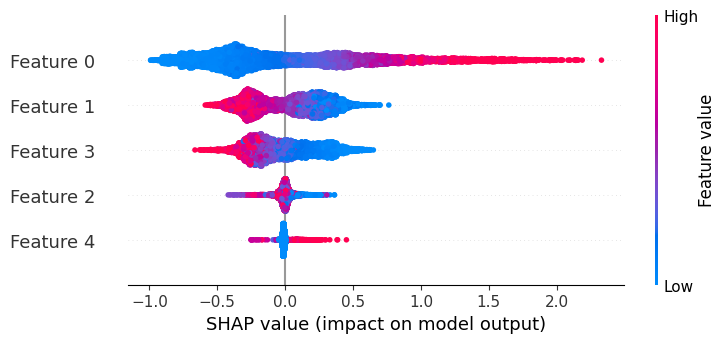

<Figure size 640x480 with 0 Axes>

In [69]:
# SHAP değerlerini görselleştirin
shap.plots.beeswarm(shap_values)

# Görseli kaydedin
plt.savefig('shap_values_beeswarm3.png', format='png')

# Görseli gösterin (isteğe bağlı)
plt.show()

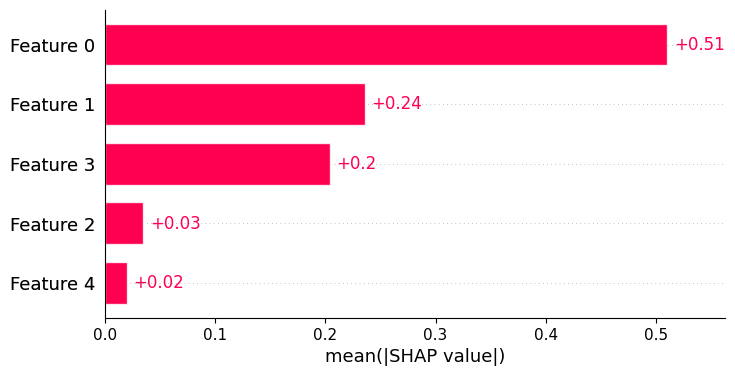

<Figure size 640x480 with 0 Axes>

In [70]:
shap.plots.bar(shap_values)
plt.savefig('bar3.png', format='png')

In [71]:
model.save('model_klasoru')

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


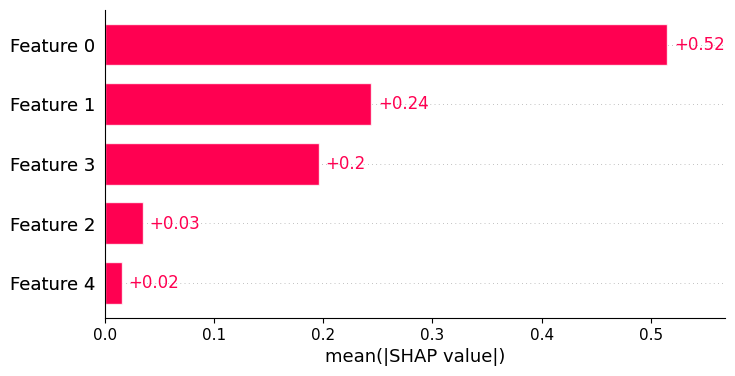

<Figure size 640x480 with 0 Axes>

In [33]:
shap.plots.bar(shap_values)
plt.savefig('bar.png', format='png')

In [50]:
df_bebtrsiz=pd.read_excel('BEBTRSIZ2.xlsx', index_col='BINAKODU')
df_bebtrsiz

IBB_KIMLIK  ZEMINUSTUK  TOPLAM_KAT   TOPLAM_INS  KOMPAKTLIK  \
BINAKODU                                                                 
100000041   120138421           8           9  1573.382834    0.655674   
100000371   529048347           4           5   403.567984    0.979796   
100000587   665293743           2           2   170.308782    1.069716   
100001148   133001527           5           6   584.176419    0.918030   
100001387   135026566           1           1    52.742200    1.448471   
...               ...         ...         ...          ...         ...   
779858547   529051845           8           9  5096.726824    0.396104   
779895754   665116350           5           6   684.118514    0.896348   
779931112   665269014           1           1    86.478102    1.200774   
779940709   529080997           4           4   532.055415    0.865178   
779988328   129000291           2           2   166.958452    1.051634   

             EN_BOY  TABANALANI    bitisik  BITISIKENR  Brlsk_Oran  YAPI_CEVRE  
BINAKODU                                                                        
100000041  0.703872  174.820315   0.000000    0.000000    0.000000   53.670466  
100000371  0.792093   80.713597   0.000000    0.000000    0.000000   36.178369  
100000587  0.728023   85.154391   6.613662    0.172010   17.200992   38.449304  
100001148  0.669065   97.362737   0.000000    0.000000    0.000000   41.445534  
100001387  0.718601   52.742200   0.000000    0.000000    0.000000   29.407404  
...             ...         ...        ...         ...         ...         ...  
779858547  0.512213  566.302980   0.000000    0.000000    0.000000  100.359513  
779895754  0.462027  114.019752   0.000000    0.000000    0.000000   47.300030  
779931112  0.756405   86.478102   0.000000    0.000000    0.000000   37.507310  
779940709  0.368538  133.013854   0.000000    0.000000    0.000000   51.998114  
779988328  0.731960   83.479226  10.628052    0.287725   28.772532   36.938188  

[713648 rows x 11 columns]

In [51]:
#YAPI_SISTEM değişkenini dışarıda tutalım
df_bebtrsiz = df_bebtrsiz.drop(["IBB_KIMLIK","ZEMINUSTUK", "TOPLAM_KAT", "bitisik", "BITISIKENR", "YAPI_CEVRE"], axis = 1).astype("float64")
df_bebtrsiz

TOPLAM_INS  KOMPAKTLIK    EN_BOY  TABANALANI  Brlsk_Oran
BINAKODU                                                            
100000041  1573.382834    0.655674  0.703872  174.820315    0.000000
100000371   403.567984    0.979796  0.792093   80.713597    0.000000
100000587   170.308782    1.069716  0.728023   85.154391   17.200992
100001148   584.176419    0.918030  0.669065   97.362737    0.000000
100001387    52.742200    1.448471  0.718601   52.742200    0.000000
...                ...         ...       ...         ...         ...
779858547  5096.726824    0.396104  0.512213  566.302980    0.000000
779895754   684.118514    0.896348  0.462027  114.019752    0.000000
779931112    86.478102    1.200774  0.756405   86.478102    0.000000
779940709   532.055415    0.865178  0.368538  133.013854    0.000000
779988328   166.958452    1.051634  0.731960   83.479226   28.772532

[713648 rows x 5 columns]

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Veriyi standardize edelim
scaler.fit_transform(df_bebtrsiz)

# Veri setini ölçekle
df_bebtrsiz_scaled = scaler.transform(df_bebtrsiz)







In [53]:
df_bebtrsiz_scaled

array([[ 7.38156077e-01, -8.63785528e-01, -1.61106120e-03,
         1.97933318e-01, -7.63911576e-01],
       [-2.57402405e-01,  2.03183909e-01,  5.16889777e-01,
        -5.34064321e-01, -7.63911576e-01],
       [-4.55915167e-01,  4.99188354e-01,  1.40328024e-01,
        -4.99522142e-01,  9.82978833e-02],
       ...,
       [-5.27258376e-01,  9.30614918e-01,  3.07138092e-01,
        -4.89225822e-01, -7.63911576e-01],
       [-1.48054544e-01, -1.74123090e-01, -1.97247498e+00,
        -1.27253145e-01, -7.63911576e-01],
       [-4.58766430e-01,  4.39664576e-01,  1.63469476e-01,
        -5.12552212e-01,  6.78327835e-01]])

In [54]:
df_bebtrsiz_scaled = pd.DataFrame(df_bebtrsiz_scaled, columns=df_bebtrsiz.columns, index=df_bebtrsiz.index)

In [55]:
enerji_tahmin= model.predict(df_bebtrsiz_scaled )

22302/22302 [==============================] - 36s 2ms/step


In [56]:
np.exp(enerji_tahmin)

array([[205572.64],
       [ 53159.85],
       [ 61622.83],
       ...,
       [101709.67],
       [137142.19],
       [ 33175.69]], dtype=float32)

In [57]:
#Tahmin edilen değerlerle DataFrame oluştur
enerji_tahmin_df = pd.DataFrame(np.exp(enerji_tahmin), columns=["ENERJI"], index=df_bebtrsiz.index)

# DataFrame'i yeniden oluştururken indeksi tekrar ekleyin
print(enerji_tahmin_df)

                  ENERJI
BINAKODU                
100000041  205572.640625
100000371   53159.851562
100000587   61622.828125
100001148  128099.906250
100001387   86653.429688
...                  ...
779858547  297181.531250
779895754  142828.656250
779931112  101709.671875
779940709  137142.187500
779988328   33175.691406

[713648 rows x 1 columns]


In [58]:
enerji_tahmin_df.to_excel('ENERJI_TAHMIN_YAPIMSISTEMLI3_deneme.xlsx')

In [59]:
enerji_tahmin_df.to_csv('ENERJI_TAHMIN_YAPIMSISTEMLI2_deneme.csv')

In [60]:
X_train_first_10 = X_train[:10]
X_train_first_10

array([[-0.87408109,  0.87296452,  1.47235831, -0.89810994, -0.29499065],
       [-0.40970417,  0.13574991,  0.30634056, -0.68620122, -0.29499065],
       [ 2.57009598, -1.99551591,  0.94341373,  3.2446656 , -0.29499065],
       [-0.29301984, -0.29354186, -1.63985936,  0.01256513, -0.29499065],
       [-0.59050072,  1.41257591, -1.4314602 , -0.83050914, -0.29499065],
       [ 0.47904003, -0.93934846, -1.37715264,  0.38888154, -0.29499065],
       [ 0.35523167, -1.14020385, -0.82345904,  0.89162277,  4.1744564 ],
       [ 0.2596961 , -1.23423109, -0.19516909,  1.2203258 , -0.29499065],
       [-0.39041131,  0.20092746, -0.32069205, -0.65608901, -0.29499065],
       [-0.56208206,  0.7472706 ,  0.1614474 , -0.77876198, -0.29499065]])

In [61]:
enerji_tahmin_YENİ= model.predict(X_train_first_10)
enerji_tahmin_YENİ

1/1 [==============================] - 0s 29ms/step


array([[10.570054],
       [11.496466],
       [12.665886],
       [11.702657],
       [11.333753],
       [12.16723 ],
       [12.411852],
       [12.067965],
       [11.498647],
       [11.165507]], dtype=float32)

In [62]:
np.exp(enerji_tahmin_YENİ)

array([[ 38950.78 ],
       [ 98367.484],
       [316755.66 ],
       [120892.47 ],
       [ 83596.14 ],
       [192380.34 ],
       [245696.39 ],
       [174200.9  ],
       [ 98582.27 ],
       [ 70650.984]], dtype=float32)

In [63]:
 y_train[:10]

array([10.42559392, 11.03727836, 12.42346546, 11.75361099, 11.58722874,
       12.19016542, 13.06244317, 11.95157603, 11.84624603, 11.65047878])

In [64]:
np.exp(y_train[:10])

array([ 33711.48698,  62148.27634, 248566.4416 , 127212.0923 ,
       107713.3421 , 196843.7249 , 470919.8397 , 155061.3358 ,
       139559.4599 , 114746.2879 ])